##Install Dependencies


In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install fsspec==2024.10.0
!pip install -q -U git+https://github.com/huggingface/transformers
!pip install datasets
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.10.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 25.5 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.10.0
    Uninstalling accelerate-1.10.0:
      Succes

In [ ]:
import os
import random
import csv
import re
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    precision_recall_fscore_support,
)

import bitsandbytes as bnb

from datasets import Dataset, DatasetDict
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    pipeline,
    logging,
)

from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    PeftModel,
    PeftConfig,
)

from trl import SFTTrainer, setup_chat_format

import wandb
from google.colab import files
from google.colab import userdata


## Environment setup

In [ ]:

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

def set_all_seeds(seed):
       """Set all seeds for reproducibility"""

       random.seed(seed)
       np.random.seed(seed)
       torch.manual_seed(seed)
       if torch.cuda.is_available():
           torch.cuda.manual_seed(seed)
           torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False

set_all_seeds(49)



In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")



CUDA available: True


##Upload preprocessed datasets Make it compactable for analysis


In [ ]:
print("Please upload files for cyber bullying detection train data")
cyb_train= files.upload()
cyb_train= next(iter(cyb_train))
cyb_train=pd.read_csv(cyb_train)

print("Please upload files for cyber bullying detection validation data")
cyb_val= files.upload()
cyb_val= next(iter(cyb_val))
cyb_val=pd.read_csv(cyb_val)

print("Please upload files for cyb test")
cyb_test= files.upload()
cyb_test= next(iter(cyb_test))
cyb_test=pd.read_csv(cyb_test)


Please upload files for cyber bullying detection train data


Saving cyb_train.csv to cyb_train.csv
Please upload files for cyber bullying detection validation data


Saving cyb_val.csv to cyb_val.csv
Please upload files for cyb test


Saving cyb_test_gemma_9b.csv to cyb_test_gemma_9b.csv


In [ ]:
cyb_train.head()

,text,label
0,Lastly The crazy religious freak Simboryo Girl...,age
1,[USER] I was mostly with you until you started...,other_cyberbullying
2,[URL] Cat Performs Tricks in One Minute [URL] ...,other_cyberbullying
3,Thank you for this I think India should presen...,religion
4,BECAUSE THEY ARE LEGENDARY GET IT? P,other_cyberbullying


In [ ]:
from sklearn.utils import resample
# Get minimum class count
min_count = cyb_train['label'].value_counts().min()

# Resample each class
balanced_train_dfs = [resample(cyb_train[cyb_train['label'] == lbl], replace=False, n_samples=min_count, random_state=42)
                       for lbl in cyb_train['label'].unique()]
balanced_train_df = pd.concat(balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# Check new label distribution
print("Balanced Label Distribution:\n", balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
other_cyberbullying    5480
not_cyberbullying      5480
age                    5480
religion               5480
gender                 5480
ethnicity              5480
Name: count, dtype: int64


In [ ]:
balanced_train_df = balanced_train_df.reset_index(drop=True)
cyb_val = cyb_val.reset_index(drop=True)


In [ ]:
class_weights=(1/balanced_train_df.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()

print(f"class weights:{class_weights}")

dataset_train = balanced_train_df
dataset_val =cyb_val

dataset = DatasetDict({
    'train': Dataset.from_pandas(dataset_train),
    'val': Dataset.from_pandas(dataset_val)

class weights:tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])


In [ ]:
balanced_train_df.head()

,text,label
0,I have no intent on linking to the articles wh...,other_cyberbullying
1,[USER] im at my algebra class! Come save me twin.,not_cyberbullying
2,are you braindead? I am a Indian if a American...,age
3,Oh really? The people who talk about raping ea...,religion
4,Not India you and a few muslims the world over...,religion


##Prompt for training and testing

In [ ]:
def create_training_prompt(row):
    return f"""You are a strict cyber bullying text classifier. Classify cyberbullying text by PRIMARY target group:

- age: Age-based discrimination, attacks on minors/elderly
- religion: Attacks on religious groups/beliefs
- gender: Sexism, homophobia, rape jokes
- ethnicity: Racism, racial slurs
- not_cyberbullying: Normal conversation
- other_cyberbullying: General harassment

TEXT: "{row['text']}"

Auxiliary information: Not provided

CLASSIFICATION: {row['label']}""".strip()

In [ ]:
balanced_train_df['text'] = balanced_train_df.apply(create_training_prompt, axis=1)
cyb_val['text'] = cyb_val.apply(create_training_prompt, axis=1)

In [ ]:
def create_test_prompt(row):
    return f"""You are a strict cyber bullying text classifier. Classify cyberbullying text by PRIMARY target group:

- age: Age-based discrimination, attacks on minors/elderly
- religion: Attacks on religious groups/beliefs
- gender: Sexism, homophobia, rape jokes
- ethnicity: Racism, racial slurs
- not_cyberbullying: Normal conversation
- other_cyberbullying: General harassment

TEXT: "{row['text']}"

Auxiliary information: Not provided

CLASSIFICATION: """.strip()

In [ ]:
# Generate test prompts and extract true labels
y_true = cyb_test.loc[:, 'label']
X_test = pd.DataFrame(cyb_test.apply(create_test_prompt, axis=1), columns=["text"])

In [ ]:
from datasets import Dataset
train_data = Dataset.from_pandas(balanced_train_df[['text']])
eval_data = Dataset.from_pandas(cyb_val[['text']])

In [ ]:
train_data['text'][3]

'You are a strict cyber bullying text classifier. Classify cyberbullying text by PRIMARY target group:\n\n- age: Age-based discrimination, attacks on minors/elderly\n- religion: Attacks on religious groups/beliefs\n- gender: Sexism, homophobia, rape jokes\n- ethnicity: Racism, racial slurs\n- not_cyberbullying: Normal conversation\n- other_cyberbullying: General harassment\n\nTEXT: "Oh really? The people who talk about raping each other in comments are saying that Muslims are the one of rape most in India? It was not surprise for me cuz I have encountered so many idiot hindus like you. Go drink cow piss and then come"\n\nAuxiliary information: Not provided\n\nCLASSIFICATION: religion'

## MODEL SETUP AND FINE-TUNING

In [ ]:
# ============================================================================
# MODEL SETUP AND FINE-TUNING
# ============================================================================

# Model and Tokenizer Setup
model_name = "google/gemma-2-9b-it"

print("Loading model and tokenizer...")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    attn_implementation='eager',
    device_map="auto",
    torch_dtype="float16",
    quantization_config=quant_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token_id = tokenizer.eos_token_id

print("Model loaded successfully!")


Loading model and tokenizer...


config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Model loaded successfully!


In [ ]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [ ]:
modules = find_all_linear_names(model)
modules

['gate_proj', 'down_proj', 'v_proj', 'q_proj', 'k_proj', 'o_proj', 'up_proj']

In [ ]:
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from transformers import EarlyStoppingCallback

output_dir = "google/gemma-2-9b-it_cyb-model"

# PEFT Configuration
peft_config = LoraConfig(
    lora_alpha=8,
    lora_dropout=0.05,
    r=4,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

# Use SFTConfig with "text" field
training_arguments = SFTConfig(
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=8,
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    bf16=False,
    max_grad_norm=0.1,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    lr_scheduler_type="cosine",
    report_to="wandb",
    eval_strategy="steps",
    eval_steps=100,
    save_steps=100,
    save_total_limit=1,
    dataloader_num_workers=4,

    # SFT-specific parameters
    dataset_text_field="text",
    max_length=512,
    packing=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_drop_last=True,


    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3,early_stopping_threshold=0.002)]
)


Adding EOS to train dataset:   0%|          | 0/32880 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/32880 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/32880 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/7133 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/7133 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/7133 [00:00<?, ? examples/s]

In [ ]:
# Train model
trainer.train()

Step,Training Loss,Validation Loss
100,0.843800,0.888112
200,0.784800,0.830923
300,0.781100,0.821749
400,0.797000,0.815998
500,0.744600,0.814141
600,0.836200,0.810099
700,0.748900,0.805424
800,0.844400,0.803793
900,0.785400,0.801310
1000,0.768800,0.800557


TrainOutput(global_step=1800, training_loss=0.8271319219801161, metrics={'train_runtime': 6875.2302, 'train_samples_per_second': 4.782, 'train_steps_per_second': 0.598, 'total_flos': 1.1194671653093376e+17, 'train_loss': 0.8271319219801161})

In [ ]:
wandb.finish()

model.config.use_cache = True
model.gradient_checkpointing_disable()  #

eval/loss,█▅▄▃▃▃▃▃▇▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
eval/mean_token_accuracy,▁▂▆▆▇▇▇▇▁▆▆▇▆▇▇▇▇▇▇███████
eval/num_tokens,▁▁▁▂▂▂▂▂▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇██
eval/runtime,████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁▁▁▁▁▁▁▁██████████████████
eval/steps_per_second,█▇▇▇▇█▇▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▃▃▃▄▅▅▅▅▅▅▆▆▆█████
train/global_step,▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▆▆▆▇▇▇██
train/grad_norm,█▃▂▂▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂
train/learning_rate,▁▂▄▅▇█████████████▂▅█████▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅
train/loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('google/gemma-2-9b-it_cyb-model/tokenizer_config.json',
 'google/gemma-2-9b-it_cyb-model/special_tokens_map.json',
 'google/gemma-2-9b-it_cyb-model/chat_template.jinja',
 'google/gemma-2-9b-it_cyb-model/tokenizer.model',
 'google/gemma-2-9b-it_cyb-model/added_tokens.json',
 'google/gemma-2-9b-it_cyb-model/tokenizer.json')

In [ ]:
model.gradient_checkpointing_disable()

## Testing with Auxillary information and without auxillary information

In [ ]:


prompt = f"""You are a strict cyber bullying text classifier. Classify cyberbullying text by PRIMARY target group:

- age: School bullying, age-based attacks
- religion: Attacks on religious groups/beliefs
- gender: Sexism, homophobia, rape jokes
- ethnicity: Racism, racial slurs
- not_cyberbullying: Normal conversation
- other_cyberbullying: General harassment.

 Text: "fyi of refugees in the world r muslims terrorists r muslims top wanted r all muslims highest crime rate muslims dominated areas r u jealous they america and uk like hindus more awww feeling bad tht trump said radical islamic terrorism seriously u guys r filth"

 Auxillary information: "Not provided"

 CLASSIFICATION: """.strip()

pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=15,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id

)

outputs = pipe(prompt,
              do_sample=True,
              temperature=0.1,
              top_p=0.9)

generated_text = outputs[0]['generated_text']
label = generated_text.split("CLASSIFICATION:")[-1].strip().split()[0]
print(f"Predicted label: {label}")

Device set to use cuda:0


Predicted label: religion


In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    categories =[
    'other_cyberbullying',
    'not_cyberbullying',
    'age',
    'religion',
    'gender',
    'ethnicity'
]
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens=15,
                        temperature=0.1)

        result = pipe(prompt)
        answer = result[0]['generated_text'].split("CLASSIFICATION:")[-1].strip()

        print(f"Predicted answer: {answer}")

        for category in categories:
            if category.lower() in answer.lower():

                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred

In [ ]:
def evaluate(y_true, y_pred):
    labels =[
    'other_cyberbullying',
    'not_cyberbullying',
    'age',
    'religion',
    'gender',
    'ethnicity'
]
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)
    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)


    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')


    unique_labels = set(y_true_mapped)

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')


    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)
    # Then plot with string labels
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_ylabel('true value')
    ax.set_xlabel('predicted value')
    plt.title('Confusion Matrix')
    plt.show()

  0%|          | 1/7152 [00:00<53:25,  2.23it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 2/7152 [00:01<1:36:34,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  0%|          | 3/7152 [00:01<1:16:48,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 4/7152 [00:02<1:07:34,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 5/7152 [00:02<1:02:18,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 6/7152 [00:03<1:24:16,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  0%|          | 7/7152 [00:04<1:13:50,  1.61it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 8/7152 [00:04<1:07:29,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 9/7152 [00:05<1:02:40,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 10/7152 [00:06<1:22:31,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  0%|          | 11/7152 [00:07<1:35:42,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  0%|          | 12/7152 [00:08<1:44:58,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  0%|          | 13/7152 [00:08<1:29:26,  1.33it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 14/7152 [00:09<1:40:44,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  0%|          | 15/7152 [00:10<1:26:26,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 16/7152 [00:10<1:16:16,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 17/7152 [00:11<1:30:55,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  0%|          | 18/7152 [00:12<1:41:13,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  0%|          | 19/7152 [00:13<1:26:38,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 20/7152 [00:13<1:16:36,  1.55it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 21/7152 [00:14<1:09:40,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 22/7152 [00:14<1:04:57,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 23/7152 [00:15<1:01:11,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 24/7152 [00:15<58:41,  2.02it/s]  Device set to use cuda:0


Predicted answer: age


  0%|          | 25/7152 [00:16<56:57,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 26/7152 [00:16<55:57,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 27/7152 [00:16<54:44,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 28/7152 [00:17<54:00,  2.20it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 29/7152 [00:17<54:38,  2.17it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 30/7152 [00:18<54:09,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 31/7152 [00:18<54:12,  2.19it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 32/7152 [00:19<53:46,  2.21it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 33/7152 [00:19<54:02,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 34/7152 [00:20<53:38,  2.21it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 35/7152 [00:20<54:13,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 36/7152 [00:21<1:15:38,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 37/7152 [00:22<1:08:41,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 38/7152 [00:23<1:25:37,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 39/7152 [00:23<1:16:08,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 40/7152 [00:24<1:31:33,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 41/7152 [00:25<1:19:49,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 42/7152 [00:25<1:11:54,  1.65it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 43/7152 [00:26<1:05:50,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 44/7152 [00:26<1:02:21,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 45/7152 [00:26<59:39,  1.99it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 46/7152 [00:27<57:31,  2.06it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 47/7152 [00:27<56:00,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 48/7152 [00:28<1:17:04,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  1%|          | 49/7152 [00:29<1:31:56,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 50/7152 [00:30<1:20:09,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 51/7152 [00:30<1:12:19,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 52/7152 [00:31<1:06:15,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 53/7152 [00:31<1:02:01,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 54/7152 [00:32<58:58,  2.01it/s]  Device set to use cuda:0


Predicted answer: gender


  1%|          | 55/7152 [00:32<57:16,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 56/7152 [00:33<55:38,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 57/7152 [00:33<55:15,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 58/7152 [00:33<54:36,  2.17it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 59/7152 [00:34<54:00,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 60/7152 [00:34<53:45,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 61/7152 [00:35<53:30,  2.21it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 62/7152 [00:35<53:21,  2.21it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 63/7152 [00:36<53:00,  2.23it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 64/7152 [00:36<53:01,  2.23it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 65/7152 [00:37<1:14:20,  1.59it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 66/7152 [00:38<1:07:35,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 67/7152 [00:38<1:03:23,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 68/7152 [00:39<59:57,  1.97it/s]  Device set to use cuda:0


Predicted answer: religion


  1%|          | 69/7152 [00:39<57:29,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 70/7152 [00:39<55:47,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 71/7152 [00:40<55:00,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 72/7152 [00:40<54:03,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 73/7152 [00:41<53:17,  2.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 74/7152 [00:41<53:18,  2.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 75/7152 [00:42<1:14:45,  1.58it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 76/7152 [00:43<1:07:57,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 77/7152 [00:43<1:03:38,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 78/7152 [00:44<1:21:55,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  1%|          | 79/7152 [00:45<1:34:47,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  1%|          | 80/7152 [00:46<1:43:35,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  1%|          | 81/7152 [00:47<1:49:48,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 82/7152 [00:48<1:32:34,  1.27it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 83/7152 [00:49<1:42:14,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  1%|          | 84/7152 [00:49<1:28:03,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 85/7152 [00:50<1:38:57,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 86/7152 [00:51<1:46:43,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 87/7152 [00:52<1:30:41,  1.30it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 88/7152 [00:53<1:40:49,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 89/7152 [00:54<1:47:56,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|▏         | 90/7152 [00:55<1:53:09,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|▏         | 91/7152 [00:56<1:34:54,  1.24it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 92/7152 [00:56<1:22:12,  1.43it/s]Device set to use cuda:0


Predicted answer: age


  1%|▏         | 93/7152 [00:57<1:34:39,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|▏         | 94/7152 [00:57<1:22:00,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 95/7152 [00:58<1:13:05,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


  1%|▏         | 96/7152 [00:58<1:06:58,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|▏         | 97/7152 [00:59<1:02:32,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 98/7152 [00:59<59:36,  1.97it/s]  Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 99/7152 [01:00<57:22,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|▏         | 100/7152 [01:01<1:17:04,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|▏         | 101/7152 [01:01<1:09:31,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 102/7152 [01:02<1:04:07,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


  1%|▏         | 103/7152 [01:02<1:01:17,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


  1%|▏         | 104/7152 [01:03<58:34,  2.01it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  1%|▏         | 105/7152 [01:03<56:51,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 106/7152 [01:03<55:40,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 107/7152 [01:04<55:03,  2.13it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 108/7152 [01:05<1:16:25,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 109/7152 [01:06<1:31:00,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 110/7152 [01:06<1:19:22,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 111/7152 [01:08<1:32:33,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 112/7152 [01:09<1:42:02,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 113/7152 [01:09<1:27:18,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 114/7152 [01:10<1:38:03,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 115/7152 [01:11<1:24:13,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 116/7152 [01:11<1:15:23,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 117/7152 [01:11<1:09:26,  1.69it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 118/7152 [01:12<1:04:13,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 119/7152 [01:12<1:00:36,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 120/7152 [01:13<58:04,  2.02it/s]  Device set to use cuda:0


Predicted answer: age


  2%|▏         | 121/7152 [01:13<56:34,  2.07it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 122/7152 [01:14<1:16:59,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 123/7152 [01:15<1:31:43,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 124/7152 [01:16<1:41:25,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 125/7152 [01:17<1:26:25,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 126/7152 [01:17<1:15:49,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 127/7152 [01:18<1:29:40,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 128/7152 [01:19<1:18:14,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 129/7152 [01:19<1:10:17,  1.67it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 130/7152 [01:20<1:26:01,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 131/7152 [01:21<1:15:50,  1.54it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 132/7152 [01:21<1:08:38,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 133/7152 [01:22<1:03:40,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 134/7152 [01:22<1:00:12,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 135/7152 [01:23<57:37,  2.03it/s]  Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 136/7152 [01:23<55:53,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 137/7152 [01:24<1:16:49,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 138/7152 [01:25<1:30:44,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 139/7152 [01:26<1:40:18,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 140/7152 [01:27<1:48:01,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 141/7152 [01:28<1:52:49,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 142/7152 [01:29<1:34:25,  1.24it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 143/7152 [01:30<1:43:41,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 144/7152 [01:30<1:27:53,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 145/7152 [01:31<1:37:59,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 146/7152 [01:32<1:47:09,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 147/7152 [01:33<1:30:48,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 148/7152 [01:33<1:19:13,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 149/7152 [01:34<1:32:26,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 150/7152 [01:35<1:20:16,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 151/7152 [01:35<1:12:23,  1.61it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 152/7152 [01:36<1:06:14,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 153/7152 [01:37<1:23:16,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 154/7152 [01:37<1:13:53,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 155/7152 [01:38<1:07:04,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 156/7152 [01:38<1:02:22,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 157/7152 [01:39<1:20:24,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 158/7152 [01:40<1:11:52,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 159/7152 [01:40<1:06:06,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 160/7152 [01:41<1:23:15,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 161/7152 [01:42<1:13:44,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 162/7152 [01:43<1:28:18,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 163/7152 [01:44<1:38:58,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 164/7152 [01:44<1:24:44,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 165/7152 [01:45<1:36:03,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 166/7152 [01:46<1:45:04,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 167/7152 [01:47<1:29:03,  1.31it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 168/7152 [01:47<1:17:49,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 169/7152 [01:48<1:09:59,  1.66it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 170/7152 [01:49<1:25:50,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 171/7152 [01:49<1:15:52,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 172/7152 [01:50<1:08:33,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 173/7152 [01:51<1:24:59,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 174/7152 [01:51<1:15:21,  1.54it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 175/7152 [01:52<1:29:56,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 176/7152 [01:53<1:18:28,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 177/7152 [01:53<1:10:40,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 178/7152 [01:53<1:05:01,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 179/7152 [01:55<1:22:22,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 180/7152 [01:56<1:34:27,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 181/7152 [01:56<1:21:33,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 182/7152 [01:56<1:12:32,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 183/7152 [01:57<1:06:17,  1.75it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 184/7152 [01:58<1:23:54,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 185/7152 [01:58<1:14:11,  1.57it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 186/7152 [01:59<1:28:46,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 187/7152 [02:01<1:38:40,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 188/7152 [02:01<1:24:37,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 189/7152 [02:01<1:14:37,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 190/7152 [02:02<1:07:47,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 191/7152 [02:02<1:02:57,  1.84it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 192/7152 [02:03<59:40,  1.94it/s]  Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 193/7152 [02:03<57:49,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 194/7152 [02:04<56:03,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 195/7152 [02:04<55:03,  2.11it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 196/7152 [02:05<54:04,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 197/7152 [02:05<53:25,  2.17it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 198/7152 [02:05<52:59,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 199/7152 [02:07<1:14:54,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 200/7152 [02:08<1:29:28,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 201/7152 [02:08<1:18:08,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 202/7152 [02:09<1:31:25,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 203/7152 [02:10<1:40:37,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 204/7152 [02:11<1:25:42,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 205/7152 [02:11<1:15:30,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 206/7152 [02:12<1:08:18,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 207/7152 [02:12<1:03:16,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 208/7152 [02:12<59:52,  1.93it/s]  Device set to use cuda:0


Predicted answer: age


  3%|▎         | 209/7152 [02:13<57:25,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 210/7152 [02:13<55:47,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 211/7152 [02:14<54:46,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 212/7152 [02:14<54:03,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 213/7152 [02:15<53:26,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 214/7152 [02:16<1:15:11,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 215/7152 [02:17<1:29:17,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 216/7152 [02:17<1:18:05,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 217/7152 [02:18<1:31:45,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 218/7152 [02:19<1:19:24,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 219/7152 [02:19<1:11:14,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 220/7152 [02:20<1:05:46,  1.76it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 221/7152 [02:20<1:01:36,  1.88it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 222/7152 [02:21<58:32,  1.97it/s]  Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 223/7152 [02:21<56:40,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 224/7152 [02:21<55:06,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 225/7152 [02:22<53:58,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 226/7152 [02:22<53:19,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 227/7152 [02:23<52:41,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 228/7152 [02:23<53:19,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 229/7152 [02:24<52:46,  2.19it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 230/7152 [02:24<52:26,  2.20it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 231/7152 [02:25<52:06,  2.21it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 232/7152 [02:25<52:18,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 233/7152 [02:26<52:18,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 234/7152 [02:27<1:13:34,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 235/7152 [02:28<1:28:14,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 236/7152 [02:29<1:39:07,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 237/7152 [02:29<1:24:45,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 238/7152 [02:30<1:14:55,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 239/7152 [02:31<1:29:02,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 240/7152 [02:31<1:17:50,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 241/7152 [02:32<1:31:04,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 242/7152 [02:33<1:19:09,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 243/7152 [02:33<1:10:45,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 244/7152 [02:34<1:25:38,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 245/7152 [02:35<1:15:28,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 246/7152 [02:35<1:08:08,  1.69it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 247/7152 [02:36<1:25:40,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 248/7152 [02:37<1:15:12,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 249/7152 [02:37<1:07:58,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 250/7152 [02:37<1:02:48,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▎         | 251/7152 [02:38<59:12,  1.94it/s]  Device set to use cuda:0


Predicted answer: gender


  4%|▎         | 252/7152 [02:39<1:17:53,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 253/7152 [02:40<1:30:36,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 254/7152 [02:40<1:18:52,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▎         | 255/7152 [02:41<1:31:18,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 256/7152 [02:43<1:40:25,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 257/7152 [02:44<1:46:48,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 258/7152 [02:45<1:50:55,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 259/7152 [02:46<1:54:24,  1.00it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 260/7152 [02:47<1:55:58,  1.01s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 261/7152 [02:48<1:57:33,  1.02s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 262/7152 [02:49<1:59:04,  1.04s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▎         | 263/7152 [02:49<1:38:34,  1.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▎         | 264/7152 [02:50<1:45:02,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 265/7152 [02:51<1:50:15,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▎         | 266/7152 [02:52<1:32:27,  1.24it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▎         | 267/7152 [02:52<1:20:02,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▎         | 268/7152 [02:53<1:32:15,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 269/7152 [02:54<1:19:57,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 270/7152 [02:54<1:11:03,  1.61it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 271/7152 [02:55<1:04:42,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 272/7152 [02:55<1:00:36,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 273/7152 [02:56<58:00,  1.98it/s]  Device set to use cuda:0


Predicted answer: age


  4%|▍         | 274/7152 [02:56<55:59,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 275/7152 [02:57<1:15:44,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 276/7152 [02:58<1:08:12,  1.68it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 277/7152 [02:59<1:24:34,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 278/7152 [03:00<1:35:26,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 279/7152 [03:00<1:22:11,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 280/7152 [03:01<1:12:55,  1.57it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 281/7152 [03:01<1:06:48,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 282/7152 [03:02<1:23:02,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 283/7152 [03:03<1:13:23,  1.56it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 284/7152 [03:03<1:06:38,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 285/7152 [03:04<1:22:54,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 286/7152 [03:04<1:13:14,  1.56it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 287/7152 [03:05<1:06:53,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 288/7152 [03:05<1:02:04,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 289/7152 [03:06<58:41,  1.95it/s]  Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 290/7152 [03:06<56:31,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 291/7152 [03:07<1:15:38,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 292/7152 [03:08<1:08:12,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 293/7152 [03:09<1:23:57,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 294/7152 [03:09<1:14:07,  1.54it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 295/7152 [03:10<1:07:07,  1.70it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 296/7152 [03:10<1:02:11,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 297/7152 [03:11<1:19:33,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 298/7152 [03:12<1:10:50,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 299/7152 [03:12<1:05:10,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 300/7152 [03:13<1:21:50,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 301/7152 [03:14<1:12:37,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 302/7152 [03:14<1:06:00,  1.73it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 303/7152 [03:15<1:01:17,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 304/7152 [03:16<1:18:56,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 305/7152 [03:16<1:10:26,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 306/7152 [03:16<1:04:31,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 307/7152 [03:17<1:00:17,  1.89it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 308/7152 [03:17<57:31,  1.98it/s]  Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 309/7152 [03:18<55:29,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 310/7152 [03:18<54:09,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 311/7152 [03:19<53:05,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 312/7152 [03:19<52:23,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 313/7152 [03:20<51:49,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 314/7152 [03:21<1:12:25,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 315/7152 [03:21<1:06:11,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 316/7152 [03:22<1:01:33,  1.85it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 317/7152 [03:22<58:18,  1.95it/s]  Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 318/7152 [03:22<56:00,  2.03it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 319/7152 [03:23<54:25,  2.09it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 320/7152 [03:23<53:12,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 321/7152 [03:24<52:18,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 322/7152 [03:24<51:53,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 323/7152 [03:25<1:12:27,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 324/7152 [03:26<1:05:58,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 325/7152 [03:27<1:22:05,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 326/7152 [03:27<1:12:51,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 327/7152 [03:28<1:06:08,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 328/7152 [03:28<1:01:35,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▍         | 329/7152 [03:29<58:19,  1.95it/s]  Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 330/7152 [03:29<56:11,  2.02it/s]Device set to use cuda:0


Predicted answer: age


  5%|▍         | 331/7152 [03:30<1:15:27,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 332/7152 [03:30<1:07:50,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 333/7152 [03:32<1:23:14,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 334/7152 [03:33<1:34:11,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 335/7152 [03:33<1:22:00,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▍         | 336/7152 [03:34<1:13:33,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 337/7152 [03:35<1:27:51,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 338/7152 [03:35<1:16:56,  1.48it/s]Device set to use cuda:0


Predicted answer: age


  5%|▍         | 339/7152 [03:36<1:09:36,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▍         | 340/7152 [03:36<1:04:00,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▍         | 341/7152 [03:37<1:21:15,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 342/7152 [03:38<1:32:57,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 343/7152 [03:39<1:20:14,  1.41it/s]Device set to use cuda:0


Predicted answer: age


  5%|▍         | 344/7152 [03:39<1:11:21,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 345/7152 [03:40<1:26:22,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 346/7152 [03:41<1:36:17,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 347/7152 [03:42<1:22:22,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 348/7152 [03:42<1:12:50,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 349/7152 [03:43<1:26:59,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 350/7152 [03:44<1:37:02,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 351/7152 [03:45<1:43:44,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 352/7152 [03:46<1:27:43,  1.29it/s]Device set to use cuda:0


Predicted answer: age


  5%|▍         | 353/7152 [03:46<1:17:08,  1.47it/s]Device set to use cuda:0


Predicted answer: age


  5%|▍         | 354/7152 [03:47<1:29:52,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 355/7152 [03:48<1:18:17,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 356/7152 [03:49<1:30:55,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 357/7152 [03:49<1:18:56,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 358/7152 [03:50<1:31:28,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▌         | 359/7152 [03:51<1:19:08,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▌         | 360/7152 [03:52<1:30:42,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 361/7152 [03:52<1:18:21,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 362/7152 [03:53<1:30:17,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 363/7152 [03:54<1:18:19,  1.44it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 364/7152 [03:55<1:30:29,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▌         | 365/7152 [03:55<1:18:35,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▌         | 366/7152 [03:56<1:09:47,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▌         | 367/7152 [03:56<1:03:56,  1.77it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 368/7152 [03:57<1:20:28,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 369/7152 [03:57<1:11:32,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▌         | 370/7152 [03:59<1:25:46,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 371/7152 [04:00<1:36:00,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 372/7152 [04:00<1:22:19,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 373/7152 [04:01<1:33:25,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 374/7152 [04:02<1:40:26,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 375/7152 [04:03<1:25:05,  1.33it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 376/7152 [04:04<1:35:17,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▌         | 377/7152 [04:04<1:21:48,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 378/7152 [04:05<1:12:26,  1.56it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 379/7152 [04:05<1:05:51,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▌         | 380/7152 [04:05<1:01:34,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 381/7152 [04:06<58:09,  1.94it/s]  Device set to use cuda:0


Predicted answer: gender


  5%|▌         | 382/7152 [04:06<55:48,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▌         | 383/7152 [04:07<54:04,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 384/7152 [04:08<1:14:16,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 385/7152 [04:08<1:07:14,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 386/7152 [04:09<1:22:37,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 387/7152 [04:10<1:32:41,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 388/7152 [04:11<1:19:54,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 389/7152 [04:12<1:31:51,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▌         | 390/7152 [04:12<1:20:03,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 391/7152 [04:13<1:11:14,  1.58it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 392/7152 [04:13<1:05:01,  1.73it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 393/7152 [04:14<1:00:36,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 394/7152 [04:15<1:18:06,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 395/7152 [04:15<1:09:44,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 396/7152 [04:16<1:04:02,  1.76it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 397/7152 [04:16<59:55,  1.88it/s]  Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 398/7152 [04:17<1:18:23,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 399/7152 [04:18<1:09:56,  1.61it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 400/7152 [04:19<1:24:29,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 401/7152 [04:19<1:14:15,  1.52it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 402/7152 [04:20<1:27:33,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 403/7152 [04:21<1:37:26,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 404/7152 [04:22<1:22:57,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 405/7152 [04:22<1:13:26,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 406/7152 [04:23<1:07:09,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 407/7152 [04:24<1:22:43,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 408/7152 [04:24<1:13:16,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 409/7152 [04:25<1:26:28,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 410/7152 [04:26<1:35:47,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 411/7152 [04:27<1:21:58,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 412/7152 [04:27<1:12:18,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 413/7152 [04:28<1:05:35,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 414/7152 [04:28<1:01:08,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 415/7152 [04:28<57:36,  1.95it/s]  Device set to use cuda:0


Predicted answer: age


  6%|▌         | 416/7152 [04:29<1:15:47,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 417/7152 [04:31<1:28:28,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 418/7152 [04:31<1:16:48,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 419/7152 [04:31<1:08:47,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 420/7152 [04:32<1:23:55,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 421/7152 [04:33<1:13:42,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 422/7152 [04:33<1:06:35,  1.68it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 423/7152 [04:34<1:02:14,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 424/7152 [04:34<58:29,  1.92it/s]  Device set to use cuda:0


Predicted answer: age


  6%|▌         | 425/7152 [04:35<1:16:25,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 426/7152 [04:36<1:29:48,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 427/7152 [04:37<1:17:40,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 428/7152 [04:37<1:09:40,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 429/7152 [04:38<1:24:03,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 430/7152 [04:39<1:34:23,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 431/7152 [04:40<1:21:08,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 432/7152 [04:41<1:32:14,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 433/7152 [04:41<1:19:35,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 434/7152 [04:42<1:31:13,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 435/7152 [04:43<1:18:54,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 436/7152 [04:43<1:10:53,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 437/7152 [04:44<1:26:15,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 438/7152 [04:45<1:15:37,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 439/7152 [04:45<1:07:56,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 440/7152 [04:46<1:23:11,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 441/7152 [04:47<1:13:26,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 442/7152 [04:48<1:27:16,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 443/7152 [04:48<1:16:01,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 444/7152 [04:49<1:08:16,  1.64it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 445/7152 [04:49<1:02:43,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 446/7152 [04:50<58:45,  1.90it/s]  Device set to use cuda:0


Predicted answer: religion


  6%|▋         | 447/7152 [04:50<56:18,  1.98it/s]Device set to use cuda:0


Predicted answer: age


  6%|▋         | 448/7152 [04:51<54:18,  2.06it/s]Device set to use cuda:0


Predicted answer: age


  6%|▋         | 449/7152 [04:52<1:13:28,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 450/7152 [04:52<1:06:39,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▋         | 451/7152 [04:53<1:21:58,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▋         | 452/7152 [04:54<1:32:50,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 453/7152 [04:55<1:40:47,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 454/7152 [04:56<1:25:25,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▋         | 455/7152 [04:57<1:35:03,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▋         | 456/7152 [04:57<1:21:37,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▋         | 457/7152 [04:58<1:32:11,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 458/7152 [04:59<1:20:19,  1.39it/s]Device set to use cuda:0


Predicted answer: age


  6%|▋         | 459/7152 [05:00<1:31:48,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 460/7152 [05:00<1:18:56,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▋         | 461/7152 [05:01<1:09:51,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▋         | 462/7152 [05:01<1:04:04,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▋         | 463/7152 [05:02<1:20:49,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 464/7152 [05:03<1:11:32,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 465/7152 [05:03<1:05:12,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 466/7152 [05:04<1:20:27,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 467/7152 [05:05<1:10:58,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 468/7152 [05:06<1:24:37,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 469/7152 [05:07<1:34:28,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 470/7152 [05:07<1:21:03,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 471/7152 [05:08<1:11:35,  1.56it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 472/7152 [05:08<1:04:55,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 473/7152 [05:08<1:00:11,  1.85it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 474/7152 [05:10<1:17:44,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 475/7152 [05:10<1:09:26,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 476/7152 [05:11<1:24:50,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 477/7152 [05:12<1:35:14,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 478/7152 [05:13<1:21:36,  1.36it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 479/7152 [05:13<1:12:36,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 480/7152 [05:14<1:06:15,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 481/7152 [05:15<1:21:44,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 482/7152 [05:16<1:32:40,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 483/7152 [05:16<1:19:42,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 484/7152 [05:17<1:10:39,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 485/7152 [05:17<1:04:34,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 486/7152 [05:18<1:20:10,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 487/7152 [05:19<1:10:56,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 488/7152 [05:19<1:04:53,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 489/7152 [05:19<1:00:11,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 490/7152 [05:20<56:55,  1.95it/s]  Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 491/7152 [05:20<54:39,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 492/7152 [05:21<53:05,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 493/7152 [05:22<1:12:15,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 494/7152 [05:22<1:05:31,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 495/7152 [05:23<1:00:40,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 496/7152 [05:23<57:48,  1.92it/s]  Device set to use cuda:0


Predicted answer: age


  7%|▋         | 497/7152 [05:24<55:11,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 498/7152 [05:25<1:13:28,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 499/7152 [05:26<1:27:11,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 500/7152 [05:26<1:15:50,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 501/7152 [05:27<1:07:54,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 502/7152 [05:27<1:02:21,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 503/7152 [05:28<1:18:39,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 504/7152 [05:29<1:09:57,  1.58it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 505/7152 [05:30<1:24:12,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 506/7152 [05:30<1:13:43,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 507/7152 [05:30<1:06:18,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 508/7152 [05:31<1:01:30,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 509/7152 [05:31<58:03,  1.91it/s]  Device set to use cuda:0


Predicted answer: age


  7%|▋         | 510/7152 [05:32<1:15:41,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 511/7152 [05:34<1:29:21,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 512/7152 [05:34<1:17:27,  1.43it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 513/7152 [05:34<1:09:00,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 514/7152 [05:36<1:23:25,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 515/7152 [05:37<1:33:33,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 516/7152 [05:37<1:20:37,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 517/7152 [05:37<1:11:11,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 518/7152 [05:38<1:04:34,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 519/7152 [05:39<1:20:28,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 520/7152 [05:39<1:11:03,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 521/7152 [05:40<1:24:37,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 522/7152 [05:41<1:13:56,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 523/7152 [05:42<1:26:37,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 524/7152 [05:43<1:35:57,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 525/7152 [05:43<1:21:52,  1.35it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 526/7152 [05:44<1:12:02,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 527/7152 [05:45<1:25:06,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 528/7152 [05:45<1:14:44,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 529/7152 [05:46<1:07:09,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 530/7152 [05:47<1:23:18,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 531/7152 [05:48<1:33:15,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 532/7152 [05:49<1:40:23,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 533/7152 [05:50<1:45:09,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 534/7152 [05:51<1:48:44,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 535/7152 [05:52<1:30:59,  1.21it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 536/7152 [05:53<1:38:24,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 537/7152 [05:54<1:44:14,  1.06it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 538/7152 [05:54<1:27:45,  1.26it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 539/7152 [05:55<1:16:08,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 540/7152 [05:56<1:27:46,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 541/7152 [05:56<1:16:13,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 542/7152 [05:57<1:07:53,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 543/7152 [05:57<1:03:16,  1.74it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 544/7152 [05:58<1:19:12,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 545/7152 [05:59<1:10:42,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 546/7152 [05:59<1:04:32,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 547/7152 [05:59<59:39,  1.85it/s]  Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 548/7152 [06:00<56:25,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 549/7152 [06:00<54:14,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 550/7152 [06:01<52:43,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 551/7152 [06:01<51:44,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 552/7152 [06:02<50:59,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 553/7152 [06:02<50:21,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 554/7152 [06:03<1:11:19,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 555/7152 [06:04<1:04:58,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 556/7152 [06:05<1:20:34,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 557/7152 [06:06<1:31:06,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 558/7152 [06:07<1:38:55,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 559/7152 [06:08<1:44:01,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 560/7152 [06:08<1:27:37,  1.25it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 561/7152 [06:09<1:16:15,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 562/7152 [06:09<1:07:51,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 563/7152 [06:10<1:01:56,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 564/7152 [06:10<57:49,  1.90it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 565/7152 [06:11<1:15:11,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 566/7152 [06:12<1:07:22,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 567/7152 [06:12<1:02:16,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 568/7152 [06:13<58:04,  1.89it/s]  Device set to use cuda:0


Predicted answer: age


  8%|▊         | 569/7152 [06:13<55:30,  1.98it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 570/7152 [06:13<53:29,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 571/7152 [06:14<52:06,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 572/7152 [06:14<51:05,  2.15it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 573/7152 [06:15<50:24,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 574/7152 [06:15<50:04,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 575/7152 [06:16<50:19,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 576/7152 [06:17<1:10:13,  1.56it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 577/7152 [06:17<1:03:58,  1.71it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 578/7152 [06:18<59:32,  1.84it/s]  Device set to use cuda:0


Predicted answer: age


  8%|▊         | 579/7152 [06:18<56:29,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 580/7152 [06:19<54:25,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 581/7152 [06:20<1:13:07,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 582/7152 [06:20<1:05:47,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 583/7152 [06:21<1:00:54,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 584/7152 [06:21<57:24,  1.91it/s]  Device set to use cuda:0


Predicted answer: age


  8%|▊         | 585/7152 [06:22<1:14:19,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 586/7152 [06:23<1:06:49,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 587/7152 [06:24<1:21:46,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 588/7152 [06:24<1:11:48,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 589/7152 [06:25<1:24:33,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 590/7152 [06:26<1:14:00,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 591/7152 [06:27<1:26:39,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 592/7152 [06:27<1:15:12,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 593/7152 [06:27<1:07:17,  1.62it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 594/7152 [06:28<1:01:28,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 595/7152 [06:28<57:42,  1.89it/s]  Device set to use cuda:0


Predicted answer: age


  8%|▊         | 596/7152 [06:29<54:58,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 597/7152 [06:29<53:06,  2.06it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 598/7152 [06:30<51:46,  2.11it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 599/7152 [06:30<50:49,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 600/7152 [06:31<1:07:00,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 601/7152 [06:32<1:01:21,  1.78it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 602/7152 [06:32<57:31,  1.90it/s]  Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 603/7152 [06:33<1:14:55,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 604/7152 [06:33<1:07:17,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 605/7152 [06:34<1:02:00,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 606/7152 [06:34<58:10,  1.88it/s]  Device set to use cuda:0


Predicted answer: age


  8%|▊         | 607/7152 [06:35<1:15:38,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 608/7152 [06:37<1:27:20,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 609/7152 [06:37<1:15:38,  1.44it/s]Device set to use cuda:0


Predicted answer: age


  9%|▊         | 610/7152 [06:37<1:07:20,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▊         | 611/7152 [06:38<1:02:00,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▊         | 612/7152 [06:39<1:17:43,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 613/7152 [06:39<1:09:01,  1.58it/s]Device set to use cuda:0


Predicted answer: age


  9%|▊         | 614/7152 [06:40<1:02:46,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▊         | 615/7152 [06:40<58:24,  1.87it/s]  Device set to use cuda:0


Predicted answer: gender


  9%|▊         | 616/7152 [06:41<1:15:14,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 617/7152 [06:42<1:07:03,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▊         | 618/7152 [06:42<1:01:20,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▊         | 619/7152 [06:43<1:17:22,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 620/7152 [06:44<1:28:40,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▊         | 621/7152 [06:45<1:36:08,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▊         | 622/7152 [06:46<1:21:30,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▊         | 623/7152 [06:47<1:32:14,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 624/7152 [06:48<1:39:08,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 625/7152 [06:48<1:23:43,  1.30it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 626/7152 [06:49<1:12:56,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 627/7152 [06:49<1:05:32,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 628/7152 [06:50<1:00:19,  1.80it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 629/7152 [06:50<56:58,  1.91it/s]  Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 630/7152 [06:51<54:20,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 631/7152 [06:51<52:56,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 632/7152 [06:51<51:19,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 633/7152 [06:53<1:11:02,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 634/7152 [06:53<1:04:17,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 635/7152 [06:54<1:19:29,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 636/7152 [06:54<1:10:28,  1.54it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 637/7152 [06:55<1:04:10,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 638/7152 [06:55<59:10,  1.83it/s]  Device set to use cuda:0


Predicted answer: age


  9%|▉         | 639/7152 [06:56<55:46,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 640/7152 [06:56<53:32,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 641/7152 [06:57<1:11:42,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 642/7152 [06:58<1:04:43,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 643/7152 [06:58<59:40,  1.82it/s]  Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 644/7152 [06:59<56:09,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 645/7152 [07:00<1:13:47,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 646/7152 [07:00<1:06:07,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 647/7152 [07:01<1:00:41,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 648/7152 [07:02<1:16:34,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 649/7152 [07:03<1:27:48,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 650/7152 [07:04<1:35:38,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 651/7152 [07:05<1:40:49,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 652/7152 [07:05<1:25:05,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 653/7152 [07:06<1:33:50,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 654/7152 [07:07<1:40:24,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 655/7152 [07:08<1:45:18,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 656/7152 [07:09<1:28:26,  1.22it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 657/7152 [07:10<1:36:07,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 658/7152 [07:11<1:41:25,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 659/7152 [07:11<1:25:11,  1.27it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 660/7152 [07:12<1:13:57,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 661/7152 [07:13<1:25:51,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 662/7152 [07:13<1:14:26,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 663/7152 [07:14<1:06:28,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 664/7152 [07:14<1:00:43,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 665/7152 [07:15<1:16:27,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 666/7152 [07:16<1:07:52,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 667/7152 [07:17<1:21:01,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 668/7152 [07:17<1:10:46,  1.53it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 669/7152 [07:18<1:03:41,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 670/7152 [07:18<58:42,  1.84it/s]  Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 671/7152 [07:19<1:15:29,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 672/7152 [07:20<1:07:15,  1.61it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 673/7152 [07:20<1:01:25,  1.76it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 674/7152 [07:20<57:24,  1.88it/s]  Device set to use cuda:0


Predicted answer: age


  9%|▉         | 675/7152 [07:21<54:57,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 676/7152 [07:21<52:58,  2.04it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 677/7152 [07:22<1:11:24,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 678/7152 [07:24<1:24:09,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 679/7152 [07:24<1:14:16,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 10%|▉         | 680/7152 [07:25<1:26:11,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|▉         | 681/7152 [07:26<1:34:45,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 682/7152 [07:27<1:20:37,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 683/7152 [07:28<1:30:19,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 684/7152 [07:28<1:17:38,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 685/7152 [07:29<1:27:54,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 686/7152 [07:30<1:15:49,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|▉         | 687/7152 [07:30<1:07:47,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 688/7152 [07:30<1:01:53,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|▉         | 689/7152 [07:31<57:55,  1.86it/s]  Device set to use cuda:0


Predicted answer: age


 10%|▉         | 690/7152 [07:32<1:15:11,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|▉         | 691/7152 [07:32<1:07:37,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 10%|▉         | 692/7152 [07:33<1:21:32,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 693/7152 [07:34<1:11:24,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 10%|▉         | 694/7152 [07:34<1:04:08,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 10%|▉         | 695/7152 [07:35<1:18:42,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 696/7152 [07:36<1:09:10,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 10%|▉         | 697/7152 [07:36<1:02:41,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 698/7152 [07:37<58:06,  1.85it/s]  Device set to use cuda:0


Predicted answer: age


 10%|▉         | 699/7152 [07:38<1:14:30,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 700/7152 [07:38<1:06:27,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 701/7152 [07:39<1:00:53,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|▉         | 702/7152 [07:40<1:16:55,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|▉         | 703/7152 [07:41<1:28:17,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 704/7152 [07:42<1:36:17,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 705/7152 [07:42<1:21:38,  1.32it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 706/7152 [07:43<1:30:49,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 707/7152 [07:44<1:17:35,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 10%|▉         | 708/7152 [07:45<1:29:14,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 709/7152 [07:45<1:16:54,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|▉         | 710/7152 [07:46<1:29:16,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 711/7152 [07:47<1:16:47,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 10%|▉         | 712/7152 [07:47<1:08:11,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 713/7152 [07:48<1:02:01,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 10%|▉         | 714/7152 [07:48<57:54,  1.85it/s]  Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 715/7152 [07:49<54:49,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 716/7152 [07:49<52:50,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 717/7152 [07:50<51:22,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 718/7152 [07:50<51:04,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 719/7152 [07:50<49:57,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 720/7152 [07:51<49:14,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 721/7152 [07:51<48:44,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 722/7152 [07:52<48:25,  2.21it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 723/7152 [07:53<1:07:43,  1.58it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 724/7152 [07:54<1:22:13,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 725/7152 [07:54<1:11:54,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 726/7152 [07:55<1:24:26,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 727/7152 [07:57<1:34:30,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|█         | 728/7152 [07:57<1:20:31,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 729/7152 [07:58<1:30:22,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 730/7152 [07:58<1:17:44,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 10%|█         | 731/7152 [07:59<1:08:45,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 732/7152 [08:00<1:22:58,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|█         | 733/7152 [08:01<1:31:25,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|█         | 734/7152 [08:02<1:18:07,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 10%|█         | 735/7152 [08:02<1:08:53,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 736/7152 [08:02<1:02:32,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 10%|█         | 737/7152 [08:03<58:10,  1.84it/s]  Device set to use cuda:0


Predicted answer: religion


 10%|█         | 738/7152 [08:03<56:14,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 739/7152 [08:04<1:13:31,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|█         | 740/7152 [08:05<1:05:42,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 741/7152 [08:05<1:00:20,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 742/7152 [08:06<56:35,  1.89it/s]  Device set to use cuda:0


Predicted answer: gender


 10%|█         | 743/7152 [08:06<54:43,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 744/7152 [08:07<52:29,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 745/7152 [08:07<51:00,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 746/7152 [08:08<1:10:29,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 747/7152 [08:09<1:03:39,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 748/7152 [08:09<58:51,  1.81it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 749/7152 [08:10<1:15:01,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|█         | 750/7152 [08:11<1:06:44,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 751/7152 [08:11<1:00:57,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 752/7152 [08:11<56:54,  1.87it/s]  Device set to use cuda:0


Predicted answer: religion


 11%|█         | 753/7152 [08:13<1:13:42,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 754/7152 [08:13<1:06:04,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 755/7152 [08:13<1:00:16,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 756/7152 [08:14<56:20,  1.89it/s]  Device set to use cuda:0


Predicted answer: religion


 11%|█         | 757/7152 [08:15<1:12:58,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 758/7152 [08:16<1:25:56,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 759/7152 [08:17<1:35:02,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 760/7152 [08:18<1:40:54,  1.06it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 761/7152 [08:19<1:24:37,  1.26it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 762/7152 [08:19<1:13:50,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 763/7152 [08:20<1:06:17,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 764/7152 [08:20<1:00:37,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 765/7152 [08:20<56:27,  1.89it/s]  Device set to use cuda:0


Predicted answer: gender


 11%|█         | 766/7152 [08:21<1:13:04,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 767/7152 [08:22<1:05:04,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 768/7152 [08:23<1:19:21,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 769/7152 [08:23<1:09:55,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 770/7152 [08:24<1:03:24,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 771/7152 [08:25<1:18:55,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 772/7152 [08:25<1:09:23,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 773/7152 [08:26<1:03:03,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 774/7152 [08:26<58:20,  1.82it/s]  Device set to use cuda:0


Predicted answer: religion


 11%|█         | 775/7152 [08:27<55:00,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 776/7152 [08:27<52:41,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 777/7152 [08:28<51:03,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 778/7152 [08:28<50:28,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 779/7152 [08:29<49:20,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 780/7152 [08:29<48:56,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 781/7152 [08:30<1:08:20,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 782/7152 [08:30<1:01:51,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 783/7152 [08:32<1:16:54,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 784/7152 [08:32<1:08:10,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 785/7152 [08:33<1:21:55,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 786/7152 [08:34<1:13:07,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 787/7152 [08:34<1:05:31,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 788/7152 [08:34<1:00:03,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 789/7152 [08:35<56:09,  1.89it/s]  Device set to use cuda:0


Predicted answer: age


 11%|█         | 790/7152 [08:35<53:28,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 791/7152 [08:36<51:44,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 792/7152 [08:36<50:09,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 793/7152 [08:37<49:00,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 794/7152 [08:37<49:28,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 795/7152 [08:38<48:54,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 796/7152 [08:38<48:44,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 797/7152 [08:38<48:00,  2.21it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 798/7152 [08:39<47:48,  2.22it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 799/7152 [08:39<47:37,  2.22it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 800/7152 [08:40<47:43,  2.22it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 801/7152 [08:40<47:52,  2.21it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 802/7152 [08:41<47:41,  2.22it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 803/7152 [08:41<47:29,  2.23it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 804/7152 [08:42<1:07:17,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█▏        | 805/7152 [08:43<1:01:14,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█▏        | 806/7152 [08:43<57:38,  1.83it/s]  Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 807/7152 [08:44<54:41,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█▏        | 808/7152 [08:44<52:44,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█▏        | 809/7152 [08:45<51:19,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█▏        | 810/7152 [08:45<50:30,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█▏        | 811/7152 [08:45<49:25,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 812/7152 [08:46<48:47,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█▏        | 813/7152 [08:46<48:17,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 814/7152 [08:47<47:56,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█▏        | 815/7152 [08:47<47:46,  2.21it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█▏        | 816/7152 [08:48<47:29,  2.22it/s]Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 817/7152 [08:49<1:06:54,  1.58it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█▏        | 818/7152 [08:49<1:01:01,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 819/7152 [08:50<56:46,  1.86it/s]  Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 820/7152 [08:51<1:13:13,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█▏        | 821/7152 [08:51<1:05:26,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█▏        | 822/7152 [08:52<59:50,  1.76it/s]  Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 823/7152 [08:53<1:15:20,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 824/7152 [08:54<1:26:23,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 825/7152 [08:54<1:14:52,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 826/7152 [08:55<1:06:43,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 827/7152 [08:55<1:00:57,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 828/7152 [08:55<56:29,  1.87it/s]  Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 829/7152 [08:56<53:19,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 830/7152 [08:57<1:10:47,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 831/7152 [08:58<1:23:18,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 832/7152 [08:59<1:31:46,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 833/7152 [09:00<1:18:24,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 834/7152 [09:01<1:28:09,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 835/7152 [09:01<1:15:52,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 836/7152 [09:02<1:07:12,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 837/7152 [09:02<1:01:35,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 838/7152 [09:02<57:11,  1.84it/s]  Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 839/7152 [09:03<54:03,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 840/7152 [09:03<51:53,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 841/7152 [09:04<1:10:40,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 842/7152 [09:05<1:23:43,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 843/7152 [09:07<1:32:17,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 844/7152 [09:08<1:38:10,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 845/7152 [09:09<1:41:47,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 846/7152 [09:09<1:25:54,  1.22it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 847/7152 [09:10<1:14:15,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 848/7152 [09:10<1:06:33,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 849/7152 [09:10<1:00:35,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 850/7152 [09:11<56:25,  1.86it/s]  Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 851/7152 [09:12<1:13:28,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 852/7152 [09:13<1:24:57,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 853/7152 [09:14<1:13:21,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 854/7152 [09:15<1:24:27,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 855/7152 [09:15<1:13:27,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 856/7152 [09:16<1:07:43,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 857/7152 [09:16<1:02:07,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 858/7152 [09:16<57:39,  1.82it/s]  Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 859/7152 [09:17<54:29,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 860/7152 [09:18<1:11:22,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 861/7152 [09:18<1:04:03,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 862/7152 [09:19<1:17:51,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 863/7152 [09:20<1:08:51,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 864/7152 [09:20<1:02:16,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 865/7152 [09:21<1:16:51,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 866/7152 [09:22<1:26:59,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 867/7152 [09:23<1:15:12,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 868/7152 [09:23<1:07:48,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 869/7152 [09:24<1:01:23,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 870/7152 [09:24<57:18,  1.83it/s]  Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 871/7152 [09:25<54:07,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 872/7152 [09:26<1:11:05,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 873/7152 [09:26<1:03:45,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 874/7152 [09:27<58:21,  1.79it/s]  Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 875/7152 [09:27<56:52,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 876/7152 [09:28<1:17:30,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 877/7152 [09:29<1:08:38,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 878/7152 [09:29<1:02:22,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 879/7152 [09:30<57:39,  1.81it/s]  Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 880/7152 [09:30<54:46,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 881/7152 [09:31<52:21,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 882/7152 [09:32<1:10:23,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 883/7152 [09:32<1:03:27,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 884/7152 [09:33<58:23,  1.79it/s]  Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 885/7152 [09:33<56:48,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 886/7152 [09:34<56:21,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 887/7152 [09:34<53:32,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 888/7152 [09:35<1:11:13,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 889/7152 [09:36<1:03:47,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 890/7152 [09:37<1:17:49,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 891/7152 [09:37<1:09:31,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 892/7152 [09:38<1:02:43,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 893/7152 [09:38<58:21,  1.79it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▎        | 894/7152 [09:39<1:14:04,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 895/7152 [09:40<1:26:07,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 896/7152 [09:41<1:14:24,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 897/7152 [09:42<1:25:36,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 898/7152 [09:43<1:37:17,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 899/7152 [09:43<1:22:09,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 900/7152 [09:44<1:11:39,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 901/7152 [09:44<1:04:20,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 902/7152 [09:45<58:58,  1.77it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 903/7152 [09:45<55:14,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 904/7152 [09:46<52:31,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 905/7152 [09:46<53:27,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 906/7152 [09:47<1:10:11,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 907/7152 [09:48<1:02:57,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 908/7152 [09:48<58:04,  1.79it/s]  Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 909/7152 [09:49<54:30,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 910/7152 [09:49<52:07,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 911/7152 [09:50<50:23,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 912/7152 [09:50<49:08,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 913/7152 [09:51<1:07:13,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 914/7152 [09:51<1:01:04,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 915/7152 [09:52<57:05,  1.82it/s]  Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 916/7152 [09:52<53:59,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 917/7152 [09:53<51:32,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 918/7152 [09:53<49:49,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 919/7152 [09:54<48:45,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 920/7152 [09:54<48:18,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 921/7152 [09:55<1:06:46,  1.56it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 922/7152 [09:56<1:19:52,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 923/7152 [09:57<1:28:51,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 924/7152 [09:58<1:15:54,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 925/7152 [09:58<1:08:41,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 926/7152 [09:59<1:03:01,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 927/7152 [10:00<1:17:12,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 928/7152 [10:01<1:26:53,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 929/7152 [10:02<1:34:09,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 930/7152 [10:02<1:21:02,  1.28it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 931/7152 [10:03<1:10:33,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 932/7152 [10:03<1:03:26,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 933/7152 [10:04<1:18:06,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 934/7152 [10:05<1:27:30,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 935/7152 [10:06<1:15:07,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 936/7152 [10:07<1:25:50,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 937/7152 [10:08<1:32:56,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 938/7152 [10:09<1:22:14,  1.26it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 939/7152 [10:10<1:33:24,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 940/7152 [10:10<1:19:24,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 941/7152 [10:11<1:09:23,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 942/7152 [10:12<1:21:17,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 943/7152 [10:12<1:12:04,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 944/7152 [10:13<1:06:56,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 945/7152 [10:13<1:00:48,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 946/7152 [10:14<1:16:37,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 947/7152 [10:15<1:07:19,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 948/7152 [10:15<1:02:58,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 949/7152 [10:16<1:00:29,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 950/7152 [10:16<56:57,  1.82it/s]  Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 951/7152 [10:17<53:38,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 952/7152 [10:17<52:08,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 953/7152 [10:18<50:18,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 954/7152 [10:18<50:14,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 955/7152 [10:19<48:46,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 956/7152 [10:20<1:06:56,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 957/7152 [10:21<1:19:23,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 958/7152 [10:21<1:09:40,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 959/7152 [10:22<1:23:21,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 960/7152 [10:23<1:14:48,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 961/7152 [10:23<1:06:20,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 962/7152 [10:24<1:21:30,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 963/7152 [10:25<1:12:50,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 964/7152 [10:25<1:04:57,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 965/7152 [10:26<59:49,  1.72it/s]  Device set to use cuda:0


Predicted answer: age


 14%|█▎        | 966/7152 [10:27<1:15:03,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 14%|█▎        | 967/7152 [10:28<1:25:19,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 14%|█▎        | 968/7152 [10:28<1:13:52,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▎        | 969/7152 [10:29<1:25:24,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 970/7152 [10:30<1:13:30,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▎        | 971/7152 [10:31<1:24:51,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 972/7152 [10:31<1:13:17,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▎        | 973/7152 [10:32<1:23:52,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 974/7152 [10:33<1:12:24,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▎        | 975/7152 [10:34<1:23:41,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 976/7152 [10:34<1:12:28,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▎        | 977/7152 [10:35<1:04:38,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▎        | 978/7152 [10:35<59:04,  1.74it/s]  Device set to use cuda:0


Predicted answer: religion


 14%|█▎        | 979/7152 [10:36<1:17:49,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 980/7152 [10:38<1:28:02,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 981/7152 [10:39<1:34:37,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 982/7152 [10:39<1:20:13,  1.28it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▎        | 983/7152 [10:40<1:29:35,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 14%|█▍        | 984/7152 [10:41<1:16:48,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 985/7152 [10:42<1:26:15,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 986/7152 [10:43<1:36:59,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 987/7152 [10:44<1:41:37,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 988/7152 [10:45<1:27:58,  1.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 989/7152 [10:45<1:15:55,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 990/7152 [10:45<1:06:37,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 991/7152 [10:47<1:22:53,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 992/7152 [10:47<1:12:27,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 993/7152 [10:48<1:04:27,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 994/7152 [10:48<59:48,  1.72it/s]  Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 995/7152 [10:48<55:26,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 996/7152 [10:49<52:34,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 997/7152 [10:50<1:09:11,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 998/7152 [10:50<1:02:08,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 999/7152 [10:51<58:18,  1.76it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1000/7152 [10:52<1:13:39,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1001/7152 [10:53<1:27:32,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1002/7152 [10:54<1:34:19,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1003/7152 [10:55<1:20:15,  1.28it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1004/7152 [10:56<1:29:08,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1005/7152 [10:56<1:16:32,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1006/7152 [10:57<1:07:50,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1007/7152 [10:57<1:01:33,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1008/7152 [10:58<56:48,  1.80it/s]  Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1009/7152 [10:59<1:12:16,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1010/7152 [10:59<1:04:50,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1011/7152 [11:00<59:03,  1.73it/s]  Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1012/7152 [11:01<1:14:07,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1013/7152 [11:01<1:05:21,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1014/7152 [11:01<59:14,  1.73it/s]  Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1015/7152 [11:02<55:12,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1016/7152 [11:02<54:16,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1017/7152 [11:03<51:42,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1018/7152 [11:03<49:50,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1019/7152 [11:04<48:48,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1020/7152 [11:05<1:09:54,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1021/7152 [11:05<1:02:37,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1022/7152 [11:06<1:17:03,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1023/7152 [11:07<1:07:40,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1024/7152 [11:07<1:01:08,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1025/7152 [11:08<56:37,  1.80it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1026/7152 [11:09<1:13:12,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 14%|█▍        | 1027/7152 [11:09<1:04:57,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1028/7152 [11:10<59:07,  1.73it/s]  Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1029/7152 [11:10<55:02,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1030/7152 [11:11<52:04,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1031/7152 [11:11<50:25,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1032/7152 [11:12<48:42,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1033/7152 [11:12<48:26,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1034/7152 [11:12<47:33,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1035/7152 [11:13<46:57,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1036/7152 [11:13<46:27,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1037/7152 [11:14<46:12,  2.21it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1038/7152 [11:14<46:32,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1039/7152 [11:15<46:19,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1040/7152 [11:16<1:04:48,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▍        | 1041/7152 [11:16<59:12,  1.72it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1042/7152 [11:17<55:01,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1043/7152 [11:17<53:16,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1044/7152 [11:18<51:00,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1045/7152 [11:18<49:24,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1046/7152 [11:19<1:06:34,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▍        | 1047/7152 [11:20<1:00:15,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1048/7152 [11:20<55:58,  1.82it/s]  Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1049/7152 [11:21<1:11:30,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1050/7152 [11:22<1:03:36,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1051/7152 [11:22<58:14,  1.75it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1052/7152 [11:22<54:09,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1053/7152 [11:23<1:10:21,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1054/7152 [11:24<1:03:07,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1055/7152 [11:24<57:57,  1.75it/s]  Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1056/7152 [11:25<1:13:14,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▍        | 1057/7152 [11:27<1:23:42,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1058/7152 [11:27<1:12:10,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1059/7152 [11:28<1:22:50,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1060/7152 [11:29<1:30:21,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1061/7152 [11:30<1:16:55,  1.32it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1062/7152 [11:30<1:07:35,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1063/7152 [11:30<1:00:53,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1064/7152 [11:31<56:13,  1.80it/s]  Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1065/7152 [11:31<52:54,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1066/7152 [11:32<50:43,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1067/7152 [11:32<49:06,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1068/7152 [11:33<48:03,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1069/7152 [11:34<1:06:04,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1070/7152 [11:34<59:58,  1.69it/s]  Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1071/7152 [11:35<55:39,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1072/7152 [11:35<52:31,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1073/7152 [11:36<50:20,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1074/7152 [11:36<49:09,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▌        | 1075/7152 [11:36<47:54,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1076/7152 [11:37<47:12,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1077/7152 [11:37<46:38,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1078/7152 [11:38<1:05:40,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▌        | 1079/7152 [11:40<1:18:48,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▌        | 1080/7152 [11:41<1:28:01,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1081/7152 [11:41<1:15:20,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1082/7152 [11:42<1:06:10,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1083/7152 [11:42<1:00:13,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1084/7152 [11:43<1:14:46,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1085/7152 [11:43<1:06:01,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1086/7152 [11:45<1:18:15,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1087/7152 [11:45<1:08:19,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1088/7152 [11:46<1:21:06,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▌        | 1089/7152 [11:47<1:28:38,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1090/7152 [11:48<1:15:22,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1091/7152 [11:48<1:06:20,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1092/7152 [11:48<1:00:01,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▌        | 1093/7152 [11:49<55:37,  1.82it/s]  Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1094/7152 [11:49<52:45,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1095/7152 [11:50<1:09:24,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1096/7152 [11:51<1:02:10,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1097/7152 [11:51<57:02,  1.77it/s]  Device set to use cuda:0


Predicted answer: age


 15%|█▌        | 1098/7152 [11:52<53:28,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1099/7152 [11:53<1:10:02,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1100/7152 [11:53<1:02:31,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1101/7152 [11:54<57:42,  1.75it/s]  Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1102/7152 [11:55<1:12:41,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1103/7152 [11:55<1:04:24,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1104/7152 [11:56<58:29,  1.72it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1105/7152 [11:56<54:59,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1106/7152 [11:57<1:10:42,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1107/7152 [11:58<1:21:31,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1108/7152 [11:59<1:10:35,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1109/7152 [12:00<1:21:22,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1110/7152 [12:00<1:10:36,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1111/7152 [12:01<1:21:36,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1112/7152 [12:02<1:10:39,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1113/7152 [12:02<1:03:12,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1114/7152 [12:03<57:49,  1.74it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1115/7152 [12:04<1:12:39,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1116/7152 [12:04<1:04:23,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1117/7152 [12:05<58:30,  1.72it/s]  Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1118/7152 [12:05<54:57,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1119/7152 [12:06<1:10:31,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1120/7152 [12:07<1:02:51,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1121/7152 [12:07<57:38,  1.74it/s]  Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1122/7152 [12:08<1:11:47,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1123/7152 [12:09<1:03:30,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1124/7152 [12:09<58:04,  1.73it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1125/7152 [12:09<54:11,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1126/7152 [12:10<52:20,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1127/7152 [12:10<50:14,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1128/7152 [12:11<48:47,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1129/7152 [12:11<47:43,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1130/7152 [12:12<46:57,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1131/7152 [12:13<1:04:43,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1132/7152 [12:14<1:17:36,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1133/7152 [12:14<1:08:00,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1134/7152 [12:15<1:19:26,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1135/7152 [12:16<1:09:31,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1136/7152 [12:16<1:01:53,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1137/7152 [12:17<56:29,  1.77it/s]  Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1138/7152 [12:18<1:11:20,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1139/7152 [12:18<1:03:24,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1140/7152 [12:19<57:32,  1.74it/s]  Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1141/7152 [12:19<54:14,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1142/7152 [12:20<51:55,  1.93it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1143/7152 [12:20<49:43,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1144/7152 [12:21<48:03,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1145/7152 [12:22<1:05:03,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1146/7152 [12:22<58:45,  1.70it/s]  Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1147/7152 [12:22<54:19,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1148/7152 [12:23<51:15,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1149/7152 [12:23<50:00,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1150/7152 [12:24<1:06:40,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1151/7152 [12:25<1:18:49,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1152/7152 [12:27<1:28:40,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1153/7152 [12:27<1:15:34,  1.32it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1154/7152 [12:28<1:06:22,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1155/7152 [12:28<59:54,  1.67it/s]  Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1156/7152 [12:29<1:13:51,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1157/7152 [12:29<1:04:56,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1158/7152 [12:30<58:42,  1.70it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1159/7152 [12:31<1:12:45,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1160/7152 [12:31<1:04:11,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1161/7152 [12:32<1:17:40,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1162/7152 [12:33<1:07:45,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▋        | 1163/7152 [12:33<1:00:52,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▋        | 1164/7152 [12:34<56:00,  1.78it/s]  Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1165/7152 [12:34<52:47,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 16%|█▋        | 1166/7152 [12:35<1:09:02,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1167/7152 [12:36<1:01:44,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▋        | 1168/7152 [12:36<57:52,  1.72it/s]  Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1169/7152 [12:37<1:12:27,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1170/7152 [12:38<1:22:28,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1171/7152 [12:39<1:11:28,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1172/7152 [12:40<1:22:07,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1173/7152 [12:40<1:10:38,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1174/7152 [12:41<1:21:36,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1175/7152 [12:43<1:28:28,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▋        | 1176/7152 [12:44<1:33:41,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1177/7152 [12:45<1:37:02,  1.03it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1178/7152 [12:45<1:21:22,  1.22it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▋        | 1179/7152 [12:46<1:10:16,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1180/7152 [12:46<1:03:10,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1181/7152 [12:46<57:32,  1.73it/s]  Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1182/7152 [12:47<53:40,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1183/7152 [12:47<50:56,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1184/7152 [12:48<49:01,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1185/7152 [12:49<1:06:22,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1186/7152 [12:49<59:58,  1.66it/s]  Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1187/7152 [12:50<1:13:52,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1188/7152 [12:51<1:04:58,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1189/7152 [12:52<1:17:00,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1190/7152 [12:52<1:07:12,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1191/7152 [12:53<1:18:27,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1192/7152 [12:54<1:08:24,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1193/7152 [12:54<1:01:18,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1194/7152 [12:55<56:11,  1.77it/s]  Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1195/7152 [12:56<1:10:46,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1196/7152 [12:56<1:03:35,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1197/7152 [12:57<57:49,  1.72it/s]  Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1198/7152 [12:57<53:49,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1199/7152 [12:58<1:09:38,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1200/7152 [12:59<1:01:57,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1201/7152 [13:00<1:14:45,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1202/7152 [13:01<1:24:01,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1203/7152 [13:02<1:30:27,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1204/7152 [13:03<1:34:36,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1205/7152 [13:04<1:37:59,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1206/7152 [13:04<1:22:13,  1.21it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1207/7152 [13:05<1:10:50,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1208/7152 [13:06<1:21:10,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1209/7152 [13:06<1:10:05,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1210/7152 [13:07<1:02:16,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1211/7152 [13:08<1:14:53,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1212/7152 [13:08<1:06:04,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1213/7152 [13:09<1:17:37,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1214/7152 [13:10<1:07:26,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1215/7152 [13:11<1:18:28,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1216/7152 [13:11<1:08:02,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1217/7152 [13:12<1:00:50,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1218/7152 [13:13<1:13:38,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1219/7152 [13:14<1:23:15,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1220/7152 [13:14<1:11:35,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1221/7152 [13:15<1:21:27,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1222/7152 [13:16<1:10:26,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1223/7152 [13:16<1:02:38,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1224/7152 [13:17<57:04,  1.73it/s]  Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1225/7152 [13:17<53:09,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1226/7152 [13:18<1:08:35,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1227/7152 [13:19<1:19:13,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1228/7152 [13:20<1:09:24,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1229/7152 [13:20<1:02:03,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1230/7152 [13:21<56:48,  1.74it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1231/7152 [13:21<52:58,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1232/7152 [13:22<50:18,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1233/7152 [13:22<48:38,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1234/7152 [13:23<47:11,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1235/7152 [13:23<46:17,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1236/7152 [13:23<45:45,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1237/7152 [13:24<45:20,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1238/7152 [13:24<44:46,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1239/7152 [13:25<44:16,  2.23it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1240/7152 [13:26<1:02:27,  1.58it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1241/7152 [13:27<1:15:24,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1242/7152 [13:28<1:25:00,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1243/7152 [13:28<1:12:25,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1244/7152 [13:29<1:04:23,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1245/7152 [13:29<58:26,  1.68it/s]  Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1246/7152 [13:30<53:57,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1247/7152 [13:30<51:00,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1248/7152 [13:31<1:06:55,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1249/7152 [13:32<1:00:03,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1250/7152 [13:32<55:10,  1.78it/s]  Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1251/7152 [13:33<1:09:25,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1252/7152 [13:34<1:01:31,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1253/7152 [13:35<1:14:45,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1254/7152 [13:36<1:23:51,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1255/7152 [13:36<1:12:21,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1256/7152 [13:37<1:03:58,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1257/7152 [13:38<1:16:05,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 18%|█▊        | 1258/7152 [13:39<1:23:57,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1259/7152 [13:40<1:31:13,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1260/7152 [13:40<1:17:19,  1.27it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1261/7152 [13:41<1:07:19,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1262/7152 [13:42<1:18:17,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1263/7152 [13:43<1:25:53,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1264/7152 [13:43<1:13:24,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1265/7152 [13:44<1:22:28,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1266/7152 [13:46<1:28:55,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1267/7152 [13:47<1:34:18,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 18%|█▊        | 1268/7152 [13:48<1:37:24,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1269/7152 [13:48<1:21:17,  1.21it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1270/7152 [13:49<1:09:59,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1271/7152 [13:50<1:20:15,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 18%|█▊        | 1272/7152 [13:50<1:10:25,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1273/7152 [13:51<1:02:18,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1274/7152 [13:51<56:39,  1.73it/s]  Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1275/7152 [13:51<52:50,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1276/7152 [13:52<50:13,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1277/7152 [13:52<48:02,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1278/7152 [13:53<1:04:55,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1279/7152 [13:54<58:43,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1280/7152 [13:54<54:58,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1281/7152 [13:55<51:32,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1282/7152 [13:55<49:25,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1283/7152 [13:56<1:05:42,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1284/7152 [13:57<59:02,  1.66it/s]  Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1285/7152 [13:57<54:21,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1286/7152 [13:58<51:08,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1287/7152 [13:59<1:06:47,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1288/7152 [13:59<1:00:45,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1289/7152 [14:00<55:40,  1.76it/s]  Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1290/7152 [14:00<52:28,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1291/7152 [14:01<49:59,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1292/7152 [14:01<48:26,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1293/7152 [14:01<47:55,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1294/7152 [14:02<47:17,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1295/7152 [14:03<1:04:35,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1296/7152 [14:03<58:24,  1.67it/s]  Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1297/7152 [14:04<54:02,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1298/7152 [14:04<50:56,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1299/7152 [14:05<1:06:45,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1300/7152 [14:06<59:47,  1.63it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1301/7152 [14:07<1:12:41,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1302/7152 [14:07<1:03:57,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1303/7152 [14:08<57:49,  1.69it/s]  Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1304/7152 [14:08<53:52,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1305/7152 [14:09<1:08:39,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1306/7152 [14:10<1:01:08,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1307/7152 [14:10<56:00,  1.74it/s]  Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1308/7152 [14:11<52:31,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1309/7152 [14:11<49:57,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1310/7152 [14:12<1:06:16,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1311/7152 [14:13<1:16:47,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 18%|█▊        | 1312/7152 [14:14<1:24:47,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1313/7152 [14:15<1:12:16,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1314/7152 [14:15<1:04:04,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1315/7152 [14:16<1:15:48,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1316/7152 [14:17<1:06:08,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1317/7152 [14:17<59:22,  1.64it/s]  Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1318/7152 [14:18<1:12:31,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1319/7152 [14:19<1:21:44,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1320/7152 [14:20<1:10:08,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1321/7152 [14:21<1:20:00,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1322/7152 [14:21<1:09:03,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1323/7152 [14:22<1:01:16,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▊        | 1324/7152 [14:22<56:15,  1.73it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▊        | 1325/7152 [14:23<52:34,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1326/7152 [14:23<49:49,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1327/7152 [14:23<47:50,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1328/7152 [14:24<46:32,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▊        | 1329/7152 [14:24<45:25,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1330/7152 [14:25<44:51,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1331/7152 [14:26<1:02:12,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▊        | 1332/7152 [14:26<56:29,  1.72it/s]  Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1333/7152 [14:27<52:27,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1334/7152 [14:27<49:40,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1335/7152 [14:28<47:39,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1336/7152 [14:29<1:04:15,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▊        | 1337/7152 [14:30<1:16:14,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▊        | 1338/7152 [14:30<1:06:25,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▊        | 1339/7152 [14:31<59:25,  1.63it/s]  Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1340/7152 [14:31<54:44,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1341/7152 [14:32<51:11,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1342/7152 [14:32<49:02,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1343/7152 [14:32<47:19,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1344/7152 [14:34<1:03:45,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1345/7152 [14:34<57:47,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1346/7152 [14:34<53:33,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1347/7152 [14:35<50:47,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1348/7152 [14:35<48:47,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1349/7152 [14:36<47:22,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1350/7152 [14:36<46:14,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1351/7152 [14:37<45:16,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1352/7152 [14:37<44:53,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1353/7152 [14:38<44:24,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1354/7152 [14:39<1:01:58,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1355/7152 [14:40<1:14:21,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1356/7152 [14:41<1:22:41,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1357/7152 [14:42<1:29:09,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1358/7152 [14:42<1:15:32,  1.28it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1359/7152 [14:43<1:23:41,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1360/7152 [14:44<1:11:37,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1361/7152 [14:44<1:03:04,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1362/7152 [14:45<57:12,  1.69it/s]  Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1363/7152 [14:45<53:17,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1364/7152 [14:46<50:17,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1365/7152 [14:47<1:05:46,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1366/7152 [14:47<59:27,  1.62it/s]  Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1367/7152 [14:48<54:38,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1368/7152 [14:48<51:22,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1369/7152 [14:49<1:06:34,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1370/7152 [14:50<59:31,  1.62it/s]  Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1371/7152 [14:50<54:34,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1372/7152 [14:51<1:08:56,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1373/7152 [14:52<1:01:18,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1374/7152 [14:53<1:13:28,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1375/7152 [14:53<1:04:32,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1376/7152 [14:54<58:12,  1.65it/s]  Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1377/7152 [14:54<53:47,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1378/7152 [14:54<50:47,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1379/7152 [14:55<48:56,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1380/7152 [14:55<47:11,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1381/7152 [14:56<1:03:26,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1382/7152 [14:57<1:15:29,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1383/7152 [14:59<1:23:39,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1384/7152 [14:59<1:11:53,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1385/7152 [14:59<1:03:11,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1386/7152 [15:00<57:04,  1.68it/s]  Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1387/7152 [15:00<52:46,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1388/7152 [15:01<49:57,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1389/7152 [15:01<47:58,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1390/7152 [15:02<1:03:53,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1391/7152 [15:03<57:32,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1392/7152 [15:04<1:11:01,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1393/7152 [15:04<1:02:31,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1394/7152 [15:05<56:36,  1.70it/s]  Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1395/7152 [15:05<52:31,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1396/7152 [15:06<49:42,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1397/7152 [15:06<47:45,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1398/7152 [15:07<46:16,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1399/7152 [15:07<45:27,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1400/7152 [15:08<1:02:30,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|█▉        | 1401/7152 [15:08<56:35,  1.69it/s]  Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1402/7152 [15:09<52:54,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1403/7152 [15:09<50:06,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1404/7152 [15:10<1:05:29,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|█▉        | 1405/7152 [15:11<58:54,  1.63it/s]  Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1406/7152 [15:11<54:12,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|█▉        | 1407/7152 [15:12<1:08:19,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1408/7152 [15:13<1:18:17,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|█▉        | 1409/7152 [15:15<1:25:17,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1410/7152 [15:15<1:12:40,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1411/7152 [15:15<1:03:55,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1412/7152 [15:16<58:00,  1.65it/s]  Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1413/7152 [15:17<1:11:27,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1414/7152 [15:17<1:02:36,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1415/7152 [15:18<56:41,  1.69it/s]  Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1416/7152 [15:18<52:45,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1417/7152 [15:19<49:41,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1418/7152 [15:19<47:40,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1419/7152 [15:20<46:21,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|█▉        | 1420/7152 [15:20<45:11,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1421/7152 [15:21<44:23,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1422/7152 [15:21<44:03,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1423/7152 [15:22<1:01:09,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1424/7152 [15:23<55:43,  1.71it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 20%|█▉        | 1425/7152 [15:24<1:09:35,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|█▉        | 1426/7152 [15:24<1:01:54,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1427/7152 [15:24<55:52,  1.71it/s]  Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1428/7152 [15:25<52:06,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1429/7152 [15:26<1:06:15,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1430/7152 [15:27<1:16:50,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|██        | 1431/7152 [15:28<1:24:17,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1432/7152 [15:29<1:12:05,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1433/7152 [15:29<1:04:34,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 20%|██        | 1434/7152 [15:30<1:15:40,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1435/7152 [15:31<1:05:49,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1436/7152 [15:31<59:13,  1.61it/s]  Device set to use cuda:0


Predicted answer: religion


 20%|██        | 1437/7152 [15:32<54:25,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1438/7152 [15:33<1:08:45,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1439/7152 [15:34<1:18:39,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1440/7152 [15:34<1:07:55,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1441/7152 [15:35<1:17:38,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|██        | 1442/7152 [15:36<1:07:00,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1443/7152 [15:36<59:59,  1.59it/s]  Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1444/7152 [15:36<54:36,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1445/7152 [15:38<1:07:49,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1446/7152 [15:38<1:00:09,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 20%|██        | 1447/7152 [15:39<1:12:32,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1448/7152 [15:40<1:20:54,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1449/7152 [15:41<1:27:24,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1450/7152 [15:42<1:14:09,  1.28it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1451/7152 [15:42<1:04:22,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 20%|██        | 1452/7152 [15:43<57:29,  1.65it/s]  Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1453/7152 [15:43<53:08,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1454/7152 [15:43<49:56,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 20%|██        | 1455/7152 [15:44<1:05:32,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|██        | 1456/7152 [15:45<58:43,  1.62it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1457/7152 [15:46<1:11:18,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1458/7152 [15:47<1:20:20,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1459/7152 [15:48<1:08:54,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1460/7152 [15:48<1:00:59,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1461/7152 [15:48<55:27,  1.71it/s]  Device set to use cuda:0


Predicted answer: age


 20%|██        | 1462/7152 [15:49<51:27,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1463/7152 [15:50<1:05:54,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1464/7152 [15:50<59:04,  1.60it/s]  Device set to use cuda:0


Predicted answer: age


 20%|██        | 1465/7152 [15:51<1:11:07,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1466/7152 [15:52<1:02:27,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1467/7152 [15:52<56:25,  1.68it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1468/7152 [15:53<52:13,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1469/7152 [15:53<49:33,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1470/7152 [15:54<1:05:25,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1471/7152 [15:55<1:16:18,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1472/7152 [15:56<1:06:07,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1473/7152 [15:56<59:10,  1.60it/s]  Device set to use cuda:0


Predicted answer: age


 21%|██        | 1474/7152 [15:57<54:07,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1475/7152 [15:57<50:29,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1476/7152 [15:58<1:05:09,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1477/7152 [15:59<58:19,  1.62it/s]  Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1478/7152 [16:00<1:10:52,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1479/7152 [16:00<1:02:28,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1480/7152 [16:01<1:13:41,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1481/7152 [16:02<1:21:17,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1482/7152 [16:03<1:09:22,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1483/7152 [16:03<1:02:00,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1484/7152 [16:04<56:10,  1.68it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1485/7152 [16:04<52:49,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1486/7152 [16:05<49:59,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1487/7152 [16:05<48:01,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1488/7152 [16:05<46:38,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1489/7152 [16:07<1:02:36,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1490/7152 [16:07<56:30,  1.67it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1491/7152 [16:08<1:09:39,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1492/7152 [16:09<1:01:30,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1493/7152 [16:09<56:35,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1494/7152 [16:09<52:27,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1495/7152 [16:10<49:24,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1496/7152 [16:10<47:20,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1497/7152 [16:11<1:03:31,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1498/7152 [16:12<57:22,  1.64it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1499/7152 [16:12<52:50,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1500/7152 [16:13<49:44,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1501/7152 [16:13<47:29,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1502/7152 [16:14<45:51,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1503/7152 [16:14<44:53,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1504/7152 [16:15<1:02:26,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1505/7152 [16:16<56:15,  1.67it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1506/7152 [16:16<52:26,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1507/7152 [16:17<1:06:54,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1508/7152 [16:18<59:29,  1.58it/s]  Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1509/7152 [16:19<1:11:38,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1510/7152 [16:19<1:02:32,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1511/7152 [16:20<56:20,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1512/7152 [16:20<52:08,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1513/7152 [16:21<49:07,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1514/7152 [16:21<47:19,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1515/7152 [16:22<1:03:30,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1516/7152 [16:23<1:14:53,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1517/7152 [16:24<1:04:57,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1518/7152 [16:24<58:04,  1.62it/s]  Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1519/7152 [16:25<1:10:39,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██▏       | 1520/7152 [16:26<1:02:02,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 21%|██▏       | 1521/7152 [16:26<56:31,  1.66it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██▏       | 1522/7152 [16:26<52:02,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██▏       | 1523/7152 [16:28<1:07:08,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██▏       | 1524/7152 [16:28<59:49,  1.57it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 21%|██▏       | 1525/7152 [16:28<54:28,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 21%|██▏       | 1526/7152 [16:29<50:43,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██▏       | 1527/7152 [16:29<48:00,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 21%|██▏       | 1528/7152 [16:30<46:16,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██▏       | 1529/7152 [16:31<1:02:36,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██▏       | 1530/7152 [16:31<56:08,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 21%|██▏       | 1531/7152 [16:32<51:43,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██▏       | 1532/7152 [16:32<48:49,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██▏       | 1533/7152 [16:33<46:45,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██▏       | 1534/7152 [16:34<1:02:59,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██▏       | 1535/7152 [16:34<56:43,  1.65it/s]  Device set to use cuda:0


Predicted answer: gender


 21%|██▏       | 1536/7152 [16:35<52:16,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██▏       | 1537/7152 [16:36<1:07:11,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1538/7152 [16:37<1:16:44,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1539/7152 [16:38<1:23:57,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1540/7152 [16:38<1:11:25,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1541/7152 [16:39<1:20:03,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1542/7152 [16:40<1:08:30,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1543/7152 [16:41<1:18:18,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1544/7152 [16:42<1:25:36,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1545/7152 [16:42<1:12:30,  1.29it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1546/7152 [16:43<1:03:16,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1547/7152 [16:43<56:43,  1.65it/s]  Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1548/7152 [16:44<51:57,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1549/7152 [16:44<49:12,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1550/7152 [16:45<46:58,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1551/7152 [16:45<45:33,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1552/7152 [16:46<44:33,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1553/7152 [16:47<1:00:19,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1554/7152 [16:47<55:28,  1.68it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1555/7152 [16:48<51:17,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1556/7152 [16:49<1:06:04,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1557/7152 [16:50<1:15:54,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1558/7152 [16:50<1:06:48,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1559/7152 [16:51<1:16:26,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1560/7152 [16:52<1:05:56,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1561/7152 [16:53<1:15:58,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1562/7152 [16:53<1:05:38,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1563/7152 [16:54<58:33,  1.59it/s]  Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1564/7152 [16:54<53:37,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1565/7152 [16:55<50:02,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1566/7152 [16:55<47:37,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1567/7152 [16:56<1:03:24,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1568/7152 [16:57<57:45,  1.61it/s]  Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1569/7152 [16:57<52:55,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1570/7152 [16:57<49:33,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1571/7152 [16:58<47:22,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1572/7152 [16:58<45:51,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1573/7152 [16:59<44:40,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1574/7152 [16:59<43:48,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1575/7152 [17:00<44:12,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1576/7152 [17:00<43:10,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1577/7152 [17:01<42:31,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1578/7152 [17:01<42:59,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1579/7152 [17:02<42:37,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1580/7152 [17:02<42:28,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1581/7152 [17:02<42:11,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1582/7152 [17:03<41:56,  2.21it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1583/7152 [17:04<59:06,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1584/7152 [17:04<53:45,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1585/7152 [17:05<50:03,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1586/7152 [17:06<1:05:39,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1587/7152 [17:07<1:15:18,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1588/7152 [17:08<1:22:28,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1589/7152 [17:09<1:27:20,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1590/7152 [17:10<1:30:34,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1591/7152 [17:11<1:15:50,  1.22it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1592/7152 [17:12<1:22:45,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1593/7152 [17:12<1:10:54,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1594/7152 [17:13<1:18:55,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1595/7152 [17:14<1:07:21,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1596/7152 [17:15<1:16:07,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1597/7152 [17:16<1:23:06,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1598/7152 [17:16<1:10:31,  1.31it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1599/7152 [17:17<1:01:46,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1600/7152 [17:17<55:42,  1.66it/s]  Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1601/7152 [17:18<51:29,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1602/7152 [17:18<48:44,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1603/7152 [17:18<46:22,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1604/7152 [17:19<44:45,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1605/7152 [17:19<44:15,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1606/7152 [17:20<1:00:59,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1607/7152 [17:21<55:01,  1.68it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1608/7152 [17:22<1:08:03,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1609/7152 [17:22<1:00:28,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1610/7152 [17:24<1:11:54,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1611/7152 [17:24<1:03:02,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1612/7152 [17:24<57:58,  1.59it/s]  Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1613/7152 [17:25<53:11,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1614/7152 [17:25<49:56,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1615/7152 [17:26<48:32,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1616/7152 [17:26<46:51,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1617/7152 [17:27<45:26,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1618/7152 [17:28<1:01:20,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1619/7152 [17:28<55:27,  1.66it/s]  Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1620/7152 [17:29<1:08:30,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1621/7152 [17:30<1:17:55,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1622/7152 [17:32<1:23:43,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1623/7152 [17:33<1:28:19,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 23%|██▎       | 1624/7152 [17:33<1:14:24,  1.24it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1625/7152 [17:34<1:04:24,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1626/7152 [17:34<57:17,  1.61it/s]  Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1627/7152 [17:34<52:22,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1628/7152 [17:35<48:53,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1629/7152 [17:36<1:03:56,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 23%|██▎       | 1630/7152 [17:36<57:04,  1.61it/s]  Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1631/7152 [17:37<52:06,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1632/7152 [17:37<49:02,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1633/7152 [17:38<46:37,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1634/7152 [17:38<45:02,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1635/7152 [17:39<43:53,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1636/7152 [17:39<43:13,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1637/7152 [17:40<59:32,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1638/7152 [17:41<54:04,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1639/7152 [17:42<1:07:06,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1640/7152 [17:42<59:20,  1.55it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1641/7152 [17:43<1:11:33,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1642/7152 [17:44<1:02:33,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1643/7152 [17:44<56:04,  1.64it/s]  Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1644/7152 [17:45<51:34,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1645/7152 [17:45<48:29,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1646/7152 [17:46<1:04:47,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1647/7152 [17:47<1:14:48,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1648/7152 [17:48<1:04:39,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1649/7152 [17:48<57:57,  1.58it/s]  Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1650/7152 [17:49<52:53,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1651/7152 [17:49<49:16,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1652/7152 [17:50<1:03:39,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1653/7152 [17:50<57:26,  1.60it/s]  Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1654/7152 [17:52<1:09:23,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 23%|██▎       | 1655/7152 [17:52<1:00:52,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1656/7152 [17:52<55:03,  1.66it/s]  Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1657/7152 [17:54<1:07:54,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1658/7152 [17:54<59:54,  1.53it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1659/7152 [17:54<54:03,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1660/7152 [17:55<49:53,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1661/7152 [17:55<47:19,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1662/7152 [17:56<45:26,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1663/7152 [17:57<1:01:22,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1664/7152 [17:57<55:24,  1.65it/s]  Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1665/7152 [17:58<50:58,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1666/7152 [17:58<48:11,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1667/7152 [17:59<1:03:20,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 23%|██▎       | 1668/7152 [18:00<56:36,  1.61it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1669/7152 [18:00<51:56,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1670/7152 [18:01<48:35,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1671/7152 [18:01<46:35,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1672/7152 [18:02<1:01:35,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1673/7152 [18:03<55:12,  1.65it/s]  Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1674/7152 [18:03<50:42,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1675/7152 [18:03<47:33,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1676/7152 [18:04<1:02:04,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1677/7152 [18:06<1:12:49,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 23%|██▎       | 1678/7152 [18:06<1:03:19,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1679/7152 [18:06<56:35,  1.61it/s]  Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1680/7152 [18:07<52:28,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▎       | 1681/7152 [18:07<49:18,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▎       | 1682/7152 [18:08<46:49,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1683/7152 [18:08<45:15,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1684/7152 [18:09<1:01:02,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▎       | 1685/7152 [18:10<54:55,  1.66it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▎       | 1686/7152 [18:10<51:14,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1687/7152 [18:11<1:04:53,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▎       | 1688/7152 [18:12<1:14:59,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▎       | 1689/7152 [18:13<1:05:01,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▎       | 1690/7152 [18:14<1:14:31,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▎       | 1691/7152 [18:15<1:21:13,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▎       | 1692/7152 [18:15<1:09:24,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1693/7152 [18:16<1:00:52,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1694/7152 [18:16<54:58,  1.65it/s]  Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1695/7152 [18:17<50:48,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▎       | 1696/7152 [18:18<1:04:36,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▎       | 1697/7152 [18:18<57:34,  1.58it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▎       | 1698/7152 [18:19<52:46,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1699/7152 [18:20<1:06:12,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1700/7152 [18:20<58:39,  1.55it/s]  Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1701/7152 [18:21<53:19,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1702/7152 [18:22<1:06:16,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1703/7152 [18:23<1:15:20,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1704/7152 [18:23<1:04:57,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1705/7152 [18:24<57:46,  1.57it/s]  Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1706/7152 [18:25<1:09:22,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1707/7152 [18:25<1:00:44,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1708/7152 [18:26<54:43,  1.66it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1709/7152 [18:27<1:07:09,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▍       | 1710/7152 [18:27<59:18,  1.53it/s]  Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1711/7152 [18:28<1:10:38,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1712/7152 [18:29<1:01:37,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1713/7152 [18:30<1:12:12,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1714/7152 [18:30<1:02:44,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1715/7152 [18:31<56:03,  1.62it/s]  Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1716/7152 [18:31<51:39,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1717/7152 [18:32<48:18,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1718/7152 [18:32<46:15,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1719/7152 [18:33<1:01:39,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▍       | 1720/7152 [18:34<1:12:12,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1721/7152 [18:35<1:02:42,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1722/7152 [18:36<1:13:51,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1723/7152 [18:36<1:03:39,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1724/7152 [18:37<56:38,  1.60it/s]  Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1725/7152 [18:37<52:00,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1726/7152 [18:38<48:39,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1727/7152 [18:39<1:02:57,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1728/7152 [18:39<56:13,  1.61it/s]  Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1729/7152 [18:40<51:26,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1730/7152 [18:40<48:17,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1731/7152 [18:40<45:50,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1732/7152 [18:41<44:19,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1733/7152 [18:41<43:22,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1734/7152 [18:42<42:34,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1735/7152 [18:42<42:00,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1736/7152 [18:43<41:42,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1737/7152 [18:44<58:14,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1738/7152 [18:44<53:05,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1739/7152 [18:45<49:14,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1740/7152 [18:45<46:41,  1.93it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1741/7152 [18:46<44:48,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1742/7152 [18:47<59:59,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1743/7152 [18:47<54:11,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1744/7152 [18:48<50:03,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1745/7152 [18:49<1:03:56,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▍       | 1746/7152 [18:49<57:15,  1.57it/s]  Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1747/7152 [18:50<52:08,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1748/7152 [18:50<48:33,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1749/7152 [18:51<1:02:39,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▍       | 1750/7152 [18:52<1:12:23,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1751/7152 [18:53<1:19:46,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1752/7152 [18:54<1:07:57,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1753/7152 [18:54<59:57,  1.50it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▍       | 1754/7152 [18:55<54:07,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1755/7152 [18:56<1:06:35,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1756/7152 [18:56<58:43,  1.53it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▍       | 1757/7152 [18:57<53:08,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▍       | 1758/7152 [18:57<49:13,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1759/7152 [18:58<1:03:06,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1760/7152 [18:59<1:12:44,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1761/7152 [19:00<1:02:55,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1762/7152 [19:00<56:40,  1.58it/s]  Device set to use cuda:0


Predicted answer: gender


 25%|██▍       | 1763/7152 [19:01<1:08:03,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1764/7152 [19:02<1:16:14,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1765/7152 [19:03<1:05:21,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1766/7152 [19:04<1:14:23,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1767/7152 [19:05<1:21:39,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1768/7152 [19:05<1:09:17,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▍       | 1769/7152 [19:06<1:00:45,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▍       | 1770/7152 [19:07<1:11:07,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1771/7152 [19:08<1:18:18,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1772/7152 [19:09<1:23:21,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1773/7152 [19:10<1:26:56,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1774/7152 [19:10<1:13:34,  1.22it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1775/7152 [19:11<1:20:44,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1776/7152 [19:12<1:08:38,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▍       | 1777/7152 [19:13<1:16:35,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1778/7152 [19:14<1:22:08,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1779/7152 [19:14<1:09:32,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▍       | 1780/7152 [19:15<1:00:53,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1781/7152 [19:15<54:37,  1.64it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▍       | 1782/7152 [19:16<50:18,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1783/7152 [19:16<47:21,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▍       | 1784/7152 [19:17<1:02:05,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1785/7152 [19:18<55:38,  1.61it/s]  Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1786/7152 [19:18<50:59,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1787/7152 [19:19<47:29,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1788/7152 [19:20<1:01:41,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1789/7152 [19:20<55:18,  1.62it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1790/7152 [19:21<51:49,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1791/7152 [19:22<1:04:56,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1792/7152 [19:22<57:36,  1.55it/s]  Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1793/7152 [19:23<1:08:58,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▌       | 1794/7152 [19:24<1:00:22,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1795/7152 [19:24<54:30,  1.64it/s]  Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1796/7152 [19:25<50:11,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1797/7152 [19:25<47:03,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1798/7152 [19:26<45:09,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1799/7152 [19:26<44:05,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1800/7152 [19:27<58:55,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1801/7152 [19:28<54:01,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1802/7152 [19:29<1:07:00,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1803/7152 [19:29<59:12,  1.51it/s]  Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1804/7152 [19:30<53:32,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1805/7152 [19:30<49:39,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1806/7152 [19:30<46:42,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1807/7152 [19:31<44:40,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1808/7152 [19:31<43:27,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1809/7152 [19:32<42:25,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1810/7152 [19:32<41:39,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1811/7152 [19:33<41:04,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1812/7152 [19:33<40:48,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1813/7152 [19:34<40:42,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1814/7152 [19:35<57:02,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1815/7152 [19:35<52:39,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1816/7152 [19:36<48:41,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1817/7152 [19:37<1:02:39,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▌       | 1818/7152 [19:37<56:12,  1.58it/s]  Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1819/7152 [19:38<51:15,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1820/7152 [19:38<47:47,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1821/7152 [19:39<1:01:19,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1822/7152 [19:40<54:39,  1.63it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1823/7152 [19:40<50:06,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1824/7152 [19:41<1:03:38,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1825/7152 [19:42<1:13:45,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1826/7152 [19:43<1:19:26,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1827/7152 [19:44<1:07:16,  1.32it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1828/7152 [19:44<59:06,  1.50it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1829/7152 [19:45<53:14,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1830/7152 [19:45<49:08,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1831/7152 [19:45<46:20,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1832/7152 [19:46<44:18,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1833/7152 [19:47<59:23,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1834/7152 [19:47<53:46,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1835/7152 [19:48<49:29,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1836/7152 [19:49<1:02:47,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1837/7152 [19:49<56:11,  1.58it/s]  Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1838/7152 [19:50<51:19,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1839/7152 [19:50<47:48,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1840/7152 [19:51<45:21,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1841/7152 [19:52<1:00:01,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1842/7152 [19:53<1:10:23,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1843/7152 [19:53<1:01:36,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1844/7152 [19:54<1:11:10,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1845/7152 [19:55<1:01:49,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1846/7152 [19:56<1:11:07,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1847/7152 [19:56<1:01:34,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1848/7152 [19:57<54:51,  1.61it/s]  Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1849/7152 [19:58<1:06:20,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1850/7152 [19:58<58:14,  1.52it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1851/7152 [19:59<1:09:02,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1852/7152 [20:00<1:16:20,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1853/7152 [20:01<1:21:49,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1854/7152 [20:02<1:09:16,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1855/7152 [20:03<1:16:47,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1856/7152 [20:04<1:22:01,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1857/7152 [20:04<1:09:21,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1858/7152 [20:05<1:00:34,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1859/7152 [20:05<54:09,  1.63it/s]  Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1860/7152 [20:06<49:34,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1861/7152 [20:06<46:23,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1862/7152 [20:07<1:00:59,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1863/7152 [20:08<1:10:50,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1864/7152 [20:09<1:01:27,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1865/7152 [20:10<1:11:14,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1866/7152 [20:10<1:01:55,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1867/7152 [20:11<55:23,  1.59it/s]  Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1868/7152 [20:11<50:35,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1869/7152 [20:12<47:15,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1870/7152 [20:12<45:02,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1871/7152 [20:13<43:24,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1872/7152 [20:14<58:34,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1873/7152 [20:14<53:06,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1874/7152 [20:15<1:05:25,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1875/7152 [20:16<1:13:47,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1876/7152 [20:17<1:19:37,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1877/7152 [20:18<1:07:25,  1.30it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▋       | 1878/7152 [20:18<58:53,  1.49it/s]  Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1879/7152 [20:19<1:09:00,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▋       | 1880/7152 [20:20<1:16:28,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▋       | 1881/7152 [20:21<1:05:17,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1882/7152 [20:21<57:54,  1.52it/s]  Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1883/7152 [20:22<52:24,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▋       | 1884/7152 [20:23<1:04:54,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1885/7152 [20:24<1:14:01,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1886/7152 [20:25<1:20:03,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1887/7152 [20:25<1:08:12,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1888/7152 [20:26<59:36,  1.47it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▋       | 1889/7152 [20:27<1:09:56,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▋       | 1890/7152 [20:27<1:00:55,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1891/7152 [20:28<1:11:10,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1892/7152 [20:29<1:01:37,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▋       | 1893/7152 [20:29<54:58,  1.59it/s]  Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1894/7152 [20:30<1:06:28,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1895/7152 [20:31<58:17,  1.50it/s]  Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1896/7152 [20:32<1:09:08,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1897/7152 [20:33<1:17:05,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1898/7152 [20:34<1:21:49,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1899/7152 [20:35<1:09:00,  1.27it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1900/7152 [20:35<1:00:13,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1901/7152 [20:35<54:04,  1.62it/s]  Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1902/7152 [20:37<1:05:41,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1903/7152 [20:37<58:01,  1.51it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1904/7152 [20:37<52:24,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1905/7152 [20:39<1:04:52,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1906/7152 [20:39<57:45,  1.51it/s]  Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1907/7152 [20:40<1:08:52,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1908/7152 [20:41<1:15:52,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1909/7152 [20:42<1:04:53,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1910/7152 [20:42<57:13,  1.53it/s]  Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1911/7152 [20:42<51:41,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1912/7152 [20:43<47:58,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1913/7152 [20:44<1:01:31,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1914/7152 [20:45<1:11:06,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1915/7152 [20:46<1:17:36,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1916/7152 [20:47<1:06:08,  1.32it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1917/7152 [20:47<58:13,  1.50it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1918/7152 [20:48<1:08:43,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1919/7152 [20:49<1:00:54,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1920/7152 [20:50<1:10:47,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1921/7152 [20:50<1:01:38,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1922/7152 [20:51<1:11:34,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1923/7152 [20:52<1:02:06,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1924/7152 [20:53<1:11:01,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1925/7152 [20:54<1:17:33,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1926/7152 [20:54<1:05:59,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1927/7152 [20:55<1:14:02,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1928/7152 [20:56<1:20:27,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1929/7152 [20:57<1:08:30,  1.27it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1930/7152 [20:57<59:48,  1.46it/s]  Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1931/7152 [20:58<53:43,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1932/7152 [20:59<1:05:34,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1933/7152 [20:59<57:42,  1.51it/s]  Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1934/7152 [21:00<52:07,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1935/7152 [21:00<48:07,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1936/7152 [21:01<45:20,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1937/7152 [21:01<43:31,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1938/7152 [21:02<42:01,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1939/7152 [21:03<57:47,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1940/7152 [21:04<1:08:46,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1941/7152 [21:04<1:00:04,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1942/7152 [21:05<53:52,  1.61it/s]  Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1943/7152 [21:05<49:26,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1944/7152 [21:06<46:13,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1945/7152 [21:07<1:00:33,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1946/7152 [21:07<54:26,  1.59it/s]  Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1947/7152 [21:08<1:05:53,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1948/7152 [21:09<57:52,  1.50it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1949/7152 [21:09<52:27,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1950/7152 [21:10<48:28,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1951/7152 [21:10<45:39,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1952/7152 [21:10<43:41,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1953/7152 [21:11<42:18,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1954/7152 [21:11<41:22,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1955/7152 [21:12<40:44,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1956/7152 [21:13<56:28,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1957/7152 [21:13<51:31,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1958/7152 [21:14<1:04:48,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1959/7152 [21:16<1:13:57,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1960/7152 [21:17<1:19:55,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1961/7152 [21:18<1:23:18,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1962/7152 [21:18<1:10:00,  1.24it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1963/7152 [21:19<1:16:26,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1964/7152 [21:20<1:04:58,  1.33it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1965/7152 [21:21<1:13:01,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1966/7152 [21:21<1:02:49,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1967/7152 [21:22<55:48,  1.55it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1968/7152 [21:22<50:47,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1969/7152 [21:22<47:21,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1970/7152 [21:24<1:00:43,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1971/7152 [21:24<54:17,  1.59it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1972/7152 [21:25<1:05:29,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1973/7152 [21:26<57:29,  1.50it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1974/7152 [21:26<52:17,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1975/7152 [21:26<48:28,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1976/7152 [21:27<45:46,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1977/7152 [21:27<43:51,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1978/7152 [21:28<58:20,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1979/7152 [21:29<52:53,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1980/7152 [21:30<1:04:52,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1981/7152 [21:30<57:09,  1.51it/s]  Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1982/7152 [21:31<1:07:28,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1983/7152 [21:32<58:46,  1.47it/s]  Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1984/7152 [21:33<1:08:56,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1985/7152 [21:33<1:00:05,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1986/7152 [21:34<53:40,  1.60it/s]  Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1987/7152 [21:35<1:05:02,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1988/7152 [21:35<56:57,  1.51it/s]  Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1989/7152 [21:36<51:25,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1990/7152 [21:36<47:41,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1991/7152 [21:37<45:02,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1992/7152 [21:37<43:38,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1993/7152 [21:38<42:28,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1994/7152 [21:38<41:37,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1995/7152 [21:39<40:56,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1996/7152 [21:39<40:26,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1997/7152 [21:40<39:47,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1998/7152 [21:41<55:13,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1999/7152 [21:41<50:13,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2000/7152 [21:42<46:48,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2001/7152 [21:43<1:00:27,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2002/7152 [21:43<54:04,  1.59it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2003/7152 [21:44<50:20,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2004/7152 [21:44<46:54,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2005/7152 [21:44<44:37,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2006/7152 [21:46<59:09,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2007/7152 [21:46<53:06,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2008/7152 [21:46<48:50,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2009/7152 [21:48<1:02:35,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2010/7152 [21:48<55:41,  1.54it/s]  Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2011/7152 [21:49<1:07:03,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2012/7152 [21:50<58:50,  1.46it/s]  Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2013/7152 [21:50<53:06,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2014/7152 [21:50<49:17,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2015/7152 [21:51<45:59,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2016/7152 [21:52<59:58,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2017/7152 [21:52<53:33,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2018/7152 [21:54<1:05:19,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2019/7152 [21:54<57:32,  1.49it/s]  Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2020/7152 [21:55<1:07:42,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2021/7152 [21:56<1:14:53,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2022/7152 [21:57<1:19:57,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2023/7152 [21:58<1:23:24,  1.02it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2024/7152 [21:59<1:10:04,  1.22it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2025/7152 [21:59<1:00:59,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2026/7152 [22:00<54:07,  1.58it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2027/7152 [22:01<1:05:36,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2028/7152 [22:01<57:46,  1.48it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2029/7152 [22:02<52:19,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2030/7152 [22:02<49:00,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2031/7152 [22:03<1:02:10,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2032/7152 [22:04<55:05,  1.55it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2033/7152 [22:04<50:08,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2034/7152 [22:05<46:37,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2035/7152 [22:06<59:38,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2036/7152 [22:06<53:39,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2037/7152 [22:07<49:14,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2038/7152 [22:07<46:06,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▊       | 2039/7152 [22:08<59:36,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2040/7152 [22:09<1:09:16,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2041/7152 [22:10<1:00:02,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▊       | 2042/7152 [22:11<1:09:44,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2043/7152 [22:12<1:16:45,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2044/7152 [22:12<1:05:16,  1.30it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▊       | 2045/7152 [22:13<57:23,  1.48it/s]  Device set to use cuda:0


Predicted answer: age


 29%|██▊       | 2046/7152 [22:13<52:03,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▊       | 2047/7152 [22:14<47:56,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▊       | 2048/7152 [22:15<1:01:00,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2049/7152 [22:15<54:00,  1.57it/s]  Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2050/7152 [22:16<49:10,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2051/7152 [22:16<45:57,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2052/7152 [22:17<43:40,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2053/7152 [22:18<58:25,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▊       | 2054/7152 [22:18<52:48,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▊       | 2055/7152 [22:19<48:34,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2056/7152 [22:19<46:16,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2057/7152 [22:19<43:38,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2058/7152 [22:21<57:42,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2059/7152 [22:21<52:03,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2060/7152 [22:22<1:03:47,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2061/7152 [22:22<55:56,  1.52it/s]  Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2062/7152 [22:23<50:32,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2063/7152 [22:23<46:40,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2064/7152 [22:24<44:04,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2065/7152 [22:24<42:29,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2066/7152 [22:25<57:10,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2067/7152 [22:26<51:55,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2068/7152 [22:26<48:04,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2069/7152 [22:27<1:01:03,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2070/7152 [22:28<1:10:02,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2071/7152 [22:29<1:00:47,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2072/7152 [22:30<1:09:48,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2073/7152 [22:30<1:00:09,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2074/7152 [22:31<53:23,  1.59it/s]  Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2075/7152 [22:31<48:47,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2076/7152 [22:32<45:36,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2077/7152 [22:32<43:27,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2078/7152 [22:33<58:19,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2079/7152 [22:34<1:07:43,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2080/7152 [22:36<1:26:04,  1.02s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2081/7152 [22:36<1:11:36,  1.18it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2082/7152 [22:37<1:01:25,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2083/7152 [22:38<1:10:10,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2084/7152 [22:38<1:00:23,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2085/7152 [22:39<53:42,  1.57it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2086/7152 [22:39<49:03,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2087/7152 [22:40<1:01:14,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2088/7152 [22:41<54:19,  1.55it/s]  Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2089/7152 [22:41<49:17,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2090/7152 [22:42<1:01:19,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2091/7152 [22:43<54:15,  1.55it/s]  Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2092/7152 [22:44<1:04:56,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2093/7152 [22:45<1:12:26,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2094/7152 [22:45<1:02:15,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2095/7152 [22:46<54:55,  1.53it/s]  Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2096/7152 [22:46<50:11,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2097/7152 [22:47<46:27,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2098/7152 [22:48<59:43,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2099/7152 [22:48<53:14,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2100/7152 [22:49<48:31,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2101/7152 [22:49<45:17,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2102/7152 [22:50<58:17,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2103/7152 [22:51<1:08:07,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2104/7152 [22:52<1:15:15,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2105/7152 [22:53<1:03:57,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2106/7152 [22:53<56:32,  1.49it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2107/7152 [22:54<1:06:51,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2108/7152 [22:55<1:14:03,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2109/7152 [22:56<1:03:11,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2110/7152 [22:56<55:30,  1.51it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2111/7152 [22:57<50:07,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2112/7152 [22:57<46:32,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2113/7152 [22:58<43:52,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 30%|██▉       | 2114/7152 [22:58<42:02,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2115/7152 [22:59<40:54,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 30%|██▉       | 2116/7152 [23:00<55:35,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2117/7152 [23:00<50:42,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2118/7152 [23:01<47:12,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2119/7152 [23:02<1:00:13,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2120/7152 [23:02<53:35,  1.57it/s]  Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2121/7152 [23:03<1:04:32,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2122/7152 [23:04<1:11:51,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2123/7152 [23:05<1:17:13,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2124/7152 [23:06<1:05:26,  1.28it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2125/7152 [23:06<57:03,  1.47it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2126/7152 [23:07<1:07:07,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2127/7152 [23:08<58:13,  1.44it/s]  Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2128/7152 [23:08<52:04,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2129/7152 [23:09<1:03:13,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2130/7152 [23:10<1:10:52,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2131/7152 [23:11<1:16:31,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2132/7152 [23:12<1:05:06,  1.29it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2133/7152 [23:13<1:12:47,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2134/7152 [23:14<1:18:12,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2135/7152 [23:14<1:06:04,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2136/7152 [23:15<57:51,  1.45it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2137/7152 [23:16<1:07:09,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2138/7152 [23:16<58:27,  1.43it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2139/7152 [23:18<1:07:46,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2140/7152 [23:19<1:14:01,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2141/7152 [23:20<1:18:53,  1.06it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2142/7152 [23:20<1:06:22,  1.26it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2143/7152 [23:21<57:44,  1.45it/s]  Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2144/7152 [23:21<52:06,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 30%|██▉       | 2145/7152 [23:22<1:03:00,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2146/7152 [23:23<55:10,  1.51it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2147/7152 [23:24<1:05:42,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|███       | 2148/7152 [23:24<57:34,  1.45it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2149/7152 [23:25<51:53,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2150/7152 [23:26<1:02:49,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2151/7152 [23:26<55:18,  1.51it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2152/7152 [23:27<1:05:27,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2153/7152 [23:28<56:46,  1.47it/s]  Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2154/7152 [23:28<50:57,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2155/7152 [23:29<1:02:13,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2156/7152 [23:30<54:46,  1.52it/s]  Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2157/7152 [23:30<49:33,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2158/7152 [23:30<45:55,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2159/7152 [23:31<43:21,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|███       | 2160/7152 [23:31<41:35,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2161/7152 [23:32<40:24,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2162/7152 [23:33<54:37,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2163/7152 [23:34<1:04:14,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|███       | 2164/7152 [23:34<56:06,  1.48it/s]  Device set to use cuda:0


Predicted answer: age


 30%|███       | 2165/7152 [23:35<50:35,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|███       | 2166/7152 [23:35<46:54,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2167/7152 [23:36<1:00:33,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2168/7152 [23:37<53:51,  1.54it/s]  Device set to use cuda:0


Predicted answer: age


 30%|███       | 2169/7152 [23:38<1:03:57,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2170/7152 [23:39<1:11:16,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2171/7152 [23:39<1:01:14,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2172/7152 [23:40<54:02,  1.54it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2173/7152 [23:40<48:56,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|███       | 2174/7152 [23:41<1:00:56,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2175/7152 [23:42<1:09:30,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2176/7152 [23:43<59:54,  1.38it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2177/7152 [23:43<53:22,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2178/7152 [23:44<48:36,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2179/7152 [23:44<45:07,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2180/7152 [23:45<42:32,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2181/7152 [23:45<40:52,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2182/7152 [23:46<54:58,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2183/7152 [23:47<49:39,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2184/7152 [23:48<1:01:22,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2185/7152 [23:49<1:09:56,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2186/7152 [23:49<1:00:07,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2187/7152 [23:50<53:10,  1.56it/s]  Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2188/7152 [23:50<48:31,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2189/7152 [23:51<1:00:06,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2190/7152 [23:52<1:08:23,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2191/7152 [23:53<59:10,  1.40it/s]  Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2192/7152 [23:53<52:14,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2193/7152 [23:54<47:19,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2194/7152 [23:55<59:30,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2195/7152 [23:56<1:08:18,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2196/7152 [23:56<59:33,  1.39it/s]  Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2197/7152 [23:57<52:46,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2198/7152 [23:57<48:28,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2199/7152 [23:58<44:59,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2200/7152 [23:59<58:21,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2201/7152 [23:59<52:06,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2202/7152 [24:00<47:47,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2203/7152 [24:00<45:13,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2204/7152 [24:01<58:32,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2205/7152 [24:02<1:07:45,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2206/7152 [24:03<58:36,  1.41it/s]  Device set to use cuda:0


Predicted answer: age


 31%|███       | 2207/7152 [24:03<52:29,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2208/7152 [24:04<1:02:47,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2209/7152 [24:05<55:00,  1.50it/s]  Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2210/7152 [24:05<49:42,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2211/7152 [24:06<45:47,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2212/7152 [24:07<58:08,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2213/7152 [24:07<52:08,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2214/7152 [24:08<1:03:34,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2215/7152 [24:09<55:36,  1.48it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2216/7152 [24:09<50:26,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2217/7152 [24:10<46:27,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2218/7152 [24:10<43:31,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2219/7152 [24:11<57:49,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2220/7152 [24:12<52:10,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2221/7152 [24:13<1:02:48,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2222/7152 [24:13<55:23,  1.48it/s]  Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2223/7152 [24:14<49:47,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2224/7152 [24:14<46:14,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2225/7152 [24:14<43:30,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2226/7152 [24:15<41:34,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2227/7152 [24:15<40:31,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2228/7152 [24:16<39:22,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2229/7152 [24:16<38:50,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2230/7152 [24:17<38:23,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2231/7152 [24:18<53:25,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2232/7152 [24:18<48:21,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2233/7152 [24:19<44:49,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2234/7152 [24:20<57:23,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2235/7152 [24:21<1:05:46,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███▏      | 2236/7152 [24:21<57:04,  1.44it/s]  Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2237/7152 [24:22<50:53,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2238/7152 [24:23<1:02:29,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2239/7152 [24:23<55:04,  1.49it/s]  Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2240/7152 [24:24<49:50,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███▏      | 2241/7152 [24:25<1:01:04,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2242/7152 [24:26<1:09:05,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2243/7152 [24:26<59:24,  1.38it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 31%|███▏      | 2244/7152 [24:27<1:07:50,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███▏      | 2245/7152 [24:28<58:31,  1.40it/s]  Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2246/7152 [24:28<51:56,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███▏      | 2247/7152 [24:29<47:15,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███▏      | 2248/7152 [24:30<59:23,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███▏      | 2249/7152 [24:30<52:35,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2250/7152 [24:31<47:49,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 31%|███▏      | 2251/7152 [24:32<59:35,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2252/7152 [24:32<52:58,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2253/7152 [24:33<48:09,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2254/7152 [24:34<1:00:18,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2255/7152 [24:34<53:15,  1.53it/s]  Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2256/7152 [24:35<48:20,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2257/7152 [24:35<45:28,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2258/7152 [24:36<42:41,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2259/7152 [24:37<55:40,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2260/7152 [24:37<49:58,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2261/7152 [24:38<45:40,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2262/7152 [24:38<42:57,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2263/7152 [24:38<41:03,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2264/7152 [24:39<39:44,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2265/7152 [24:40<53:47,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2266/7152 [24:40<48:33,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2267/7152 [24:41<44:47,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2268/7152 [24:42<57:21,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2269/7152 [24:42<51:00,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2270/7152 [24:43<1:01:47,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2271/7152 [24:44<54:08,  1.50it/s]  Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2272/7152 [24:44<48:53,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2273/7152 [24:45<45:44,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2274/7152 [24:45<42:56,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2275/7152 [24:46<55:32,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2276/7152 [24:47<1:04:49,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2277/7152 [24:48<56:11,  1.45it/s]  Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2278/7152 [24:48<50:12,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2279/7152 [24:49<46:00,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2280/7152 [24:50<57:52,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2281/7152 [24:50<51:19,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2282/7152 [24:51<47:32,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2283/7152 [24:51<44:38,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2284/7152 [24:52<57:31,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2285/7152 [24:53<51:08,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2286/7152 [24:54<1:02:17,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2287/7152 [24:54<54:30,  1.49it/s]  Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2288/7152 [24:55<1:03:55,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2289/7152 [24:56<1:10:20,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2290/7152 [24:57<1:00:11,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2291/7152 [24:58<1:07:57,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2292/7152 [24:58<58:35,  1.38it/s]  Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2293/7152 [24:59<51:52,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2294/7152 [25:00<1:02:03,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2295/7152 [25:00<54:19,  1.49it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2296/7152 [25:01<48:49,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2297/7152 [25:01<45:06,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2298/7152 [25:02<42:24,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2299/7152 [25:02<40:32,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2300/7152 [25:03<54:37,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2301/7152 [25:04<1:03:53,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2302/7152 [25:05<1:10:16,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2303/7152 [25:06<1:14:52,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2304/7152 [25:07<1:03:18,  1.28it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2305/7152 [25:07<55:22,  1.46it/s]  Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2306/7152 [25:08<49:28,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2307/7152 [25:08<45:24,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2308/7152 [25:08<42:31,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2309/7152 [25:10<55:46,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2310/7152 [25:11<1:04:52,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2311/7152 [25:11<56:52,  1.42it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2312/7152 [25:12<50:32,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2313/7152 [25:13<1:00:52,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2314/7152 [25:14<1:08:12,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2315/7152 [25:15<1:13:14,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2316/7152 [25:16<1:16:49,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2317/7152 [25:17<1:19:00,  1.02it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2318/7152 [25:18<1:20:53,  1.00s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2319/7152 [25:18<1:07:47,  1.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2320/7152 [25:19<59:05,  1.36it/s]  Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2321/7152 [25:19<52:14,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2322/7152 [25:20<47:20,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2323/7152 [25:20<43:47,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2324/7152 [25:21<41:20,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2325/7152 [25:21<39:29,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2326/7152 [25:21<38:13,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2327/7152 [25:23<53:01,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2328/7152 [25:23<48:04,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2329/7152 [25:23<44:22,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2330/7152 [25:24<42:04,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2331/7152 [25:24<40:15,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2332/7152 [25:25<38:53,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2333/7152 [25:25<38:07,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2334/7152 [25:26<52:03,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2335/7152 [25:27<47:30,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2336/7152 [25:27<43:55,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2337/7152 [25:28<41:30,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2338/7152 [25:28<39:50,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2339/7152 [25:29<53:07,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2340/7152 [25:30<47:45,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2341/7152 [25:30<44:09,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2342/7152 [25:31<42:25,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2343/7152 [25:31<40:23,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2344/7152 [25:31<39:21,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2345/7152 [25:32<53:15,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2346/7152 [25:33<48:01,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2347/7152 [25:33<44:18,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2348/7152 [25:34<56:13,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2349/7152 [25:35<50:05,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2350/7152 [25:35<45:49,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2351/7152 [25:36<57:19,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2352/7152 [25:37<50:46,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2353/7152 [25:37<46:13,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2354/7152 [25:38<42:57,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2355/7152 [25:38<40:41,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2356/7152 [25:39<38:59,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2357/7152 [25:39<38:19,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2358/7152 [25:39<37:18,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2359/7152 [25:40<36:51,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2360/7152 [25:41<50:57,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2361/7152 [25:41<46:26,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2362/7152 [25:42<43:02,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2363/7152 [25:42<41:04,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2364/7152 [25:43<39:37,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2365/7152 [25:43<38:35,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2366/7152 [25:44<52:27,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2367/7152 [25:45<47:25,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2368/7152 [25:45<44:04,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2369/7152 [25:46<41:41,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2370/7152 [25:47<54:45,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2371/7152 [25:47<49:06,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2372/7152 [25:48<45:25,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2373/7152 [25:48<42:42,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2374/7152 [25:49<40:24,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2375/7152 [25:49<38:49,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2376/7152 [25:50<52:15,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2377/7152 [25:50<47:18,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2378/7152 [25:52<58:16,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2379/7152 [25:53<1:05:59,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2380/7152 [25:53<57:11,  1.39it/s]  Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2381/7152 [25:54<1:04:52,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2382/7152 [25:55<56:20,  1.41it/s]  Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2383/7152 [25:55<50:11,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2384/7152 [25:55<45:47,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2385/7152 [25:56<42:54,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2386/7152 [25:57<56:49,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2387/7152 [25:58<1:05:09,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2388/7152 [25:59<56:16,  1.41it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2389/7152 [26:00<1:04:32,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2390/7152 [26:00<55:53,  1.42it/s]  Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2391/7152 [26:01<49:45,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2392/7152 [26:01<46:01,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2393/7152 [26:02<57:47,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2394/7152 [26:03<51:09,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2395/7152 [26:03<46:36,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2396/7152 [26:03<43:10,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2397/7152 [26:04<40:46,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▎      | 2398/7152 [26:05<53:40,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▎      | 2399/7152 [26:05<48:19,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2400/7152 [26:06<44:17,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2401/7152 [26:06<41:34,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2402/7152 [26:07<39:40,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2403/7152 [26:08<53:10,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▎      | 2404/7152 [26:08<47:55,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2405/7152 [26:09<44:13,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2406/7152 [26:10<56:18,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▎      | 2407/7152 [26:10<50:07,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2408/7152 [26:11<1:00:37,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▎      | 2409/7152 [26:12<53:01,  1.49it/s]  Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2410/7152 [26:12<47:43,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2411/7152 [26:13<59:04,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▎      | 2412/7152 [26:14<51:56,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2413/7152 [26:15<1:01:25,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2414/7152 [26:15<53:40,  1.47it/s]  Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2415/7152 [26:16<48:09,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2416/7152 [26:17<58:40,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 34%|███▍      | 2417/7152 [26:17<51:49,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2418/7152 [26:18<46:51,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2419/7152 [26:18<43:31,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2420/7152 [26:18<40:50,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2421/7152 [26:19<39:16,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2422/7152 [26:19<38:45,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2423/7152 [26:20<51:47,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2424/7152 [26:21<46:41,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2425/7152 [26:21<44:22,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2426/7152 [26:22<41:51,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2427/7152 [26:22<39:53,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2428/7152 [26:23<38:29,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2429/7152 [26:23<37:43,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2430/7152 [26:24<36:53,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2431/7152 [26:24<36:21,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2432/7152 [26:25<35:57,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2433/7152 [26:26<50:09,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 34%|███▍      | 2434/7152 [26:27<1:00:22,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2435/7152 [26:27<53:22,  1.47it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2436/7152 [26:28<47:47,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2437/7152 [26:28<43:56,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2438/7152 [26:28<41:03,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2439/7152 [26:29<39:01,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2440/7152 [26:29<37:47,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2441/7152 [26:30<37:14,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2442/7152 [26:30<36:41,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2443/7152 [26:31<36:25,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2444/7152 [26:31<36:11,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2445/7152 [26:32<35:50,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2446/7152 [26:32<35:39,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2447/7152 [26:33<35:37,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2448/7152 [26:33<35:23,  2.21it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2449/7152 [26:34<49:36,  1.58it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2450/7152 [26:34<45:02,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2451/7152 [26:36<56:38,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2452/7152 [26:36<50:15,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2453/7152 [26:36<45:44,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2454/7152 [26:37<42:23,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2455/7152 [26:37<40:04,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2456/7152 [26:38<38:40,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2457/7152 [26:38<38:05,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2458/7152 [26:39<37:07,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2459/7152 [26:39<36:41,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2460/7152 [26:40<36:18,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2461/7152 [26:40<35:51,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2462/7152 [26:41<49:34,  1.58it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2463/7152 [26:42<45:20,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2464/7152 [26:43<56:46,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2465/7152 [26:43<50:15,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2466/7152 [26:43<45:21,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2467/7152 [26:45<56:42,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▍      | 2468/7152 [26:45<50:33,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2469/7152 [26:45<45:40,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2470/7152 [26:46<43:04,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2471/7152 [26:47<55:13,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2472/7152 [26:47<49:08,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2473/7152 [26:48<45:06,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2474/7152 [26:49<56:27,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▍      | 2475/7152 [26:49<50:05,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2476/7152 [26:50<59:49,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2477/7152 [26:51<52:08,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2478/7152 [26:51<47:01,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2479/7152 [26:52<58:06,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2480/7152 [26:53<51:22,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2481/7152 [26:54<1:00:42,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▍      | 2482/7152 [26:54<53:04,  1.47it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2483/7152 [26:56<1:02:39,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2484/7152 [26:57<1:09:37,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2485/7152 [26:57<59:18,  1.31it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▍      | 2486/7152 [26:58<1:05:51,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2487/7152 [26:59<1:11:08,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2488/7152 [27:00<1:00:04,  1.29it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2489/7152 [27:00<52:38,  1.48it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2490/7152 [27:01<47:27,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 35%|███▍      | 2491/7152 [27:02<58:17,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▍      | 2492/7152 [27:03<1:05:36,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2493/7152 [27:03<56:54,  1.36it/s]  Device set to use cuda:0


Predicted answer: age


 35%|███▍      | 2494/7152 [27:04<50:00,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▍      | 2495/7152 [27:05<59:52,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2496/7152 [27:05<52:24,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2497/7152 [27:06<1:02:17,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2498/7152 [27:07<54:01,  1.44it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2499/7152 [27:07<48:16,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 35%|███▍      | 2500/7152 [27:08<44:10,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2501/7152 [27:08<41:45,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 35%|███▍      | 2502/7152 [27:09<53:53,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2503/7152 [27:10<1:02:24,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2504/7152 [27:11<54:11,  1.43it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2505/7152 [27:11<48:39,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2506/7152 [27:12<58:34,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2507/7152 [27:13<1:05:58,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2508/7152 [27:14<56:31,  1.37it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2509/7152 [27:14<50:04,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2510/7152 [27:15<59:37,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2511/7152 [27:16<52:11,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 35%|███▌      | 2512/7152 [27:16<47:00,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2513/7152 [27:17<58:19,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2514/7152 [27:18<51:26,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2515/7152 [27:18<46:41,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2516/7152 [27:19<43:04,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2517/7152 [27:19<40:41,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 35%|███▌      | 2518/7152 [27:19<38:50,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2519/7152 [27:20<51:49,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2520/7152 [27:21<46:42,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2521/7152 [27:22<57:29,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2522/7152 [27:22<50:40,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2523/7152 [27:23<45:50,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2524/7152 [27:23<42:27,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▌      | 2525/7152 [27:24<40:06,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2526/7152 [27:25<53:04,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2527/7152 [27:26<1:01:55,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2528/7152 [27:26<53:37,  1.44it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2529/7152 [27:27<1:01:54,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2530/7152 [27:29<1:07:41,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▌      | 2531/7152 [27:30<1:11:57,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▌      | 2532/7152 [27:31<1:15:05,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▌      | 2533/7152 [27:31<1:03:09,  1.22it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2534/7152 [27:32<54:28,  1.41it/s]  Device set to use cuda:0


Predicted answer: religion


 35%|███▌      | 2535/7152 [27:33<1:02:50,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2536/7152 [27:33<54:29,  1.41it/s]  Device set to use cuda:0


Predicted answer: age


 35%|███▌      | 2537/7152 [27:34<1:02:49,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2538/7152 [27:35<54:18,  1.42it/s]  Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2539/7152 [27:35<48:18,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2540/7152 [27:35<44:08,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2541/7152 [27:37<55:22,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2542/7152 [27:37<49:22,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2543/7152 [27:37<45:01,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2544/7152 [27:39<55:51,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2545/7152 [27:40<1:04:53,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2546/7152 [27:40<56:00,  1.37it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2547/7152 [27:41<49:42,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2548/7152 [27:42<59:21,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2549/7152 [27:43<1:06:07,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2550/7152 [27:43<57:14,  1.34it/s]  Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2551/7152 [27:44<50:14,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2552/7152 [27:45<59:33,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2553/7152 [27:45<52:08,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2554/7152 [27:46<46:56,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2555/7152 [27:46<43:34,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2556/7152 [27:46<40:37,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2557/7152 [27:47<38:41,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2558/7152 [27:48<51:23,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2559/7152 [27:48<46:23,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2560/7152 [27:50<56:38,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2561/7152 [27:50<50:15,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2562/7152 [27:51<1:00:05,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2563/7152 [27:52<53:02,  1.44it/s]  Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2564/7152 [27:53<1:02:02,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2565/7152 [27:53<53:46,  1.42it/s]  Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2566/7152 [27:54<1:02:20,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2567/7152 [27:55<1:07:49,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2568/7152 [27:56<57:45,  1.32it/s]  Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2569/7152 [27:56<50:49,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2570/7152 [27:57<1:00:10,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2571/7152 [27:58<52:26,  1.46it/s]  Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2572/7152 [27:58<46:56,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2573/7152 [27:59<43:05,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2574/7152 [27:59<40:46,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2575/7152 [27:59<38:59,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2576/7152 [28:01<51:45,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2577/7152 [28:01<46:33,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2578/7152 [28:01<42:41,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2579/7152 [28:02<40:00,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2580/7152 [28:03<52:50,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2581/7152 [28:04<1:01:57,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2582/7152 [28:04<53:42,  1.42it/s]  Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2583/7152 [28:05<47:58,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2584/7152 [28:06<58:08,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2585/7152 [28:07<1:05:04,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2586/7152 [28:08<1:09:58,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2587/7152 [28:09<59:26,  1.28it/s]  Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2588/7152 [28:09<51:49,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2589/7152 [28:10<1:00:43,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2590/7152 [28:11<52:41,  1.44it/s]  Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2591/7152 [28:12<1:01:01,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2592/7152 [28:12<52:59,  1.43it/s]  Device set to use cuda:0


Predicted answer: age


 36%|███▋      | 2593/7152 [28:13<47:06,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2594/7152 [28:14<57:26,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▋      | 2595/7152 [28:14<50:23,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2596/7152 [28:14<45:27,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▋      | 2597/7152 [28:15<42:09,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2598/7152 [28:15<39:44,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▋      | 2599/7152 [28:16<51:58,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▋      | 2600/7152 [28:17<46:45,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▋      | 2601/7152 [28:18<57:34,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▋      | 2602/7152 [28:18<50:33,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▋      | 2603/7152 [28:19<45:41,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2604/7152 [28:19<42:11,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▋      | 2605/7152 [28:20<54:30,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▋      | 2606/7152 [28:21<48:56,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▋      | 2607/7152 [28:21<44:35,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2608/7152 [28:22<41:36,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▋      | 2609/7152 [28:23<53:25,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▋      | 2610/7152 [28:23<47:40,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2611/7152 [28:24<43:22,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2612/7152 [28:25<54:09,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2613/7152 [28:25<48:05,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2614/7152 [28:26<43:52,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2615/7152 [28:26<40:56,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2616/7152 [28:27<38:44,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2617/7152 [28:27<37:30,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2618/7152 [28:28<50:33,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2619/7152 [28:29<45:38,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2620/7152 [28:29<42:26,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2621/7152 [28:30<40:05,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2622/7152 [28:30<38:35,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2623/7152 [28:30<37:26,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2624/7152 [28:31<36:14,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2625/7152 [28:32<49:46,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2626/7152 [28:32<45:07,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2627/7152 [28:33<41:45,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2628/7152 [28:34<53:23,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2629/7152 [28:34<47:43,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2630/7152 [28:35<43:36,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2631/7152 [28:35<41:03,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2632/7152 [28:36<39:03,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2633/7152 [28:36<37:57,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2634/7152 [28:37<50:38,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2635/7152 [28:38<59:26,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2636/7152 [28:39<51:39,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2637/7152 [28:39<46:49,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2638/7152 [28:40<42:53,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2639/7152 [28:40<40:48,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2640/7152 [28:41<52:43,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2641/7152 [28:42<46:57,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2642/7152 [28:43<57:39,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2643/7152 [28:43<50:54,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2644/7152 [28:44<45:54,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2645/7152 [28:44<42:31,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2646/7152 [28:45<54:37,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2647/7152 [28:46<1:02:14,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2648/7152 [28:47<53:46,  1.40it/s]  Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2649/7152 [28:48<1:01:59,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2650/7152 [28:48<53:32,  1.40it/s]  Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2651/7152 [28:49<47:34,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2652/7152 [28:49<43:40,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2653/7152 [28:50<54:14,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2654/7152 [28:51<48:05,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2655/7152 [28:52<57:50,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2656/7152 [28:52<50:44,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2657/7152 [28:53<45:34,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2658/7152 [28:53<42:16,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2659/7152 [28:54<53:41,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2660/7152 [28:55<1:01:50,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2661/7152 [28:57<1:07:39,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2662/7152 [28:58<1:11:07,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2663/7152 [28:58<59:55,  1.25it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2664/7152 [28:59<1:05:50,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2665/7152 [29:00<56:21,  1.33it/s]  Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2666/7152 [29:00<49:37,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2667/7152 [29:00<44:49,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2668/7152 [29:01<41:37,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2669/7152 [29:01<39:34,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2670/7152 [29:02<37:45,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2671/7152 [29:02<36:32,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2672/7152 [29:03<49:26,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2673/7152 [29:04<44:47,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2674/7152 [29:04<41:26,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2675/7152 [29:05<38:58,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2676/7152 [29:06<51:34,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2677/7152 [29:06<46:48,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2678/7152 [29:07<43:01,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2679/7152 [29:07<40:22,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2680/7152 [29:08<38:17,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2681/7152 [29:09<51:09,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2682/7152 [29:10<59:50,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2683/7152 [29:10<51:52,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2684/7152 [29:11<1:00:16,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2685/7152 [29:12<52:16,  1.42it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2686/7152 [29:13<1:00:27,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2687/7152 [29:14<1:06:09,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2688/7152 [29:14<56:20,  1.32it/s]  Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2689/7152 [29:15<1:03:18,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2690/7152 [29:16<54:38,  1.36it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2691/7152 [29:16<48:18,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2692/7152 [29:17<43:47,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2693/7152 [29:17<41:12,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2694/7152 [29:18<38:51,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2695/7152 [29:18<37:19,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2696/7152 [29:19<36:20,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2697/7152 [29:19<35:57,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2698/7152 [29:20<48:52,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2699/7152 [29:21<57:54,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2700/7152 [29:22<50:18,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2701/7152 [29:22<45:15,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2702/7152 [29:23<55:37,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2703/7152 [29:24<48:59,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2704/7152 [29:24<44:31,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2705/7152 [29:25<41:13,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2706/7152 [29:26<52:54,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2707/7152 [29:26<47:14,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2708/7152 [29:27<57:06,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2709/7152 [29:28<1:03:55,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2710/7152 [29:29<1:08:35,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2711/7152 [29:30<58:01,  1.28it/s]  Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2712/7152 [29:30<50:50,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2713/7152 [29:31<59:05,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2714/7152 [29:32<51:17,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2715/7152 [29:32<46:06,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2716/7152 [29:33<42:16,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2717/7152 [29:34<52:53,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2718/7152 [29:35<1:00:34,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2719/7152 [29:35<52:27,  1.41it/s]  Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2720/7152 [29:36<1:00:30,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2721/7152 [29:37<1:06:31,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2722/7152 [29:38<56:20,  1.31it/s]  Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2723/7152 [29:39<1:03:37,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2724/7152 [29:39<54:47,  1.35it/s]  Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2725/7152 [29:40<48:54,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2726/7152 [29:41<58:16,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2727/7152 [29:42<1:04:33,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2728/7152 [29:43<1:08:57,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2729/7152 [29:44<1:12:01,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2730/7152 [29:45<1:14:26,  1.01s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2731/7152 [29:46<1:15:38,  1.03s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2732/7152 [29:47<1:03:01,  1.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2733/7152 [29:47<54:11,  1.36it/s]  Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2734/7152 [29:48<47:50,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2735/7152 [29:48<43:29,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2736/7152 [29:49<40:20,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2737/7152 [29:49<38:38,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2738/7152 [29:50<50:53,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2739/7152 [29:51<59:22,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2740/7152 [29:52<51:19,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2741/7152 [29:53<59:22,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2742/7152 [29:53<52:04,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2743/7152 [29:54<46:20,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2744/7152 [29:54<42:21,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2745/7152 [29:55<52:59,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2746/7152 [29:56<46:55,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2747/7152 [29:57<56:15,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2748/7152 [29:57<49:27,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2749/7152 [29:58<44:44,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2750/7152 [29:58<41:12,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2751/7152 [29:58<38:37,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2752/7152 [30:00<50:25,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2753/7152 [30:00<45:08,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▊      | 2754/7152 [30:00<41:35,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▊      | 2755/7152 [30:01<39:03,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▊      | 2756/7152 [30:02<50:59,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▊      | 2757/7152 [30:02<45:33,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▊      | 2758/7152 [30:04<56:21,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▊      | 2759/7152 [30:04<49:52,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▊      | 2760/7152 [30:05<58:23,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▊      | 2761/7152 [30:06<1:04:22,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▊      | 2762/7152 [30:07<1:08:30,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▊      | 2763/7152 [30:08<58:09,  1.26it/s]  Device set to use cuda:0


Predicted answer: age


 39%|███▊      | 2764/7152 [30:08<51:06,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▊      | 2765/7152 [30:09<45:30,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▊      | 2766/7152 [30:09<42:06,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▊      | 2767/7152 [30:10<52:44,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▊      | 2768/7152 [30:11<46:34,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▊      | 2769/7152 [30:11<42:27,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▊      | 2770/7152 [30:11<39:38,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▊      | 2771/7152 [30:12<37:31,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2772/7152 [30:12<36:05,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2773/7152 [30:13<35:16,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2774/7152 [30:13<34:42,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2775/7152 [30:14<47:46,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2776/7152 [30:15<57:43,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2777/7152 [30:16<50:28,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2778/7152 [30:17<58:52,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2779/7152 [30:17<51:01,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2780/7152 [30:19<58:59,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2781/7152 [30:19<51:03,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2782/7152 [30:19<45:25,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2783/7152 [30:20<55:11,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2784/7152 [30:21<48:51,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2785/7152 [30:21<44:28,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2786/7152 [30:22<54:15,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2787/7152 [30:23<47:44,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2788/7152 [30:23<43:16,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2789/7152 [30:24<40:08,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2790/7152 [30:25<51:14,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2791/7152 [30:25<45:43,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2792/7152 [30:26<55:43,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2793/7152 [30:28<1:02:51,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2794/7152 [30:28<54:04,  1.34it/s]  Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2795/7152 [30:29<1:01:42,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2796/7152 [30:30<1:06:25,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2797/7152 [30:31<56:24,  1.29it/s]  Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2798/7152 [30:32<1:03:15,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2799/7152 [30:33<1:07:25,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2800/7152 [30:33<57:13,  1.27it/s]  Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2801/7152 [30:34<50:06,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2802/7152 [30:34<44:52,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2803/7152 [30:35<41:22,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2804/7152 [30:35<38:48,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2805/7152 [30:36<36:55,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2806/7152 [30:36<35:40,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2807/7152 [30:36<34:46,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2808/7152 [30:37<34:03,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2809/7152 [30:37<33:26,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2810/7152 [30:38<33:19,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2811/7152 [30:38<33:26,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2812/7152 [30:39<33:27,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2813/7152 [30:39<33:22,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2814/7152 [30:40<33:15,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2815/7152 [30:40<33:06,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2816/7152 [30:41<33:00,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2817/7152 [30:41<32:51,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2818/7152 [30:41<32:46,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2819/7152 [30:42<46:02,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2820/7152 [30:43<42:07,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2821/7152 [30:43<39:11,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2822/7152 [30:44<37:25,  1.93it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2823/7152 [30:45<49:05,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2824/7152 [30:46<57:38,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2825/7152 [30:46<50:03,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 40%|███▉      | 2826/7152 [30:47<44:55,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2827/7152 [30:47<41:12,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 40%|███▉      | 2828/7152 [30:48<38:37,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2829/7152 [30:49<49:58,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2830/7152 [30:50<58:21,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2831/7152 [30:50<50:51,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2832/7152 [30:51<45:47,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2833/7152 [30:51<42:07,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2834/7152 [30:52<52:29,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2835/7152 [30:53<46:30,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2836/7152 [30:54<55:09,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2837/7152 [30:55<1:01:16,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2838/7152 [30:56<1:05:38,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2839/7152 [30:56<55:38,  1.29it/s]  Device set to use cuda:0


Predicted answer: religion


 40%|███▉      | 2840/7152 [30:57<48:56,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2841/7152 [30:57<44:25,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2842/7152 [30:58<53:58,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2843/7152 [31:00<1:00:43,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2844/7152 [31:00<52:07,  1.38it/s]  Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2845/7152 [31:00<46:00,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2846/7152 [31:01<55:09,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2847/7152 [31:03<1:02:11,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2848/7152 [31:03<53:29,  1.34it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2849/7152 [31:03<47:06,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 40%|███▉      | 2850/7152 [31:04<42:44,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2851/7152 [31:05<52:39,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2852/7152 [31:06<1:00:01,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2853/7152 [31:07<51:43,  1.39it/s]  Device set to use cuda:0


Predicted answer: religion


 40%|███▉      | 2854/7152 [31:07<45:58,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2855/7152 [31:07<41:47,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2856/7152 [31:09<52:17,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2857/7152 [31:09<46:30,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2858/7152 [31:09<42:15,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2859/7152 [31:10<39:10,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2860/7152 [31:11<50:31,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2861/7152 [31:11<45:02,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2862/7152 [31:12<41:09,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2863/7152 [31:12<38:27,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2864/7152 [31:13<36:46,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2865/7152 [31:13<35:47,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2866/7152 [31:14<34:56,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2867/7152 [31:14<34:20,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2868/7152 [31:15<33:49,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2869/7152 [31:15<33:33,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2870/7152 [31:16<33:09,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2871/7152 [31:16<33:01,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2872/7152 [31:17<46:12,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2873/7152 [31:18<41:56,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2874/7152 [31:18<38:59,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2875/7152 [31:18<36:55,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2876/7152 [31:19<35:32,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2877/7152 [31:19<34:39,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2878/7152 [31:20<33:54,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2879/7152 [31:21<46:39,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2880/7152 [31:22<55:22,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2881/7152 [31:22<48:13,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2882/7152 [31:23<43:12,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2883/7152 [31:23<40:02,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2884/7152 [31:24<50:56,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2885/7152 [31:25<45:16,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2886/7152 [31:25<41:29,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2887/7152 [31:26<38:39,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 40%|████      | 2888/7152 [31:27<50:15,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|████      | 2889/7152 [31:27<44:49,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2890/7152 [31:28<54:24,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2891/7152 [31:29<47:49,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2892/7152 [31:29<43:16,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2893/7152 [31:30<39:52,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2894/7152 [31:30<37:30,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2895/7152 [31:31<35:48,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2896/7152 [31:32<48:14,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2897/7152 [31:33<56:01,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2898/7152 [31:33<48:46,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2899/7152 [31:34<56:56,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2900/7152 [31:35<1:02:41,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2901/7152 [31:36<53:34,  1.32it/s]  Device set to use cuda:0


Predicted answer: age


 41%|████      | 2902/7152 [31:36<47:20,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2903/7152 [31:37<56:32,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2904/7152 [31:38<49:43,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2905/7152 [31:38<44:41,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2906/7152 [31:39<40:54,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2907/7152 [31:39<38:26,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2908/7152 [31:40<36:42,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2909/7152 [31:40<35:25,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2910/7152 [31:41<48:02,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2911/7152 [31:42<56:00,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2912/7152 [31:43<48:46,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2913/7152 [31:44<56:46,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2914/7152 [31:44<49:35,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2915/7152 [31:45<57:45,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2916/7152 [31:46<1:03:08,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2917/7152 [31:47<53:47,  1.31it/s]  Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2918/7152 [31:47<47:15,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2919/7152 [31:48<55:44,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2920/7152 [31:50<1:02:28,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2921/7152 [31:50<53:28,  1.32it/s]  Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2922/7152 [31:50<46:56,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2923/7152 [31:51<42:33,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2924/7152 [31:51<39:18,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2925/7152 [31:52<37:06,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2926/7152 [31:52<35:26,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2927/7152 [31:53<34:18,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2928/7152 [31:54<46:41,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2929/7152 [31:54<42:15,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2930/7152 [31:55<39:07,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2931/7152 [31:55<37:04,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2932/7152 [31:56<48:25,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2933/7152 [31:57<56:32,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2934/7152 [31:58<49:03,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2935/7152 [31:58<43:50,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2936/7152 [31:59<53:15,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2937/7152 [32:00<46:47,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2938/7152 [32:01<55:59,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2939/7152 [32:01<48:58,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2940/7152 [32:02<44:17,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2941/7152 [32:03<53:52,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2942/7152 [32:04<1:00:34,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2943/7152 [32:04<51:53,  1.35it/s]  Device set to use cuda:0


Predicted answer: age


 41%|████      | 2944/7152 [32:05<58:48,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2945/7152 [32:07<1:04:48,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2946/7152 [32:07<54:49,  1.28it/s]  Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2947/7152 [32:07<48:22,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2948/7152 [32:08<43:43,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2949/7152 [32:08<40:03,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2950/7152 [32:09<37:34,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████▏     | 2951/7152 [32:10<48:40,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████▏     | 2952/7152 [32:11<56:37,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████▏     | 2953/7152 [32:11<49:20,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████▏     | 2954/7152 [32:12<44:09,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████▏     | 2955/7152 [32:12<40:44,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2956/7152 [32:13<38:19,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2957/7152 [32:13<36:19,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████▏     | 2958/7152 [32:14<35:10,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2959/7152 [32:14<34:12,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████▏     | 2960/7152 [32:15<46:11,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████▏     | 2961/7152 [32:16<41:47,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2962/7152 [32:16<38:46,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████▏     | 2963/7152 [32:17<36:38,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2964/7152 [32:18<48:26,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████▏     | 2965/7152 [32:18<43:31,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████▏     | 2966/7152 [32:19<52:46,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████▏     | 2967/7152 [32:20<46:23,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████▏     | 2968/7152 [32:21<54:56,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2969/7152 [32:21<48:15,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 2970/7152 [32:22<56:05,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2971/7152 [32:23<1:01:54,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2972/7152 [32:24<53:00,  1.31it/s]  Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2973/7152 [32:25<1:00:11,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2974/7152 [32:26<1:04:27,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2975/7152 [32:27<1:07:18,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2976/7152 [32:28<1:09:21,  1.00it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2977/7152 [32:29<1:10:44,  1.02s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2978/7152 [32:30<1:12:40,  1.04s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2979/7152 [32:31<1:13:42,  1.06s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2980/7152 [32:33<1:14:13,  1.07s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2981/7152 [32:34<1:14:58,  1.08s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2982/7152 [32:34<1:02:01,  1.12it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 2983/7152 [32:35<52:46,  1.32it/s]  Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2984/7152 [32:36<59:21,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2985/7152 [32:36<51:33,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2986/7152 [32:37<58:52,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2987/7152 [32:38<1:03:23,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2988/7152 [32:39<53:44,  1.29it/s]  Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 2989/7152 [32:39<47:10,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2990/7152 [32:40<42:31,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2991/7152 [32:40<39:25,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2992/7152 [32:41<36:58,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 2993/7152 [32:41<35:17,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 2994/7152 [32:41<34:03,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2995/7152 [32:42<33:25,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 2996/7152 [32:42<33:03,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 2997/7152 [32:43<45:25,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2998/7152 [32:44<41:21,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 2999/7152 [32:44<38:48,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3000/7152 [32:45<37:02,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3001/7152 [32:45<35:57,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3002/7152 [32:46<34:34,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3003/7152 [32:46<33:45,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3004/7152 [32:47<46:16,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3005/7152 [32:48<54:57,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3006/7152 [32:49<48:17,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3007/7152 [32:49<43:08,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3008/7152 [32:50<52:41,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3009/7152 [32:51<46:15,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3010/7152 [32:52<54:28,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3011/7152 [32:52<47:38,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3012/7152 [32:53<42:41,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3013/7152 [32:54<51:56,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3014/7152 [32:54<45:38,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3015/7152 [32:55<54:02,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3016/7152 [32:57<1:00:19,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3017/7152 [32:57<51:35,  1.34it/s]  Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3018/7152 [32:57<45:27,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3019/7152 [32:58<41:21,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3020/7152 [32:58<38:18,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3021/7152 [32:59<36:07,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3022/7152 [32:59<34:56,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3023/7152 [33:00<34:08,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3024/7152 [33:01<46:21,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3025/7152 [33:01<42:00,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3026/7152 [33:02<38:38,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3027/7152 [33:02<36:32,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3028/7152 [33:03<34:49,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3029/7152 [33:04<46:42,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3030/7152 [33:05<54:37,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3031/7152 [33:05<47:32,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3032/7152 [33:06<42:35,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3033/7152 [33:07<51:40,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3034/7152 [33:07<45:25,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3035/7152 [33:08<54:15,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3036/7152 [33:09<59:48,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3037/7152 [33:10<51:07,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3038/7152 [33:10<45:31,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3039/7152 [33:11<41:25,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3040/7152 [33:11<38:36,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3041/7152 [33:12<49:22,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3042/7152 [33:13<44:00,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3043/7152 [33:14<52:37,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3044/7152 [33:14<46:20,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3045/7152 [33:15<41:40,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3046/7152 [33:15<38:25,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3047/7152 [33:16<36:04,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3048/7152 [33:17<47:06,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3049/7152 [33:17<42:12,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3050/7152 [33:18<51:26,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3051/7152 [33:19<58:31,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3052/7152 [33:20<1:03:02,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3053/7152 [33:21<1:06:09,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3054/7152 [33:22<55:44,  1.23it/s]  Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3055/7152 [33:23<1:01:31,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3056/7152 [33:23<52:16,  1.31it/s]  Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3057/7152 [33:24<46:13,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3058/7152 [33:24<41:43,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3059/7152 [33:25<51:07,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3060/7152 [33:27<57:40,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3061/7152 [33:27<49:37,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3062/7152 [33:27<43:54,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3063/7152 [33:28<39:56,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3064/7152 [33:28<37:33,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3065/7152 [33:29<35:25,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3066/7152 [33:29<34:00,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3067/7152 [33:30<46:05,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3068/7152 [33:31<41:23,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3069/7152 [33:31<38:05,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3070/7152 [33:32<35:48,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3071/7152 [33:33<47:18,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3072/7152 [33:33<42:38,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3073/7152 [33:34<51:59,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3074/7152 [33:35<58:17,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3075/7152 [33:37<1:02:40,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3076/7152 [33:38<1:05:24,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3077/7152 [33:39<1:07:32,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3078/7152 [33:40<1:08:53,  1.01s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3079/7152 [33:40<57:47,  1.17it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3080/7152 [33:41<49:36,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3081/7152 [33:41<43:57,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3082/7152 [33:42<39:54,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3083/7152 [33:42<37:15,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3084/7152 [33:42<35:05,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3085/7152 [33:43<46:10,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3086/7152 [33:45<54:17,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3087/7152 [33:45<47:20,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3088/7152 [33:45<42:07,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3089/7152 [33:47<51:25,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3090/7152 [33:47<45:23,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3091/7152 [33:48<53:27,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3092/7152 [33:49<46:47,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3093/7152 [33:49<41:56,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3094/7152 [33:49<38:27,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3095/7152 [33:50<35:51,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3096/7152 [33:50<34:11,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3097/7152 [33:51<45:51,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3098/7152 [33:52<41:13,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3099/7152 [33:52<37:56,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3100/7152 [33:53<48:05,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3101/7152 [33:54<42:54,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3102/7152 [33:54<39:06,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3103/7152 [33:55<36:23,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3104/7152 [33:55<34:32,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3105/7152 [33:56<33:11,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3106/7152 [33:56<32:33,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3107/7152 [33:57<32:05,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3108/7152 [33:57<31:32,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3109/7152 [33:58<43:56,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3110/7152 [33:59<39:48,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3111/7152 [34:00<49:51,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▎     | 3112/7152 [34:01<56:26,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▎     | 3113/7152 [34:01<48:53,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▎     | 3114/7152 [34:02<55:47,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▎     | 3115/7152 [34:03<1:00:39,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▎     | 3116/7152 [34:04<51:30,  1.31it/s]  Device set to use cuda:0


Predicted answer: gender


 44%|████▎     | 3117/7152 [34:04<45:06,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▎     | 3118/7152 [34:05<40:46,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▎     | 3119/7152 [34:05<37:34,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▎     | 3120/7152 [34:06<35:20,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▎     | 3121/7152 [34:06<34:21,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▎     | 3122/7152 [34:06<33:12,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▎     | 3123/7152 [34:07<32:28,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▎     | 3124/7152 [34:07<31:53,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▎     | 3125/7152 [34:08<44:13,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▎     | 3126/7152 [34:09<40:03,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▎     | 3127/7152 [34:10<50:04,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▎     | 3128/7152 [34:10<44:08,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3129/7152 [34:11<40:25,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3130/7152 [34:11<37:27,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3131/7152 [34:12<35:20,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3132/7152 [34:13<46:04,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3133/7152 [34:13<41:20,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3134/7152 [34:14<50:18,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3135/7152 [34:16<56:37,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3136/7152 [34:17<1:01:03,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3137/7152 [34:17<51:46,  1.29it/s]  Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3138/7152 [34:17<45:13,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3139/7152 [34:18<40:55,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3140/7152 [34:18<37:52,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3141/7152 [34:19<47:43,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3142/7152 [34:21<55:20,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3143/7152 [34:21<47:44,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3144/7152 [34:22<54:58,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3145/7152 [34:23<47:28,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3146/7152 [34:23<42:30,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3147/7152 [34:23<38:55,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3148/7152 [34:24<36:24,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3149/7152 [34:25<46:47,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3150/7152 [34:25<41:49,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3151/7152 [34:26<38:48,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3152/7152 [34:26<36:11,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3153/7152 [34:27<34:20,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3154/7152 [34:28<45:49,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3155/7152 [34:29<54:01,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3156/7152 [34:29<46:52,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3157/7152 [34:30<41:46,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3158/7152 [34:31<50:50,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3159/7152 [34:31<44:37,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3160/7152 [34:32<40:23,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3161/7152 [34:32<37:18,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3162/7152 [34:33<47:30,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3163/7152 [34:34<54:41,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3164/7152 [34:35<47:14,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3165/7152 [34:35<42:06,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3166/7152 [34:36<38:29,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3167/7152 [34:36<35:58,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3168/7152 [34:37<34:12,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3169/7152 [34:37<32:58,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3170/7152 [34:38<32:02,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3171/7152 [34:39<43:58,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3172/7152 [34:40<51:33,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3173/7152 [34:40<45:00,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3174/7152 [34:41<40:19,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3175/7152 [34:42<49:16,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3176/7152 [34:43<55:57,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3177/7152 [34:43<48:52,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3178/7152 [34:44<43:12,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3179/7152 [34:44<39:39,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3180/7152 [34:45<36:39,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3181/7152 [34:45<34:51,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3182/7152 [34:46<33:25,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3183/7152 [34:46<32:23,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3184/7152 [34:46<31:39,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3185/7152 [34:47<31:45,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3186/7152 [34:47<31:05,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3187/7152 [34:48<42:55,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3188/7152 [34:49<38:53,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▍     | 3189/7152 [34:50<48:09,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3190/7152 [34:50<42:38,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3191/7152 [34:51<38:43,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3192/7152 [34:51<36:08,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3193/7152 [34:52<46:20,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3194/7152 [34:53<41:16,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3195/7152 [34:53<38:02,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▍     | 3196/7152 [34:54<35:39,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3197/7152 [34:54<33:49,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3198/7152 [34:55<32:27,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3199/7152 [34:55<31:44,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3200/7152 [34:56<43:35,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3201/7152 [34:57<39:31,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3202/7152 [34:57<36:33,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3203/7152 [34:58<47:12,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3204/7152 [34:59<54:23,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3205/7152 [35:00<46:58,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3206/7152 [35:00<41:37,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3207/7152 [35:01<37:49,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3208/7152 [35:02<47:43,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3209/7152 [35:02<42:29,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3210/7152 [35:03<38:37,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3211/7152 [35:04<47:37,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3212/7152 [35:04<42:07,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3213/7152 [35:05<38:20,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▍     | 3214/7152 [35:06<47:48,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3215/7152 [35:06<42:16,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3216/7152 [35:07<38:18,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3217/7152 [35:08<47:38,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3218/7152 [35:08<42:13,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3219/7152 [35:08<38:26,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3220/7152 [35:09<35:48,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3221/7152 [35:09<33:59,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3222/7152 [35:10<32:44,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3223/7152 [35:10<31:57,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3224/7152 [35:11<43:25,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3225/7152 [35:12<39:18,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3226/7152 [35:12<36:27,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3227/7152 [35:13<46:49,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3228/7152 [35:14<53:35,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▌     | 3229/7152 [35:16<58:40,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3230/7152 [35:16<49:51,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3231/7152 [35:17<55:54,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3232/7152 [35:17<48:04,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3233/7152 [35:18<42:16,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3234/7152 [35:19<50:19,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▌     | 3235/7152 [35:20<56:21,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3236/7152 [35:21<48:31,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3237/7152 [35:21<43:35,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3238/7152 [35:22<51:25,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3239/7152 [35:23<44:51,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3240/7152 [35:24<52:07,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3241/7152 [35:25<57:13,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3242/7152 [35:25<48:48,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3243/7152 [35:26<42:56,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3244/7152 [35:26<38:54,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3245/7152 [35:27<48:08,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3246/7152 [35:28<42:21,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3247/7152 [35:29<50:01,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3248/7152 [35:29<43:44,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3249/7152 [35:30<51:36,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3250/7152 [35:31<44:56,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3251/7152 [35:32<52:13,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3252/7152 [35:32<45:52,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3253/7152 [35:33<40:55,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3254/7152 [35:34<49:27,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3255/7152 [35:35<55:48,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3256/7152 [35:35<47:49,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3257/7152 [35:36<54:20,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3258/7152 [35:37<58:46,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3259/7152 [35:38<49:50,  1.30it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3260/7152 [35:38<43:46,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3261/7152 [35:39<39:24,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3262/7152 [35:40<48:28,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3263/7152 [35:41<55:00,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3264/7152 [35:41<47:19,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3265/7152 [35:42<41:48,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3266/7152 [35:42<38:18,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3267/7152 [35:43<35:36,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3268/7152 [35:44<45:34,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3269/7152 [35:44<41:18,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3270/7152 [35:45<37:39,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3271/7152 [35:46<47:18,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3272/7152 [35:47<53:45,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3273/7152 [35:47<46:21,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3274/7152 [35:48<41:24,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3275/7152 [35:49<49:32,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▌     | 3276/7152 [35:49<43:39,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3277/7152 [35:50<39:20,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3278/7152 [35:50<36:27,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3279/7152 [35:51<34:22,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3280/7152 [35:51<32:46,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3281/7152 [35:51<31:36,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3282/7152 [35:52<30:51,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3283/7152 [35:52<30:28,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3284/7152 [35:53<30:10,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3285/7152 [35:53<29:35,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3286/7152 [35:54<29:14,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3287/7152 [35:55<40:56,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3288/7152 [35:55<37:28,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3289/7152 [35:56<35:03,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3290/7152 [35:57<44:50,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3291/7152 [35:58<52:04,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3292/7152 [35:59<57:11,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▌     | 3293/7152 [35:59<48:56,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3294/7152 [36:00<42:55,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3295/7152 [36:00<38:35,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3296/7152 [36:01<35:33,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3297/7152 [36:02<45:27,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3298/7152 [36:02<40:55,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3299/7152 [36:03<49:11,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▌     | 3300/7152 [36:04<54:38,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▌     | 3301/7152 [36:05<46:48,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3302/7152 [36:05<41:55,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3303/7152 [36:06<38:00,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3304/7152 [36:06<35:27,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3305/7152 [36:07<33:18,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3306/7152 [36:07<31:46,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3307/7152 [36:08<30:45,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▋     | 3308/7152 [36:08<30:14,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▋     | 3309/7152 [36:08<29:43,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▋     | 3310/7152 [36:10<41:44,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▋     | 3311/7152 [36:10<38:13,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▋     | 3312/7152 [36:10<35:19,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▋     | 3313/7152 [36:11<45:06,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▋     | 3314/7152 [36:12<40:05,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▋     | 3315/7152 [36:12<36:36,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▋     | 3316/7152 [36:13<34:27,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▋     | 3317/7152 [36:13<33:02,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▋     | 3318/7152 [36:14<32:01,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▋     | 3319/7152 [36:14<31:26,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▋     | 3320/7152 [36:15<42:07,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▋     | 3321/7152 [36:16<38:05,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▋     | 3322/7152 [36:17<47:15,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▋     | 3323/7152 [36:18<53:33,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▋     | 3324/7152 [36:18<45:56,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▋     | 3325/7152 [36:19<52:43,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3326/7152 [36:20<57:28,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3327/7152 [36:21<48:44,  1.31it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3328/7152 [36:21<42:51,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3329/7152 [36:22<50:03,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3330/7152 [36:23<43:36,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3331/7152 [36:24<51:10,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3332/7152 [36:24<44:22,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3333/7152 [36:25<39:42,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3334/7152 [36:25<36:29,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3335/7152 [36:26<46:31,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3336/7152 [36:27<52:54,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3337/7152 [36:28<45:36,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3338/7152 [36:28<40:29,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3339/7152 [36:29<48:33,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3340/7152 [36:31<54:23,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3341/7152 [36:31<47:04,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3342/7152 [36:32<53:20,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3343/7152 [36:33<45:52,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3344/7152 [36:34<52:15,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3345/7152 [36:35<56:42,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3346/7152 [36:35<48:26,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3347/7152 [36:36<42:33,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3348/7152 [36:37<49:55,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3349/7152 [36:38<55:05,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3350/7152 [36:38<47:06,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3351/7152 [36:39<53:04,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3352/7152 [36:40<45:34,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3353/7152 [36:41<52:08,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 47%|████▋     | 3354/7152 [36:41<44:58,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3355/7152 [36:42<51:30,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 47%|████▋     | 3356/7152 [36:43<44:37,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3357/7152 [36:43<39:50,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3358/7152 [36:44<36:23,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3359/7152 [36:44<34:18,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3360/7152 [36:44<32:44,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3361/7152 [36:45<31:38,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3362/7152 [36:45<30:41,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3363/7152 [36:46<41:42,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3364/7152 [36:47<37:38,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3365/7152 [36:47<34:53,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3366/7152 [36:48<44:28,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3367/7152 [36:49<51:20,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3368/7152 [36:50<44:28,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3369/7152 [36:51<51:34,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3370/7152 [36:51<44:41,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3371/7152 [36:52<39:52,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3372/7152 [36:52<36:23,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3373/7152 [36:53<34:02,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3374/7152 [36:54<43:58,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3375/7152 [36:55<51:29,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3376/7152 [36:55<44:36,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3377/7152 [36:56<39:35,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3378/7152 [36:56<36:14,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3379/7152 [36:57<45:39,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3380/7152 [36:58<40:22,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3381/7152 [36:59<48:27,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3382/7152 [36:59<42:27,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3383/7152 [37:00<38:08,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3384/7152 [37:00<35:15,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3385/7152 [37:01<44:50,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 47%|████▋     | 3386/7152 [37:02<40:06,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3387/7152 [37:03<48:02,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3388/7152 [37:03<41:53,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3389/7152 [37:04<37:35,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3390/7152 [37:04<35:06,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3391/7152 [37:05<33:00,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3392/7152 [37:05<31:35,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3393/7152 [37:06<30:33,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3394/7152 [37:07<41:12,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 47%|████▋     | 3395/7152 [37:07<37:19,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3396/7152 [37:08<34:31,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3397/7152 [37:08<32:27,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3398/7152 [37:08<31:12,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3399/7152 [37:09<30:20,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3400/7152 [37:09<29:48,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3401/7152 [37:10<40:54,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 48%|████▊     | 3402/7152 [37:11<37:04,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3403/7152 [37:11<34:28,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3404/7152 [37:12<32:33,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3405/7152 [37:12<31:13,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3406/7152 [37:13<30:18,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3407/7152 [37:13<29:46,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3408/7152 [37:14<29:14,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3409/7152 [37:14<28:49,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3410/7152 [37:15<39:50,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3411/7152 [37:16<36:16,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3412/7152 [37:16<33:52,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3413/7152 [37:16<32:06,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3414/7152 [37:17<42:21,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3415/7152 [37:18<38:09,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3416/7152 [37:18<35:12,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3417/7152 [37:19<33:12,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3418/7152 [37:19<31:41,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3419/7152 [37:20<42:07,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3420/7152 [37:21<38:04,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3421/7152 [37:21<34:57,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3422/7152 [37:22<44:07,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3423/7152 [37:23<39:14,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3424/7152 [37:23<35:58,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3425/7152 [37:24<33:41,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3426/7152 [37:25<43:48,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3427/7152 [37:25<39:21,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3428/7152 [37:26<36:09,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3429/7152 [37:26<33:43,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3430/7152 [37:27<42:54,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 48%|████▊     | 3431/7152 [37:28<38:12,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3432/7152 [37:29<46:46,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 48%|████▊     | 3433/7152 [37:29<41:15,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3434/7152 [37:30<49:00,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3435/7152 [37:31<42:49,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3436/7152 [37:31<38:44,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3437/7152 [37:32<46:44,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3438/7152 [37:33<41:18,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3439/7152 [37:33<37:20,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3440/7152 [37:34<34:33,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3441/7152 [37:34<32:36,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3442/7152 [37:35<31:03,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3443/7152 [37:35<30:34,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3444/7152 [37:35<29:47,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3445/7152 [37:36<29:17,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3446/7152 [37:36<28:54,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3447/7152 [37:37<28:33,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3448/7152 [37:37<28:19,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3449/7152 [37:38<28:13,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3450/7152 [37:39<39:44,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3451/7152 [37:40<47:27,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3452/7152 [37:41<52:59,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3453/7152 [37:41<45:47,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3454/7152 [37:42<40:31,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3455/7152 [37:43<48:25,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3456/7152 [37:43<42:09,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3457/7152 [37:44<37:53,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3458/7152 [37:44<34:59,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3459/7152 [37:45<32:46,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3460/7152 [37:45<31:21,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3461/7152 [37:46<30:36,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3462/7152 [37:46<29:50,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3463/7152 [37:47<29:08,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3464/7152 [37:47<28:42,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3465/7152 [37:48<39:40,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 48%|████▊     | 3466/7152 [37:49<36:01,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3467/7152 [37:50<44:58,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3468/7152 [37:50<39:41,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3469/7152 [37:51<47:06,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▊     | 3470/7152 [37:52<52:49,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▊     | 3471/7152 [37:53<45:05,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▊     | 3472/7152 [37:53<39:59,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3473/7152 [37:54<36:15,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▊     | 3474/7152 [37:55<45:03,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▊     | 3475/7152 [37:56<51:13,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▊     | 3476/7152 [37:56<44:16,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▊     | 3477/7152 [37:57<39:13,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3478/7152 [37:57<36:13,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▊     | 3479/7152 [37:58<33:50,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▊     | 3480/7152 [37:59<43:22,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▊     | 3481/7152 [37:59<38:40,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▊     | 3482/7152 [37:59<35:18,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3483/7152 [38:00<33:04,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3484/7152 [38:00<31:22,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3485/7152 [38:01<30:28,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▊     | 3486/7152 [38:01<29:32,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3487/7152 [38:02<28:52,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3488/7152 [38:03<39:46,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3489/7152 [38:04<47:43,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▉     | 3490/7152 [38:05<53:14,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3491/7152 [38:06<57:18,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3492/7152 [38:07<59:47,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3493/7152 [38:08<50:08,  1.22it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3494/7152 [38:08<43:27,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3495/7152 [38:09<38:35,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3496/7152 [38:10<46:09,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▉     | 3497/7152 [38:10<40:39,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3498/7152 [38:10<36:54,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3499/7152 [38:11<34:07,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3500/7152 [38:11<32:08,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3501/7152 [38:12<30:44,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3502/7152 [38:12<29:52,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3503/7152 [38:13<29:08,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3504/7152 [38:13<28:46,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3505/7152 [38:14<28:18,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3506/7152 [38:14<28:16,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3507/7152 [38:15<39:39,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3508/7152 [38:16<36:12,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3509/7152 [38:16<33:35,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3510/7152 [38:17<43:10,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▉     | 3511/7152 [38:18<50:16,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3512/7152 [38:19<43:13,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3513/7152 [38:19<38:39,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3514/7152 [38:20<35:21,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3515/7152 [38:21<44:09,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▉     | 3516/7152 [38:22<50:04,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▉     | 3517/7152 [38:22<43:17,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3518/7152 [38:23<38:36,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3519/7152 [38:23<35:21,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3520/7152 [38:24<32:50,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3521/7152 [38:24<31:21,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3522/7152 [38:25<30:15,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3523/7152 [38:25<29:23,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3524/7152 [38:26<40:38,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3525/7152 [38:27<36:39,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3526/7152 [38:27<34:06,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3527/7152 [38:27<32:10,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3528/7152 [38:29<41:53,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3529/7152 [38:29<37:28,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3530/7152 [38:29<34:24,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3531/7152 [38:30<32:26,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3532/7152 [38:31<42:05,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3533/7152 [38:31<37:41,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3534/7152 [38:32<34:46,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3535/7152 [38:32<32:42,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3536/7152 [38:33<31:03,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3537/7152 [38:33<29:53,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3538/7152 [38:34<29:00,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3539/7152 [38:34<28:39,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3540/7152 [38:35<39:32,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|████▉     | 3541/7152 [38:36<47:01,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3542/7152 [38:37<41:14,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3543/7152 [38:37<37:15,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3544/7152 [38:38<34:11,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3545/7152 [38:38<32:28,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3546/7152 [38:39<42:13,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3547/7152 [38:40<37:40,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3548/7152 [38:40<34:38,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3549/7152 [38:41<32:22,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3550/7152 [38:41<31:08,  1.93it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3551/7152 [38:42<29:59,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3552/7152 [38:42<29:24,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3553/7152 [38:42<28:48,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3554/7152 [38:43<28:20,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3555/7152 [38:44<39:07,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3556/7152 [38:45<46:25,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3557/7152 [38:46<51:33,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3558/7152 [38:47<44:12,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3559/7152 [38:47<39:02,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3560/7152 [38:48<46:32,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|████▉     | 3561/7152 [38:49<40:38,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3562/7152 [38:49<36:29,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3563/7152 [38:49<33:31,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3564/7152 [38:50<31:31,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3565/7152 [38:50<30:23,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3566/7152 [38:51<29:23,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3567/7152 [38:52<39:46,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3568/7152 [38:52<35:56,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3569/7152 [38:53<33:08,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3570/7152 [38:53<31:19,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3571/7152 [38:54<30:00,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3572/7152 [38:54<29:11,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3573/7152 [38:55<39:34,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|████▉     | 3574/7152 [38:56<35:42,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3575/7152 [38:56<33:05,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3576/7152 [38:57<31:17,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3577/7152 [38:57<30:00,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3578/7152 [38:57<28:55,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 50%|█████     | 3579/7152 [38:59<39:50,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3580/7152 [38:59<36:11,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3581/7152 [38:59<33:47,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3582/7152 [39:00<31:52,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3583/7152 [39:00<30:11,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3584/7152 [39:01<39:57,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|█████     | 3585/7152 [39:02<36:16,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3586/7152 [39:03<51:47,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|█████     | 3587/7152 [39:04<44:06,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3588/7152 [39:04<38:51,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 50%|█████     | 3589/7152 [39:05<46:21,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3590/7152 [39:06<40:28,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3591/7152 [39:06<36:22,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3592/7152 [39:07<33:22,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 50%|█████     | 3593/7152 [39:07<31:19,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3594/7152 [39:08<29:52,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3595/7152 [39:09<39:29,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|█████     | 3596/7152 [39:09<35:36,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3597/7152 [39:10<32:47,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3598/7152 [39:11<41:31,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3599/7152 [39:11<36:57,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3600/7152 [39:12<34:29,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3601/7152 [39:13<43:24,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|█████     | 3602/7152 [39:13<38:41,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3603/7152 [39:14<34:51,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3604/7152 [39:14<32:12,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3605/7152 [39:14<30:30,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3606/7152 [39:15<29:23,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3607/7152 [39:16<39:14,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3608/7152 [39:16<35:15,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3609/7152 [39:17<43:53,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3610/7152 [39:18<49:15,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3611/7152 [39:19<42:21,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3612/7152 [39:19<37:55,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3613/7152 [39:20<34:49,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3614/7152 [39:20<32:27,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3615/7152 [39:21<41:17,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3616/7152 [39:22<36:44,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3617/7152 [39:23<44:02,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3618/7152 [39:23<38:48,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████     | 3619/7152 [39:24<45:47,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3620/7152 [39:25<40:05,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3621/7152 [39:26<46:54,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3622/7152 [39:26<40:42,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3623/7152 [39:27<36:28,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████     | 3624/7152 [39:27<33:31,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3625/7152 [39:28<31:19,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3626/7152 [39:29<40:32,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3627/7152 [39:30<47:08,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3628/7152 [39:31<52:04,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3629/7152 [39:31<44:14,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3630/7152 [39:32<38:46,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3631/7152 [39:33<45:37,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3632/7152 [39:34<50:46,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3633/7152 [39:34<43:39,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3634/7152 [39:35<38:24,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3635/7152 [39:36<45:26,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3636/7152 [39:36<39:54,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3637/7152 [39:37<46:52,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3638/7152 [39:38<40:40,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3639/7152 [39:38<36:24,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3640/7152 [39:39<44:44,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3641/7152 [39:40<39:12,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3642/7152 [39:40<35:16,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3643/7152 [39:41<43:38,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3644/7152 [39:42<49:03,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3645/7152 [39:43<52:53,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3646/7152 [39:44<44:52,  1.30it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3647/7152 [39:44<39:25,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3648/7152 [39:45<35:25,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3649/7152 [39:45<32:41,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3650/7152 [39:46<41:20,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3651/7152 [39:47<36:36,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████     | 3652/7152 [39:47<33:29,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3653/7152 [39:48<41:53,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3654/7152 [39:49<47:34,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3655/7152 [39:50<41:07,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3656/7152 [39:51<47:01,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3657/7152 [39:51<40:50,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3658/7152 [39:52<36:54,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3659/7152 [39:52<33:58,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3660/7152 [39:53<42:17,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3661/7152 [39:54<48:07,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3662/7152 [39:55<41:32,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████     | 3663/7152 [39:55<36:57,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3664/7152 [39:56<33:33,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3665/7152 [39:57<42:02,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████▏    | 3666/7152 [39:57<37:19,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████▏    | 3667/7152 [39:58<34:00,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████▏    | 3668/7152 [39:59<42:17,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████▏    | 3669/7152 [40:00<48:10,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████▏    | 3670/7152 [40:01<52:28,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████▏    | 3671/7152 [40:01<44:30,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████▏    | 3672/7152 [40:02<38:54,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████▏    | 3673/7152 [40:03<45:53,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████▏    | 3674/7152 [40:03<39:53,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████▏    | 3675/7152 [40:04<35:41,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████▏    | 3676/7152 [40:04<33:33,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████▏    | 3677/7152 [40:05<42:21,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████▏    | 3678/7152 [40:06<37:23,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████▏    | 3679/7152 [40:06<33:55,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████▏    | 3680/7152 [40:07<42:04,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████▏    | 3681/7152 [40:08<37:02,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████▏    | 3682/7152 [40:08<33:52,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████▏    | 3683/7152 [40:09<42:22,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3684/7152 [40:10<37:12,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3685/7152 [40:10<33:41,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3686/7152 [40:11<41:44,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3687/7152 [40:12<47:14,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3688/7152 [40:13<40:46,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3689/7152 [40:14<47:41,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3690/7152 [40:14<41:11,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3691/7152 [40:15<36:36,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3692/7152 [40:15<33:29,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3693/7152 [40:16<41:35,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3694/7152 [40:17<47:18,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3695/7152 [40:18<51:22,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3696/7152 [40:19<43:40,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3697/7152 [40:19<38:28,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3698/7152 [40:20<34:43,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3699/7152 [40:20<32:17,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3700/7152 [40:21<30:18,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3701/7152 [40:21<29:04,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3702/7152 [40:22<38:31,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3703/7152 [40:22<34:36,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3704/7152 [40:24<42:42,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3705/7152 [40:25<48:28,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3706/7152 [40:25<42:13,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3707/7152 [40:26<37:32,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3708/7152 [40:26<34:23,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3709/7152 [40:27<42:02,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3710/7152 [40:28<47:56,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3711/7152 [40:29<41:18,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3712/7152 [40:30<46:54,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3713/7152 [40:31<51:32,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3714/7152 [40:31<44:00,  1.30it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3715/7152 [40:32<38:20,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3716/7152 [40:32<34:25,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3717/7152 [40:33<42:16,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3718/7152 [40:34<47:39,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3719/7152 [40:35<40:59,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3720/7152 [40:36<46:33,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3721/7152 [40:36<40:26,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3722/7152 [40:37<36:07,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3723/7152 [40:37<33:02,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3724/7152 [40:38<30:59,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3725/7152 [40:38<29:26,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3726/7152 [40:38<28:18,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3727/7152 [40:39<38:03,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3728/7152 [40:40<34:38,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3729/7152 [40:41<42:25,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3730/7152 [40:42<47:58,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3731/7152 [40:43<41:01,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3732/7152 [40:43<36:24,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3733/7152 [40:43<33:01,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3734/7152 [40:44<30:39,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3735/7152 [40:45<39:50,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3736/7152 [40:46<45:56,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3737/7152 [40:47<50:15,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3738/7152 [40:48<53:29,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3739/7152 [40:49<55:28,  1.03it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3740/7152 [40:50<46:34,  1.22it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3741/7152 [40:51<50:36,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3742/7152 [40:51<43:01,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3743/7152 [40:52<48:31,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3744/7152 [40:53<52:26,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3745/7152 [40:54<54:45,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3746/7152 [40:55<56:25,  1.01it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3747/7152 [40:56<57:36,  1.02s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3748/7152 [40:57<47:54,  1.18it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3749/7152 [40:58<51:42,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3750/7152 [40:58<43:50,  1.29it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3751/7152 [40:59<38:19,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3752/7152 [40:59<34:35,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3753/7152 [41:00<32:31,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3754/7152 [41:00<30:35,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3755/7152 [41:01<29:02,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3756/7152 [41:01<28:11,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3757/7152 [41:02<27:14,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3758/7152 [41:02<26:49,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3759/7152 [41:03<26:37,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3760/7152 [41:04<36:38,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3761/7152 [41:04<33:24,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3762/7152 [41:05<31:13,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3763/7152 [41:05<29:26,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3764/7152 [41:05<28:05,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3765/7152 [41:06<27:30,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3766/7152 [41:07<37:10,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3767/7152 [41:07<33:42,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3768/7152 [41:08<31:47,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3769/7152 [41:08<29:53,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3770/7152 [41:09<39:02,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3771/7152 [41:10<34:52,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3772/7152 [41:10<31:59,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3773/7152 [41:11<40:19,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3774/7152 [41:12<35:53,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3775/7152 [41:13<43:22,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3776/7152 [41:14<48:19,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3777/7152 [41:14<41:30,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3778/7152 [41:15<36:38,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3779/7152 [41:15<33:26,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3780/7152 [41:16<31:03,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3781/7152 [41:17<39:30,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3782/7152 [41:17<35:23,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3783/7152 [41:18<32:19,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3784/7152 [41:18<30:16,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3785/7152 [41:19<39:21,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3786/7152 [41:20<35:05,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3787/7152 [41:21<41:59,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3788/7152 [41:21<36:56,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3789/7152 [41:22<43:30,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3790/7152 [41:23<37:48,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3791/7152 [41:23<34:15,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3792/7152 [41:24<31:29,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3793/7152 [41:24<29:31,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3794/7152 [41:25<28:11,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3795/7152 [41:26<37:33,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3796/7152 [41:27<44:02,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3797/7152 [41:28<48:50,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3798/7152 [41:29<52:35,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3799/7152 [41:29<44:28,  1.26it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3800/7152 [41:30<38:27,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3801/7152 [41:30<34:18,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3802/7152 [41:31<31:29,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3803/7152 [41:31<30:03,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3804/7152 [41:32<28:46,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3805/7152 [41:32<27:40,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3806/7152 [41:33<37:11,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3807/7152 [41:34<33:32,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3808/7152 [41:35<40:58,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3809/7152 [41:35<36:28,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3810/7152 [41:36<33:26,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3811/7152 [41:36<31:16,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3812/7152 [41:36<29:33,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3813/7152 [41:37<28:17,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3814/7152 [41:37<27:23,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3815/7152 [41:38<26:53,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3816/7152 [41:38<26:31,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3817/7152 [41:39<26:01,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3818/7152 [41:39<25:45,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3819/7152 [41:40<25:34,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3820/7152 [41:40<25:42,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3821/7152 [41:41<25:29,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3822/7152 [41:41<25:35,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3823/7152 [41:41<25:28,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3824/7152 [41:42<25:16,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3825/7152 [41:42<25:13,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3826/7152 [41:43<25:05,  2.21it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3827/7152 [41:44<35:10,  1.58it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3828/7152 [41:45<42:30,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3829/7152 [41:45<37:22,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▎    | 3830/7152 [41:46<34:07,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▎    | 3831/7152 [41:47<41:24,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 54%|█████▎    | 3832/7152 [41:47<36:33,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▎    | 3833/7152 [41:48<43:23,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3834/7152 [41:49<38:01,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3835/7152 [41:49<34:09,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3836/7152 [41:50<31:32,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3837/7152 [41:51<39:42,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3838/7152 [41:51<35:20,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▎    | 3839/7152 [41:52<32:06,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3840/7152 [41:52<30:08,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3841/7152 [41:53<28:31,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▎    | 3842/7152 [41:53<27:23,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▎    | 3843/7152 [41:54<37:26,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3844/7152 [41:55<33:35,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3845/7152 [41:55<31:07,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3846/7152 [41:56<29:15,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3847/7152 [41:57<37:56,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3848/7152 [41:58<44:31,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3849/7152 [41:59<48:36,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3850/7152 [41:59<41:24,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3851/7152 [42:00<36:16,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3852/7152 [42:00<32:48,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3853/7152 [42:01<30:20,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3854/7152 [42:02<38:52,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 54%|█████▍    | 3855/7152 [42:02<34:34,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3856/7152 [42:03<31:37,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3857/7152 [42:03<29:26,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3858/7152 [42:04<28:03,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3859/7152 [42:04<26:56,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3860/7152 [42:05<36:20,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 54%|█████▍    | 3861/7152 [42:05<32:48,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3862/7152 [42:06<30:21,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3863/7152 [42:06<28:40,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3864/7152 [42:07<27:42,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3865/7152 [42:08<37:14,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3866/7152 [42:08<33:29,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3867/7152 [42:09<30:48,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3868/7152 [42:09<29:09,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3869/7152 [42:10<27:41,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3870/7152 [42:10<26:51,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3871/7152 [42:11<26:29,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3872/7152 [42:11<25:47,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3873/7152 [42:12<25:22,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3874/7152 [42:12<25:14,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3875/7152 [42:12<24:54,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3876/7152 [42:13<24:51,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3877/7152 [42:13<25:01,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3878/7152 [42:14<24:47,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3879/7152 [42:14<24:40,  2.21it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3880/7152 [42:15<34:33,  1.58it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 54%|█████▍    | 3881/7152 [42:16<41:44,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3882/7152 [42:17<46:36,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3883/7152 [42:18<40:15,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3884/7152 [42:19<45:34,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3885/7152 [42:20<49:15,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3886/7152 [42:20<41:52,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3887/7152 [42:21<36:31,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3888/7152 [42:22<42:33,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3889/7152 [42:22<37:05,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3890/7152 [42:23<33:25,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3891/7152 [42:23<30:46,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3892/7152 [42:24<38:43,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3893/7152 [42:25<34:27,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3894/7152 [42:26<41:38,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3895/7152 [42:26<36:35,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3896/7152 [42:27<32:54,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3897/7152 [42:27<30:24,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3898/7152 [42:28<28:34,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3899/7152 [42:28<27:16,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3900/7152 [42:29<26:22,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3901/7152 [42:29<26:11,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3902/7152 [42:30<25:35,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3903/7152 [42:30<25:14,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▍    | 3904/7152 [42:30<24:56,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3905/7152 [42:31<24:33,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3906/7152 [42:31<24:35,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3907/7152 [42:32<24:27,  2.21it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▍    | 3908/7152 [42:32<24:28,  2.21it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▍    | 3909/7152 [42:33<34:30,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3910/7152 [42:34<31:34,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3911/7152 [42:34<29:22,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3912/7152 [42:35<37:42,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3913/7152 [42:36<43:25,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▍    | 3914/7152 [42:37<47:56,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3915/7152 [42:38<50:36,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▍    | 3916/7152 [42:39<42:37,  1.27it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3917/7152 [42:39<37:18,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3918/7152 [42:40<43:59,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3919/7152 [42:41<38:00,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3920/7152 [42:41<33:51,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3921/7152 [42:42<41:05,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3922/7152 [42:43<36:25,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3923/7152 [42:44<42:34,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▍    | 3924/7152 [42:44<37:08,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3925/7152 [42:45<33:10,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3926/7152 [42:45<30:20,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3927/7152 [42:46<38:30,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3928/7152 [42:47<44:20,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3929/7152 [42:49<48:12,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3930/7152 [42:50<51:01,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▍    | 3931/7152 [42:51<53:03,  1.01it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▍    | 3932/7152 [42:51<44:24,  1.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3933/7152 [42:52<48:01,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3934/7152 [42:53<40:41,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3935/7152 [42:53<35:42,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3936/7152 [42:54<32:24,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3937/7152 [42:54<29:47,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3938/7152 [42:54<27:57,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3939/7152 [42:55<36:33,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▌    | 3940/7152 [42:56<32:52,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3941/7152 [42:56<30:24,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3942/7152 [42:57<28:28,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3943/7152 [42:57<27:12,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3944/7152 [42:58<26:07,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3945/7152 [42:58<25:45,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3946/7152 [42:59<34:56,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▌    | 3947/7152 [43:00<41:25,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3948/7152 [43:01<36:10,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3949/7152 [43:02<42:16,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3950/7152 [43:03<46:30,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▌    | 3951/7152 [43:03<39:55,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3952/7152 [43:04<44:51,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▌    | 3953/7152 [43:05<38:31,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3954/7152 [43:05<34:16,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3955/7152 [43:06<31:20,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3956/7152 [43:07<39:05,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3957/7152 [43:07<34:29,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3958/7152 [43:08<31:17,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3959/7152 [43:08<29:04,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▌    | 3960/7152 [43:09<27:29,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3961/7152 [43:09<27:06,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3962/7152 [43:10<26:08,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▌    | 3963/7152 [43:10<25:25,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3964/7152 [43:10<25:01,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3965/7152 [43:11<24:53,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3966/7152 [43:11<24:36,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3967/7152 [43:12<34:26,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▌    | 3968/7152 [43:14<40:57,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3969/7152 [43:14<36:09,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3970/7152 [43:14<32:31,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3971/7152 [43:16<39:51,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3972/7152 [43:16<35:35,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3973/7152 [43:17<41:48,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 3974/7152 [43:18<36:21,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3975/7152 [43:18<32:33,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3976/7152 [43:18<30:00,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3977/7152 [43:20<37:51,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3978/7152 [43:20<33:45,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3979/7152 [43:20<30:48,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3980/7152 [43:22<38:50,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3981/7152 [43:23<44:12,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3982/7152 [43:24<47:56,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3983/7152 [43:24<40:43,  1.30it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3984/7152 [43:25<35:39,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▌    | 3985/7152 [43:25<32:09,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3986/7152 [43:25<29:30,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3987/7152 [43:27<37:27,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3988/7152 [43:27<33:54,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3989/7152 [43:27<30:50,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3990/7152 [43:28<28:38,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 3991/7152 [43:28<27:11,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▌    | 3992/7152 [43:29<35:52,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3993/7152 [43:30<32:07,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3994/7152 [43:30<29:49,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 3995/7152 [43:31<37:54,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3996/7152 [43:32<43:21,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 3997/7152 [43:33<37:41,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3998/7152 [43:33<33:23,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 3999/7152 [43:34<30:22,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 4000/7152 [43:35<38:09,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4001/7152 [43:35<33:48,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4002/7152 [43:36<30:44,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4003/7152 [43:36<28:36,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4004/7152 [43:37<36:43,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4005/7152 [43:38<42:17,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4006/7152 [43:39<46:33,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4007/7152 [43:40<39:44,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4008/7152 [43:40<34:55,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4009/7152 [43:41<41:14,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4010/7152 [43:43<45:47,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4011/7152 [43:44<48:59,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 4012/7152 [43:44<41:23,  1.26it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 4013/7152 [43:44<36:09,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4014/7152 [43:46<42:15,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4015/7152 [43:47<46:28,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4016/7152 [43:48<49:29,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4017/7152 [43:48<42:01,  1.24it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▌    | 4018/7152 [43:49<36:32,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 4019/7152 [43:49<32:46,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 4020/7152 [43:50<29:53,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4021/7152 [43:50<28:07,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4022/7152 [43:50<26:40,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▋    | 4023/7152 [43:52<35:27,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▋    | 4024/7152 [43:52<31:52,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▋    | 4025/7152 [43:52<29:22,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▋    | 4026/7152 [43:54<37:07,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▋    | 4027/7152 [43:55<42:32,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▋    | 4028/7152 [43:55<36:45,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▋    | 4029/7152 [43:55<32:54,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▋    | 4030/7152 [43:56<30:11,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▋    | 4031/7152 [43:57<37:50,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▋    | 4032/7152 [43:57<33:30,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▋    | 4033/7152 [43:59<40:25,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▋    | 4034/7152 [44:00<44:56,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▋    | 4035/7152 [44:00<38:23,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▋    | 4036/7152 [44:01<33:54,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▋    | 4037/7152 [44:02<40:37,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▋    | 4038/7152 [44:02<35:39,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▋    | 4039/7152 [44:03<31:54,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▋    | 4040/7152 [44:03<29:19,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4041/7152 [44:04<37:09,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4042/7152 [44:05<42:27,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4043/7152 [44:06<36:40,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4044/7152 [44:06<32:44,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4045/7152 [44:06<29:52,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4046/7152 [44:07<37:27,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4047/7152 [44:08<33:07,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4048/7152 [44:08<30:15,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4049/7152 [44:09<37:55,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4050/7152 [44:10<33:40,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4051/7152 [44:10<30:41,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4052/7152 [44:11<28:25,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4053/7152 [44:11<26:53,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4054/7152 [44:12<25:46,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4055/7152 [44:12<25:03,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4056/7152 [44:13<24:29,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4057/7152 [44:14<33:55,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4058/7152 [44:14<30:47,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4059/7152 [44:15<28:35,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4060/7152 [44:15<26:59,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4061/7152 [44:16<25:50,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4062/7152 [44:17<35:00,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4063/7152 [44:17<31:34,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4064/7152 [44:18<38:26,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4065/7152 [44:19<33:45,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4066/7152 [44:20<40:06,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4067/7152 [44:20<35:08,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4068/7152 [44:21<31:37,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4069/7152 [44:21<29:23,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4070/7152 [44:22<27:31,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4071/7152 [44:22<26:19,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4072/7152 [44:23<34:54,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4073/7152 [44:24<40:59,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4074/7152 [44:25<35:39,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4075/7152 [44:26<41:29,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4076/7152 [44:27<45:12,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4077/7152 [44:27<38:40,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4078/7152 [44:28<34:00,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4079/7152 [44:29<40:13,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4080/7152 [44:29<35:12,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4081/7152 [44:30<31:30,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4082/7152 [44:30<28:59,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4083/7152 [44:31<36:36,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4084/7152 [44:32<32:36,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4085/7152 [44:32<29:47,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4086/7152 [44:32<27:44,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4087/7152 [44:33<26:26,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4088/7152 [44:34<34:56,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4089/7152 [44:34<31:19,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4090/7152 [44:35<38:09,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4091/7152 [44:37<42:57,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4092/7152 [44:38<46:36,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4093/7152 [44:38<39:43,  1.28it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4094/7152 [44:39<44:14,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4095/7152 [44:40<38:08,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4096/7152 [44:41<43:00,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4097/7152 [44:42<46:38,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4098/7152 [44:42<39:33,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4099/7152 [44:43<34:26,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4100/7152 [44:44<40:21,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4101/7152 [44:44<35:07,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4102/7152 [44:45<31:33,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4103/7152 [44:46<38:09,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4104/7152 [44:46<33:40,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4105/7152 [44:47<39:45,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4106/7152 [44:48<34:46,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4107/7152 [44:48<31:15,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4108/7152 [44:49<28:50,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4109/7152 [44:50<36:21,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4110/7152 [44:50<32:37,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4111/7152 [44:51<38:56,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4112/7152 [44:52<43:09,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4113/7152 [44:53<36:52,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4114/7152 [44:53<32:34,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4115/7152 [44:54<29:45,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4116/7152 [44:55<36:47,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4117/7152 [44:55<32:28,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4118/7152 [44:56<29:22,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4119/7152 [44:57<36:33,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4120/7152 [44:57<32:37,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4121/7152 [44:58<39:37,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4122/7152 [44:59<34:40,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4123/7152 [44:59<31:20,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4124/7152 [45:00<37:57,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4125/7152 [45:01<33:34,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4126/7152 [45:02<39:34,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4127/7152 [45:02<34:29,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4128/7152 [45:03<30:49,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4129/7152 [45:04<37:30,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4130/7152 [45:05<42:07,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4131/7152 [45:05<36:22,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4132/7152 [45:06<32:27,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4133/7152 [45:06<29:29,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4134/7152 [45:06<27:30,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4135/7152 [45:07<26:06,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4136/7152 [45:07<25:01,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4137/7152 [45:08<24:16,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4138/7152 [45:08<23:59,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4139/7152 [45:09<32:58,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4140/7152 [45:10<29:53,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4141/7152 [45:10<27:42,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4142/7152 [45:11<26:05,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4143/7152 [45:12<33:59,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4144/7152 [45:13<40:20,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4145/7152 [45:14<44:09,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4146/7152 [45:14<37:35,  1.33it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4147/7152 [45:15<33:10,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4148/7152 [45:15<29:58,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4149/7152 [45:16<27:40,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4150/7152 [45:16<26:06,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4151/7152 [45:17<25:00,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4152/7152 [45:17<24:12,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4153/7152 [45:18<32:29,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4154/7152 [45:19<38:24,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4155/7152 [45:20<33:36,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4156/7152 [45:21<39:29,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4157/7152 [45:22<43:23,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4158/7152 [45:22<37:15,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4159/7152 [45:23<32:41,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4160/7152 [45:23<29:45,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4161/7152 [45:24<27:32,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4162/7152 [45:25<35:05,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4163/7152 [45:26<40:24,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4164/7152 [45:26<34:59,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4165/7152 [45:27<31:16,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4166/7152 [45:27<28:54,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4167/7152 [45:28<27:05,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4168/7152 [45:29<35:05,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4169/7152 [45:29<31:14,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4170/7152 [45:29<28:26,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4171/7152 [45:30<26:33,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4172/7152 [45:30<25:16,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4173/7152 [45:31<24:28,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4174/7152 [45:31<24:03,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4175/7152 [45:32<32:47,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4176/7152 [45:33<29:53,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4177/7152 [45:33<28:28,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4178/7152 [45:34<26:41,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4179/7152 [45:34<25:24,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4180/7152 [45:35<33:31,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4181/7152 [45:36<30:03,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4182/7152 [45:36<27:45,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4183/7152 [45:37<26:10,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4184/7152 [45:37<25:10,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▊    | 4185/7152 [45:38<24:19,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▊    | 4186/7152 [45:39<33:18,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▊    | 4187/7152 [45:40<39:15,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▊    | 4188/7152 [45:40<34:10,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4189/7152 [45:41<39:50,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 59%|█████▊    | 4190/7152 [45:42<34:41,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4191/7152 [45:42<30:59,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▊    | 4192/7152 [45:43<28:29,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▊    | 4193/7152 [45:43<27:17,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▊    | 4194/7152 [45:44<25:47,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4195/7152 [45:44<24:45,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4196/7152 [45:45<24:17,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4197/7152 [45:45<23:54,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▊    | 4198/7152 [45:46<32:48,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▊    | 4199/7152 [45:47<29:41,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▊    | 4200/7152 [45:47<27:39,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▊    | 4201/7152 [45:47<25:52,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4202/7152 [45:48<24:43,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4203/7152 [45:48<24:00,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4204/7152 [45:49<32:25,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4205/7152 [45:50<38:22,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4206/7152 [45:52<42:23,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4207/7152 [45:52<36:20,  1.35it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4208/7152 [45:52<32:27,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4209/7152 [45:53<29:18,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4210/7152 [45:53<27:23,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4211/7152 [45:54<34:55,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 59%|█████▉    | 4212/7152 [45:55<31:04,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4213/7152 [45:55<28:22,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4214/7152 [45:56<26:27,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4215/7152 [45:56<25:12,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4216/7152 [45:57<24:29,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4217/7152 [45:57<23:46,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4218/7152 [45:58<23:10,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4219/7152 [45:59<32:09,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 59%|█████▉    | 4220/7152 [45:59<29:29,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4221/7152 [46:00<27:14,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4222/7152 [46:01<34:41,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4223/7152 [46:02<40:16,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4224/7152 [46:02<34:54,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4225/7152 [46:03<31:01,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4226/7152 [46:04<37:12,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4227/7152 [46:04<32:34,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4228/7152 [46:05<29:26,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4229/7152 [46:05<27:29,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4230/7152 [46:06<25:39,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4231/7152 [46:06<24:29,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4232/7152 [46:06<23:40,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4233/7152 [46:08<32:25,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4234/7152 [46:08<29:27,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4235/7152 [46:08<27:09,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4236/7152 [46:09<25:32,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4237/7152 [46:10<33:19,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4238/7152 [46:10<30:00,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4239/7152 [46:11<36:28,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4240/7152 [46:12<32:02,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4241/7152 [46:12<29:12,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4242/7152 [46:13<27:10,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4243/7152 [46:13<25:27,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4244/7152 [46:14<24:15,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4245/7152 [46:14<23:33,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4246/7152 [46:15<23:04,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4247/7152 [46:15<22:40,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4248/7152 [46:16<22:25,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4249/7152 [46:16<22:14,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4250/7152 [46:16<22:03,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4251/7152 [46:17<22:05,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4252/7152 [46:18<30:51,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4253/7152 [46:18<28:18,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4254/7152 [46:19<26:27,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4255/7152 [46:19<25:15,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4256/7152 [46:20<24:16,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4257/7152 [46:20<23:39,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4258/7152 [46:21<23:04,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4259/7152 [46:21<22:43,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4260/7152 [46:22<22:23,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4261/7152 [46:22<22:32,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4262/7152 [46:23<31:08,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4263/7152 [46:24<37:28,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|█████▉    | 4264/7152 [46:25<32:39,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4265/7152 [46:26<38:12,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4266/7152 [46:26<33:21,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4267/7152 [46:27<29:58,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4268/7152 [46:28<36:25,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|█████▉    | 4269/7152 [46:28<32:08,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4270/7152 [46:29<29:06,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4271/7152 [46:29<27:05,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4272/7152 [46:30<25:31,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4273/7152 [46:30<24:32,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 60%|█████▉    | 4274/7152 [46:31<24:00,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4275/7152 [46:32<32:28,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4276/7152 [46:32<29:28,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4277/7152 [46:33<27:15,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4278/7152 [46:33<25:46,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4279/7152 [46:33<24:29,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4280/7152 [46:34<23:35,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 60%|█████▉    | 4281/7152 [46:35<31:52,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4282/7152 [46:35<28:48,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4283/7152 [46:36<26:37,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 60%|█████▉    | 4284/7152 [46:37<33:56,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4285/7152 [46:37<30:16,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 60%|█████▉    | 4286/7152 [46:38<27:44,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4287/7152 [46:38<25:52,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4288/7152 [46:39<24:36,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4289/7152 [46:39<23:39,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4290/7152 [46:40<22:52,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4291/7152 [46:41<31:31,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4292/7152 [46:41<28:42,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4293/7152 [46:42<26:31,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 60%|██████    | 4294/7152 [46:42<25:04,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4295/7152 [46:43<33:05,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|██████    | 4296/7152 [46:44<29:54,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4297/7152 [46:44<27:55,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 60%|██████    | 4298/7152 [46:45<25:54,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4299/7152 [46:45<24:30,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4300/7152 [46:46<32:38,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|██████    | 4301/7152 [46:47<37:51,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4302/7152 [46:48<32:56,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4303/7152 [46:49<38:13,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|██████    | 4304/7152 [46:49<33:14,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 60%|██████    | 4305/7152 [46:50<29:48,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4306/7152 [46:51<36:08,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|██████    | 4307/7152 [46:51<31:42,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4308/7152 [46:52<28:29,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4309/7152 [46:52<26:27,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4310/7152 [46:53<33:39,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|██████    | 4311/7152 [46:54<38:58,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4312/7152 [46:55<33:45,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4313/7152 [46:55<30:04,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4314/7152 [46:56<27:18,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4315/7152 [46:57<34:31,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4316/7152 [46:57<30:32,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4317/7152 [46:58<27:47,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4318/7152 [46:58<25:56,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 60%|██████    | 4319/7152 [46:58<24:30,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4320/7152 [46:59<23:40,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 60%|██████    | 4321/7152 [46:59<22:56,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 60%|██████    | 4322/7152 [47:00<22:24,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4323/7152 [47:00<21:59,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4324/7152 [47:01<21:45,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 60%|██████    | 4325/7152 [47:01<21:44,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 60%|██████    | 4326/7152 [47:02<21:34,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4327/7152 [47:02<21:23,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4328/7152 [47:03<21:12,  2.22it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4329/7152 [47:04<30:29,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4330/7152 [47:04<27:51,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4331/7152 [47:05<25:52,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4332/7152 [47:06<33:13,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4333/7152 [47:06<29:55,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4334/7152 [47:07<36:15,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4335/7152 [47:08<40:32,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4336/7152 [47:09<34:40,  1.35it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4337/7152 [47:10<39:13,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4338/7152 [47:11<42:41,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4339/7152 [47:12<44:44,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4340/7152 [47:13<46:25,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4341/7152 [47:13<38:49,  1.21it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4342/7152 [47:15<42:16,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4343/7152 [47:15<35:52,  1.31it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4344/7152 [47:15<31:32,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4345/7152 [47:16<28:30,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4346/7152 [47:16<26:19,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4347/7152 [47:17<24:42,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4348/7152 [47:17<23:33,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4349/7152 [47:18<31:38,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4350/7152 [47:19<37:18,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4351/7152 [47:20<40:59,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4352/7152 [47:22<43:27,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4353/7152 [47:22<36:45,  1.27it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4354/7152 [47:23<40:34,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4355/7152 [47:24<34:47,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4356/7152 [47:24<30:37,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4357/7152 [47:24<27:49,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4358/7152 [47:25<34:22,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4359/7152 [47:26<30:18,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4360/7152 [47:27<36:07,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4361/7152 [47:27<31:38,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4362/7152 [47:28<28:25,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4363/7152 [47:29<34:44,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4364/7152 [47:29<30:39,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4365/7152 [47:30<27:50,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4366/7152 [47:31<34:36,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4367/7152 [47:32<39:09,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4368/7152 [47:33<42:19,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4369/7152 [47:34<44:28,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4370/7152 [47:35<46:01,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4371/7152 [47:36<38:29,  1.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4372/7152 [47:37<41:45,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4373/7152 [47:37<35:41,  1.30it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4374/7152 [47:38<40:09,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4375/7152 [47:39<34:18,  1.35it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4376/7152 [47:40<38:40,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4377/7152 [47:40<33:38,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4378/7152 [47:41<38:21,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4379/7152 [47:42<33:10,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4380/7152 [47:43<38:03,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████▏   | 4381/7152 [47:43<32:49,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████▏   | 4382/7152 [47:44<29:07,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████▏   | 4383/7152 [47:45<35:03,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████▏   | 4384/7152 [47:46<39:18,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████▏   | 4385/7152 [47:46<33:52,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████▏   | 4386/7152 [47:47<29:56,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████▏   | 4387/7152 [47:47<27:14,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████▏   | 4388/7152 [47:48<25:19,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████▏   | 4389/7152 [47:48<23:54,  1.93it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████▏   | 4390/7152 [47:49<31:20,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████▏   | 4391/7152 [47:50<36:51,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████▏   | 4392/7152 [47:51<32:02,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████▏   | 4393/7152 [47:52<37:11,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████▏   | 4394/7152 [47:52<32:18,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████▏   | 4395/7152 [47:53<28:50,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████▏   | 4396/7152 [47:53<26:29,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████▏   | 4397/7152 [47:54<24:45,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████▏   | 4398/7152 [47:54<23:53,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4399/7152 [47:55<22:55,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4400/7152 [47:56<30:47,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4401/7152 [47:56<27:44,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4402/7152 [47:57<25:43,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4403/7152 [47:58<32:48,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4404/7152 [47:58<29:15,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4405/7152 [47:59<26:46,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4406/7152 [47:59<24:58,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4407/7152 [48:00<32:07,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4408/7152 [48:01<28:44,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4409/7152 [48:02<34:37,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4410/7152 [48:02<30:29,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4411/7152 [48:03<27:29,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4412/7152 [48:03<25:29,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4413/7152 [48:03<23:58,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4414/7152 [48:04<22:59,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4415/7152 [48:04<22:22,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4416/7152 [48:05<21:53,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4417/7152 [48:06<29:59,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4418/7152 [48:06<27:13,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4419/7152 [48:07<25:07,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4420/7152 [48:07<23:44,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4421/7152 [48:08<31:02,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4422/7152 [48:09<27:59,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4423/7152 [48:09<25:57,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4424/7152 [48:10<32:44,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4425/7152 [48:11<29:08,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4426/7152 [48:11<26:43,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4427/7152 [48:12<33:35,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4428/7152 [48:13<29:37,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4429/7152 [48:13<26:55,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4430/7152 [48:14<25:05,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4431/7152 [48:14<23:49,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4432/7152 [48:15<22:39,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4433/7152 [48:15<22:30,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4434/7152 [48:15<21:51,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4435/7152 [48:16<21:43,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4436/7152 [48:17<29:57,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4437/7152 [48:18<35:27,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4438/7152 [48:19<39:31,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4439/7152 [48:20<33:41,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4440/7152 [48:20<29:39,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4441/7152 [48:21<35:31,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4442/7152 [48:22<31:01,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4443/7152 [48:22<27:53,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4444/7152 [48:23<34:24,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4445/7152 [48:24<30:06,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4446/7152 [48:24<27:22,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4447/7152 [48:25<25:20,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4448/7152 [48:26<32:19,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4449/7152 [48:27<37:00,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4450/7152 [48:27<31:58,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4451/7152 [48:28<28:16,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4452/7152 [48:28<25:50,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4453/7152 [48:28<24:16,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4454/7152 [48:29<23:26,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4455/7152 [48:30<31:07,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4456/7152 [48:31<27:56,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4457/7152 [48:31<25:40,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4458/7152 [48:31<23:59,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4459/7152 [48:32<23:00,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4460/7152 [48:33<30:26,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4461/7152 [48:34<35:42,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4462/7152 [48:34<31:02,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4463/7152 [48:35<27:49,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4464/7152 [48:35<25:29,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4465/7152 [48:36<23:56,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4466/7152 [48:36<22:42,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4467/7152 [48:37<30:21,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4468/7152 [48:38<27:15,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4469/7152 [48:39<33:22,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▎   | 4470/7152 [48:39<29:34,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4471/7152 [48:40<26:42,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4472/7152 [48:40<24:53,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4473/7152 [48:41<23:25,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4474/7152 [48:41<22:31,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4475/7152 [48:42<21:57,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4476/7152 [48:42<21:26,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4477/7152 [48:43<29:13,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4478/7152 [48:44<26:26,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4479/7152 [48:44<24:35,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4480/7152 [48:44<23:12,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4481/7152 [48:46<30:27,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4482/7152 [48:47<35:44,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 63%|██████▎   | 4483/7152 [48:47<31:06,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4484/7152 [48:48<36:01,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4485/7152 [48:49<31:12,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4486/7152 [48:49<28:13,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4487/7152 [48:50<25:55,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4488/7152 [48:50<24:19,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4489/7152 [48:50<22:59,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4490/7152 [48:51<22:09,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4491/7152 [48:51<21:31,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4492/7152 [48:52<21:14,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4493/7152 [48:52<20:57,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4494/7152 [48:53<20:43,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4495/7152 [48:53<20:37,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4496/7152 [48:54<20:29,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4497/7152 [48:54<20:25,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4498/7152 [48:55<20:16,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4499/7152 [48:55<20:18,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4500/7152 [48:55<20:06,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4501/7152 [48:56<20:08,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4502/7152 [48:56<20:04,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4503/7152 [48:57<20:08,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4504/7152 [48:57<20:28,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4505/7152 [48:58<20:17,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4506/7152 [48:58<20:04,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4507/7152 [48:59<19:52,  2.22it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4508/7152 [48:59<19:47,  2.23it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4509/7152 [49:00<28:08,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4510/7152 [49:01<25:40,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4511/7152 [49:01<23:56,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4512/7152 [49:02<22:36,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4513/7152 [49:03<29:47,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4514/7152 [49:03<27:17,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4515/7152 [49:04<33:39,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4516/7152 [49:05<37:41,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 63%|██████▎   | 4517/7152 [49:06<32:16,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4518/7152 [49:07<36:44,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4519/7152 [49:07<31:58,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4520/7152 [49:08<36:37,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4521/7152 [49:09<39:45,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4522/7152 [49:10<33:52,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4523/7152 [49:10<29:39,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4524/7152 [49:11<35:20,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 63%|██████▎   | 4525/7152 [49:13<38:45,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4526/7152 [49:14<41:19,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4527/7152 [49:15<43:11,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4528/7152 [49:15<36:22,  1.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4529/7152 [49:16<31:30,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4530/7152 [49:16<28:33,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4531/7152 [49:17<26:00,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4532/7152 [49:17<24:16,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4533/7152 [49:17<22:55,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4534/7152 [49:19<30:08,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4535/7152 [49:20<35:12,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4536/7152 [49:20<30:31,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4537/7152 [49:21<27:22,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4538/7152 [49:21<25:03,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4539/7152 [49:21<23:23,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4540/7152 [49:22<22:16,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4541/7152 [49:22<21:35,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▎   | 4542/7152 [49:23<20:59,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▎   | 4543/7152 [49:24<28:53,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▎   | 4544/7152 [49:25<34:45,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▎   | 4545/7152 [49:25<30:19,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▎   | 4546/7152 [49:27<35:05,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▎   | 4547/7152 [49:27<30:32,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▎   | 4548/7152 [49:27<27:23,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▎   | 4549/7152 [49:29<33:24,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▎   | 4550/7152 [49:29<29:15,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▎   | 4551/7152 [49:30<34:34,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▎   | 4552/7152 [49:31<30:05,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▎   | 4553/7152 [49:32<35:02,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▎   | 4554/7152 [49:32<30:27,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▎   | 4555/7152 [49:33<35:21,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▎   | 4556/7152 [49:34<30:34,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▎   | 4557/7152 [49:34<27:28,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▎   | 4558/7152 [49:35<33:20,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▎   | 4559/7152 [49:36<29:15,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4560/7152 [49:36<26:40,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4561/7152 [49:37<24:26,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4562/7152 [49:37<23:10,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4563/7152 [49:37<22:03,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4564/7152 [49:38<21:24,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4565/7152 [49:38<20:53,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4566/7152 [49:39<28:44,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4567/7152 [49:40<26:10,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4568/7152 [49:41<31:58,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4569/7152 [49:41<28:21,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4570/7152 [49:42<25:45,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4571/7152 [49:43<31:47,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4572/7152 [49:43<28:05,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4573/7152 [49:44<25:43,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4574/7152 [49:44<23:58,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4575/7152 [49:45<30:30,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4576/7152 [49:46<27:21,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4577/7152 [49:47<32:55,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4578/7152 [49:47<28:59,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4579/7152 [49:48<26:16,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4580/7152 [49:49<32:06,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4581/7152 [49:49<28:16,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4582/7152 [49:50<25:35,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4583/7152 [49:50<23:50,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4584/7152 [49:51<22:35,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4585/7152 [49:51<21:45,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4586/7152 [49:52<29:05,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4587/7152 [49:53<34:07,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4588/7152 [49:55<37:34,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4589/7152 [49:55<32:15,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4590/7152 [49:55<28:21,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4591/7152 [49:56<25:46,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4592/7152 [49:57<31:47,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4593/7152 [49:57<28:03,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4594/7152 [49:58<33:22,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4595/7152 [50:00<37:02,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4596/7152 [50:00<31:37,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4597/7152 [50:00<27:49,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4598/7152 [50:01<25:18,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4599/7152 [50:02<31:27,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4600/7152 [50:03<35:39,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4601/7152 [50:04<30:45,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4602/7152 [50:05<35:19,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4603/7152 [50:05<30:31,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4604/7152 [50:05<27:04,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4605/7152 [50:07<32:24,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4606/7152 [50:07<28:39,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4607/7152 [50:07<25:50,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4608/7152 [50:09<31:33,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4609/7152 [50:10<35:37,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4610/7152 [50:10<30:38,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4611/7152 [50:10<27:09,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4612/7152 [50:12<32:30,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4613/7152 [50:13<36:21,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4614/7152 [50:13<31:16,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4615/7152 [50:14<27:34,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4616/7152 [50:15<32:54,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▍   | 4617/7152 [50:15<29:11,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4618/7152 [50:16<26:04,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4619/7152 [50:17<31:24,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4620/7152 [50:17<27:56,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4621/7152 [50:18<25:26,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4622/7152 [50:18<23:33,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4623/7152 [50:18<22:11,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4624/7152 [50:20<29:09,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4625/7152 [50:20<26:15,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4626/7152 [50:20<24:04,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4627/7152 [50:22<30:25,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4628/7152 [50:23<34:40,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▍   | 4629/7152 [50:23<30:19,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4630/7152 [50:24<34:36,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4631/7152 [50:25<38:11,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4632/7152 [50:26<32:27,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4633/7152 [50:26<28:32,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4634/7152 [50:27<25:31,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4635/7152 [50:28<31:02,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▍   | 4636/7152 [50:29<35:02,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▍   | 4637/7152 [50:29<30:10,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▍   | 4638/7152 [50:30<26:40,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▍   | 4639/7152 [50:30<24:21,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4640/7152 [50:30<22:52,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4641/7152 [50:32<29:50,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4642/7152 [50:33<34:09,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▍   | 4643/7152 [50:33<29:39,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4644/7152 [50:34<26:18,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4645/7152 [50:34<24:09,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4646/7152 [50:34<22:39,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4647/7152 [50:35<21:35,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4648/7152 [50:36<28:38,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▌   | 4649/7152 [50:36<25:41,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4650/7152 [50:38<31:15,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4651/7152 [50:38<27:34,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4652/7152 [50:38<24:57,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4653/7152 [50:39<23:15,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4654/7152 [50:39<21:58,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4655/7152 [50:40<29:05,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▌   | 4656/7152 [50:41<26:10,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4657/7152 [50:41<24:18,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4658/7152 [50:42<22:43,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4659/7152 [50:43<29:16,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4660/7152 [50:44<33:56,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4661/7152 [50:45<37:08,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4662/7152 [50:46<31:37,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4663/7152 [50:47<35:24,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▌   | 4664/7152 [50:47<30:33,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4665/7152 [50:48<34:43,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▌   | 4666/7152 [50:49<29:54,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4667/7152 [50:50<34:24,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4668/7152 [50:50<29:44,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4669/7152 [50:51<26:34,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▌   | 4670/7152 [50:51<24:22,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4671/7152 [50:52<22:39,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4672/7152 [50:52<21:36,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4673/7152 [50:53<28:23,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4674/7152 [50:53<25:26,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4675/7152 [50:54<23:19,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4676/7152 [50:54<21:51,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4677/7152 [50:55<20:49,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4678/7152 [50:55<20:31,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4679/7152 [50:56<19:52,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4680/7152 [50:56<19:27,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4681/7152 [50:57<19:10,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4682/7152 [50:58<26:37,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4683/7152 [50:58<24:15,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4684/7152 [50:59<31:03,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4685/7152 [51:00<27:19,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4686/7152 [51:00<24:42,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4687/7152 [51:01<22:53,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4688/7152 [51:01<21:37,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4689/7152 [51:02<20:43,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4690/7152 [51:02<20:02,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4691/7152 [51:03<27:04,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4692/7152 [51:04<24:24,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4693/7152 [51:05<30:13,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4694/7152 [51:05<27:01,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4695/7152 [51:06<24:30,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4696/7152 [51:06<22:54,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4697/7152 [51:07<29:34,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4698/7152 [51:08<26:19,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4699/7152 [51:08<24:12,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4700/7152 [51:09<22:28,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4701/7152 [51:10<28:48,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4702/7152 [51:10<25:37,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4703/7152 [51:10<23:32,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4704/7152 [51:12<29:41,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4705/7152 [51:12<26:18,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4706/7152 [51:12<23:54,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4707/7152 [51:13<22:18,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4708/7152 [51:14<29:23,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4709/7152 [51:15<26:11,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4710/7152 [51:15<24:01,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4711/7152 [51:15<22:20,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4712/7152 [51:16<21:08,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4713/7152 [51:16<20:18,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4714/7152 [51:17<19:44,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4715/7152 [51:17<19:29,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4716/7152 [51:18<19:05,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4717/7152 [51:18<18:47,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4718/7152 [51:19<18:34,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4719/7152 [51:19<18:32,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4720/7152 [51:20<18:29,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4721/7152 [51:21<25:53,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4722/7152 [51:21<23:46,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4723/7152 [51:22<29:41,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4724/7152 [51:23<26:15,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4725/7152 [51:24<31:27,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4726/7152 [51:24<27:29,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4727/7152 [51:25<24:42,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4728/7152 [51:25<22:47,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4729/7152 [51:26<28:54,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4730/7152 [51:27<25:38,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4731/7152 [51:27<23:39,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4732/7152 [51:27<22:01,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4733/7152 [51:28<21:00,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4734/7152 [51:28<20:13,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4735/7152 [51:29<26:55,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4736/7152 [51:30<24:14,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4737/7152 [51:30<22:28,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4738/7152 [51:31<21:06,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4739/7152 [51:32<28:03,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▋   | 4740/7152 [51:32<25:02,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▋   | 4741/7152 [51:33<22:55,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▋   | 4742/7152 [51:33<21:29,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▋   | 4743/7152 [51:34<20:34,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▋   | 4744/7152 [51:34<19:49,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▋   | 4745/7152 [51:35<19:15,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4746/7152 [51:35<18:56,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▋   | 4747/7152 [51:36<26:00,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▋   | 4748/7152 [51:37<23:39,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4749/7152 [51:37<22:24,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▋   | 4750/7152 [51:37<21:09,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4751/7152 [51:38<20:17,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4752/7152 [51:38<19:36,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▋   | 4753/7152 [51:39<19:11,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▋   | 4754/7152 [51:40<26:09,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▋   | 4755/7152 [51:41<31:23,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▋   | 4756/7152 [51:42<34:43,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4757/7152 [51:43<29:42,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4758/7152 [51:44<34:00,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4759/7152 [51:44<29:30,  1.35it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4760/7152 [51:45<33:39,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4761/7152 [51:46<29:07,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4762/7152 [51:47<33:00,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4763/7152 [51:47<28:35,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4764/7152 [51:48<25:20,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4765/7152 [51:48<23:09,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4766/7152 [51:49<21:36,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4767/7152 [51:49<20:36,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4768/7152 [51:49<19:46,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4769/7152 [51:50<19:15,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4770/7152 [51:51<26:20,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4771/7152 [51:51<23:40,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4772/7152 [51:52<21:53,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4773/7152 [51:52<20:38,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4774/7152 [51:53<19:46,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4775/7152 [51:53<19:12,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4776/7152 [51:54<18:47,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4777/7152 [51:54<18:35,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4778/7152 [51:55<25:37,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4779/7152 [51:56<23:15,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4780/7152 [51:56<21:41,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4781/7152 [51:57<20:28,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4782/7152 [51:57<19:42,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4783/7152 [51:57<19:06,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4784/7152 [51:58<18:37,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4785/7152 [51:59<25:24,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4786/7152 [51:59<23:08,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4787/7152 [52:00<28:51,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4788/7152 [52:01<25:37,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4789/7152 [52:02<31:17,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4790/7152 [52:03<27:22,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4791/7152 [52:03<24:27,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4792/7152 [52:04<30:03,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4793/7152 [52:05<26:20,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4794/7152 [52:06<31:09,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4795/7152 [52:06<27:08,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4796/7152 [52:07<31:34,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4797/7152 [52:08<27:23,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4798/7152 [52:08<24:31,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4799/7152 [52:08<22:28,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4800/7152 [52:10<28:21,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4801/7152 [52:10<25:09,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4802/7152 [52:11<30:01,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4803/7152 [52:11<26:13,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4804/7152 [52:12<23:42,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4805/7152 [52:13<29:42,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4806/7152 [52:14<33:07,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4807/7152 [52:15<36:03,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4808/7152 [52:16<30:36,  1.28it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4809/7152 [52:16<26:51,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4810/7152 [52:17<31:31,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4811/7152 [52:18<27:18,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4812/7152 [52:18<24:25,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4813/7152 [52:19<22:21,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4814/7152 [52:20<28:13,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4815/7152 [52:21<32:16,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4816/7152 [52:21<27:52,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4817/7152 [52:22<32:00,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4818/7152 [52:23<27:38,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4819/7152 [52:23<24:37,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4820/7152 [52:24<29:47,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4821/7152 [52:25<33:34,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4822/7152 [52:26<28:56,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4823/7152 [52:26<25:29,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4824/7152 [52:27<23:05,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4825/7152 [52:27<21:29,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4826/7152 [52:28<20:14,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4827/7152 [52:28<19:31,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4828/7152 [52:29<18:55,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4829/7152 [52:29<18:29,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4830/7152 [52:29<18:09,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4831/7152 [52:30<18:02,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4832/7152 [52:30<17:55,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4833/7152 [52:31<17:44,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4834/7152 [52:32<24:58,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4835/7152 [52:32<22:39,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4836/7152 [52:33<28:46,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4837/7152 [52:34<25:23,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4838/7152 [52:34<23:03,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4839/7152 [52:35<21:19,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4840/7152 [52:35<20:07,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4841/7152 [52:36<19:12,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4842/7152 [52:36<18:40,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4843/7152 [52:37<18:15,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4844/7152 [52:37<18:06,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4845/7152 [52:37<17:53,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4846/7152 [52:39<24:41,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4847/7152 [52:39<22:39,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4848/7152 [52:39<21:01,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4849/7152 [52:40<19:57,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4850/7152 [52:40<19:06,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4851/7152 [52:41<18:32,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4852/7152 [52:41<18:19,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4853/7152 [52:42<18:00,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4854/7152 [52:43<24:39,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4855/7152 [52:43<22:31,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4856/7152 [52:44<27:59,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4857/7152 [52:45<24:43,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4858/7152 [52:46<29:32,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4859/7152 [52:46<25:48,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4860/7152 [52:47<23:18,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4861/7152 [52:47<21:30,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4862/7152 [52:48<20:11,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4863/7152 [52:48<19:30,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4864/7152 [52:49<18:55,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4865/7152 [52:49<18:42,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4866/7152 [52:50<18:17,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4867/7152 [52:51<25:12,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4868/7152 [52:51<22:57,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4869/7152 [52:52<28:21,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4870/7152 [52:53<25:09,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4871/7152 [52:53<22:46,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4872/7152 [52:54<28:10,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4873/7152 [52:55<24:52,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4874/7152 [52:56<29:53,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4875/7152 [52:57<33:04,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4876/7152 [52:58<35:33,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4877/7152 [52:59<37:13,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4878/7152 [52:59<31:18,  1.21it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4879/7152 [53:00<27:09,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4880/7152 [53:01<31:14,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4881/7152 [53:01<26:58,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4882/7152 [53:02<31:03,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4883/7152 [53:03<26:52,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4884/7152 [53:03<24:28,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4885/7152 [53:04<22:24,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4886/7152 [53:04<20:47,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4887/7152 [53:05<19:40,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4888/7152 [53:06<26:02,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4889/7152 [53:06<23:20,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4890/7152 [53:07<28:33,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4891/7152 [53:08<25:08,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4892/7152 [53:08<22:41,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4893/7152 [53:09<20:57,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4894/7152 [53:10<26:47,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4895/7152 [53:11<31:12,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4896/7152 [53:11<27:10,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4897/7152 [53:12<24:24,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4898/7152 [53:13<29:09,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4899/7152 [53:13<25:32,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▊   | 4900/7152 [53:14<23:00,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4901/7152 [53:14<21:15,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▊   | 4902/7152 [53:15<26:53,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▊   | 4903/7152 [53:16<23:53,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▊   | 4904/7152 [53:16<21:47,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4905/7152 [53:17<20:27,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▊   | 4906/7152 [53:17<19:28,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4907/7152 [53:18<18:36,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▊   | 4908/7152 [53:19<24:58,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▊   | 4909/7152 [53:19<22:51,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▊   | 4910/7152 [53:20<21:01,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4911/7152 [53:20<19:52,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4912/7152 [53:21<18:57,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▊   | 4913/7152 [53:22<25:13,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▊   | 4914/7152 [53:22<22:50,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▊   | 4915/7152 [53:23<21:07,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▊   | 4916/7152 [53:24<26:45,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4917/7152 [53:24<23:46,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4918/7152 [53:25<21:36,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4919/7152 [53:25<20:02,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4920/7152 [53:26<25:48,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4921/7152 [53:27<29:58,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4922/7152 [53:28<26:00,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4923/7152 [53:29<30:08,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4924/7152 [53:29<26:06,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4925/7152 [53:30<30:03,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4926/7152 [53:31<33:13,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4927/7152 [53:32<28:22,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4928/7152 [53:32<24:55,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4929/7152 [53:33<29:49,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4930/7152 [53:34<25:59,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4931/7152 [53:35<30:05,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4932/7152 [53:35<26:09,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4933/7152 [53:36<23:20,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4934/7152 [53:36<21:20,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4935/7152 [53:37<19:53,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4936/7152 [53:37<18:59,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4937/7152 [53:37<18:13,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4938/7152 [53:39<24:29,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4939/7152 [53:39<22:18,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4940/7152 [53:39<20:39,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4941/7152 [53:40<19:27,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4942/7152 [53:40<18:35,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4943/7152 [53:41<17:58,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4944/7152 [53:42<24:25,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4945/7152 [53:42<22:13,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4946/7152 [53:43<27:26,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4947/7152 [53:45<30:58,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4948/7152 [53:45<26:47,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4949/7152 [53:46<30:52,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4950/7152 [53:47<26:46,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4951/7152 [53:48<30:34,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4952/7152 [53:48<26:26,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4953/7152 [53:49<23:29,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4954/7152 [53:50<28:18,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4955/7152 [53:50<24:51,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4956/7152 [53:51<29:05,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4957/7152 [53:52<32:02,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4958/7152 [53:53<27:24,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4959/7152 [53:53<24:13,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4960/7152 [53:54<28:40,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4961/7152 [53:55<31:48,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4962/7152 [53:56<33:55,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4963/7152 [53:57<35:32,  1.03it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4964/7152 [53:58<30:01,  1.21it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4965/7152 [53:58<26:07,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4966/7152 [53:59<23:25,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4967/7152 [53:59<21:25,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4968/7152 [54:00<20:01,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4969/7152 [54:00<19:03,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4970/7152 [54:01<18:19,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 4971/7152 [54:01<17:40,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4972/7152 [54:02<24:26,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4973/7152 [54:03<22:08,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4974/7152 [54:04<27:10,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 4975/7152 [54:04<23:59,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4976/7152 [54:05<21:46,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4977/7152 [54:05<20:13,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4978/7152 [54:06<19:01,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4979/7152 [54:06<18:12,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4980/7152 [54:06<17:36,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 70%|██████▉   | 4981/7152 [54:08<23:52,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4982/7152 [54:08<21:42,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4983/7152 [54:08<20:03,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 4984/7152 [54:09<18:55,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 4985/7152 [54:10<25:09,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4986/7152 [54:10<22:34,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4987/7152 [54:11<20:49,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 70%|██████▉   | 4988/7152 [54:12<25:59,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4989/7152 [54:13<30:07,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 4990/7152 [54:14<25:57,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4991/7152 [54:15<29:39,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4992/7152 [54:16<32:37,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 4993/7152 [54:16<27:54,  1.29it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4994/7152 [54:17<31:11,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 4995/7152 [54:18<26:40,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 70%|██████▉   | 4996/7152 [54:18<23:56,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 4997/7152 [54:19<21:33,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4998/7152 [54:19<19:57,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 70%|██████▉   | 4999/7152 [54:20<18:46,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 5000/7152 [54:21<24:28,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5001/7152 [54:22<28:41,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5002/7152 [54:23<31:44,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5003/7152 [54:24<33:23,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5004/7152 [54:25<35:11,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5005/7152 [54:25<29:31,  1.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 5006/7152 [54:26<32:01,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|███████   | 5007/7152 [54:27<27:21,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5008/7152 [54:28<30:52,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|███████   | 5009/7152 [54:28<26:32,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5010/7152 [54:29<23:31,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5011/7152 [54:29<21:17,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5012/7152 [54:30<19:47,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5013/7152 [54:31<25:16,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|███████   | 5014/7152 [54:32<29:11,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|███████   | 5015/7152 [54:33<32:23,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|███████   | 5016/7152 [54:34<27:42,  1.28it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5017/7152 [54:34<24:20,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5018/7152 [54:34<21:57,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 70%|███████   | 5019/7152 [54:35<20:09,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5020/7152 [54:35<18:59,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 70%|███████   | 5021/7152 [54:36<18:12,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5022/7152 [54:36<17:35,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5023/7152 [54:37<17:06,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 70%|███████   | 5024/7152 [54:37<17:05,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 70%|███████   | 5025/7152 [54:38<16:43,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5026/7152 [54:38<16:30,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5027/7152 [54:39<16:24,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5028/7152 [54:39<16:16,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5029/7152 [54:39<16:19,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5030/7152 [54:40<16:11,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5031/7152 [54:40<16:07,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5032/7152 [54:41<22:35,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|███████   | 5033/7152 [54:42<20:37,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5034/7152 [54:42<19:11,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5035/7152 [54:43<18:11,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5036/7152 [54:43<17:33,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5037/7152 [54:44<17:01,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5038/7152 [54:45<23:16,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|███████   | 5039/7152 [54:45<21:08,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5040/7152 [54:46<26:23,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|███████   | 5041/7152 [54:47<23:15,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5042/7152 [54:47<21:01,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5043/7152 [54:48<19:26,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5044/7152 [54:48<18:19,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5045/7152 [54:49<17:32,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5046/7152 [54:49<17:05,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5047/7152 [54:50<16:39,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5048/7152 [54:50<16:27,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5049/7152 [54:50<16:20,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5050/7152 [54:51<16:14,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5051/7152 [54:51<16:05,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5052/7152 [54:52<15:58,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5053/7152 [54:53<22:21,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5054/7152 [54:53<20:23,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5055/7152 [54:54<19:08,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5056/7152 [54:54<18:13,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5057/7152 [54:55<24:03,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 71%|███████   | 5058/7152 [54:56<21:38,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5059/7152 [54:56<19:56,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5060/7152 [54:57<25:23,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5061/7152 [54:58<22:39,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5062/7152 [54:59<26:58,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5063/7152 [54:59<23:36,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5064/7152 [55:00<21:12,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5065/7152 [55:00<19:40,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5066/7152 [55:01<18:31,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5067/7152 [55:01<17:46,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5068/7152 [55:02<17:07,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5069/7152 [55:02<16:49,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5070/7152 [55:02<16:27,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5071/7152 [55:03<16:12,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5072/7152 [55:03<15:57,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5073/7152 [55:04<22:02,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 71%|███████   | 5074/7152 [55:05<20:02,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5075/7152 [55:05<18:43,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5076/7152 [55:06<17:48,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5077/7152 [55:07<23:32,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5078/7152 [55:07<21:21,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5079/7152 [55:08<19:35,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5080/7152 [55:09<24:46,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5081/7152 [55:10<28:24,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 71%|███████   | 5082/7152 [55:11<30:54,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5083/7152 [55:11<26:17,  1.31it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5084/7152 [55:12<23:01,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5085/7152 [55:12<20:43,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5086/7152 [55:13<19:07,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5087/7152 [55:13<18:12,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5088/7152 [55:14<17:23,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5089/7152 [55:15<23:27,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 71%|███████   | 5090/7152 [55:16<27:20,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5091/7152 [55:16<23:46,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5092/7152 [55:17<21:21,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5093/7152 [55:18<25:53,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5094/7152 [55:18<22:42,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5095/7152 [55:19<20:30,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████▏  | 5096/7152 [55:20<25:20,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████▏  | 5097/7152 [55:20<22:24,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████▏  | 5098/7152 [55:21<20:25,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████▏  | 5099/7152 [55:21<19:12,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████▏  | 5100/7152 [55:22<18:04,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████▏  | 5101/7152 [55:22<17:27,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████▏  | 5102/7152 [55:23<16:52,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████▏  | 5103/7152 [55:23<16:36,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████▏  | 5104/7152 [55:24<22:39,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 71%|███████▏  | 5105/7152 [55:25<20:34,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████▏  | 5106/7152 [55:26<29:33,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████▏  | 5107/7152 [55:26<25:17,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████▏  | 5108/7152 [55:27<22:14,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████▏  | 5109/7152 [55:27<20:19,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████▏  | 5110/7152 [55:28<24:59,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████▏  | 5111/7152 [55:30<28:23,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████▏  | 5112/7152 [55:30<24:25,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████▏  | 5113/7152 [55:30<21:40,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5114/7152 [55:31<19:54,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5115/7152 [55:32<24:44,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5116/7152 [55:32<21:51,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5117/7152 [55:33<20:02,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5118/7152 [55:33<18:56,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5119/7152 [55:34<17:53,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5120/7152 [55:34<17:04,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5121/7152 [55:35<16:28,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5122/7152 [55:35<16:16,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5123/7152 [55:36<22:05,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5124/7152 [55:37<26:17,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5125/7152 [55:38<22:56,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5126/7152 [55:38<20:39,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5127/7152 [55:39<25:19,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5128/7152 [55:40<22:12,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5129/7152 [55:40<20:02,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5130/7152 [55:41<18:32,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5131/7152 [55:42<23:46,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5132/7152 [55:42<21:10,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5133/7152 [55:43<19:34,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5134/7152 [55:44<24:29,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5135/7152 [55:45<27:56,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5136/7152 [55:45<24:11,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5137/7152 [55:46<21:26,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5138/7152 [55:46<19:32,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5139/7152 [55:47<18:11,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5140/7152 [55:47<17:21,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5141/7152 [55:47<16:37,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5142/7152 [55:48<16:07,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5143/7152 [55:48<15:46,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5144/7152 [55:49<21:35,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5145/7152 [55:50<19:35,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5146/7152 [55:50<18:11,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5147/7152 [55:51<17:19,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5148/7152 [55:51<16:37,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5149/7152 [55:52<16:10,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5150/7152 [55:53<21:40,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5151/7152 [55:53<19:48,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5152/7152 [55:54<18:22,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5153/7152 [55:54<17:45,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5154/7152 [55:55<23:13,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5155/7152 [55:56<26:54,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5156/7152 [55:57<23:22,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5157/7152 [55:57<20:45,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5158/7152 [55:58<18:59,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5159/7152 [55:59<23:46,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5160/7152 [55:59<21:07,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5161/7152 [56:00<19:12,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5162/7152 [56:00<17:52,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5163/7152 [56:00<17:01,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5164/7152 [56:02<22:29,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5165/7152 [56:02<20:10,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5166/7152 [56:02<18:35,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5167/7152 [56:03<17:24,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5168/7152 [56:04<22:37,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5169/7152 [56:04<20:14,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5170/7152 [56:05<18:35,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5171/7152 [56:05<17:28,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5172/7152 [56:06<16:39,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5173/7152 [56:07<22:10,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5174/7152 [56:08<25:54,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5175/7152 [56:08<22:36,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5176/7152 [56:09<20:13,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5177/7152 [56:09<18:40,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5178/7152 [56:10<17:28,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5179/7152 [56:10<16:37,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5180/7152 [56:10<16:00,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5181/7152 [56:11<15:41,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5182/7152 [56:11<15:20,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5183/7152 [56:12<15:03,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5184/7152 [56:12<15:01,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5185/7152 [56:13<20:53,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5186/7152 [56:14<25:05,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5187/7152 [56:15<27:55,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5188/7152 [56:16<23:56,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5189/7152 [56:16<21:08,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5190/7152 [56:17<19:10,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5191/7152 [56:18<24:01,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5192/7152 [56:18<21:15,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5193/7152 [56:19<25:32,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5194/7152 [56:20<22:16,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5195/7152 [56:20<20:00,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5196/7152 [56:21<24:23,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5197/7152 [56:22<21:26,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5198/7152 [56:23<25:16,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5199/7152 [56:23<22:04,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5200/7152 [56:24<19:54,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5201/7152 [56:24<18:22,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5202/7152 [56:25<17:14,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5203/7152 [56:25<16:26,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5204/7152 [56:26<15:51,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5205/7152 [56:27<21:27,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5206/7152 [56:28<25:19,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5207/7152 [56:28<22:05,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5208/7152 [56:29<19:47,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5209/7152 [56:29<18:17,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5210/7152 [56:30<23:07,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5211/7152 [56:31<26:34,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5212/7152 [56:32<28:54,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5213/7152 [56:33<30:30,  1.06it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5214/7152 [56:34<31:37,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5215/7152 [56:35<26:26,  1.22it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5216/7152 [56:35<22:56,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5217/7152 [56:36<20:22,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5218/7152 [56:36<18:36,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5219/7152 [56:37<23:22,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5220/7152 [56:38<26:35,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5221/7152 [56:39<22:54,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5222/7152 [56:39<20:21,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5223/7152 [56:40<24:29,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5224/7152 [56:41<21:24,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5225/7152 [56:41<19:22,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5226/7152 [56:42<17:53,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5227/7152 [56:42<17:04,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5228/7152 [56:43<22:14,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5229/7152 [56:44<19:54,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5230/7152 [56:44<18:21,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5231/7152 [56:45<17:10,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5232/7152 [56:46<22:12,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5233/7152 [56:46<20:06,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5234/7152 [56:47<18:19,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5235/7152 [56:47<17:24,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5236/7152 [56:48<22:21,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5237/7152 [56:49<25:50,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5238/7152 [56:50<22:19,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5239/7152 [56:50<19:54,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5240/7152 [56:50<18:13,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5241/7152 [56:52<22:54,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5242/7152 [56:52<20:20,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5243/7152 [56:52<18:24,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5244/7152 [56:53<17:14,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5245/7152 [56:54<22:29,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5246/7152 [56:54<20:00,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5247/7152 [56:55<18:20,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5248/7152 [56:56<23:05,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5249/7152 [56:56<20:31,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5250/7152 [56:58<24:33,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5251/7152 [56:59<27:13,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5252/7152 [56:59<23:32,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5253/7152 [57:00<26:46,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5254/7152 [57:01<22:59,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5255/7152 [57:01<20:36,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5256/7152 [57:02<24:33,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▎  | 5257/7152 [57:03<21:27,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▎  | 5258/7152 [57:04<25:18,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▎  | 5259/7152 [57:05<27:47,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▎  | 5260/7152 [57:05<23:56,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5261/7152 [57:06<27:07,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▎  | 5262/7152 [57:07<23:12,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▎  | 5263/7152 [57:07<20:35,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▎  | 5264/7152 [57:08<18:35,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5265/7152 [57:08<17:14,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5266/7152 [57:09<16:15,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▎  | 5267/7152 [57:09<15:40,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▎  | 5268/7152 [57:09<15:14,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5269/7152 [57:10<14:54,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▎  | 5270/7152 [57:11<20:34,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▎  | 5271/7152 [57:11<18:55,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▎  | 5272/7152 [57:12<17:25,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▎  | 5273/7152 [57:12<16:37,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5274/7152 [57:13<15:49,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5275/7152 [57:13<15:22,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5276/7152 [57:14<14:52,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5277/7152 [57:14<14:44,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5278/7152 [57:15<14:30,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5279/7152 [57:15<14:30,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5280/7152 [57:16<14:21,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5281/7152 [57:16<14:23,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5282/7152 [57:16<14:19,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5283/7152 [57:18<20:04,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5284/7152 [57:18<18:13,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5285/7152 [57:19<22:34,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5286/7152 [57:19<19:59,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5287/7152 [57:21<24:04,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5288/7152 [57:21<21:01,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5289/7152 [57:22<24:42,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5290/7152 [57:23<21:29,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5291/7152 [57:23<19:17,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5292/7152 [57:24<23:21,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5293/7152 [57:25<20:29,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5294/7152 [57:26<24:13,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5295/7152 [57:26<21:12,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5296/7152 [57:26<18:57,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5297/7152 [57:28<23:28,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5298/7152 [57:29<26:14,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5299/7152 [57:30<28:11,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5300/7152 [57:30<23:56,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5301/7152 [57:31<20:57,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5302/7152 [57:31<18:50,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5303/7152 [57:32<17:18,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5304/7152 [57:33<22:03,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5305/7152 [57:33<19:32,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5306/7152 [57:33<17:47,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5307/7152 [57:34<16:40,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5308/7152 [57:35<21:29,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5309/7152 [57:35<19:11,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5310/7152 [57:36<17:33,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5311/7152 [57:36<16:24,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5312/7152 [57:37<15:36,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5313/7152 [57:37<15:02,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5314/7152 [57:38<14:37,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5315/7152 [57:39<20:04,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5316/7152 [57:40<23:44,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5317/7152 [57:41<26:19,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5318/7152 [57:42<28:12,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5319/7152 [57:42<23:54,  1.28it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5320/7152 [57:43<20:55,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5321/7152 [57:44<24:40,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5322/7152 [57:44<21:27,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5323/7152 [57:45<19:07,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5324/7152 [57:45<17:29,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5325/7152 [57:46<16:17,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5326/7152 [57:46<15:29,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5327/7152 [57:47<15:00,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5328/7152 [57:47<14:39,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▍  | 5329/7152 [57:48<20:08,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▍  | 5330/7152 [57:49<23:52,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▍  | 5331/7152 [57:50<20:54,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5332/7152 [57:50<18:45,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▍  | 5333/7152 [57:51<17:12,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▍  | 5334/7152 [57:52<21:39,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5335/7152 [57:52<19:22,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5336/7152 [57:53<23:08,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5337/7152 [57:54<20:15,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5338/7152 [57:54<18:21,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5339/7152 [57:55<16:58,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5340/7152 [57:55<16:03,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▍  | 5341/7152 [57:55<15:18,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5342/7152 [57:56<14:53,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5343/7152 [57:56<14:38,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5344/7152 [57:57<14:24,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▍  | 5345/7152 [57:57<14:14,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5346/7152 [57:58<19:50,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5347/7152 [57:59<18:04,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5348/7152 [57:59<16:38,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5349/7152 [58:00<15:42,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▍  | 5350/7152 [58:01<20:49,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▍  | 5351/7152 [58:01<18:43,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▍  | 5352/7152 [58:02<17:14,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5353/7152 [58:02<16:22,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▍  | 5354/7152 [58:03<21:02,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5355/7152 [58:04<18:49,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5356/7152 [58:05<22:46,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5357/7152 [58:06<25:31,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5358/7152 [58:06<21:53,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▍  | 5359/7152 [58:07<19:18,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5360/7152 [58:07<17:31,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5361/7152 [58:08<21:48,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▍  | 5362/7152 [58:09<19:14,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5363/7152 [58:09<17:37,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5364/7152 [58:10<16:20,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5365/7152 [58:11<20:53,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5366/7152 [58:11<18:37,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5367/7152 [58:12<22:28,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5368/7152 [58:13<25:14,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5369/7152 [58:14<21:38,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5370/7152 [58:14<19:08,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5371/7152 [58:15<17:20,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5372/7152 [58:16<21:46,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5373/7152 [58:17<24:47,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5374/7152 [58:18<26:53,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5375/7152 [58:18<22:48,  1.30it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5376/7152 [58:19<19:58,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5377/7152 [58:19<17:56,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▌  | 5378/7152 [58:20<22:02,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5379/7152 [58:21<19:25,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▌  | 5380/7152 [58:21<17:34,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▌  | 5381/7152 [58:22<16:18,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5382/7152 [58:22<15:23,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5383/7152 [58:23<14:42,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5384/7152 [58:23<14:23,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5385/7152 [58:24<19:29,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5386/7152 [58:25<17:35,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5387/7152 [58:26<21:40,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5388/7152 [58:26<19:19,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5389/7152 [58:27<22:53,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5390/7152 [58:28<25:23,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5391/7152 [58:29<21:43,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5392/7152 [58:29<19:22,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5393/7152 [58:30<23:08,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5394/7152 [58:31<25:35,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5395/7152 [58:32<21:52,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5396/7152 [58:32<19:19,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5397/7152 [58:33<17:28,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5398/7152 [58:33<16:15,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5399/7152 [58:34<15:17,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5400/7152 [58:34<14:38,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5401/7152 [58:34<14:10,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5402/7152 [58:35<13:59,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5403/7152 [58:35<13:46,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5404/7152 [58:36<19:10,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5405/7152 [58:37<17:24,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5406/7152 [58:37<16:13,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5407/7152 [58:38<15:15,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5408/7152 [58:38<14:34,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5409/7152 [58:39<14:07,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5410/7152 [58:39<13:49,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5411/7152 [58:40<13:37,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5412/7152 [58:40<13:28,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5413/7152 [58:41<18:45,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5414/7152 [58:42<22:22,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5415/7152 [58:43<24:57,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5416/7152 [58:44<21:20,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5417/7152 [58:45<24:20,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5418/7152 [58:45<20:55,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5419/7152 [58:46<23:56,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5420/7152 [58:47<25:54,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5421/7152 [58:48<22:15,  1.30it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5422/7152 [58:49<24:51,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5423/7152 [58:49<21:15,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5424/7152 [58:51<24:04,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5425/7152 [58:52<26:05,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5426/7152 [58:53<27:22,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5427/7152 [58:53<23:19,  1.23it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5428/7152 [58:54<20:11,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5429/7152 [58:55<23:16,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5430/7152 [58:55<20:08,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5431/7152 [58:56<23:17,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5432/7152 [58:57<20:03,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5433/7152 [58:57<17:58,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5434/7152 [58:57<16:23,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5435/7152 [58:59<20:49,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5436/7152 [58:59<18:38,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5437/7152 [59:00<17:01,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5438/7152 [59:00<15:53,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5439/7152 [59:01<20:09,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5440/7152 [59:01<17:56,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5441/7152 [59:03<21:40,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5442/7152 [59:03<19:04,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5443/7152 [59:03<17:11,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5444/7152 [59:04<15:57,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5445/7152 [59:04<14:59,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5446/7152 [59:05<19:45,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5447/7152 [59:06<17:56,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5448/7152 [59:06<16:27,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5449/7152 [59:07<15:24,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5450/7152 [59:07<14:40,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5451/7152 [59:08<14:04,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5452/7152 [59:09<19:04,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5453/7152 [59:09<17:10,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▋  | 5454/7152 [59:10<15:52,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▋  | 5455/7152 [59:11<20:07,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5456/7152 [59:12<22:58,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5457/7152 [59:13<25:04,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5458/7152 [59:13<21:21,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▋  | 5459/7152 [59:14<18:44,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▋  | 5460/7152 [59:14<17:00,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▋  | 5461/7152 [59:15<15:42,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▋  | 5462/7152 [59:15<14:48,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▋  | 5463/7152 [59:16<14:09,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▋  | 5464/7152 [59:16<13:40,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▋  | 5465/7152 [59:17<13:22,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▋  | 5466/7152 [59:18<18:20,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5467/7152 [59:18<16:38,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▋  | 5468/7152 [59:19<20:32,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5469/7152 [59:20<23:21,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5470/7152 [59:21<20:08,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▋  | 5471/7152 [59:21<18:07,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5472/7152 [59:22<16:28,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5473/7152 [59:22<15:18,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5474/7152 [59:22<14:28,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5475/7152 [59:24<19:17,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5476/7152 [59:24<17:20,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5477/7152 [59:25<21:05,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5478/7152 [59:26<18:34,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5479/7152 [59:26<16:47,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5480/7152 [59:27<20:53,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5481/7152 [59:28<18:22,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5482/7152 [59:28<16:47,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5483/7152 [59:29<20:41,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5484/7152 [59:30<18:12,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5485/7152 [59:31<21:34,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5486/7152 [59:31<18:49,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5487/7152 [59:32<22:11,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5488/7152 [59:33<24:24,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5489/7152 [59:34<20:48,  1.33it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5490/7152 [59:34<18:16,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5491/7152 [59:35<16:33,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5492/7152 [59:35<15:20,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5493/7152 [59:35<14:30,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5494/7152 [59:36<13:52,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5495/7152 [59:36<13:27,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5496/7152 [59:37<18:15,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5497/7152 [59:38<16:35,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5498/7152 [59:38<15:34,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5499/7152 [59:39<14:43,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5500/7152 [59:40<19:22,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5501/7152 [59:41<22:29,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5502/7152 [59:42<24:30,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5503/7152 [59:43<20:53,  1.32it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5504/7152 [59:44<23:25,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5505/7152 [59:44<20:08,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5506/7152 [59:44<17:47,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5507/7152 [59:45<16:15,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5508/7152 [59:45<15:03,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5509/7152 [59:46<19:19,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5510/7152 [59:47<17:10,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5511/7152 [59:47<15:46,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5512/7152 [59:48<14:48,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5513/7152 [59:48<14:01,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5514/7152 [59:49<13:25,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5515/7152 [59:50<18:06,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5516/7152 [59:51<21:38,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5517/7152 [59:51<18:49,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5518/7152 [59:52<17:01,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5519/7152 [59:52<15:49,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5520/7152 [59:53<19:43,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5521/7152 [59:54<22:33,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5522/7152 [59:55<19:26,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5523/7152 [59:55<17:23,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5524/7152 [59:56<21:03,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5525/7152 [59:57<18:20,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5526/7152 [59:57<16:28,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5527/7152 [59:58<15:19,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5528/7152 [59:59<19:28,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5529/7152 [1:00:00<22:17,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5530/7152 [1:00:00<19:21,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5531/7152 [1:00:01<17:09,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5532/7152 [1:00:02<20:52,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5533/7152 [1:00:02<18:20,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5534/7152 [1:00:03<21:30,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5535/7152 [1:00:04<18:43,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5536/7152 [1:00:04<16:47,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5537/7152 [1:00:05<15:26,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5538/7152 [1:00:05<14:26,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5539/7152 [1:00:06<13:44,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5540/7152 [1:00:06<13:18,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5541/7152 [1:00:07<12:55,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5542/7152 [1:00:08<17:37,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5543/7152 [1:00:08<15:59,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5544/7152 [1:00:09<14:46,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5545/7152 [1:00:10<18:45,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5546/7152 [1:00:10<16:54,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5547/7152 [1:00:11<15:29,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5548/7152 [1:00:11<14:33,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5549/7152 [1:00:12<18:33,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5550/7152 [1:00:13<16:35,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5551/7152 [1:00:14<19:59,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5552/7152 [1:00:15<22:34,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5553/7152 [1:00:15<19:34,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5554/7152 [1:00:16<22:28,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5555/7152 [1:00:17<19:19,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5556/7152 [1:00:18<21:52,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5557/7152 [1:00:18<18:52,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5558/7152 [1:00:19<16:46,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5559/7152 [1:00:19<15:23,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5560/7152 [1:00:20<14:20,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5561/7152 [1:00:20<13:36,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5562/7152 [1:00:20<13:02,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5563/7152 [1:00:21<12:37,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5564/7152 [1:00:22<17:15,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5565/7152 [1:00:23<20:23,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5566/7152 [1:00:24<22:34,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5567/7152 [1:00:25<24:11,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5568/7152 [1:00:26<25:30,  1.03it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5569/7152 [1:00:27<21:25,  1.23it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5570/7152 [1:00:27<18:33,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5571/7152 [1:00:28<21:33,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5572/7152 [1:00:29<18:39,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5573/7152 [1:00:29<16:37,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5574/7152 [1:00:30<15:12,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5575/7152 [1:00:30<14:24,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5576/7152 [1:00:31<18:28,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5577/7152 [1:00:32<16:31,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5578/7152 [1:00:33<20:04,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5579/7152 [1:00:33<17:35,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5580/7152 [1:00:34<15:51,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5581/7152 [1:00:34<14:46,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5582/7152 [1:00:35<18:40,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5583/7152 [1:00:36<21:35,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5584/7152 [1:00:37<23:35,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5585/7152 [1:00:38<24:59,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5586/7152 [1:00:39<21:05,  1.24it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5587/7152 [1:00:39<18:22,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5588/7152 [1:00:40<16:25,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5589/7152 [1:00:40<15:03,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5590/7152 [1:00:41<18:52,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5591/7152 [1:00:42<16:44,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5592/7152 [1:00:42<15:24,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5593/7152 [1:00:43<14:19,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5594/7152 [1:00:43<13:49,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5595/7152 [1:00:44<13:13,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5596/7152 [1:00:44<12:50,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5597/7152 [1:00:44<12:31,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5598/7152 [1:00:45<12:18,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5599/7152 [1:00:46<16:46,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5600/7152 [1:00:46<15:14,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5601/7152 [1:00:47<14:17,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5602/7152 [1:00:48<18:17,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5603/7152 [1:00:48<16:24,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5604/7152 [1:00:50<19:48,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5605/7152 [1:00:51<22:10,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5606/7152 [1:00:52<23:52,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5607/7152 [1:00:52<20:10,  1.28it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5608/7152 [1:00:53<17:35,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5609/7152 [1:00:53<15:46,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5610/7152 [1:00:53<14:28,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5611/7152 [1:00:54<13:31,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5612/7152 [1:00:54<12:52,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5613/7152 [1:00:55<12:23,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5614/7152 [1:00:56<16:54,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▊  | 5615/7152 [1:00:56<15:29,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▊  | 5616/7152 [1:00:57<19:04,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 79%|███████▊  | 5617/7152 [1:00:58<16:44,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▊  | 5618/7152 [1:00:58<15:10,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▊  | 5619/7152 [1:00:59<18:59,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▊  | 5620/7152 [1:01:00<16:46,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5621/7152 [1:01:01<19:50,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▊  | 5622/7152 [1:01:01<17:31,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5623/7152 [1:01:02<20:39,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▊  | 5624/7152 [1:01:03<18:04,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▊  | 5625/7152 [1:01:03<16:14,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5626/7152 [1:01:04<14:48,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▊  | 5627/7152 [1:01:04<13:56,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▊  | 5628/7152 [1:01:05<13:10,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▊  | 5629/7152 [1:01:05<12:42,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5630/7152 [1:01:06<12:20,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▊  | 5631/7152 [1:01:06<12:08,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5632/7152 [1:01:07<11:59,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5633/7152 [1:01:07<11:50,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5634/7152 [1:01:08<11:43,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5635/7152 [1:01:08<11:52,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5636/7152 [1:01:08<11:41,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5637/7152 [1:01:09<11:33,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5638/7152 [1:01:09<11:27,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5639/7152 [1:01:10<11:23,  2.21it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5640/7152 [1:01:10<11:25,  2.21it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5641/7152 [1:01:11<16:01,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5642/7152 [1:01:12<14:42,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5643/7152 [1:01:12<13:40,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5644/7152 [1:01:13<13:02,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5645/7152 [1:01:14<17:16,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5646/7152 [1:01:14<15:34,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5647/7152 [1:01:15<14:20,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5648/7152 [1:01:15<13:30,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5649/7152 [1:01:16<12:55,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5650/7152 [1:01:17<17:03,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5651/7152 [1:01:18<19:53,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 79%|███████▉  | 5652/7152 [1:01:19<21:47,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5653/7152 [1:01:19<18:34,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5654/7152 [1:01:20<16:18,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5655/7152 [1:01:20<14:51,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5656/7152 [1:01:21<13:48,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5657/7152 [1:01:21<13:04,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5658/7152 [1:01:22<17:22,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5659/7152 [1:01:23<15:34,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5660/7152 [1:01:23<14:15,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5661/7152 [1:01:24<13:19,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5662/7152 [1:01:24<12:43,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5663/7152 [1:01:24<12:17,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5664/7152 [1:01:25<11:57,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5665/7152 [1:01:26<16:23,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5666/7152 [1:01:26<14:46,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5667/7152 [1:01:27<18:04,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5668/7152 [1:01:28<15:54,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5669/7152 [1:01:28<14:35,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5670/7152 [1:01:29<18:08,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 79%|███████▉  | 5671/7152 [1:01:30<16:01,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5672/7152 [1:01:30<14:32,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5673/7152 [1:01:31<13:33,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5674/7152 [1:01:32<17:13,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5675/7152 [1:01:32<15:24,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5676/7152 [1:01:33<18:43,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 79%|███████▉  | 5677/7152 [1:01:34<16:28,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5678/7152 [1:01:35<19:18,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5679/7152 [1:01:35<16:46,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5680/7152 [1:01:36<15:00,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5681/7152 [1:01:36<13:57,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5682/7152 [1:01:37<13:07,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5683/7152 [1:01:37<12:31,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5684/7152 [1:01:38<12:11,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5685/7152 [1:01:38<11:50,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5686/7152 [1:01:39<11:34,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5687/7152 [1:01:39<11:22,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 80%|███████▉  | 5688/7152 [1:01:40<15:52,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|███████▉  | 5689/7152 [1:01:41<14:23,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 80%|███████▉  | 5690/7152 [1:01:41<13:25,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5691/7152 [1:01:41<12:40,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5692/7152 [1:01:42<12:13,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5693/7152 [1:01:42<11:54,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5694/7152 [1:01:43<11:39,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5695/7152 [1:01:43<11:24,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5696/7152 [1:01:44<11:13,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5697/7152 [1:01:45<15:38,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|███████▉  | 5698/7152 [1:01:45<14:10,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 80%|███████▉  | 5699/7152 [1:01:46<13:14,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5700/7152 [1:01:46<12:55,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5701/7152 [1:01:47<12:22,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5702/7152 [1:01:47<11:55,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5703/7152 [1:01:48<16:09,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|███████▉  | 5704/7152 [1:01:49<14:36,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 80%|███████▉  | 5705/7152 [1:01:49<13:32,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5706/7152 [1:01:50<12:49,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5707/7152 [1:01:50<12:15,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5708/7152 [1:01:50<11:46,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5709/7152 [1:01:51<11:34,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5710/7152 [1:01:52<15:49,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|███████▉  | 5711/7152 [1:01:52<14:19,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5712/7152 [1:01:53<17:41,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|███████▉  | 5713/7152 [1:01:55<19:59,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|███████▉  | 5714/7152 [1:01:55<17:19,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5715/7152 [1:01:55<15:22,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5716/7152 [1:01:56<13:59,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5717/7152 [1:01:57<17:26,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|███████▉  | 5718/7152 [1:01:57<15:25,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5719/7152 [1:01:58<14:04,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5720/7152 [1:01:58<13:10,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 80%|███████▉  | 5721/7152 [1:01:59<12:27,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5722/7152 [1:01:59<12:02,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5723/7152 [1:02:00<16:05,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5724/7152 [1:02:01<14:29,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5725/7152 [1:02:01<13:23,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5726/7152 [1:02:02<17:01,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5727/7152 [1:02:03<15:06,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5728/7152 [1:02:03<13:45,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5729/7152 [1:02:04<17:11,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5730/7152 [1:02:05<15:12,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5731/7152 [1:02:05<13:51,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5732/7152 [1:02:06<12:54,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5733/7152 [1:02:06<12:12,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5734/7152 [1:02:07<16:07,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5735/7152 [1:02:08<18:54,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5736/7152 [1:02:09<16:22,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5737/7152 [1:02:09<14:41,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5738/7152 [1:02:10<13:29,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5739/7152 [1:02:11<16:57,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5740/7152 [1:02:11<15:03,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5741/7152 [1:02:12<18:15,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5742/7152 [1:02:13<16:04,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5743/7152 [1:02:13<14:25,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5744/7152 [1:02:14<13:18,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5745/7152 [1:02:15<16:41,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5746/7152 [1:02:15<14:53,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5747/7152 [1:02:16<13:30,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5748/7152 [1:02:16<12:35,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5749/7152 [1:02:17<16:12,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5750/7152 [1:02:17<14:36,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5751/7152 [1:02:19<17:39,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5752/7152 [1:02:19<15:27,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5753/7152 [1:02:19<13:54,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5754/7152 [1:02:20<12:53,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5755/7152 [1:02:21<16:32,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5756/7152 [1:02:22<19:04,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5757/7152 [1:02:22<16:27,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5758/7152 [1:02:23<14:41,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5759/7152 [1:02:24<17:57,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5760/7152 [1:02:25<20:04,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5761/7152 [1:02:26<21:29,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5762/7152 [1:02:27<22:21,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5763/7152 [1:02:28<18:46,  1.23it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5764/7152 [1:02:29<20:33,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5765/7152 [1:02:29<17:31,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5766/7152 [1:02:30<15:25,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5767/7152 [1:02:30<14:00,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5768/7152 [1:02:31<12:58,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5769/7152 [1:02:31<12:10,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5770/7152 [1:02:32<11:37,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5771/7152 [1:02:32<11:17,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5772/7152 [1:02:33<15:17,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5773/7152 [1:02:34<18:13,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5774/7152 [1:02:35<20:07,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5775/7152 [1:02:36<17:06,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5776/7152 [1:02:37<19:19,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5777/7152 [1:02:37<16:39,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5778/7152 [1:02:38<14:43,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5779/7152 [1:02:38<13:31,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5780/7152 [1:02:39<12:30,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5781/7152 [1:02:39<11:51,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5782/7152 [1:02:39<11:25,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5783/7152 [1:02:40<11:13,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5784/7152 [1:02:40<10:59,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5785/7152 [1:02:41<10:49,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5786/7152 [1:02:41<10:40,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5787/7152 [1:02:42<10:28,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5788/7152 [1:02:42<10:26,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5789/7152 [1:02:43<10:30,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5790/7152 [1:02:43<10:32,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5791/7152 [1:02:44<14:41,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5792/7152 [1:02:45<13:22,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5793/7152 [1:02:45<12:26,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5794/7152 [1:02:46<16:01,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5795/7152 [1:02:47<14:20,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5796/7152 [1:02:48<17:14,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5797/7152 [1:02:49<19:21,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5798/7152 [1:02:49<16:35,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5799/7152 [1:02:50<14:38,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5800/7152 [1:02:51<17:25,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5801/7152 [1:02:51<15:16,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5802/7152 [1:02:52<13:43,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5803/7152 [1:02:52<12:42,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5804/7152 [1:02:53<11:59,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5805/7152 [1:02:54<15:37,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5806/7152 [1:02:54<13:59,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5807/7152 [1:02:55<12:54,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5808/7152 [1:02:56<16:10,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5809/7152 [1:02:57<18:27,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5810/7152 [1:02:58<20:07,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████▏ | 5811/7152 [1:02:58<17:23,  1.29it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████▏ | 5812/7152 [1:02:59<15:17,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████▏ | 5813/7152 [1:03:00<17:50,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████▏ | 5814/7152 [1:03:01<19:41,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████▏ | 5815/7152 [1:03:01<16:49,  1.32it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5816/7152 [1:03:02<14:49,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5817/7152 [1:03:02<13:24,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5818/7152 [1:03:03<12:23,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████▏ | 5819/7152 [1:03:04<15:46,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████▏ | 5820/7152 [1:03:04<14:02,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5821/7152 [1:03:05<12:48,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████▏ | 5822/7152 [1:03:05<11:57,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5823/7152 [1:03:06<15:34,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████▏ | 5824/7152 [1:03:07<13:54,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████▏ | 5825/7152 [1:03:07<12:40,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████▏ | 5826/7152 [1:03:08<11:50,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████▏ | 5827/7152 [1:03:08<11:20,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5828/7152 [1:03:08<10:52,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5829/7152 [1:03:09<10:37,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5830/7152 [1:03:09<10:25,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5831/7152 [1:03:10<10:16,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5832/7152 [1:03:10<10:14,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5833/7152 [1:03:11<10:08,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5834/7152 [1:03:11<10:05,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5835/7152 [1:03:12<10:02,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5836/7152 [1:03:12<10:08,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5837/7152 [1:03:13<10:03,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5838/7152 [1:03:13<09:58,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5839/7152 [1:03:13<09:55,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5840/7152 [1:03:14<09:58,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5841/7152 [1:03:14<09:53,  2.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5842/7152 [1:03:15<13:50,  1.58it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5843/7152 [1:03:16<12:41,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5844/7152 [1:03:16<11:49,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5845/7152 [1:03:17<11:12,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5846/7152 [1:03:17<10:54,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5847/7152 [1:03:18<10:34,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5848/7152 [1:03:18<10:18,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5849/7152 [1:03:19<14:02,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5850/7152 [1:03:20<16:45,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5851/7152 [1:03:21<18:54,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5852/7152 [1:03:22<16:09,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5853/7152 [1:03:22<14:14,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5854/7152 [1:03:23<12:52,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5855/7152 [1:03:24<15:57,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5856/7152 [1:03:25<18:03,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5857/7152 [1:03:25<15:30,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5858/7152 [1:03:26<13:45,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5859/7152 [1:03:27<16:33,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5860/7152 [1:03:27<14:30,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5861/7152 [1:03:28<13:05,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5862/7152 [1:03:28<12:08,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5863/7152 [1:03:29<11:23,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5864/7152 [1:03:29<10:52,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5865/7152 [1:03:30<14:37,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5866/7152 [1:03:31<13:10,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5867/7152 [1:03:31<12:09,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5868/7152 [1:03:32<11:23,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5869/7152 [1:03:32<10:56,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5870/7152 [1:03:33<14:31,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5871/7152 [1:03:34<13:02,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5872/7152 [1:03:34<12:01,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5873/7152 [1:03:34<11:14,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5874/7152 [1:03:35<10:46,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5875/7152 [1:03:35<10:26,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5876/7152 [1:03:36<14:09,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5877/7152 [1:03:37<16:42,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5878/7152 [1:03:38<14:37,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5879/7152 [1:03:38<13:04,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5880/7152 [1:03:39<15:54,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5881/7152 [1:03:40<14:05,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5882/7152 [1:03:41<16:42,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5883/7152 [1:03:42<18:30,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5884/7152 [1:03:43<19:37,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5885/7152 [1:03:44<20:35,  1.03it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5886/7152 [1:03:45<17:14,  1.22it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5887/7152 [1:03:46<18:49,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5888/7152 [1:03:46<16:01,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5889/7152 [1:03:47<14:05,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5890/7152 [1:03:47<12:44,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5891/7152 [1:03:48<11:48,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5892/7152 [1:03:49<15:00,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5893/7152 [1:03:49<13:23,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5894/7152 [1:03:50<12:12,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5895/7152 [1:03:50<11:27,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5896/7152 [1:03:50<10:51,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5897/7152 [1:03:51<10:29,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5898/7152 [1:03:52<14:12,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5899/7152 [1:03:53<16:32,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5900/7152 [1:03:54<14:24,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5901/7152 [1:03:54<12:58,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5902/7152 [1:03:54<11:52,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5903/7152 [1:03:55<11:06,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5904/7152 [1:03:55<10:36,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5905/7152 [1:03:56<10:13,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5906/7152 [1:03:57<13:57,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5907/7152 [1:03:58<16:27,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5908/7152 [1:03:58<14:24,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5909/7152 [1:03:59<12:52,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5910/7152 [1:04:00<15:45,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5911/7152 [1:04:00<13:50,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5912/7152 [1:04:01<12:28,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5913/7152 [1:04:02<15:23,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5914/7152 [1:04:02<13:33,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5915/7152 [1:04:03<16:03,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5916/7152 [1:04:04<14:05,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5917/7152 [1:04:05<16:40,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5918/7152 [1:04:06<18:26,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5919/7152 [1:04:07<15:42,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5920/7152 [1:04:07<13:44,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5921/7152 [1:04:07<12:27,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5922/7152 [1:04:08<11:31,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5923/7152 [1:04:09<14:48,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5924/7152 [1:04:09<13:06,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5925/7152 [1:04:10<12:04,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5926/7152 [1:04:10<11:15,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5927/7152 [1:04:11<14:25,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5928/7152 [1:04:12<12:52,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5929/7152 [1:04:12<11:43,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5930/7152 [1:04:13<10:55,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5931/7152 [1:04:13<10:25,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5932/7152 [1:04:14<10:07,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5933/7152 [1:04:14<09:52,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5934/7152 [1:04:15<09:41,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5935/7152 [1:04:16<13:10,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5936/7152 [1:04:16<12:02,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5937/7152 [1:04:17<14:51,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5938/7152 [1:04:18<13:04,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5939/7152 [1:04:19<15:34,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5940/7152 [1:04:19<13:41,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5941/7152 [1:04:20<16:06,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5942/7152 [1:04:21<13:58,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5943/7152 [1:04:22<16:18,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5944/7152 [1:04:22<14:18,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5945/7152 [1:04:23<12:44,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5946/7152 [1:04:23<11:37,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5947/7152 [1:04:24<10:51,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5948/7152 [1:04:24<10:21,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5949/7152 [1:04:25<09:56,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5950/7152 [1:04:25<09:40,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5951/7152 [1:04:25<09:29,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5952/7152 [1:04:26<09:22,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5953/7152 [1:04:26<09:15,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5954/7152 [1:04:27<09:09,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5955/7152 [1:04:28<12:49,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5956/7152 [1:04:29<15:31,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5957/7152 [1:04:29<13:33,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5958/7152 [1:04:30<12:11,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5959/7152 [1:04:30<11:17,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5960/7152 [1:04:31<14:18,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5961/7152 [1:04:32<12:42,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5962/7152 [1:04:33<15:21,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5963/7152 [1:04:33<13:26,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5964/7152 [1:04:35<15:45,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5965/7152 [1:04:35<13:40,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5966/7152 [1:04:35<12:13,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5967/7152 [1:04:36<11:15,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5968/7152 [1:04:36<10:36,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5969/7152 [1:04:37<10:05,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5970/7152 [1:04:38<13:15,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5971/7152 [1:04:38<11:58,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5972/7152 [1:04:39<11:04,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5973/7152 [1:04:39<10:23,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5974/7152 [1:04:40<09:55,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▎ | 5975/7152 [1:04:40<09:41,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5976/7152 [1:04:41<13:00,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▎ | 5977/7152 [1:04:42<11:45,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▎ | 5978/7152 [1:04:43<14:26,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▎ | 5979/7152 [1:04:44<16:19,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▎ | 5980/7152 [1:04:44<14:06,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5981/7152 [1:04:45<16:10,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▎ | 5982/7152 [1:04:46<13:57,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5983/7152 [1:04:46<12:34,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▎ | 5984/7152 [1:04:47<11:25,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▎ | 5985/7152 [1:04:47<10:39,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▎ | 5986/7152 [1:04:48<10:03,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▎ | 5987/7152 [1:04:48<09:43,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▎ | 5988/7152 [1:04:49<13:02,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▎ | 5989/7152 [1:04:50<11:44,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 5990/7152 [1:04:51<14:25,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 5991/7152 [1:04:51<12:44,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 5992/7152 [1:04:52<11:31,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 5993/7152 [1:04:52<10:38,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 5994/7152 [1:04:53<13:40,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 5995/7152 [1:04:54<15:44,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 5996/7152 [1:04:55<13:39,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 5997/7152 [1:04:55<12:16,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 5998/7152 [1:04:56<11:13,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 5999/7152 [1:04:57<14:00,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6000/7152 [1:04:57<12:26,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6001/7152 [1:04:58<14:56,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6002/7152 [1:04:59<16:34,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6003/7152 [1:05:00<14:13,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6004/7152 [1:05:01<16:08,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6005/7152 [1:05:01<13:57,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6006/7152 [1:05:02<12:16,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6007/7152 [1:05:02<11:07,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6008/7152 [1:05:03<13:45,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6009/7152 [1:05:04<12:11,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6010/7152 [1:05:04<11:07,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6011/7152 [1:05:04<10:20,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6012/7152 [1:05:06<13:16,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6013/7152 [1:05:06<11:49,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6014/7152 [1:05:07<14:23,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6015/7152 [1:05:07<12:39,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6016/7152 [1:05:08<11:36,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 6017/7152 [1:05:08<10:46,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6018/7152 [1:05:09<10:08,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 6019/7152 [1:05:10<13:13,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6020/7152 [1:05:11<15:19,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6021/7152 [1:05:12<13:16,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 6022/7152 [1:05:13<15:27,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6023/7152 [1:05:14<16:51,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6024/7152 [1:05:14<14:26,  1.30it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6025/7152 [1:05:15<16:20,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6026/7152 [1:05:16<13:57,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6027/7152 [1:05:17<15:45,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6028/7152 [1:05:17<13:34,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6029/7152 [1:05:18<12:03,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6030/7152 [1:05:19<14:33,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6031/7152 [1:05:19<12:44,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6032/7152 [1:05:20<11:27,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6033/7152 [1:05:21<14:02,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6034/7152 [1:05:22<15:51,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6035/7152 [1:05:22<13:47,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6036/7152 [1:05:23<12:11,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6037/7152 [1:05:23<11:03,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6038/7152 [1:05:24<13:52,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6039/7152 [1:05:25<12:13,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6040/7152 [1:05:26<14:28,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6041/7152 [1:05:26<12:37,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 6042/7152 [1:05:27<11:21,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6043/7152 [1:05:27<10:34,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6044/7152 [1:05:28<09:53,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6045/7152 [1:05:29<12:53,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6046/7152 [1:05:29<11:31,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6047/7152 [1:05:30<10:33,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6048/7152 [1:05:30<09:52,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6049/7152 [1:05:31<12:44,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6050/7152 [1:05:32<11:27,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6051/7152 [1:05:32<10:34,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6052/7152 [1:05:33<13:21,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6053/7152 [1:05:34<15:16,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6054/7152 [1:05:35<13:08,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6055/7152 [1:05:35<11:44,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6056/7152 [1:05:36<10:40,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6057/7152 [1:05:36<09:57,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6058/7152 [1:05:37<09:28,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6059/7152 [1:05:37<09:12,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6060/7152 [1:05:37<08:54,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6061/7152 [1:05:38<08:41,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6062/7152 [1:05:39<11:57,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6063/7152 [1:05:39<10:51,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6064/7152 [1:05:40<10:02,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6065/7152 [1:05:40<09:29,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6066/7152 [1:05:41<09:07,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6067/7152 [1:05:41<08:48,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6068/7152 [1:05:42<08:36,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6069/7152 [1:05:43<11:46,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▍ | 6070/7152 [1:05:44<14:03,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▍ | 6071/7152 [1:05:44<12:25,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6072/7152 [1:05:45<11:08,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6073/7152 [1:05:45<10:18,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6074/7152 [1:05:46<09:38,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6075/7152 [1:05:47<12:31,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▍ | 6076/7152 [1:05:47<11:13,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6077/7152 [1:05:48<13:34,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6078/7152 [1:05:49<11:55,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6079/7152 [1:05:49<10:44,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6080/7152 [1:05:50<09:56,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6081/7152 [1:05:50<09:24,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6082/7152 [1:05:51<12:21,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6083/7152 [1:05:52<11:02,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6084/7152 [1:05:52<10:11,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6085/7152 [1:05:53<12:51,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6086/7152 [1:05:54<14:41,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6087/7152 [1:05:55<15:56,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6088/7152 [1:05:56<16:50,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6089/7152 [1:05:57<14:08,  1.25it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6090/7152 [1:05:57<12:23,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6091/7152 [1:05:58<11:03,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6092/7152 [1:05:58<10:06,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6093/7152 [1:05:59<09:27,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6094/7152 [1:05:59<08:58,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6095/7152 [1:06:00<08:35,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6096/7152 [1:06:00<08:20,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6097/7152 [1:06:00<08:16,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6098/7152 [1:06:01<08:15,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6099/7152 [1:06:02<11:24,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▌ | 6100/7152 [1:06:02<10:20,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6101/7152 [1:06:03<09:34,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6102/7152 [1:06:03<09:13,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6103/7152 [1:06:04<11:59,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▌ | 6104/7152 [1:06:05<10:44,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6105/7152 [1:06:05<10:09,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6106/7152 [1:06:06<09:27,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6107/7152 [1:06:06<08:56,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6108/7152 [1:06:07<08:36,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6109/7152 [1:06:08<11:39,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6110/7152 [1:06:08<10:30,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6111/7152 [1:06:09<09:40,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6112/7152 [1:06:09<09:07,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6113/7152 [1:06:10<08:40,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6114/7152 [1:06:10<08:22,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6115/7152 [1:06:10<08:11,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6116/7152 [1:06:11<08:02,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6117/7152 [1:06:11<07:56,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6118/7152 [1:06:12<11:01,  1.56it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6119/7152 [1:06:14<13:18,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6120/7152 [1:06:15<14:47,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6121/7152 [1:06:15<12:52,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6122/7152 [1:06:16<11:18,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6123/7152 [1:06:16<10:13,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6124/7152 [1:06:16<09:27,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6125/7152 [1:06:17<08:55,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6126/7152 [1:06:18<11:45,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6127/7152 [1:06:18<10:34,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6128/7152 [1:06:20<12:57,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6129/7152 [1:06:20<11:21,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6130/7152 [1:06:20<10:13,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6131/7152 [1:06:21<09:26,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6132/7152 [1:06:22<12:02,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6133/7152 [1:06:22<10:43,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6134/7152 [1:06:23<09:46,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6135/7152 [1:06:23<09:19,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6136/7152 [1:06:24<08:48,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6137/7152 [1:06:24<08:26,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6138/7152 [1:06:25<11:21,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6139/7152 [1:06:26<13:19,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6140/7152 [1:06:27<11:39,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6141/7152 [1:06:28<13:34,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6142/7152 [1:06:28<11:53,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6143/7152 [1:06:29<10:35,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6144/7152 [1:06:30<12:45,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6145/7152 [1:06:30<11:16,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6146/7152 [1:06:31<10:09,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6147/7152 [1:06:32<12:32,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6148/7152 [1:06:32<11:01,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6149/7152 [1:06:33<09:57,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6150/7152 [1:06:34<12:15,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6151/7152 [1:06:35<13:54,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6152/7152 [1:06:35<11:56,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6153/7152 [1:06:36<10:33,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6154/7152 [1:06:36<09:37,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6155/7152 [1:06:37<12:05,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6156/7152 [1:06:38<13:48,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6157/7152 [1:06:39<11:54,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6158/7152 [1:06:40<13:38,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6159/7152 [1:06:40<11:46,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6160/7152 [1:06:41<13:30,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6161/7152 [1:06:42<11:38,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6162/7152 [1:06:42<10:22,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6163/7152 [1:06:43<12:43,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6164/7152 [1:06:44<11:09,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6165/7152 [1:06:44<10:03,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6166/7152 [1:06:45<09:15,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6167/7152 [1:06:46<11:42,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6168/7152 [1:06:46<10:24,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▋ | 6169/7152 [1:06:47<09:28,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▋ | 6170/7152 [1:06:47<08:50,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6171/7152 [1:06:48<08:21,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▋ | 6172/7152 [1:06:48<08:06,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6173/7152 [1:06:49<10:52,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▋ | 6174/7152 [1:06:50<12:49,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▋ | 6175/7152 [1:06:51<11:09,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▋ | 6176/7152 [1:06:51<10:00,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▋ | 6177/7152 [1:06:52<09:11,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▋ | 6178/7152 [1:06:52<08:35,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6179/7152 [1:06:52<08:09,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6180/7152 [1:06:54<11:00,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▋ | 6181/7152 [1:06:54<09:53,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▋ | 6182/7152 [1:06:54<09:03,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6183/7152 [1:06:55<08:32,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▋ | 6184/7152 [1:06:55<08:10,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▋ | 6185/7152 [1:06:56<10:53,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▋ | 6186/7152 [1:06:57<09:50,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6187/7152 [1:06:58<12:00,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6188/7152 [1:06:58<10:36,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6189/7152 [1:06:59<09:38,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6190/7152 [1:06:59<08:57,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6191/7152 [1:07:00<11:24,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6192/7152 [1:07:01<13:03,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6193/7152 [1:07:03<14:14,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6194/7152 [1:07:03<12:05,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6195/7152 [1:07:03<10:36,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6196/7152 [1:07:04<09:34,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6197/7152 [1:07:04<08:49,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6198/7152 [1:07:05<08:17,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6199/7152 [1:07:06<10:57,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6200/7152 [1:07:06<09:50,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6201/7152 [1:07:07<12:06,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6202/7152 [1:07:08<10:36,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6203/7152 [1:07:08<09:35,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6204/7152 [1:07:09<11:51,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6205/7152 [1:07:10<13:16,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6206/7152 [1:07:11<11:23,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6207/7152 [1:07:12<12:58,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6208/7152 [1:07:12<11:11,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6209/7152 [1:07:13<12:57,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6210/7152 [1:07:14<11:12,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6211/7152 [1:07:15<13:00,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6212/7152 [1:07:15<11:11,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6213/7152 [1:07:17<12:51,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6214/7152 [1:07:17<11:10,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6215/7152 [1:07:18<10:04,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6216/7152 [1:07:18<09:10,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6217/7152 [1:07:18<08:35,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6218/7152 [1:07:19<08:10,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6219/7152 [1:07:20<10:40,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6220/7152 [1:07:20<09:34,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6221/7152 [1:07:21<08:52,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6222/7152 [1:07:21<08:18,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6223/7152 [1:07:22<07:52,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6224/7152 [1:07:22<07:38,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6225/7152 [1:07:23<07:25,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6226/7152 [1:07:23<07:21,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6227/7152 [1:07:24<07:12,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6228/7152 [1:07:24<07:06,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6229/7152 [1:07:25<07:03,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6230/7152 [1:07:25<07:04,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6231/7152 [1:07:26<09:49,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6232/7152 [1:07:27<11:49,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6233/7152 [1:07:28<10:19,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6234/7152 [1:07:28<09:16,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6235/7152 [1:07:29<11:25,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6236/7152 [1:07:30<10:02,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6237/7152 [1:07:30<09:04,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6238/7152 [1:07:31<11:19,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6239/7152 [1:07:32<12:54,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6240/7152 [1:07:33<11:04,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6241/7152 [1:07:33<09:59,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6242/7152 [1:07:34<09:02,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6243/7152 [1:07:34<08:25,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6244/7152 [1:07:35<10:41,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6245/7152 [1:07:36<09:28,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6246/7152 [1:07:36<08:40,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6247/7152 [1:07:36<08:05,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6248/7152 [1:07:37<10:32,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6249/7152 [1:07:38<09:24,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6250/7152 [1:07:39<11:26,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6251/7152 [1:07:39<10:00,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6252/7152 [1:07:40<09:02,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6253/7152 [1:07:40<08:19,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6254/7152 [1:07:41<07:49,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6255/7152 [1:07:41<07:32,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6256/7152 [1:07:42<07:18,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6257/7152 [1:07:42<07:16,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6258/7152 [1:07:43<07:04,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6259/7152 [1:07:43<07:03,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6260/7152 [1:07:44<06:56,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6261/7152 [1:07:44<06:51,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6262/7152 [1:07:45<09:42,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6263/7152 [1:07:46<08:48,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6264/7152 [1:07:46<08:10,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6265/7152 [1:07:47<10:25,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6266/7152 [1:07:48<12:04,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6267/7152 [1:07:49<10:27,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6268/7152 [1:07:49<09:18,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6269/7152 [1:07:50<08:29,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6270/7152 [1:07:51<10:37,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6271/7152 [1:07:52<12:15,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6272/7152 [1:07:52<10:33,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6273/7152 [1:07:53<09:23,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6274/7152 [1:07:53<08:32,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6275/7152 [1:07:54<07:59,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6276/7152 [1:07:55<10:20,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6277/7152 [1:07:55<09:22,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6278/7152 [1:07:56<08:31,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6279/7152 [1:07:57<10:37,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6280/7152 [1:07:58<12:07,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6281/7152 [1:07:58<10:26,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6282/7152 [1:07:59<09:17,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6283/7152 [1:07:59<08:29,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6284/7152 [1:08:00<10:34,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6285/7152 [1:08:01<09:21,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6286/7152 [1:08:01<08:31,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6287/7152 [1:08:01<07:55,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6288/7152 [1:08:02<07:34,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6289/7152 [1:08:02<07:15,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6290/7152 [1:08:03<07:07,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6291/7152 [1:08:03<06:54,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6292/7152 [1:08:04<06:46,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6293/7152 [1:08:04<06:42,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6294/7152 [1:08:05<06:41,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6295/7152 [1:08:06<09:25,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6296/7152 [1:08:06<08:32,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6297/7152 [1:08:07<07:53,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6298/7152 [1:08:07<07:28,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6299/7152 [1:08:08<07:09,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6300/7152 [1:08:08<07:00,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6301/7152 [1:08:09<09:26,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6302/7152 [1:08:10<08:34,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6303/7152 [1:08:11<10:36,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6304/7152 [1:08:11<09:25,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6305/7152 [1:08:12<08:29,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6306/7152 [1:08:12<07:51,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6307/7152 [1:08:13<07:24,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6308/7152 [1:08:13<07:06,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6309/7152 [1:08:13<06:52,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6310/7152 [1:08:14<06:42,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6311/7152 [1:08:14<06:36,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6312/7152 [1:08:15<09:16,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6313/7152 [1:08:17<11:01,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6314/7152 [1:08:17<09:38,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6315/7152 [1:08:18<08:44,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6316/7152 [1:08:18<08:01,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6317/7152 [1:08:18<07:30,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6318/7152 [1:08:20<09:45,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6319/7152 [1:08:20<08:42,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6320/7152 [1:08:20<07:57,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6321/7152 [1:08:21<09:59,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6322/7152 [1:08:23<11:32,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6323/7152 [1:08:24<12:33,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6324/7152 [1:08:24<10:41,  1.29it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6325/7152 [1:08:25<09:18,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6326/7152 [1:08:25<08:23,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6327/7152 [1:08:25<07:43,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6328/7152 [1:08:26<07:17,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6329/7152 [1:08:26<06:59,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6330/7152 [1:08:27<06:47,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▊ | 6331/7152 [1:08:27<06:38,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▊ | 6332/7152 [1:08:28<06:30,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6333/7152 [1:08:29<08:56,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▊ | 6334/7152 [1:08:30<10:45,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▊ | 6335/7152 [1:08:30<09:21,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6336/7152 [1:08:31<10:56,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▊ | 6337/7152 [1:08:32<09:31,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▊ | 6338/7152 [1:08:32<08:28,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▊ | 6339/7152 [1:08:33<07:46,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▊ | 6340/7152 [1:08:33<07:15,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▊ | 6341/7152 [1:08:34<06:54,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▊ | 6342/7152 [1:08:34<06:40,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6343/7152 [1:08:35<06:29,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▊ | 6344/7152 [1:08:35<06:22,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6345/7152 [1:08:36<06:18,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▊ | 6346/7152 [1:08:36<06:15,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6347/7152 [1:08:36<06:10,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6348/7152 [1:08:38<08:31,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6349/7152 [1:08:38<07:44,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6350/7152 [1:08:38<07:15,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6351/7152 [1:08:39<06:52,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6352/7152 [1:08:40<09:04,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6353/7152 [1:08:40<08:21,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6354/7152 [1:08:41<07:39,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6355/7152 [1:08:42<09:38,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6356/7152 [1:08:43<10:58,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6357/7152 [1:08:43<09:27,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6358/7152 [1:08:44<08:23,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6359/7152 [1:08:45<10:08,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6360/7152 [1:08:45<08:51,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6361/7152 [1:08:46<07:58,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6362/7152 [1:08:47<09:48,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6363/7152 [1:08:48<11:00,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6364/7152 [1:08:48<09:27,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6365/7152 [1:08:49<08:23,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6366/7152 [1:08:49<07:37,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6367/7152 [1:08:50<07:04,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6368/7152 [1:08:50<06:42,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6369/7152 [1:08:51<06:26,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6370/7152 [1:08:51<06:17,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6371/7152 [1:08:52<06:12,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6372/7152 [1:08:52<06:05,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6373/7152 [1:08:53<06:00,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6374/7152 [1:08:53<05:58,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6375/7152 [1:08:53<05:56,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6376/7152 [1:08:55<08:16,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6377/7152 [1:08:55<07:37,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6378/7152 [1:08:55<07:09,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6379/7152 [1:08:56<06:46,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6380/7152 [1:08:56<06:29,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6381/7152 [1:08:57<08:48,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6382/7152 [1:08:58<07:56,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6383/7152 [1:08:58<07:18,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6384/7152 [1:08:59<06:49,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6385/7152 [1:09:00<08:45,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6386/7152 [1:09:00<07:57,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6387/7152 [1:09:01<09:36,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6388/7152 [1:09:02<10:46,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6389/7152 [1:09:03<09:15,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6390/7152 [1:09:03<08:14,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6391/7152 [1:09:04<07:31,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6392/7152 [1:09:04<06:58,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6393/7152 [1:09:05<06:38,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6394/7152 [1:09:06<08:37,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6395/7152 [1:09:06<07:49,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6396/7152 [1:09:07<09:31,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6397/7152 [1:09:08<10:40,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6398/7152 [1:09:09<09:10,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6399/7152 [1:09:10<10:28,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6400/7152 [1:09:10<09:02,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6401/7152 [1:09:11<08:03,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6402/7152 [1:09:11<07:21,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|████████▉ | 6403/7152 [1:09:12<09:09,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|████████▉ | 6404/7152 [1:09:13<10:26,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|████████▉ | 6405/7152 [1:09:14<08:59,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6406/7152 [1:09:14<07:58,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 90%|████████▉ | 6407/7152 [1:09:15<07:17,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6408/7152 [1:09:16<09:15,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6409/7152 [1:09:16<08:11,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6410/7152 [1:09:17<07:30,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6411/7152 [1:09:17<06:55,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 90%|████████▉ | 6412/7152 [1:09:18<06:33,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|████████▉ | 6413/7152 [1:09:19<08:36,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6414/7152 [1:09:20<09:59,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|████████▉ | 6415/7152 [1:09:21<10:55,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6416/7152 [1:09:22<11:35,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6417/7152 [1:09:23<12:00,  1.02it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|████████▉ | 6418/7152 [1:09:24<10:02,  1.22it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6419/7152 [1:09:25<10:53,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6420/7152 [1:09:25<09:18,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 90%|████████▉ | 6421/7152 [1:09:26<08:09,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 90%|████████▉ | 6422/7152 [1:09:26<07:24,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 90%|████████▉ | 6423/7152 [1:09:27<06:51,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 90%|████████▉ | 6424/7152 [1:09:27<06:26,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 90%|████████▉ | 6425/7152 [1:09:27<06:08,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|████████▉ | 6426/7152 [1:09:28<05:55,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6427/7152 [1:09:29<08:03,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6428/7152 [1:09:29<07:16,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6429/7152 [1:09:31<08:54,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6430/7152 [1:09:31<07:51,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6431/7152 [1:09:32<09:18,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6432/7152 [1:09:33<10:21,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6433/7152 [1:09:34<11:06,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6434/7152 [1:09:35<11:47,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6435/7152 [1:09:36<09:52,  1.21it/s]Device set to use cuda:0


Predicted answer: religion


 90%|████████▉ | 6436/7152 [1:09:36<08:30,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6437/7152 [1:09:37<09:51,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6438/7152 [1:09:38<08:31,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 90%|█████████ | 6439/7152 [1:09:38<07:34,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 90%|█████████ | 6440/7152 [1:09:39<09:09,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6441/7152 [1:09:40<08:00,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6442/7152 [1:09:41<09:24,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|█████████ | 6443/7152 [1:09:41<08:12,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6444/7152 [1:09:42<09:33,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6445/7152 [1:09:43<08:16,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6446/7152 [1:09:43<07:25,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6447/7152 [1:09:44<06:46,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6448/7152 [1:09:45<08:30,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|█████████ | 6449/7152 [1:09:46<09:42,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6450/7152 [1:09:46<08:22,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6451/7152 [1:09:47<09:41,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|█████████ | 6452/7152 [1:09:48<08:22,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6453/7152 [1:09:48<07:26,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 90%|█████████ | 6454/7152 [1:09:49<08:54,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6455/7152 [1:09:50<07:47,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6456/7152 [1:09:50<07:08,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 90%|█████████ | 6457/7152 [1:09:51<08:45,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6458/7152 [1:09:52<07:43,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6459/7152 [1:09:53<09:05,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6460/7152 [1:09:53<07:58,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 90%|█████████ | 6461/7152 [1:09:54<07:08,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6462/7152 [1:09:55<08:41,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6463/7152 [1:09:55<07:39,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6464/7152 [1:09:56<09:02,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6465/7152 [1:09:58<10:03,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6466/7152 [1:09:59<10:42,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6467/7152 [1:09:59<09:05,  1.26it/s]Device set to use cuda:0


Predicted answer: religion


 90%|█████████ | 6468/7152 [1:10:00<10:00,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|█████████ | 6469/7152 [1:10:01<08:32,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 90%|█████████ | 6470/7152 [1:10:02<09:36,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|█████████ | 6471/7152 [1:10:03<10:22,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6472/7152 [1:10:03<08:50,  1.28it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6473/7152 [1:10:04<09:48,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6474/7152 [1:10:05<10:29,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6475/7152 [1:10:06<08:51,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6476/7152 [1:10:06<07:42,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6477/7152 [1:10:07<06:54,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6478/7152 [1:10:07<06:20,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6479/7152 [1:10:08<05:59,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6480/7152 [1:10:08<05:42,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6481/7152 [1:10:09<07:35,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6482/7152 [1:10:10<06:48,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6483/7152 [1:10:10<06:19,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6484/7152 [1:10:10<05:55,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6485/7152 [1:10:11<05:38,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6486/7152 [1:10:11<05:28,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6487/7152 [1:10:12<05:21,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6488/7152 [1:10:12<05:15,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6489/7152 [1:10:13<05:09,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6490/7152 [1:10:13<05:06,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6491/7152 [1:10:14<07:10,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████ | 6492/7152 [1:10:15<08:33,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6493/7152 [1:10:16<07:29,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6494/7152 [1:10:16<06:47,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6495/7152 [1:10:17<06:13,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6496/7152 [1:10:17<05:52,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6497/7152 [1:10:18<07:34,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████ | 6498/7152 [1:10:19<08:47,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6499/7152 [1:10:20<07:37,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6500/7152 [1:10:20<06:48,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6501/7152 [1:10:21<06:14,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6502/7152 [1:10:21<05:52,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6503/7152 [1:10:22<05:34,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6504/7152 [1:10:23<07:22,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6505/7152 [1:10:24<08:36,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6506/7152 [1:10:24<07:30,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6507/7152 [1:10:25<08:44,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████ | 6508/7152 [1:10:26<07:36,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6509/7152 [1:10:27<08:50,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████ | 6510/7152 [1:10:27<07:37,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6511/7152 [1:10:28<06:47,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6512/7152 [1:10:28<06:13,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6513/7152 [1:10:29<05:50,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6514/7152 [1:10:30<07:29,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6515/7152 [1:10:30<06:43,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6516/7152 [1:10:31<06:07,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6517/7152 [1:10:31<05:46,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6518/7152 [1:10:32<07:24,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6519/7152 [1:10:33<06:39,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6520/7152 [1:10:33<06:05,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6521/7152 [1:10:34<05:39,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6522/7152 [1:10:34<05:24,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6523/7152 [1:10:35<05:12,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6524/7152 [1:10:35<05:05,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6525/7152 [1:10:36<07:00,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████ | 6526/7152 [1:10:37<08:19,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████▏| 6527/7152 [1:10:38<07:15,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████▏| 6528/7152 [1:10:38<06:30,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████▏| 6529/7152 [1:10:39<07:55,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6530/7152 [1:10:40<06:56,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████▏| 6531/7152 [1:10:40<06:15,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████▏| 6532/7152 [1:10:41<07:42,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████▏| 6533/7152 [1:10:42<06:45,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████▏| 6534/7152 [1:10:42<06:08,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████▏| 6535/7152 [1:10:43<07:34,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6536/7152 [1:10:44<08:42,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6537/7152 [1:10:45<09:21,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████▏| 6538/7152 [1:10:46<07:57,  1.29it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████▏| 6539/7152 [1:10:47<08:49,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6540/7152 [1:10:48<09:25,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6541/7152 [1:10:48<08:01,  1.27it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████▏| 6542/7152 [1:10:49<08:59,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6543/7152 [1:10:50<07:41,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████▏| 6544/7152 [1:10:51<08:40,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6545/7152 [1:10:51<07:26,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6546/7152 [1:10:52<06:36,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6547/7152 [1:10:52<06:00,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6548/7152 [1:10:53<07:25,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6549/7152 [1:10:54<06:32,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6550/7152 [1:10:54<05:56,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6551/7152 [1:10:55<07:21,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6552/7152 [1:10:56<06:30,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6553/7152 [1:10:56<05:54,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6554/7152 [1:10:57<07:20,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6555/7152 [1:10:58<06:29,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6556/7152 [1:10:59<07:48,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6557/7152 [1:10:59<06:50,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6558/7152 [1:11:00<06:09,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6559/7152 [1:11:01<07:31,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6560/7152 [1:11:02<08:30,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6561/7152 [1:11:03<07:16,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6562/7152 [1:11:03<06:24,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6563/7152 [1:11:04<07:41,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6564/7152 [1:11:05<08:30,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6565/7152 [1:11:06<09:06,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6566/7152 [1:11:07<07:41,  1.27it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6567/7152 [1:11:07<06:42,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6568/7152 [1:11:08<07:51,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6569/7152 [1:11:09<06:49,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6570/7152 [1:11:09<06:13,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6571/7152 [1:11:10<05:40,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6572/7152 [1:11:10<05:20,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6573/7152 [1:11:11<05:02,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6574/7152 [1:11:11<04:50,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6575/7152 [1:11:12<06:32,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6576/7152 [1:11:13<07:46,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6577/7152 [1:11:14<08:39,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6578/7152 [1:11:15<09:06,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6579/7152 [1:11:17<09:29,  1.01it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6580/7152 [1:11:17<07:55,  1.20it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6581/7152 [1:11:17<06:50,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6582/7152 [1:11:18<06:05,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6583/7152 [1:11:19<07:19,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6584/7152 [1:11:19<06:25,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6585/7152 [1:11:20<07:35,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6586/7152 [1:11:22<08:19,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6587/7152 [1:11:22<07:07,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6588/7152 [1:11:22<06:14,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6589/7152 [1:11:23<05:40,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6590/7152 [1:11:23<05:14,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6591/7152 [1:11:24<06:40,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6592/7152 [1:11:25<06:01,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6593/7152 [1:11:25<05:29,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6594/7152 [1:11:26<05:05,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6595/7152 [1:11:27<06:32,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6596/7152 [1:11:27<05:50,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6597/7152 [1:11:28<05:21,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6598/7152 [1:11:28<05:09,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6599/7152 [1:11:29<04:51,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6600/7152 [1:11:29<04:38,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6601/7152 [1:11:30<04:30,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6602/7152 [1:11:31<06:05,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6603/7152 [1:11:32<07:10,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6604/7152 [1:11:32<06:14,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6605/7152 [1:11:33<05:35,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6606/7152 [1:11:33<05:09,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6607/7152 [1:11:34<04:50,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6608/7152 [1:11:35<06:17,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6609/7152 [1:11:35<05:40,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6610/7152 [1:11:36<06:56,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6611/7152 [1:11:37<06:04,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6612/7152 [1:11:37<05:30,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6613/7152 [1:11:38<05:05,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6614/7152 [1:11:38<04:47,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6615/7152 [1:11:39<06:13,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6616/7152 [1:11:40<05:35,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6617/7152 [1:11:41<06:45,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6618/7152 [1:11:41<05:55,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6619/7152 [1:11:42<05:21,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6620/7152 [1:11:43<06:41,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6621/7152 [1:11:44<07:29,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6622/7152 [1:11:44<06:29,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6623/7152 [1:11:45<07:20,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6624/7152 [1:11:46<06:21,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6625/7152 [1:11:47<07:17,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6626/7152 [1:11:48<07:58,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6627/7152 [1:11:49<08:25,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6628/7152 [1:11:50<07:06,  1.23it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6629/7152 [1:11:51<07:51,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6630/7152 [1:11:52<07:45,  1.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6631/7152 [1:11:53<08:13,  1.06it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6632/7152 [1:11:53<07:02,  1.23it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6633/7152 [1:11:54<06:06,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6634/7152 [1:11:54<05:26,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6635/7152 [1:11:55<06:35,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6636/7152 [1:11:56<07:23,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6637/7152 [1:11:57<06:19,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6638/7152 [1:11:57<05:34,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6639/7152 [1:11:58<05:02,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6640/7152 [1:11:59<06:16,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6641/7152 [1:11:59<05:32,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6642/7152 [1:12:00<05:02,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6643/7152 [1:12:00<04:40,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6644/7152 [1:12:00<04:26,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6645/7152 [1:12:01<04:18,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6646/7152 [1:12:01<04:09,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6647/7152 [1:12:02<04:07,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6648/7152 [1:12:02<04:02,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6649/7152 [1:12:03<05:29,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6650/7152 [1:12:04<04:58,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6651/7152 [1:12:04<04:36,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6652/7152 [1:12:05<05:54,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6653/7152 [1:12:06<05:16,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6654/7152 [1:12:06<04:50,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6655/7152 [1:12:07<04:29,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6656/7152 [1:12:07<04:15,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6657/7152 [1:12:08<05:40,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6658/7152 [1:12:09<05:04,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6659/7152 [1:12:09<04:42,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6660/7152 [1:12:10<05:53,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6661/7152 [1:12:11<06:45,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6662/7152 [1:12:12<05:50,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6663/7152 [1:12:12<05:13,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6664/7152 [1:12:13<04:44,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6665/7152 [1:12:13<04:27,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6666/7152 [1:12:14<05:42,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6667/7152 [1:12:15<05:05,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6668/7152 [1:12:15<04:38,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6669/7152 [1:12:16<04:20,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6670/7152 [1:12:16<04:08,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6671/7152 [1:12:17<05:27,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6672/7152 [1:12:18<04:54,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6673/7152 [1:12:18<04:32,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6674/7152 [1:12:18<04:15,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6675/7152 [1:12:19<04:02,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6676/7152 [1:12:19<03:54,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6677/7152 [1:12:20<03:48,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6678/7152 [1:12:20<03:43,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6679/7152 [1:12:21<05:06,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6680/7152 [1:12:22<04:40,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6681/7152 [1:12:22<04:21,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6682/7152 [1:12:23<05:38,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6683/7152 [1:12:25<06:32,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6684/7152 [1:12:25<05:36,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6685/7152 [1:12:26<06:25,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6686/7152 [1:12:27<06:59,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6687/7152 [1:12:28<05:56,  1.31it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▎| 6688/7152 [1:12:29<06:37,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▎| 6689/7152 [1:12:30<07:04,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▎| 6690/7152 [1:12:31<07:23,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6691/7152 [1:12:31<06:11,  1.24it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▎| 6692/7152 [1:12:32<06:45,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6693/7152 [1:12:33<05:46,  1.33it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▎| 6694/7152 [1:12:34<06:28,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6695/7152 [1:12:34<05:33,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▎| 6696/7152 [1:12:35<04:54,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▎| 6697/7152 [1:12:35<04:28,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▎| 6698/7152 [1:12:36<05:33,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6699/7152 [1:12:37<04:54,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▎| 6700/7152 [1:12:37<04:27,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▎| 6701/7152 [1:12:38<04:07,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▎| 6702/7152 [1:12:38<03:53,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▎| 6703/7152 [1:12:39<05:05,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6704/7152 [1:12:40<05:56,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6705/7152 [1:12:41<05:09,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6706/7152 [1:12:42<05:57,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6707/7152 [1:12:43<06:34,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6708/7152 [1:12:43<05:36,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6709/7152 [1:12:44<06:17,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▍| 6710/7152 [1:12:45<05:23,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6711/7152 [1:12:45<04:47,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6712/7152 [1:12:46<05:42,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6713/7152 [1:12:47<04:58,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6714/7152 [1:12:47<04:27,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6715/7152 [1:12:48<04:07,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6716/7152 [1:12:48<03:54,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6717/7152 [1:12:49<03:45,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6718/7152 [1:12:50<04:55,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6719/7152 [1:12:51<05:46,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▍| 6720/7152 [1:12:52<06:22,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6721/7152 [1:12:52<05:23,  1.33it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6722/7152 [1:12:53<04:42,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6723/7152 [1:12:53<04:16,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6724/7152 [1:12:54<03:56,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6725/7152 [1:12:55<05:04,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▍| 6726/7152 [1:12:55<04:30,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6727/7152 [1:12:56<04:06,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6728/7152 [1:12:56<03:49,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6729/7152 [1:12:56<03:38,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6730/7152 [1:12:57<03:29,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6731/7152 [1:12:57<03:22,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6732/7152 [1:12:58<03:17,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6733/7152 [1:12:58<03:14,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6734/7152 [1:12:59<04:28,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6735/7152 [1:13:00<05:22,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6736/7152 [1:13:01<04:41,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6737/7152 [1:13:02<05:29,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6738/7152 [1:13:02<04:46,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6739/7152 [1:13:03<05:30,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▍| 6740/7152 [1:13:04<06:05,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▍| 6741/7152 [1:13:06<06:25,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6742/7152 [1:13:06<05:28,  1.25it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6743/7152 [1:13:06<04:44,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6744/7152 [1:13:07<04:14,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6745/7152 [1:13:07<03:52,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6746/7152 [1:13:08<03:37,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6747/7152 [1:13:08<03:28,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6748/7152 [1:13:09<03:20,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6749/7152 [1:13:10<04:27,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6750/7152 [1:13:10<04:03,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6751/7152 [1:13:11<04:59,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6752/7152 [1:13:12<04:24,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6753/7152 [1:13:12<03:59,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6754/7152 [1:13:13<03:41,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6755/7152 [1:13:13<03:28,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6756/7152 [1:13:14<04:32,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6757/7152 [1:13:15<04:04,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6758/7152 [1:13:15<03:43,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6759/7152 [1:13:16<03:29,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6760/7152 [1:13:17<04:30,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6761/7152 [1:13:17<04:01,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6762/7152 [1:13:18<03:40,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6763/7152 [1:13:18<03:27,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6764/7152 [1:13:19<04:28,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6765/7152 [1:13:20<05:10,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▍| 6766/7152 [1:13:21<05:39,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6767/7152 [1:13:22<04:49,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6768/7152 [1:13:22<04:15,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6769/7152 [1:13:23<03:50,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6770/7152 [1:13:23<03:32,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6771/7152 [1:13:23<03:20,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6772/7152 [1:13:24<03:11,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6773/7152 [1:13:24<03:03,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6774/7152 [1:13:25<02:59,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6775/7152 [1:13:26<04:06,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▍| 6776/7152 [1:13:26<03:46,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6777/7152 [1:13:27<03:28,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6778/7152 [1:13:27<03:15,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6779/7152 [1:13:28<03:06,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6780/7152 [1:13:29<04:08,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▍| 6781/7152 [1:13:30<04:52,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6782/7152 [1:13:30<04:17,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6783/7152 [1:13:31<04:55,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6784/7152 [1:13:32<04:16,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6785/7152 [1:13:32<03:49,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6786/7152 [1:13:33<03:30,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6787/7152 [1:13:33<03:16,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6788/7152 [1:13:34<04:17,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6789/7152 [1:13:35<03:51,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6790/7152 [1:13:35<03:31,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6791/7152 [1:13:36<03:16,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6792/7152 [1:13:36<03:05,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6793/7152 [1:13:37<02:59,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6794/7152 [1:13:37<02:54,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6795/7152 [1:13:38<03:57,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6796/7152 [1:13:39<04:38,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6797/7152 [1:13:40<04:03,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6798/7152 [1:13:40<03:37,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6799/7152 [1:13:41<03:19,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6800/7152 [1:13:41<03:06,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6801/7152 [1:13:41<02:58,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6802/7152 [1:13:43<03:57,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6803/7152 [1:13:44<04:40,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6804/7152 [1:13:45<05:06,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6805/7152 [1:13:45<04:22,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6806/7152 [1:13:46<03:51,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6807/7152 [1:13:46<03:28,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6808/7152 [1:13:47<04:14,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6809/7152 [1:13:48<04:47,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6810/7152 [1:13:49<05:09,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6811/7152 [1:13:50<05:26,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6812/7152 [1:13:51<04:33,  1.24it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6813/7152 [1:13:52<05:00,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6814/7152 [1:13:53<05:18,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6815/7152 [1:13:54<05:30,  1.02it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6816/7152 [1:13:54<04:36,  1.22it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6817/7152 [1:13:55<03:57,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6818/7152 [1:13:55<03:30,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▌| 6819/7152 [1:13:56<03:11,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6820/7152 [1:13:56<02:59,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6821/7152 [1:13:57<02:49,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6822/7152 [1:13:57<02:44,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6823/7152 [1:13:58<03:43,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6824/7152 [1:13:59<03:21,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6825/7152 [1:14:00<04:05,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6826/7152 [1:14:01<04:36,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6827/7152 [1:14:01<03:57,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6828/7152 [1:14:02<04:33,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6829/7152 [1:14:03<03:55,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▌| 6830/7152 [1:14:04<04:30,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6831/7152 [1:14:04<03:51,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6832/7152 [1:14:05<03:26,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6833/7152 [1:14:05<03:06,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6834/7152 [1:14:06<03:55,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6835/7152 [1:14:07<03:27,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6836/7152 [1:14:07<03:07,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6837/7152 [1:14:08<03:53,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6838/7152 [1:14:09<03:26,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6839/7152 [1:14:09<03:06,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6840/7152 [1:14:10<03:53,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6841/7152 [1:14:11<03:25,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6842/7152 [1:14:12<04:03,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6843/7152 [1:14:13<04:29,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6844/7152 [1:14:14<03:49,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6845/7152 [1:14:14<03:21,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6846/7152 [1:14:14<03:02,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6847/7152 [1:14:15<02:48,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6848/7152 [1:14:15<02:38,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6849/7152 [1:14:16<02:31,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6850/7152 [1:14:17<03:22,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6851/7152 [1:14:17<03:03,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6852/7152 [1:14:18<03:44,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6853/7152 [1:14:19<04:12,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6854/7152 [1:14:20<03:36,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6855/7152 [1:14:20<03:14,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6856/7152 [1:14:21<02:55,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6857/7152 [1:14:21<02:42,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6858/7152 [1:14:22<03:28,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6859/7152 [1:14:23<04:02,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6860/7152 [1:14:24<03:30,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6861/7152 [1:14:24<03:07,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6862/7152 [1:14:25<03:43,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6863/7152 [1:14:27<04:09,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6864/7152 [1:14:27<03:33,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6865/7152 [1:14:28<04:00,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6866/7152 [1:14:29<03:26,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6867/7152 [1:14:29<03:02,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6868/7152 [1:14:29<02:46,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6869/7152 [1:14:30<02:34,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6870/7152 [1:14:30<02:27,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6871/7152 [1:14:31<02:20,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6872/7152 [1:14:32<03:06,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6873/7152 [1:14:32<02:48,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6874/7152 [1:14:33<03:25,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6875/7152 [1:14:34<03:53,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6876/7152 [1:14:36<04:10,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6877/7152 [1:14:36<03:31,  1.30it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6878/7152 [1:14:36<03:05,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6879/7152 [1:14:37<02:46,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6880/7152 [1:14:37<02:33,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6881/7152 [1:14:38<03:11,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6882/7152 [1:14:39<02:50,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6883/7152 [1:14:40<03:25,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▋| 6884/7152 [1:14:41<03:47,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▋| 6885/7152 [1:14:41<03:15,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6886/7152 [1:14:42<02:51,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6887/7152 [1:14:42<02:37,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6888/7152 [1:14:43<02:26,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▋| 6889/7152 [1:14:43<02:17,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▋| 6890/7152 [1:14:44<02:11,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▋| 6891/7152 [1:14:44<02:06,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6892/7152 [1:14:45<02:04,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▋| 6893/7152 [1:14:45<02:01,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▋| 6894/7152 [1:14:46<02:46,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▋| 6895/7152 [1:14:47<03:18,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▋| 6896/7152 [1:14:48<03:39,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▋| 6897/7152 [1:14:49<03:07,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▋| 6898/7152 [1:14:49<02:47,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6899/7152 [1:14:50<02:31,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▋| 6900/7152 [1:14:50<02:21,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▋| 6901/7152 [1:14:51<02:12,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6902/7152 [1:14:52<02:51,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6903/7152 [1:14:52<02:33,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6904/7152 [1:14:53<02:21,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6905/7152 [1:14:53<02:11,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6906/7152 [1:14:53<02:04,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6907/7152 [1:14:54<01:59,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6908/7152 [1:14:55<02:40,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6909/7152 [1:14:55<02:25,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6910/7152 [1:14:56<02:14,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6911/7152 [1:14:57<02:50,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6912/7152 [1:14:57<02:32,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6913/7152 [1:14:58<02:18,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6914/7152 [1:14:59<02:53,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6915/7152 [1:14:59<02:32,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6916/7152 [1:15:00<02:18,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6917/7152 [1:15:00<02:08,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6918/7152 [1:15:01<02:43,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6919/7152 [1:15:02<03:07,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6920/7152 [1:15:03<02:41,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6921/7152 [1:15:03<02:25,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6922/7152 [1:15:04<02:13,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6923/7152 [1:15:04<02:03,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6924/7152 [1:15:05<02:38,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6925/7152 [1:15:06<02:21,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6926/7152 [1:15:06<02:08,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6927/7152 [1:15:07<02:42,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6928/7152 [1:15:08<02:23,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6929/7152 [1:15:08<02:09,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6930/7152 [1:15:09<02:00,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6931/7152 [1:15:09<01:55,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6932/7152 [1:15:09<01:50,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6933/7152 [1:15:11<02:26,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6934/7152 [1:15:12<02:51,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6935/7152 [1:15:12<02:30,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6936/7152 [1:15:13<02:53,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6937/7152 [1:15:14<03:09,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6938/7152 [1:15:15<02:40,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6939/7152 [1:15:15<02:22,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6940/7152 [1:15:16<02:07,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6941/7152 [1:15:16<01:57,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6942/7152 [1:15:16<01:50,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6943/7152 [1:15:17<01:44,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6944/7152 [1:15:17<01:40,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6945/7152 [1:15:18<01:39,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6946/7152 [1:15:18<01:37,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6947/7152 [1:15:19<02:12,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6948/7152 [1:15:20<02:39,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6949/7152 [1:15:21<02:19,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6950/7152 [1:15:21<02:04,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6951/7152 [1:15:22<01:53,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6952/7152 [1:15:22<01:47,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6953/7152 [1:15:23<02:18,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6954/7152 [1:15:24<02:04,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6955/7152 [1:15:24<01:56,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6956/7152 [1:15:25<02:23,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6957/7152 [1:15:26<02:06,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6958/7152 [1:15:27<02:30,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6959/7152 [1:15:28<02:46,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6960/7152 [1:15:28<02:22,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6961/7152 [1:15:29<02:05,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6962/7152 [1:15:29<01:52,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6963/7152 [1:15:30<01:44,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6964/7152 [1:15:30<01:38,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6965/7152 [1:15:31<01:33,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6966/7152 [1:15:32<02:05,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6967/7152 [1:15:32<01:54,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6968/7152 [1:15:33<02:18,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6969/7152 [1:15:34<02:00,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6970/7152 [1:15:34<01:48,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6971/7152 [1:15:35<02:13,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6972/7152 [1:15:36<02:32,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6973/7152 [1:15:37<02:10,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6974/7152 [1:15:37<01:55,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 6975/7152 [1:15:38<01:43,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 6976/7152 [1:15:38<01:36,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6977/7152 [1:15:39<01:30,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 6978/7152 [1:15:40<01:58,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6979/7152 [1:15:40<01:47,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6980/7152 [1:15:41<01:38,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6981/7152 [1:15:41<01:31,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6982/7152 [1:15:42<01:26,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 6983/7152 [1:15:43<01:54,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6984/7152 [1:15:43<01:43,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6985/7152 [1:15:44<01:34,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 6986/7152 [1:15:44<01:30,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6987/7152 [1:15:45<01:55,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6988/7152 [1:15:46<02:13,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6989/7152 [1:15:47<01:55,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6990/7152 [1:15:48<02:12,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 6991/7152 [1:15:48<01:54,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6992/7152 [1:15:49<01:41,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6993/7152 [1:15:49<01:32,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 6994/7152 [1:15:50<01:25,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6995/7152 [1:15:51<01:50,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6996/7152 [1:15:51<01:38,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 6997/7152 [1:15:52<01:29,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6998/7152 [1:15:53<01:51,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6999/7152 [1:15:54<02:05,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7000/7152 [1:15:54<01:48,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7001/7152 [1:15:55<01:36,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 7002/7152 [1:15:55<01:27,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7003/7152 [1:15:55<01:21,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7004/7152 [1:15:57<01:44,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7005/7152 [1:15:58<01:59,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7006/7152 [1:15:58<01:43,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7007/7152 [1:15:59<01:31,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7008/7152 [1:15:59<01:24,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 7009/7152 [1:16:00<01:44,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7010/7152 [1:16:01<01:31,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7011/7152 [1:16:02<01:49,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7012/7152 [1:16:03<02:00,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7013/7152 [1:16:03<01:42,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7014/7152 [1:16:04<01:29,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7015/7152 [1:16:04<01:21,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7016/7152 [1:16:04<01:14,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7017/7152 [1:16:05<01:10,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7018/7152 [1:16:05<01:07,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7019/7152 [1:16:06<01:05,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7020/7152 [1:16:06<01:03,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7021/7152 [1:16:07<01:02,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7022/7152 [1:16:07<01:01,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7023/7152 [1:16:08<01:00,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7024/7152 [1:16:08<00:59,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7025/7152 [1:16:09<00:58,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7026/7152 [1:16:09<00:58,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 7027/7152 [1:16:10<01:20,  1.56it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7028/7152 [1:16:11<01:36,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7029/7152 [1:16:12<01:45,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7030/7152 [1:16:13<01:52,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7031/7152 [1:16:14<01:34,  1.28it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7032/7152 [1:16:14<01:22,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7033/7152 [1:16:15<01:35,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7034/7152 [1:16:16<01:21,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7035/7152 [1:16:17<01:33,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7036/7152 [1:16:17<01:21,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7037/7152 [1:16:18<01:12,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7038/7152 [1:16:19<01:27,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7039/7152 [1:16:19<01:15,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7040/7152 [1:16:20<01:28,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7041/7152 [1:16:21<01:16,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7042/7152 [1:16:22<01:28,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7043/7152 [1:16:23<01:36,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7044/7152 [1:16:23<01:22,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▊| 7045/7152 [1:16:25<01:31,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7046/7152 [1:16:25<01:17,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▊| 7047/7152 [1:16:25<01:08,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▊| 7048/7152 [1:16:26<01:01,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▊| 7049/7152 [1:16:27<01:16,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7050/7152 [1:16:27<01:07,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▊| 7051/7152 [1:16:28<01:00,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▊| 7052/7152 [1:16:29<01:13,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7053/7152 [1:16:30<01:23,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7054/7152 [1:16:31<01:30,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7055/7152 [1:16:32<01:15,  1.28it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▊| 7056/7152 [1:16:32<01:05,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▊| 7057/7152 [1:16:33<00:58,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▊| 7058/7152 [1:16:34<01:10,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7059/7152 [1:16:35<01:18,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7060/7152 [1:16:35<01:06,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▊| 7061/7152 [1:16:36<01:15,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7062/7152 [1:16:37<01:21,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7063/7152 [1:16:38<01:09,  1.29it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7064/7152 [1:16:38<00:59,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7065/7152 [1:16:39<00:53,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7066/7152 [1:16:39<00:48,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7067/7152 [1:16:40<01:01,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7068/7152 [1:16:41<00:54,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7069/7152 [1:16:41<00:48,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7070/7152 [1:16:42<01:00,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7071/7152 [1:16:43<00:53,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7072/7152 [1:16:43<00:47,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7073/7152 [1:16:44<00:44,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7074/7152 [1:16:45<00:56,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7075/7152 [1:16:45<00:49,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7076/7152 [1:16:46<00:44,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7077/7152 [1:16:46<00:40,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7078/7152 [1:16:47<00:38,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7079/7152 [1:16:48<00:50,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7080/7152 [1:16:48<00:44,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7081/7152 [1:16:49<00:40,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7082/7152 [1:16:49<00:37,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7083/7152 [1:16:49<00:35,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7084/7152 [1:16:50<00:33,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7085/7152 [1:16:50<00:32,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7086/7152 [1:16:51<00:31,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7087/7152 [1:16:52<00:42,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7088/7152 [1:16:52<00:38,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7089/7152 [1:16:53<00:34,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7090/7152 [1:16:53<00:32,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7091/7152 [1:16:54<00:30,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7092/7152 [1:16:54<00:29,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7093/7152 [1:16:55<00:28,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7094/7152 [1:16:55<00:27,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7095/7152 [1:16:56<00:26,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7096/7152 [1:16:56<00:25,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7097/7152 [1:16:57<00:35,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7098/7152 [1:16:58<00:32,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7099/7152 [1:16:58<00:29,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7100/7152 [1:16:59<00:37,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7101/7152 [1:17:00<00:42,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7102/7152 [1:17:01<00:45,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7103/7152 [1:17:02<00:46,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7104/7152 [1:17:03<00:38,  1.25it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7105/7152 [1:17:04<00:41,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7106/7152 [1:17:04<00:34,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7107/7152 [1:17:05<00:30,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7108/7152 [1:17:05<00:26,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7109/7152 [1:17:06<00:24,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7110/7152 [1:17:06<00:22,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7111/7152 [1:17:07<00:21,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7112/7152 [1:17:07<00:20,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7113/7152 [1:17:08<00:26,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7114/7152 [1:17:09<00:23,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7115/7152 [1:17:09<00:21,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7116/7152 [1:17:10<00:19,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7117/7152 [1:17:10<00:17,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7118/7152 [1:17:11<00:16,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


100%|█████████▉| 7119/7152 [1:17:11<00:15,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7120/7152 [1:17:12<00:21,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7121/7152 [1:17:13<00:24,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7122/7152 [1:17:14<00:20,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7123/7152 [1:17:15<00:23,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


100%|█████████▉| 7124/7152 [1:17:15<00:19,  1.42it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7125/7152 [1:17:16<00:17,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7126/7152 [1:17:16<00:14,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7127/7152 [1:17:16<00:13,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


100%|█████████▉| 7128/7152 [1:17:17<00:12,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


100%|█████████▉| 7129/7152 [1:17:17<00:11,  1.99it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7130/7152 [1:17:18<00:10,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7131/7152 [1:17:18<00:10,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7132/7152 [1:17:19<00:13,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


100%|█████████▉| 7133/7152 [1:17:20<00:14,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7134/7152 [1:17:22<00:15,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


100%|█████████▉| 7135/7152 [1:17:22<00:12,  1.34it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7136/7152 [1:17:23<00:13,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7137/7152 [1:17:24<00:10,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7138/7152 [1:17:25<00:11,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7139/7152 [1:17:25<00:09,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7140/7152 [1:17:26<00:07,  1.56it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7141/7152 [1:17:26<00:06,  1.71it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7142/7152 [1:17:27<00:07,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7143/7152 [1:17:28<00:07,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7144/7152 [1:17:29<00:05,  1.38it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7145/7152 [1:17:29<00:04,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


100%|█████████▉| 7146/7152 [1:17:30<00:03,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7147/7152 [1:17:30<00:02,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


100%|█████████▉| 7148/7152 [1:17:30<00:02,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7149/7152 [1:17:31<00:01,  1.99it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7150/7152 [1:17:31<00:00,  2.05it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7151/7152 [1:17:32<00:00,  2.08it/s]Device set to use cuda:0


Predicted answer: age


100%|██████████| 7152/7152 [1:17:32<00:00,  1.54it/s]

Predicted answer: ethnicity
Cyber bullying  prediction  without Aggression
Accuracy: 0.844
Accuracy for label other_cyberbullying: 0.793
Accuracy for label not_cyberbullying: 0.467
Accuracy for label age: 0.971
Accuracy for label religion: 0.983
Accuracy for label gender: 0.901
Accuracy for label ethnicity: 0.948

Classification Report:
                     precision    recall  f1-score   support

other_cyberbullying       0.63      0.79      0.70      1173
  not_cyberbullying       0.70      0.47      0.56      1192
                age       0.98      0.97      0.98      1199
           religion       0.93      0.98      0.96      1198
             gender       0.84      0.90      0.87      1196
          ethnicity       0.99      0.95      0.97      1194

           accuracy                           0.84      7152
          macro avg       0.85      0.84      0.84      7152
       weighted avg       0.85      0.84      0.84      7152


Confusion Matrix:
[[ 930  151    2    7   82   

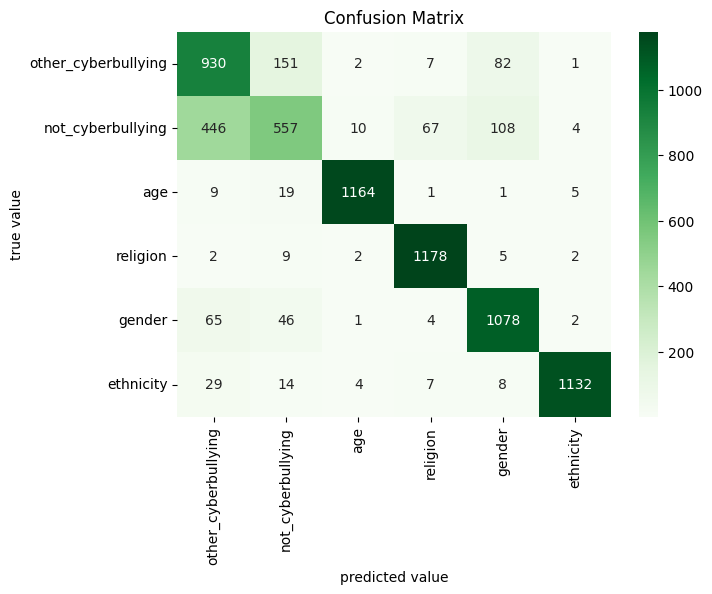

In [ ]:

y_true = cyb_test.loc[:, 'label']
X_test = pd.DataFrame(cyb_test.apply(create_test_prompt, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("Cyber bullying  prediction  without Aggression")
evaluate(y_true, y_pred)

In [ ]:

def generate_test_prompt_agg_detail_v1(row):
    confidence = row['confidence_agg']
    agg_type = row['predictions_agg']

    if confidence >= 0.70:
        if agg_type == 'not aggressive':
            aux_info = f"Aggression analysis: not aggressive (confidence: {confidence:.2f}) "
        elif agg_type == 'covertly aggressive':
            aux_info = f"Aggression analysis: covertly aggressive (confidence:{confidence:.2f})"
        elif agg_type == 'overtly aggressive':
            aux_info = f"Aggression analysis: overtly aggressive (confidence: {confidence:.2f})"
        else:
            aux_info = "Not provided"
    else:
        aux_info = "Not provided"

    return f"""You are a strict cyber bullying text classifier. Classify cyberbullying text by PRIMARY target group:

- age: Age-based discrimination, attacks on minors/elderly
- religion: Attacks on religious groups/beliefs
- gender: Sexism, homophobia, rape jokes
- ethnicity: Racism, racial slurs
- not_cyberbullying: Normal conversation
- other_cyberbullying: General harassment

TEXT: "{row['text']}"

Auxiliary information: {aux_info}

CLASSIFICATION: """.strip()

  0%|          | 1/7152 [00:00<54:10,  2.20it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 2/7152 [00:01<1:36:43,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  0%|          | 3/7152 [00:01<1:16:52,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 4/7152 [00:02<1:07:38,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 5/7152 [00:02<1:02:21,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 6/7152 [00:03<1:23:59,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  0%|          | 7/7152 [00:04<1:15:24,  1.58it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 8/7152 [00:04<1:08:18,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 9/7152 [00:05<1:03:29,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 10/7152 [00:06<1:23:14,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  0%|          | 11/7152 [00:07<1:36:11,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  0%|          | 12/7152 [00:08<1:46:03,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  0%|          | 13/7152 [00:08<1:30:04,  1.32it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 14/7152 [00:10<1:41:23,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  0%|          | 15/7152 [00:10<1:27:06,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 16/7152 [00:10<1:16:50,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 17/7152 [00:11<1:31:34,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  0%|          | 18/7152 [00:13<1:42:26,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  0%|          | 19/7152 [00:13<1:28:31,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 20/7152 [00:13<1:17:54,  1.53it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 21/7152 [00:14<1:10:32,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 22/7152 [00:14<1:05:18,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 23/7152 [00:15<1:01:31,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 24/7152 [00:15<58:56,  2.02it/s]  Device set to use cuda:0


Predicted answer: age


  0%|          | 25/7152 [00:16<57:16,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 26/7152 [00:16<55:53,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 27/7152 [00:17<55:02,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 28/7152 [00:17<54:26,  2.18it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 29/7152 [00:17<54:04,  2.20it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 30/7152 [00:18<54:28,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


  0%|          | 31/7152 [00:18<54:03,  2.20it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 32/7152 [00:19<53:46,  2.21it/s]Device set to use cuda:0


Predicted answer: age


  0%|          | 33/7152 [00:19<53:33,  2.22it/s]Device set to use cuda:0


Predicted answer: gender


  0%|          | 34/7152 [00:20<53:01,  2.24it/s]Device set to use cuda:0


Predicted answer: religion


  0%|          | 35/7152 [00:20<53:16,  2.23it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 36/7152 [00:21<1:16:03,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 37/7152 [00:22<1:09:27,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 38/7152 [00:23<1:26:31,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 39/7152 [00:23<1:16:29,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 40/7152 [00:24<1:31:39,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 41/7152 [00:25<1:20:01,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 42/7152 [00:25<1:11:41,  1.65it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 43/7152 [00:26<1:06:11,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 44/7152 [00:26<1:02:08,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 45/7152 [00:27<58:59,  2.01it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 46/7152 [00:27<57:04,  2.08it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 47/7152 [00:27<55:40,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 48/7152 [00:29<1:17:11,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  1%|          | 49/7152 [00:30<1:31:22,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 50/7152 [00:30<1:20:11,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 51/7152 [00:30<1:11:52,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 52/7152 [00:31<1:06:24,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 53/7152 [00:31<1:02:18,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 54/7152 [00:32<59:35,  1.99it/s]  Device set to use cuda:0


Predicted answer: gender


  1%|          | 55/7152 [00:32<57:32,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 56/7152 [00:33<56:14,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 57/7152 [00:33<55:14,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 58/7152 [00:34<54:28,  2.17it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 59/7152 [00:34<54:18,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 60/7152 [00:35<53:49,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 61/7152 [00:35<53:36,  2.20it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 62/7152 [00:35<53:19,  2.22it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 63/7152 [00:36<53:15,  2.22it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 64/7152 [00:36<53:04,  2.23it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 65/7152 [00:37<1:14:34,  1.58it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 66/7152 [00:38<1:07:55,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 67/7152 [00:38<1:03:08,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 68/7152 [00:39<59:58,  1.97it/s]  Device set to use cuda:0


Predicted answer: religion


  1%|          | 69/7152 [00:39<57:51,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 70/7152 [00:40<56:10,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 71/7152 [00:40<55:22,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 72/7152 [00:40<54:29,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 73/7152 [00:41<53:46,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 74/7152 [00:41<53:24,  2.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 75/7152 [00:42<1:15:01,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 76/7152 [00:43<1:08:33,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


  1%|          | 77/7152 [00:43<1:03:48,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 78/7152 [00:44<1:22:08,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  1%|          | 79/7152 [00:45<1:34:49,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  1%|          | 80/7152 [00:46<1:43:47,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  1%|          | 81/7152 [00:48<1:49:58,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 82/7152 [00:48<1:32:47,  1.27it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 83/7152 [00:48<1:20:38,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


  1%|          | 84/7152 [00:49<1:12:17,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|          | 85/7152 [00:50<1:28:02,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 86/7152 [00:51<1:39:00,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 87/7152 [00:51<1:25:01,  1.38it/s]Device set to use cuda:0


Predicted answer: age


  1%|          | 88/7152 [00:53<1:37:15,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|          | 89/7152 [00:54<1:45:28,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|▏         | 90/7152 [00:55<1:52:24,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|▏         | 91/7152 [00:55<1:34:27,  1.25it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 92/7152 [00:56<1:21:57,  1.44it/s]Device set to use cuda:0


Predicted answer: age


  1%|▏         | 93/7152 [00:57<1:34:03,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|▏         | 94/7152 [00:57<1:21:14,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 95/7152 [00:57<1:12:14,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


  1%|▏         | 96/7152 [00:58<1:07:02,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|▏         | 97/7152 [00:58<1:02:34,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 98/7152 [00:59<59:39,  1.97it/s]  Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 99/7152 [00:59<57:32,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


  1%|▏         | 100/7152 [01:00<1:17:32,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  1%|▏         | 101/7152 [01:01<1:10:03,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 102/7152 [01:01<1:04:51,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


  1%|▏         | 103/7152 [01:02<1:01:09,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


  1%|▏         | 104/7152 [01:02<58:39,  2.00it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  1%|▏         | 105/7152 [01:03<56:51,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 106/7152 [01:03<55:40,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


  1%|▏         | 107/7152 [01:03<54:38,  2.15it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 108/7152 [01:05<1:15:18,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 109/7152 [01:06<1:30:06,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 110/7152 [01:06<1:19:39,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 111/7152 [01:07<1:33:12,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 112/7152 [01:08<1:42:49,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 113/7152 [01:09<1:27:44,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 114/7152 [01:10<1:38:34,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 115/7152 [01:10<1:24:41,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 116/7152 [01:11<1:15:00,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 117/7152 [01:11<1:08:13,  1.72it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 118/7152 [01:11<1:03:32,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 119/7152 [01:12<1:00:27,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 120/7152 [01:12<58:00,  2.02it/s]  Device set to use cuda:0


Predicted answer: age


  2%|▏         | 121/7152 [01:13<56:35,  2.07it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 122/7152 [01:14<1:17:03,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 123/7152 [01:15<1:31:36,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 124/7152 [01:16<1:42:35,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 125/7152 [01:17<1:28:14,  1.33it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 126/7152 [01:17<1:17:32,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 127/7152 [01:18<1:31:31,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 128/7152 [01:19<1:19:25,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 129/7152 [01:19<1:11:16,  1.64it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 130/7152 [01:20<1:27:04,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 131/7152 [01:20<1:16:18,  1.53it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 132/7152 [01:21<1:09:02,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 133/7152 [01:21<1:04:07,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 134/7152 [01:22<1:01:53,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 135/7152 [01:22<58:56,  1.98it/s]  Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 136/7152 [01:23<56:53,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 137/7152 [01:24<1:17:05,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 138/7152 [01:25<1:31:22,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 139/7152 [01:26<1:41:08,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 140/7152 [01:27<1:48:05,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 141/7152 [01:28<1:52:34,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 142/7152 [01:28<1:34:14,  1.24it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 143/7152 [01:30<1:43:04,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 144/7152 [01:30<1:27:51,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 145/7152 [01:31<1:39:53,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 146/7152 [01:32<1:47:06,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 147/7152 [01:33<1:30:43,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 148/7152 [01:33<1:19:10,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 149/7152 [01:34<1:32:25,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 150/7152 [01:35<1:20:22,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 151/7152 [01:35<1:11:48,  1.63it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 152/7152 [01:35<1:05:41,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 153/7152 [01:36<1:22:52,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 154/7152 [01:37<1:13:32,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


  2%|▏         | 155/7152 [01:37<1:07:09,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 156/7152 [01:38<1:02:38,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 157/7152 [01:39<1:20:50,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 158/7152 [01:39<1:12:16,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 159/7152 [01:40<1:06:12,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 160/7152 [01:41<1:23:09,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 161/7152 [01:41<1:13:36,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 162/7152 [01:42<1:28:27,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 163/7152 [01:43<1:39:36,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 164/7152 [01:44<1:25:18,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 165/7152 [01:45<1:38:01,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 166/7152 [01:45<1:25:11,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 167/7152 [01:46<1:15:15,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 168/7152 [01:46<1:08:12,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 169/7152 [01:47<1:03:38,  1.83it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 170/7152 [01:48<1:21:24,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  2%|▏         | 171/7152 [01:48<1:12:28,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 172/7152 [01:49<1:06:18,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 173/7152 [01:50<1:28:09,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 174/7152 [01:50<1:17:17,  1.50it/s]Device set to use cuda:0


Predicted answer: age


  2%|▏         | 175/7152 [01:51<1:30:57,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  2%|▏         | 176/7152 [01:52<1:19:16,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


  2%|▏         | 177/7152 [01:52<1:11:01,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


  2%|▏         | 178/7152 [01:53<1:05:16,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 179/7152 [01:54<1:22:41,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 180/7152 [01:55<1:34:37,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 181/7152 [01:55<1:21:40,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 182/7152 [01:56<1:12:45,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 183/7152 [01:56<1:06:27,  1.75it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 184/7152 [01:57<1:23:21,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 185/7152 [01:58<1:14:11,  1.57it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 186/7152 [01:59<1:28:46,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 187/7152 [02:00<1:38:55,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 188/7152 [02:00<1:24:44,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 189/7152 [02:01<1:14:49,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 190/7152 [02:01<1:07:33,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 191/7152 [02:02<1:03:09,  1.84it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 192/7152 [02:02<59:57,  1.93it/s]  Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 193/7152 [02:03<57:20,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 194/7152 [02:03<55:35,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 195/7152 [02:03<54:18,  2.14it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 196/7152 [02:04<54:15,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 197/7152 [02:04<53:32,  2.16it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 198/7152 [02:05<53:00,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 199/7152 [02:06<1:14:09,  1.56it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 200/7152 [02:07<1:31:04,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 201/7152 [02:07<1:19:15,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 202/7152 [02:08<1:32:42,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 203/7152 [02:10<1:42:08,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 204/7152 [02:10<1:26:57,  1.33it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 205/7152 [02:10<1:16:18,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 206/7152 [02:11<1:09:28,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 207/7152 [02:11<1:04:05,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 208/7152 [02:12<1:00:16,  1.92it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 209/7152 [02:12<57:36,  2.01it/s]  Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 210/7152 [02:13<56:44,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 211/7152 [02:13<55:56,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 212/7152 [02:14<54:36,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 213/7152 [02:14<53:36,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 214/7152 [02:15<1:15:55,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 215/7152 [02:16<1:30:16,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 216/7152 [02:17<1:18:45,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 217/7152 [02:18<1:32:22,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 218/7152 [02:18<1:23:37,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 219/7152 [02:19<1:16:31,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 220/7152 [02:19<1:12:21,  1.60it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 221/7152 [02:20<1:06:31,  1.74it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 222/7152 [02:20<1:02:03,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 223/7152 [02:21<59:06,  1.95it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 224/7152 [02:21<1:00:16,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 225/7152 [02:22<57:35,  2.00it/s]  Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 226/7152 [02:22<55:48,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 227/7152 [02:23<54:23,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 228/7152 [02:23<53:36,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 229/7152 [02:23<52:52,  2.18it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 230/7152 [02:24<52:20,  2.20it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 231/7152 [02:24<52:00,  2.22it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 232/7152 [02:25<51:27,  2.24it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 233/7152 [02:25<51:24,  2.24it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 234/7152 [02:26<1:15:36,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 235/7152 [02:28<1:34:14,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 236/7152 [02:29<1:42:16,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 237/7152 [02:29<1:27:04,  1.32it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 238/7152 [02:30<1:16:19,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


  3%|▎         | 239/7152 [02:31<1:30:05,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 240/7152 [02:31<1:18:48,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 241/7152 [02:32<1:33:53,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 242/7152 [02:33<1:21:38,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 243/7152 [02:33<1:13:19,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 244/7152 [02:34<1:27:37,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  3%|▎         | 245/7152 [02:35<1:16:38,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 246/7152 [02:35<1:09:36,  1.65it/s]Device set to use cuda:0


Predicted answer: age


  3%|▎         | 247/7152 [02:36<1:25:04,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  3%|▎         | 248/7152 [02:37<1:14:51,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


  3%|▎         | 249/7152 [02:37<1:07:43,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


  3%|▎         | 250/7152 [02:37<1:02:43,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▎         | 251/7152 [02:38<59:12,  1.94it/s]  Device set to use cuda:0


Predicted answer: gender


  4%|▎         | 252/7152 [02:39<1:19:54,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 253/7152 [02:40<1:33:06,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 254/7152 [02:41<1:20:37,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▎         | 255/7152 [02:42<1:32:45,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 256/7152 [02:43<1:41:51,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 257/7152 [02:44<1:53:14,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 258/7152 [02:45<1:55:36,  1.01s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 259/7152 [02:46<1:57:25,  1.02s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 260/7152 [02:47<1:58:47,  1.03s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 261/7152 [02:48<1:59:42,  1.04s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▎         | 262/7152 [02:49<2:03:41,  1.08s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▎         | 263/7152 [02:50<1:43:26,  1.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▎         | 264/7152 [02:50<1:30:48,  1.26it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▎         | 265/7152 [02:51<1:20:36,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▎         | 266/7152 [02:51<1:11:35,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▎         | 267/7152 [02:52<1:05:26,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▎         | 268/7152 [02:53<1:22:43,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 269/7152 [02:53<1:13:38,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 270/7152 [02:54<1:06:53,  1.71it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 271/7152 [02:54<1:02:06,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 272/7152 [02:55<58:56,  1.95it/s]  Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 273/7152 [02:55<56:57,  2.01it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 274/7152 [02:55<55:11,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 275/7152 [02:57<1:14:48,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 276/7152 [02:57<1:08:21,  1.68it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 277/7152 [02:58<1:24:07,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 278/7152 [02:59<1:38:36,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 279/7152 [03:00<1:26:35,  1.32it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 280/7152 [03:00<1:15:52,  1.51it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 281/7152 [03:01<1:08:38,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 282/7152 [03:02<1:24:21,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 283/7152 [03:02<1:14:21,  1.54it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 284/7152 [03:03<1:07:23,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 285/7152 [03:04<1:23:39,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 286/7152 [03:04<1:13:54,  1.55it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 287/7152 [03:04<1:07:06,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 288/7152 [03:05<1:03:14,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 289/7152 [03:05<59:32,  1.92it/s]  Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 290/7152 [03:06<57:19,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 291/7152 [03:07<1:17:25,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 292/7152 [03:08<1:12:51,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 293/7152 [03:09<1:27:27,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 294/7152 [03:09<1:19:26,  1.44it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 295/7152 [03:10<1:13:39,  1.55it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 296/7152 [03:10<1:06:52,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 297/7152 [03:11<1:25:48,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 298/7152 [03:12<1:15:47,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 299/7152 [03:12<1:09:46,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 300/7152 [03:13<1:04:58,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 301/7152 [03:13<1:01:04,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 302/7152 [03:14<1:00:56,  1.87it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 303/7152 [03:14<59:51,  1.91it/s]  Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 304/7152 [03:15<1:21:25,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  4%|▍         | 305/7152 [03:16<1:12:48,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 306/7152 [03:16<1:06:50,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 307/7152 [03:17<1:02:38,  1.82it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 308/7152 [03:17<59:20,  1.92it/s]  Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 309/7152 [03:18<56:49,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 310/7152 [03:18<55:26,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 311/7152 [03:18<54:03,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 312/7152 [03:19<53:22,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 313/7152 [03:19<52:44,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


  4%|▍         | 314/7152 [03:20<1:13:09,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  4%|▍         | 315/7152 [03:21<1:06:48,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 316/7152 [03:21<1:02:00,  1.84it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 317/7152 [03:22<58:38,  1.94it/s]  Device set to use cuda:0


Predicted answer: gender


  4%|▍         | 318/7152 [03:22<56:22,  2.02it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 319/7152 [03:23<54:52,  2.08it/s]Device set to use cuda:0


Predicted answer: age


  4%|▍         | 320/7152 [03:23<53:42,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


  4%|▍         | 321/7152 [03:24<52:47,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 322/7152 [03:24<52:25,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 323/7152 [03:25<1:12:22,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 324/7152 [03:26<1:05:54,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 325/7152 [03:27<1:22:46,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 326/7152 [03:27<1:13:33,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 327/7152 [03:28<1:29:01,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 328/7152 [03:29<1:17:38,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▍         | 329/7152 [03:29<1:09:38,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 330/7152 [03:29<1:03:54,  1.78it/s]Device set to use cuda:0


Predicted answer: age


  5%|▍         | 331/7152 [03:31<1:21:07,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 332/7152 [03:31<1:12:10,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 333/7152 [03:32<1:26:26,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 334/7152 [03:33<1:37:21,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 335/7152 [03:34<1:24:12,  1.35it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▍         | 336/7152 [03:34<1:14:27,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 337/7152 [03:35<1:28:16,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 338/7152 [03:36<1:17:36,  1.46it/s]Device set to use cuda:0


Predicted answer: age


  5%|▍         | 339/7152 [03:36<1:09:14,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▍         | 340/7152 [03:36<1:03:16,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▍         | 341/7152 [03:38<1:20:15,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 342/7152 [03:39<1:32:10,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 343/7152 [03:40<1:40:41,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 344/7152 [03:40<1:25:39,  1.32it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 345/7152 [03:41<1:36:31,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 346/7152 [03:42<1:43:35,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 347/7152 [03:43<1:27:43,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▍         | 348/7152 [03:44<1:37:26,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 349/7152 [03:45<1:44:25,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 350/7152 [03:46<1:49:10,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 351/7152 [03:47<1:52:29,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▍         | 352/7152 [03:47<1:33:49,  1.21it/s]Device set to use cuda:0


Predicted answer: age


  5%|▍         | 353/7152 [03:48<1:20:41,  1.40it/s]Device set to use cuda:0


Predicted answer: age


  5%|▍         | 354/7152 [03:49<1:32:28,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 355/7152 [03:49<1:20:00,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▍         | 356/7152 [03:50<1:32:01,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▍         | 357/7152 [03:51<1:19:59,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 358/7152 [03:52<1:32:01,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▌         | 359/7152 [03:52<1:20:05,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▌         | 360/7152 [03:53<1:32:06,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 361/7152 [03:54<1:19:34,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 362/7152 [03:55<1:31:40,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 363/7152 [03:55<1:19:31,  1.42it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 364/7152 [03:56<1:31:45,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▌         | 365/7152 [03:57<1:20:32,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▌         | 366/7152 [03:57<1:11:28,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▌         | 367/7152 [03:58<1:05:26,  1.73it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 368/7152 [03:59<1:21:48,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 369/7152 [04:00<1:33:25,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 370/7152 [04:01<1:41:51,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 371/7152 [04:02<1:47:54,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 372/7152 [04:03<1:30:51,  1.24it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 373/7152 [04:04<1:40:01,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 374/7152 [04:05<1:46:16,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 375/7152 [04:05<1:29:35,  1.26it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 376/7152 [04:06<1:38:38,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▌         | 377/7152 [04:07<1:24:12,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 378/7152 [04:07<1:14:12,  1.52it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 379/7152 [04:08<1:07:07,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


  5%|▌         | 380/7152 [04:08<1:02:00,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 381/7152 [04:08<58:23,  1.93it/s]  Device set to use cuda:0


Predicted answer: gender


  5%|▌         | 382/7152 [04:09<56:12,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


  5%|▌         | 383/7152 [04:09<54:31,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 384/7152 [04:10<1:14:12,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 385/7152 [04:11<1:07:06,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 386/7152 [04:12<1:23:04,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 387/7152 [04:13<1:34:38,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  5%|▌         | 388/7152 [04:13<1:21:38,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 389/7152 [04:15<1:33:50,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  5%|▌         | 390/7152 [04:15<1:21:02,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


  5%|▌         | 391/7152 [04:15<1:12:37,  1.55it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 392/7152 [04:16<1:06:39,  1.69it/s]Device set to use cuda:0


Predicted answer: age


  5%|▌         | 393/7152 [04:16<1:01:45,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 394/7152 [04:17<1:19:38,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 395/7152 [04:18<1:10:56,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 396/7152 [04:18<1:04:43,  1.74it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 397/7152 [04:19<1:00:41,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 398/7152 [04:20<1:18:21,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 399/7152 [04:20<1:09:50,  1.61it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 400/7152 [04:21<1:24:54,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 401/7152 [04:22<1:14:34,  1.51it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 402/7152 [04:23<1:28:07,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 403/7152 [04:24<1:38:13,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 404/7152 [04:24<1:23:50,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 405/7152 [04:25<1:13:50,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 406/7152 [04:25<1:06:45,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 407/7152 [04:26<1:22:37,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 408/7152 [04:27<1:13:08,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 409/7152 [04:28<1:26:19,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 410/7152 [04:29<1:35:51,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 411/7152 [04:29<1:22:08,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 412/7152 [04:30<1:12:18,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 413/7152 [04:30<1:05:25,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 414/7152 [04:31<1:00:44,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 415/7152 [04:31<57:35,  1.95it/s]  Device set to use cuda:0


Predicted answer: age


  6%|▌         | 416/7152 [04:32<1:15:59,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 417/7152 [04:33<1:29:00,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 418/7152 [04:34<1:17:14,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 419/7152 [04:34<1:09:11,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 420/7152 [04:35<1:24:23,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 421/7152 [04:36<1:14:06,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 422/7152 [04:36<1:06:53,  1.68it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 423/7152 [04:37<1:01:46,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 424/7152 [04:37<58:41,  1.91it/s]  Device set to use cuda:0


Predicted answer: age


  6%|▌         | 425/7152 [04:38<1:16:55,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 426/7152 [04:39<1:29:07,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 427/7152 [04:40<1:17:21,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 428/7152 [04:40<1:09:16,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 429/7152 [04:41<1:24:02,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 430/7152 [04:42<1:34:17,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 431/7152 [04:43<1:21:05,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 432/7152 [04:44<1:32:25,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 433/7152 [04:44<1:19:39,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 434/7152 [04:45<1:31:32,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 435/7152 [04:46<1:19:06,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 436/7152 [04:46<1:10:23,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 437/7152 [04:47<1:24:59,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 438/7152 [04:48<1:14:38,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 439/7152 [04:48<1:07:11,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 440/7152 [04:49<1:22:42,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▌         | 441/7152 [04:50<1:13:06,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▌         | 442/7152 [04:51<1:26:39,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▌         | 443/7152 [04:51<1:16:01,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▌         | 444/7152 [04:52<1:08:04,  1.64it/s]Device set to use cuda:0


Predicted answer: age


  6%|▌         | 445/7152 [04:52<1:02:26,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▌         | 446/7152 [04:52<58:33,  1.91it/s]  Device set to use cuda:0


Predicted answer: religion


  6%|▋         | 447/7152 [04:53<56:58,  1.96it/s]Device set to use cuda:0


Predicted answer: age


  6%|▋         | 448/7152 [04:53<54:52,  2.04it/s]Device set to use cuda:0


Predicted answer: age


  6%|▋         | 449/7152 [04:54<1:13:41,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 450/7152 [04:55<1:07:07,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▋         | 451/7152 [04:56<1:22:26,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▋         | 452/7152 [04:57<1:33:04,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▋         | 453/7152 [04:58<1:40:54,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 454/7152 [04:58<1:25:34,  1.30it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▋         | 455/7152 [05:00<1:35:41,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  6%|▋         | 456/7152 [05:00<1:21:53,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▋         | 457/7152 [05:01<1:33:08,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 458/7152 [05:02<1:20:04,  1.39it/s]Device set to use cuda:0


Predicted answer: age


  6%|▋         | 459/7152 [05:03<1:31:33,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 460/7152 [05:03<1:19:11,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


  6%|▋         | 461/7152 [05:03<1:10:05,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


  6%|▋         | 462/7152 [05:04<1:04:03,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


  6%|▋         | 463/7152 [05:05<1:20:28,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  6%|▋         | 464/7152 [05:05<1:11:25,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 465/7152 [05:06<1:05:37,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 466/7152 [05:07<1:21:41,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 467/7152 [05:07<1:12:13,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 468/7152 [05:08<1:26:06,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 469/7152 [05:10<1:36:32,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 470/7152 [05:10<1:22:37,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 471/7152 [05:10<1:12:59,  1.53it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 472/7152 [05:11<1:06:15,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 473/7152 [05:11<1:01:09,  1.82it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 474/7152 [05:12<1:18:25,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 475/7152 [05:13<1:10:30,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 476/7152 [05:14<1:25:15,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 477/7152 [05:15<1:35:34,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 478/7152 [05:15<1:21:40,  1.36it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 479/7152 [05:16<1:12:13,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 480/7152 [05:16<1:05:41,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 481/7152 [05:17<1:21:03,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 482/7152 [05:18<1:31:24,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 483/7152 [05:19<1:18:57,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 484/7152 [05:19<1:10:02,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 485/7152 [05:20<1:03:44,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 486/7152 [05:21<1:19:39,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 487/7152 [05:21<1:10:38,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 488/7152 [05:22<1:04:41,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 489/7152 [05:22<59:54,  1.85it/s]  Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 490/7152 [05:23<56:42,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 491/7152 [05:23<54:54,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 492/7152 [05:24<53:22,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 493/7152 [05:25<1:12:46,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 494/7152 [05:25<1:06:01,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 495/7152 [05:26<1:01:09,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 496/7152 [05:26<57:52,  1.92it/s]  Device set to use cuda:0


Predicted answer: age


  7%|▋         | 497/7152 [05:26<55:22,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 498/7152 [05:27<1:13:46,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 499/7152 [05:29<1:26:53,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 500/7152 [05:29<1:15:44,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 501/7152 [05:29<1:07:47,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 502/7152 [05:30<1:02:30,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 503/7152 [05:31<1:19:30,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 504/7152 [05:31<1:10:31,  1.57it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 505/7152 [05:32<1:24:52,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 506/7152 [05:33<1:14:21,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 507/7152 [05:33<1:06:50,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 508/7152 [05:34<1:01:35,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 509/7152 [05:34<57:52,  1.91it/s]  Device set to use cuda:0


Predicted answer: age


  7%|▋         | 510/7152 [05:35<1:16:01,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 511/7152 [05:36<1:28:59,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 512/7152 [05:37<1:17:31,  1.43it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 513/7152 [05:37<1:09:14,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 514/7152 [05:38<1:24:01,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 515/7152 [05:39<1:34:09,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 516/7152 [05:40<1:21:01,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 517/7152 [05:40<1:11:19,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 518/7152 [05:41<1:04:32,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 519/7152 [05:42<1:19:47,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 520/7152 [05:42<1:10:24,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 521/7152 [05:43<1:24:16,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 522/7152 [05:44<1:13:51,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


  7%|▋         | 523/7152 [05:45<1:27:07,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 524/7152 [05:46<1:36:45,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 525/7152 [05:46<1:22:33,  1.34it/s]Device set to use cuda:0


Predicted answer: age


  7%|▋         | 526/7152 [05:47<1:12:42,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 527/7152 [05:48<1:25:51,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 528/7152 [05:48<1:14:52,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


  7%|▋         | 529/7152 [05:49<1:07:29,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


  7%|▋         | 530/7152 [05:50<1:22:29,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 531/7152 [05:51<1:33:53,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 532/7152 [05:52<1:41:09,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 533/7152 [05:53<1:45:51,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 534/7152 [05:54<1:49:07,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  7%|▋         | 535/7152 [05:55<1:51:45,  1.01s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


  7%|▋         | 536/7152 [05:56<1:32:59,  1.19it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 537/7152 [05:57<1:40:07,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 538/7152 [05:57<1:24:49,  1.30it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 539/7152 [05:58<1:14:05,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 540/7152 [05:59<1:26:45,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 541/7152 [05:59<1:15:58,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 542/7152 [06:00<1:07:56,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 543/7152 [06:00<1:02:35,  1.76it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 544/7152 [06:01<1:18:58,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 545/7152 [06:02<1:10:12,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 546/7152 [06:02<1:03:58,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 547/7152 [06:02<59:34,  1.85it/s]  Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 548/7152 [06:03<56:37,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 549/7152 [06:03<54:28,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 550/7152 [06:04<52:54,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 551/7152 [06:04<51:51,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 552/7152 [06:05<50:46,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 553/7152 [06:05<50:08,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 554/7152 [06:06<1:09:57,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 555/7152 [06:07<1:04:03,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 556/7152 [06:08<1:19:44,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 557/7152 [06:08<1:10:29,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 558/7152 [06:09<1:24:33,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 559/7152 [06:10<1:34:13,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 560/7152 [06:11<1:20:43,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 561/7152 [06:11<1:11:11,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 562/7152 [06:12<1:04:40,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 563/7152 [06:12<1:00:01,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 564/7152 [06:13<56:48,  1.93it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 565/7152 [06:14<1:15:16,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 566/7152 [06:14<1:07:25,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 567/7152 [06:14<1:01:52,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 568/7152 [06:15<58:06,  1.89it/s]  Device set to use cuda:0


Predicted answer: age


  8%|▊         | 569/7152 [06:15<55:36,  1.97it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 570/7152 [06:16<53:37,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 571/7152 [06:16<52:16,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 572/7152 [06:17<51:23,  2.13it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 573/7152 [06:17<52:27,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 574/7152 [06:18<51:27,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 575/7152 [06:18<51:01,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 576/7152 [06:19<1:11:16,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 577/7152 [06:20<1:04:33,  1.70it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 578/7152 [06:20<59:55,  1.83it/s]  Device set to use cuda:0


Predicted answer: age


  8%|▊         | 579/7152 [06:21<56:45,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 580/7152 [06:21<54:56,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 581/7152 [06:22<1:13:14,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 582/7152 [06:23<1:06:01,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 583/7152 [06:23<1:00:57,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 584/7152 [06:23<57:37,  1.90it/s]  Device set to use cuda:0


Predicted answer: age


  8%|▊         | 585/7152 [06:24<1:15:00,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 586/7152 [06:25<1:07:41,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 587/7152 [06:26<1:22:02,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 588/7152 [06:27<1:32:36,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 589/7152 [06:28<1:39:34,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  8%|▊         | 590/7152 [06:29<1:24:16,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 591/7152 [06:30<1:34:16,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 592/7152 [06:30<1:20:57,  1.35it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 593/7152 [06:31<1:11:14,  1.53it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 594/7152 [06:31<1:04:50,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 595/7152 [06:31<1:00:01,  1.82it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 596/7152 [06:32<56:52,  1.92it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 597/7152 [06:32<54:35,  2.00it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 598/7152 [06:33<53:08,  2.06it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 599/7152 [06:33<51:52,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


  8%|▊         | 600/7152 [06:34<51:05,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 601/7152 [06:34<51:48,  2.11it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 602/7152 [06:35<50:59,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 603/7152 [06:36<1:10:46,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  8%|▊         | 604/7152 [06:36<1:04:15,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


  8%|▊         | 605/7152 [06:37<59:44,  1.83it/s]  Device set to use cuda:0


Predicted answer: religion


  8%|▊         | 606/7152 [06:37<56:37,  1.93it/s]Device set to use cuda:0


Predicted answer: age


  8%|▊         | 607/7152 [06:38<1:14:23,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 608/7152 [06:39<1:06:45,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▊         | 609/7152 [06:39<1:01:24,  1.78it/s]Device set to use cuda:0


Predicted answer: age


  9%|▊         | 610/7152 [06:40<57:41,  1.89it/s]  Device set to use cuda:0


Predicted answer: gender


  9%|▊         | 611/7152 [06:40<55:10,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▊         | 612/7152 [06:41<1:14:17,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 613/7152 [06:41<1:06:38,  1.64it/s]Device set to use cuda:0


Predicted answer: age


  9%|▊         | 614/7152 [06:42<1:01:31,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▊         | 615/7152 [06:42<57:56,  1.88it/s]  Device set to use cuda:0


Predicted answer: gender


  9%|▊         | 616/7152 [06:43<1:15:55,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 617/7152 [06:44<1:07:54,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▊         | 618/7152 [06:44<1:02:10,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▊         | 619/7152 [06:45<1:18:14,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 620/7152 [06:47<1:29:34,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▊         | 621/7152 [06:48<1:37:51,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▊         | 622/7152 [06:48<1:23:12,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▊         | 623/7152 [06:49<1:33:25,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 624/7152 [06:50<1:39:35,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▊         | 625/7152 [06:51<1:24:12,  1.29it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 626/7152 [06:51<1:14:11,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 627/7152 [06:52<1:06:43,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 628/7152 [06:52<1:01:57,  1.75it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 629/7152 [06:52<58:30,  1.86it/s]  Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 630/7152 [06:53<55:39,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 631/7152 [06:53<53:33,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 632/7152 [06:54<52:27,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 633/7152 [06:55<1:12:20,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 634/7152 [06:55<1:05:26,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 635/7152 [06:56<1:20:19,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 636/7152 [06:57<1:11:02,  1.53it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 637/7152 [06:57<1:04:52,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 638/7152 [06:58<1:00:12,  1.80it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 639/7152 [06:58<56:52,  1.91it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 640/7152 [06:59<54:42,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


  9%|▉         | 641/7152 [07:00<1:13:09,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 642/7152 [07:00<1:05:59,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 643/7152 [07:01<1:00:52,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 644/7152 [07:01<57:27,  1.89it/s]  Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 645/7152 [07:02<1:15:06,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 646/7152 [07:03<1:07:21,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 647/7152 [07:03<1:01:50,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 648/7152 [07:04<1:17:45,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 649/7152 [07:05<1:29:45,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 650/7152 [07:06<1:37:38,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 651/7152 [07:07<1:43:43,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 652/7152 [07:08<1:27:08,  1.24it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 653/7152 [07:09<1:35:33,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 654/7152 [07:10<1:41:33,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 655/7152 [07:11<1:46:48,  1.01it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 656/7152 [07:12<1:29:42,  1.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 657/7152 [07:13<1:37:32,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 658/7152 [07:14<1:43:16,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 659/7152 [07:14<1:26:50,  1.25it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 660/7152 [07:15<1:15:25,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 661/7152 [07:16<1:27:46,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 662/7152 [07:16<1:16:14,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 663/7152 [07:17<1:07:59,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 664/7152 [07:17<1:02:07,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 665/7152 [07:18<1:17:52,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 666/7152 [07:19<1:08:48,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 667/7152 [07:20<1:22:39,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 668/7152 [07:20<1:12:24,  1.49it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 669/7152 [07:21<1:05:11,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 670/7152 [07:21<1:00:32,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


  9%|▉         | 671/7152 [07:22<1:16:46,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 672/7152 [07:22<1:08:27,  1.58it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 673/7152 [07:23<1:02:34,  1.73it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 674/7152 [07:23<58:48,  1.84it/s]  Device set to use cuda:0


Predicted answer: age


  9%|▉         | 675/7152 [07:24<56:10,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


  9%|▉         | 676/7152 [07:24<53:57,  2.00it/s]Device set to use cuda:0


Predicted answer: age


  9%|▉         | 677/7152 [07:25<1:12:28,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


  9%|▉         | 678/7152 [07:26<1:25:41,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


  9%|▉         | 679/7152 [07:27<1:14:33,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 10%|▉         | 680/7152 [07:28<1:26:16,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|▉         | 681/7152 [07:29<1:35:11,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 682/7152 [07:30<1:21:04,  1.33it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 683/7152 [07:31<1:31:03,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 684/7152 [07:31<1:18:26,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 685/7152 [07:32<1:29:38,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 686/7152 [07:33<1:17:28,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|▉         | 687/7152 [07:33<1:09:28,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 688/7152 [07:33<1:02:42,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|▉         | 689/7152 [07:34<58:30,  1.84it/s]  Device set to use cuda:0


Predicted answer: age


 10%|▉         | 690/7152 [07:35<1:15:51,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|▉         | 691/7152 [07:35<1:07:46,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 10%|▉         | 692/7152 [07:37<1:21:45,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 693/7152 [07:37<1:11:56,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 10%|▉         | 694/7152 [07:37<1:04:55,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 10%|▉         | 695/7152 [07:38<1:19:47,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 696/7152 [07:39<1:11:15,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 10%|▉         | 697/7152 [07:39<1:04:17,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 698/7152 [07:40<59:41,  1.80it/s]  Device set to use cuda:0


Predicted answer: age


 10%|▉         | 699/7152 [07:41<1:16:57,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 700/7152 [07:41<1:08:23,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 701/7152 [07:42<1:02:29,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|▉         | 702/7152 [07:43<1:18:24,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 703/7152 [07:44<1:29:25,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 704/7152 [07:45<1:36:42,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 705/7152 [07:46<1:22:02,  1.31it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 706/7152 [07:47<1:32:05,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 707/7152 [07:47<1:19:12,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 10%|▉         | 708/7152 [07:48<1:29:35,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 709/7152 [07:49<1:16:51,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|▉         | 710/7152 [07:50<1:27:31,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|▉         | 711/7152 [07:50<1:15:28,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 10%|▉         | 712/7152 [07:50<1:07:00,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 713/7152 [07:51<1:01:44,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 10%|▉         | 714/7152 [07:51<57:45,  1.86it/s]  Device set to use cuda:0


Predicted answer: gender


 10%|▉         | 715/7152 [07:52<54:59,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 716/7152 [07:52<52:58,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 717/7152 [07:53<51:30,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 718/7152 [07:53<50:33,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 719/7152 [07:54<49:55,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 720/7152 [07:54<49:20,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 721/7152 [07:55<48:59,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 722/7152 [07:55<49:05,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 723/7152 [07:56<1:08:35,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 724/7152 [07:57<1:21:55,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 725/7152 [07:58<1:12:11,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 726/7152 [07:59<1:25:14,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 727/7152 [08:00<1:35:08,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|█         | 728/7152 [08:00<1:21:05,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 729/7152 [08:01<1:31:04,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 730/7152 [08:02<1:18:02,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 10%|█         | 731/7152 [08:02<1:09:08,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 732/7152 [08:03<1:22:31,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 733/7152 [08:04<1:12:12,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 734/7152 [08:05<1:25:22,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 735/7152 [08:05<1:14:19,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 736/7152 [08:06<1:06:30,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 10%|█         | 737/7152 [08:06<1:00:50,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 738/7152 [08:07<56:44,  1.88it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 739/7152 [08:08<1:14:00,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|█         | 740/7152 [08:08<1:06:08,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 741/7152 [08:09<1:00:41,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 742/7152 [08:09<57:07,  1.87it/s]  Device set to use cuda:0


Predicted answer: gender


 10%|█         | 743/7152 [08:09<54:38,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 744/7152 [08:10<52:49,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 745/7152 [08:10<51:26,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 10%|█         | 746/7152 [08:11<1:09:56,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 10%|█         | 747/7152 [08:12<1:03:26,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 10%|█         | 748/7152 [08:12<58:54,  1.81it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 10%|█         | 749/7152 [08:13<1:16:21,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 10%|█         | 750/7152 [08:14<1:07:55,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 751/7152 [08:14<1:02:00,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 752/7152 [08:15<58:17,  1.83it/s]  Device set to use cuda:0


Predicted answer: religion


 11%|█         | 753/7152 [08:16<1:14:44,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 754/7152 [08:16<1:06:52,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 755/7152 [08:17<1:01:23,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 756/7152 [08:17<57:29,  1.85it/s]  Device set to use cuda:0


Predicted answer: religion


 11%|█         | 757/7152 [08:18<1:14:20,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 758/7152 [08:19<1:26:48,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 759/7152 [08:20<1:34:36,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 760/7152 [08:22<1:41:20,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 761/7152 [08:22<1:25:29,  1.25it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 762/7152 [08:22<1:14:23,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 763/7152 [08:23<1:06:42,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 764/7152 [08:23<1:01:12,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 765/7152 [08:24<57:15,  1.86it/s]  Device set to use cuda:0


Predicted answer: gender


 11%|█         | 766/7152 [08:25<1:14:25,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 767/7152 [08:25<1:06:32,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 768/7152 [08:26<1:20:48,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 769/7152 [08:27<1:11:01,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 770/7152 [08:27<1:04:19,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 771/7152 [08:28<1:19:00,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 772/7152 [08:29<1:09:58,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 773/7152 [08:29<1:03:14,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 774/7152 [08:30<59:21,  1.79it/s]  Device set to use cuda:0


Predicted answer: religion


 11%|█         | 775/7152 [08:30<56:02,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 776/7152 [08:31<53:49,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 777/7152 [08:31<52:25,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 778/7152 [08:32<51:23,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 779/7152 [08:32<50:40,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 780/7152 [08:32<49:27,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 781/7152 [08:34<1:08:03,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█         | 782/7152 [08:34<1:02:02,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 783/7152 [08:35<1:17:27,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 784/7152 [08:36<1:08:24,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 785/7152 [08:37<1:21:40,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 11%|█         | 786/7152 [08:37<1:11:36,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 787/7152 [08:37<1:04:06,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 788/7152 [08:38<59:15,  1.79it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 789/7152 [08:38<55:45,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 790/7152 [08:39<53:30,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 791/7152 [08:39<51:46,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 792/7152 [08:40<50:36,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 793/7152 [08:40<49:45,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 794/7152 [08:41<49:19,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 795/7152 [08:41<49:08,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 796/7152 [08:42<48:39,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 11%|█         | 797/7152 [08:42<48:31,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 798/7152 [08:42<48:09,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█         | 799/7152 [08:43<48:08,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█         | 800/7152 [08:43<48:12,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 801/7152 [08:44<48:06,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 802/7152 [08:44<48:02,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 803/7152 [08:45<48:14,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█         | 804/7152 [08:46<1:09:17,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█▏        | 805/7152 [08:46<1:02:45,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█▏        | 806/7152 [08:47<58:18,  1.81it/s]  Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 807/7152 [08:47<54:58,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█▏        | 808/7152 [08:48<52:36,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 11%|█▏        | 809/7152 [08:48<51:02,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█▏        | 810/7152 [08:49<49:50,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█▏        | 811/7152 [08:49<49:44,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 812/7152 [08:49<49:01,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 11%|█▏        | 813/7152 [08:50<48:33,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 814/7152 [08:50<48:07,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█▏        | 815/7152 [08:51<47:57,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█▏        | 816/7152 [08:51<47:46,  2.21it/s]Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 817/7152 [08:52<1:07:03,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█▏        | 818/7152 [08:53<1:02:17,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 819/7152 [08:53<57:52,  1.82it/s]  Device set to use cuda:0


Predicted answer: age


 11%|█▏        | 820/7152 [08:54<1:14:34,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 11%|█▏        | 821/7152 [08:55<1:06:19,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 11%|█▏        | 822/7152 [08:55<1:00:32,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 823/7152 [08:56<1:15:57,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 824/7152 [08:57<1:26:47,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 825/7152 [08:58<1:15:22,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 826/7152 [08:58<1:06:48,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 827/7152 [08:59<1:00:53,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 828/7152 [08:59<56:48,  1.86it/s]  Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 829/7152 [09:00<53:51,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 830/7152 [09:01<1:11:19,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 831/7152 [09:02<1:23:28,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 832/7152 [09:03<1:31:50,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 833/7152 [09:03<1:18:09,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 834/7152 [09:04<1:08:34,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 835/7152 [09:04<1:02:13,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 836/7152 [09:05<57:36,  1.83it/s]  Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 837/7152 [09:05<54:45,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 838/7152 [09:05<52:27,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 839/7152 [09:06<51:15,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 840/7152 [09:06<50:04,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 841/7152 [09:07<1:09:17,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 842/7152 [09:09<1:22:18,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 843/7152 [09:10<1:30:39,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 844/7152 [09:11<1:37:19,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 845/7152 [09:12<1:41:53,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 846/7152 [09:12<1:25:23,  1.23it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 847/7152 [09:13<1:13:30,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 848/7152 [09:13<1:05:20,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 849/7152 [09:13<59:34,  1.76it/s]  Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 850/7152 [09:14<55:49,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 851/7152 [09:15<1:12:22,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 852/7152 [09:16<1:23:54,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 853/7152 [09:16<1:12:44,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 854/7152 [09:18<1:24:21,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 855/7152 [09:18<1:13:14,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 856/7152 [09:18<1:05:20,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 857/7152 [09:19<59:49,  1.75it/s]  Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 858/7152 [09:19<55:47,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 859/7152 [09:20<53:28,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 860/7152 [09:20<51:40,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 861/7152 [09:21<50:06,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 862/7152 [09:22<1:08:33,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 863/7152 [09:23<1:21:48,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 864/7152 [09:23<1:11:47,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 865/7152 [09:24<1:24:06,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 866/7152 [09:25<1:32:32,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 867/7152 [09:26<1:18:53,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 868/7152 [09:26<1:09:11,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 869/7152 [09:27<1:02:27,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 870/7152 [09:27<57:49,  1.81it/s]  Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 871/7152 [09:28<54:34,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 872/7152 [09:29<1:11:44,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 873/7152 [09:29<1:04:20,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 874/7152 [09:30<59:03,  1.77it/s]  Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 875/7152 [09:30<55:26,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 876/7152 [09:31<1:12:26,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 877/7152 [09:32<1:04:55,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 878/7152 [09:32<59:38,  1.75it/s]  Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 879/7152 [09:33<55:46,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 880/7152 [09:33<53:17,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 12%|█▏        | 881/7152 [09:33<51:25,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 882/7152 [09:34<1:09:21,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 883/7152 [09:35<1:02:36,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▏        | 884/7152 [09:35<57:48,  1.81it/s]  Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 885/7152 [09:36<54:27,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 886/7152 [09:36<52:04,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 887/7152 [09:37<50:30,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 888/7152 [09:38<1:08:26,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 12%|█▏        | 889/7152 [09:38<1:01:53,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 890/7152 [09:39<1:16:16,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 12%|█▏        | 891/7152 [09:40<1:07:12,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 12%|█▏        | 892/7152 [09:40<1:01:02,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 12%|█▏        | 893/7152 [09:41<56:32,  1.84it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 12%|█▎        | 894/7152 [09:42<1:12:38,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 895/7152 [09:43<1:23:38,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 896/7152 [09:43<1:12:42,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 897/7152 [09:44<1:24:08,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 898/7152 [09:45<1:32:31,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 899/7152 [09:46<1:18:48,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 900/7152 [09:46<1:09:15,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 901/7152 [09:47<1:02:27,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 902/7152 [09:47<57:58,  1.80it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 903/7152 [09:48<54:32,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 904/7152 [09:48<52:56,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 905/7152 [09:48<51:33,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 906/7152 [09:50<1:10:03,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 907/7152 [09:50<1:03:00,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 908/7152 [09:51<59:36,  1.75it/s]  Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 909/7152 [09:51<55:51,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 910/7152 [09:51<53:09,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 911/7152 [09:52<51:28,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 912/7152 [09:52<49:42,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 913/7152 [09:53<1:07:09,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 914/7152 [09:54<1:01:20,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 915/7152 [09:54<56:46,  1.83it/s]  Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 916/7152 [09:55<53:55,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 917/7152 [09:55<52:52,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 918/7152 [09:56<50:54,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 919/7152 [09:56<49:29,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 920/7152 [09:57<48:31,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 921/7152 [09:58<1:06:47,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 922/7152 [09:59<1:19:38,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 923/7152 [10:00<1:28:19,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 924/7152 [10:00<1:15:29,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 925/7152 [10:01<1:06:53,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 926/7152 [10:01<1:01:41,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 927/7152 [10:02<1:16:03,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 928/7152 [10:04<1:40:13,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 929/7152 [10:04<1:24:01,  1.23it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 930/7152 [10:05<1:12:42,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 931/7152 [10:05<1:05:38,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 932/7152 [10:05<59:46,  1.73it/s]  Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 933/7152 [10:07<1:15:08,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 934/7152 [10:08<1:25:42,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 935/7152 [10:08<1:14:04,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 936/7152 [10:09<1:24:30,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 937/7152 [10:10<1:31:47,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 938/7152 [10:11<1:18:02,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 939/7152 [10:12<1:27:45,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 940/7152 [10:12<1:15:13,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 941/7152 [10:13<1:06:32,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 942/7152 [10:14<1:19:31,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 943/7152 [10:14<1:09:38,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 944/7152 [10:14<1:02:41,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 945/7152 [10:15<58:18,  1.77it/s]  Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 946/7152 [10:16<1:13:33,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 947/7152 [10:16<1:05:23,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 948/7152 [10:17<1:00:00,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 949/7152 [10:17<56:10,  1.84it/s]  Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 950/7152 [10:18<53:17,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 951/7152 [10:18<51:49,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 952/7152 [10:19<50:29,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 953/7152 [10:19<49:17,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 954/7152 [10:20<48:17,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 955/7152 [10:20<47:42,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 956/7152 [10:21<1:05:39,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 957/7152 [10:22<1:19:01,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 958/7152 [10:23<1:09:32,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 13%|█▎        | 959/7152 [10:24<1:21:53,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 13%|█▎        | 960/7152 [10:24<1:11:19,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 13%|█▎        | 961/7152 [10:25<1:03:51,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 962/7152 [10:26<1:17:04,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 13%|█▎        | 963/7152 [10:26<1:07:48,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 13%|█▎        | 964/7152 [10:27<1:01:27,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 13%|█▎        | 965/7152 [10:27<57:04,  1.81it/s]  Device set to use cuda:0


Predicted answer: age


 14%|█▎        | 966/7152 [10:28<1:13:14,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 14%|█▎        | 967/7152 [10:29<1:23:51,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 14%|█▎        | 968/7152 [10:30<1:12:14,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▎        | 969/7152 [10:31<1:23:46,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 970/7152 [10:31<1:12:27,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▎        | 971/7152 [10:32<1:23:36,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 972/7152 [10:33<1:12:17,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▎        | 973/7152 [10:34<1:23:51,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 974/7152 [10:34<1:12:25,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▎        | 975/7152 [10:35<1:23:14,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 976/7152 [10:36<1:11:55,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▎        | 977/7152 [10:36<1:03:57,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▎        | 978/7152 [10:37<58:26,  1.76it/s]  Device set to use cuda:0


Predicted answer: religion


 14%|█▎        | 979/7152 [10:38<1:12:57,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 980/7152 [10:39<1:22:58,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 981/7152 [10:40<1:30:07,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▎        | 982/7152 [10:40<1:16:45,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▎        | 983/7152 [10:41<1:26:26,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 14%|█▍        | 984/7152 [10:42<1:14:18,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 985/7152 [10:42<1:05:33,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 986/7152 [10:43<1:18:53,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 987/7152 [10:44<1:27:42,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 988/7152 [10:45<1:15:05,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 989/7152 [10:45<1:06:18,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 990/7152 [10:46<1:00:20,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 991/7152 [10:47<1:14:40,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 992/7152 [10:47<1:06:13,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 993/7152 [10:47<1:00:01,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 994/7152 [10:48<55:58,  1.83it/s]  Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 995/7152 [10:48<52:59,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 996/7152 [10:49<51:15,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 997/7152 [10:50<1:08:37,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 998/7152 [10:50<1:02:39,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 999/7152 [10:51<57:31,  1.78it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1000/7152 [10:52<1:12:20,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1001/7152 [10:53<1:23:53,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1002/7152 [10:54<1:31:24,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1003/7152 [10:54<1:18:03,  1.31it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1004/7152 [10:56<1:28:25,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1005/7152 [10:56<1:15:29,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1006/7152 [10:56<1:06:30,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1007/7152 [10:57<1:00:53,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1008/7152 [10:57<56:10,  1.82it/s]  Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1009/7152 [10:58<1:11:49,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1010/7152 [10:59<1:05:08,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1011/7152 [10:59<59:35,  1.72it/s]  Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1012/7152 [11:00<1:14:20,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1013/7152 [11:01<1:05:50,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1014/7152 [11:01<1:00:24,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1015/7152 [11:02<56:28,  1.81it/s]  Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1016/7152 [11:02<53:17,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1017/7152 [11:03<51:03,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1018/7152 [11:03<49:31,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1019/7152 [11:04<48:23,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1020/7152 [11:05<1:06:16,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1021/7152 [11:05<1:00:44,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1022/7152 [11:06<1:16:36,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 14%|█▍        | 1023/7152 [11:07<1:07:36,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1024/7152 [11:07<1:01:21,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1025/7152 [11:08<56:38,  1.80it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1026/7152 [11:09<1:12:51,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 14%|█▍        | 1027/7152 [11:09<1:04:46,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1028/7152 [11:10<58:58,  1.73it/s]  Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1029/7152 [11:10<54:52,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1030/7152 [11:10<51:46,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1031/7152 [11:11<50:29,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1032/7152 [11:11<49:04,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 14%|█▍        | 1033/7152 [11:12<48:01,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 14%|█▍        | 1034/7152 [11:12<47:14,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1035/7152 [11:13<46:55,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 14%|█▍        | 1036/7152 [11:13<46:39,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 14%|█▍        | 1037/7152 [11:14<46:16,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1038/7152 [11:14<46:19,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1039/7152 [11:15<45:55,  2.22it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1040/7152 [11:16<1:04:21,  1.58it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▍        | 1041/7152 [11:16<58:41,  1.74it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1042/7152 [11:16<54:42,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1043/7152 [11:17<51:59,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1044/7152 [11:17<50:28,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1045/7152 [11:18<49:00,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1046/7152 [11:19<1:06:52,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▍        | 1047/7152 [11:19<1:00:26,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1048/7152 [11:20<55:51,  1.82it/s]  Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1049/7152 [11:21<1:11:16,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1050/7152 [11:21<1:03:38,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1051/7152 [11:22<58:14,  1.75it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1052/7152 [11:22<54:21,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1053/7152 [11:23<1:10:28,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1054/7152 [11:24<1:02:54,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1055/7152 [11:24<57:46,  1.76it/s]  Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1056/7152 [11:25<1:12:48,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▍        | 1057/7152 [11:26<1:23:13,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1058/7152 [11:27<1:11:41,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1059/7152 [11:28<1:22:13,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▍        | 1060/7152 [11:29<1:29:54,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1061/7152 [11:29<1:16:34,  1.33it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1062/7152 [11:30<1:07:12,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1063/7152 [11:30<1:00:38,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▍        | 1064/7152 [11:31<56:19,  1.80it/s]  Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1065/7152 [11:31<53:10,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1066/7152 [11:32<50:44,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1067/7152 [11:32<49:12,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1068/7152 [11:32<48:13,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▍        | 1069/7152 [11:33<1:06:13,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▍        | 1070/7152 [11:34<1:00:15,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▍        | 1071/7152 [11:34<56:06,  1.81it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▍        | 1072/7152 [11:35<53:14,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1073/7152 [11:35<50:52,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1074/7152 [11:36<49:24,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 15%|█▌        | 1075/7152 [11:36<48:00,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1076/7152 [11:37<46:51,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1077/7152 [11:37<46:27,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1078/7152 [11:38<1:04:25,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▌        | 1079/7152 [11:39<58:46,  1.72it/s]  Device set to use cuda:0


Predicted answer: age


 15%|█▌        | 1080/7152 [11:40<1:14:44,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1081/7152 [11:40<1:05:51,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1082/7152 [11:41<59:53,  1.69it/s]  Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1083/7152 [11:41<56:02,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1084/7152 [11:42<1:12:20,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1085/7152 [11:43<1:04:25,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1086/7152 [11:44<1:17:10,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1087/7152 [11:44<1:07:30,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1088/7152 [11:45<1:19:10,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 15%|█▌        | 1089/7152 [11:46<1:27:29,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1090/7152 [11:47<1:14:32,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1091/7152 [11:47<1:05:39,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1092/7152 [11:48<59:29,  1.70it/s]  Device set to use cuda:0


Predicted answer: age


 15%|█▌        | 1093/7152 [11:48<55:08,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1094/7152 [11:48<52:21,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1095/7152 [11:50<1:08:28,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1096/7152 [11:50<1:01:50,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1097/7152 [11:50<56:46,  1.78it/s]  Device set to use cuda:0


Predicted answer: age


 15%|█▌        | 1098/7152 [11:51<54:17,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1099/7152 [11:52<1:09:53,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1100/7152 [11:52<1:02:40,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 15%|█▌        | 1101/7152 [11:53<57:37,  1.75it/s]  Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1102/7152 [11:54<1:12:43,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1103/7152 [11:54<1:04:36,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1104/7152 [11:55<58:48,  1.71it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 15%|█▌        | 1105/7152 [11:55<55:03,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 15%|█▌        | 1106/7152 [11:56<1:10:14,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1107/7152 [11:57<1:20:58,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 15%|█▌        | 1108/7152 [11:58<1:10:19,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1109/7152 [11:59<1:21:23,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1110/7152 [11:59<1:11:18,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1111/7152 [12:00<1:21:40,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1112/7152 [12:01<1:10:34,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1113/7152 [12:01<1:02:48,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1114/7152 [12:02<57:28,  1.75it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1115/7152 [12:03<1:11:55,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1116/7152 [12:03<1:03:43,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1117/7152 [12:04<57:54,  1.74it/s]  Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1118/7152 [12:04<53:51,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1119/7152 [12:05<1:09:29,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1120/7152 [12:06<1:02:07,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1121/7152 [12:06<56:52,  1.77it/s]  Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1122/7152 [12:07<1:11:27,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1123/7152 [12:08<1:03:32,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1124/7152 [12:08<57:54,  1.73it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1125/7152 [12:08<54:00,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1126/7152 [12:09<51:30,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1127/7152 [12:09<49:32,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1128/7152 [12:10<48:06,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1129/7152 [12:10<47:14,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1130/7152 [12:11<46:36,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1131/7152 [12:12<1:04:26,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1132/7152 [12:13<1:16:55,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1133/7152 [12:13<1:07:05,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1134/7152 [12:14<1:19:10,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1135/7152 [12:15<1:09:06,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1136/7152 [12:15<1:01:50,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1137/7152 [12:16<56:48,  1.76it/s]  Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1138/7152 [12:17<1:12:26,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1139/7152 [12:17<1:04:07,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1140/7152 [12:18<58:11,  1.72it/s]  Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1141/7152 [12:18<53:55,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1142/7152 [12:19<51:03,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1143/7152 [12:19<49:18,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1144/7152 [12:19<47:39,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1145/7152 [12:21<1:05:03,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1146/7152 [12:21<59:03,  1.70it/s]  Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1147/7152 [12:21<54:41,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1148/7152 [12:22<1:10:02,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1149/7152 [12:23<1:02:36,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1150/7152 [12:24<1:15:43,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1151/7152 [12:25<1:24:47,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1152/7152 [12:26<1:30:54,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▌        | 1153/7152 [12:27<1:17:03,  1.30it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1154/7152 [12:27<1:07:19,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▌        | 1155/7152 [12:27<1:00:28,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 16%|█▌        | 1156/7152 [12:28<1:14:21,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1157/7152 [12:29<1:05:42,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1158/7152 [12:29<59:26,  1.68it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▌        | 1159/7152 [12:30<1:13:10,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1160/7152 [12:31<1:04:40,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▌        | 1161/7152 [12:32<1:16:49,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▌        | 1162/7152 [12:32<1:07:10,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▋        | 1163/7152 [12:33<1:00:43,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▋        | 1164/7152 [12:33<55:36,  1.79it/s]  Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1165/7152 [12:34<52:03,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 16%|█▋        | 1166/7152 [12:35<1:07:46,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1167/7152 [12:35<1:00:50,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 16%|█▋        | 1168/7152 [12:36<55:44,  1.79it/s]  Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1169/7152 [12:37<1:10:31,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1170/7152 [12:38<1:20:39,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1171/7152 [12:38<1:09:37,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1172/7152 [12:39<1:21:40,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1173/7152 [12:40<1:10:32,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1174/7152 [12:41<1:21:43,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1175/7152 [12:42<1:29:03,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 16%|█▋        | 1176/7152 [12:43<1:34:04,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1177/7152 [12:44<1:38:58,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 16%|█▋        | 1178/7152 [12:45<1:22:38,  1.20it/s]Device set to use cuda:0


Predicted answer: gender


 16%|█▋        | 1179/7152 [12:45<1:11:09,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 16%|█▋        | 1180/7152 [12:45<1:02:55,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1181/7152 [12:46<58:05,  1.71it/s]  Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1182/7152 [12:46<54:33,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1183/7152 [12:47<51:44,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1184/7152 [12:47<49:27,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1185/7152 [12:48<1:06:05,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1186/7152 [12:49<59:37,  1.67it/s]  Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1187/7152 [12:50<1:13:47,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1188/7152 [12:50<1:04:53,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1189/7152 [12:51<1:17:10,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1190/7152 [12:52<1:07:24,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1191/7152 [12:53<1:19:36,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1192/7152 [12:53<1:08:50,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1193/7152 [12:54<1:02:14,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1194/7152 [12:54<56:50,  1.75it/s]  Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1195/7152 [12:55<1:11:47,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1196/7152 [12:56<1:03:33,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1197/7152 [12:56<57:44,  1.72it/s]  Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1198/7152 [12:57<53:50,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1199/7152 [12:58<1:10:47,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1200/7152 [12:58<1:02:51,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1201/7152 [12:59<1:15:28,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1202/7152 [13:00<1:25:11,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1203/7152 [13:01<1:31:12,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1204/7152 [13:02<1:35:13,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1205/7152 [13:04<1:38:57,  1.00it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1206/7152 [13:04<1:22:45,  1.20it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1207/7152 [13:04<1:11:21,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1208/7152 [13:06<1:21:03,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1209/7152 [13:06<1:09:46,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1210/7152 [13:06<1:01:50,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1211/7152 [13:07<1:14:41,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1212/7152 [13:08<1:05:38,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1213/7152 [13:09<1:17:09,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1214/7152 [13:09<1:06:54,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1215/7152 [13:10<1:18:11,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1216/7152 [13:11<1:08:18,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1217/7152 [13:11<1:01:04,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1218/7152 [13:12<1:14:34,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1219/7152 [13:13<1:23:34,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1220/7152 [13:14<1:11:49,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1221/7152 [13:15<1:21:49,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1222/7152 [13:15<1:10:38,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1223/7152 [13:16<1:02:48,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1224/7152 [13:16<57:19,  1.72it/s]  Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1225/7152 [13:17<53:33,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1226/7152 [13:18<1:08:49,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1227/7152 [13:19<1:20:09,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1228/7152 [13:19<1:09:22,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1229/7152 [13:20<1:02:31,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1230/7152 [13:20<58:56,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1231/7152 [13:21<55:07,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1232/7152 [13:21<51:47,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1233/7152 [13:22<49:49,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1234/7152 [13:22<48:10,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1235/7152 [13:23<46:57,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1236/7152 [13:23<46:16,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1237/7152 [13:24<45:34,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1238/7152 [13:24<45:08,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1239/7152 [13:24<44:43,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1240/7152 [13:25<1:02:48,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1241/7152 [13:27<1:15:04,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1242/7152 [13:28<1:23:45,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 17%|█▋        | 1243/7152 [13:28<1:11:43,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1244/7152 [13:28<1:03:19,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1245/7152 [13:29<57:33,  1.71it/s]  Device set to use cuda:0


Predicted answer: gender


 17%|█▋        | 1246/7152 [13:29<53:21,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 17%|█▋        | 1247/7152 [13:30<50:30,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1248/7152 [13:31<1:06:33,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 17%|█▋        | 1249/7152 [13:31<59:45,  1.65it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 17%|█▋        | 1250/7152 [13:32<55:13,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 17%|█▋        | 1251/7152 [13:33<1:10:16,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1252/7152 [13:33<1:02:18,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1253/7152 [13:34<1:15:25,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1254/7152 [13:35<1:24:44,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1255/7152 [13:36<1:12:25,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1256/7152 [13:36<1:03:49,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1257/7152 [13:37<1:15:46,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1258/7152 [13:38<1:24:38,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1259/7152 [13:40<1:31:30,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 18%|█▊        | 1260/7152 [13:40<1:17:17,  1.27it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1261/7152 [13:40<1:07:14,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1262/7152 [13:42<1:18:11,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1263/7152 [13:43<1:26:08,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1264/7152 [13:43<1:13:34,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1265/7152 [13:44<1:22:55,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1266/7152 [13:45<1:29:12,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1267/7152 [13:46<1:33:27,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 18%|█▊        | 1268/7152 [13:47<1:36:48,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1269/7152 [13:48<1:20:52,  1.21it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1270/7152 [13:48<1:09:52,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1271/7152 [13:49<1:19:49,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 18%|█▊        | 1272/7152 [13:50<1:08:45,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1273/7152 [13:50<1:01:11,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1274/7152 [13:51<55:46,  1.76it/s]  Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1275/7152 [13:51<51:49,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1276/7152 [13:51<49:09,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1277/7152 [13:52<47:29,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1278/7152 [13:53<1:04:24,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1279/7152 [13:53<58:16,  1.68it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1280/7152 [13:54<54:07,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1281/7152 [13:54<50:55,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1282/7152 [13:55<48:43,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1283/7152 [13:56<1:05:01,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1284/7152 [13:56<58:38,  1.67it/s]  Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1285/7152 [13:57<54:15,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1286/7152 [13:57<51:05,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1287/7152 [13:58<1:07:53,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1288/7152 [13:59<1:00:50,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1289/7152 [13:59<55:45,  1.75it/s]  Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1290/7152 [14:00<52:05,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1291/7152 [14:00<50:03,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1292/7152 [14:01<48:16,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1293/7152 [14:01<46:57,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1294/7152 [14:01<46:04,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1295/7152 [14:03<1:04:46,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1296/7152 [14:03<58:33,  1.67it/s]  Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1297/7152 [14:03<53:51,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1298/7152 [14:04<50:51,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1299/7152 [14:05<1:06:22,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1300/7152 [14:05<59:24,  1.64it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1301/7152 [14:06<1:12:23,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1302/7152 [14:07<1:03:34,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1303/7152 [14:07<57:39,  1.69it/s]  Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1304/7152 [14:08<53:12,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 18%|█▊        | 1305/7152 [14:09<1:08:06,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1306/7152 [14:09<1:00:48,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1307/7152 [14:10<55:32,  1.75it/s]  Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1308/7152 [14:10<51:57,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1309/7152 [14:11<49:23,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1310/7152 [14:12<1:05:22,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1311/7152 [14:13<1:17:02,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 18%|█▊        | 1312/7152 [14:14<1:24:56,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1313/7152 [14:14<1:12:29,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1314/7152 [14:15<1:04:09,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 18%|█▊        | 1315/7152 [14:16<1:16:26,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1316/7152 [14:16<1:06:30,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1317/7152 [14:17<59:48,  1.63it/s]  Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1318/7152 [14:18<1:13:03,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1319/7152 [14:19<1:22:14,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1320/7152 [14:19<1:11:03,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 18%|█▊        | 1321/7152 [14:20<1:20:52,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 18%|█▊        | 1322/7152 [14:21<1:09:45,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 18%|█▊        | 1323/7152 [14:21<1:01:50,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▊        | 1324/7152 [14:22<56:32,  1.72it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▊        | 1325/7152 [14:22<52:31,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1326/7152 [14:23<49:42,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1327/7152 [14:23<48:02,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1328/7152 [14:23<46:35,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▊        | 1329/7152 [14:24<45:37,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1330/7152 [14:24<44:54,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1331/7152 [14:25<1:02:26,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▊        | 1332/7152 [14:26<56:48,  1.71it/s]  Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1333/7152 [14:26<52:52,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1334/7152 [14:27<50:17,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1335/7152 [14:27<48:12,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1336/7152 [14:28<1:04:25,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▊        | 1337/7152 [14:29<1:16:09,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▊        | 1338/7152 [14:30<1:06:17,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▊        | 1339/7152 [14:30<59:23,  1.63it/s]  Device set to use cuda:0


Predicted answer: religion


 19%|█▊        | 1340/7152 [14:31<54:54,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1341/7152 [14:31<52:14,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1342/7152 [14:32<50:02,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1343/7152 [14:32<48:12,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1344/7152 [14:33<1:04:12,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1345/7152 [14:34<57:53,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1346/7152 [14:34<53:36,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1347/7152 [14:34<50:24,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1348/7152 [14:35<48:21,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1349/7152 [14:35<46:51,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1350/7152 [14:36<45:49,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1351/7152 [14:36<44:57,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1352/7152 [14:37<44:30,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1353/7152 [14:37<44:17,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1354/7152 [14:38<1:01:59,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1355/7152 [14:39<1:14:07,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1356/7152 [14:40<1:23:16,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1357/7152 [14:41<1:28:47,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1358/7152 [14:42<1:15:12,  1.28it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1359/7152 [14:43<1:23:11,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1360/7152 [14:43<1:11:09,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1361/7152 [14:44<1:02:43,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1362/7152 [14:44<56:52,  1.70it/s]  Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1363/7152 [14:45<52:56,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1364/7152 [14:45<49:59,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1365/7152 [14:46<1:05:27,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1366/7152 [14:47<58:59,  1.63it/s]  Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1367/7152 [14:47<54:14,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1368/7152 [14:48<50:57,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1369/7152 [14:49<1:06:50,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1370/7152 [14:49<59:48,  1.61it/s]  Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1371/7152 [14:50<54:47,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1372/7152 [14:51<1:09:12,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1373/7152 [14:51<1:01:28,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1374/7152 [14:52<1:14:13,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 19%|█▉        | 1375/7152 [14:53<1:05:04,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1376/7152 [14:53<58:32,  1.64it/s]  Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1377/7152 [14:54<53:50,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1378/7152 [14:54<50:34,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1379/7152 [14:54<48:18,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1380/7152 [14:55<46:46,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1381/7152 [14:56<1:03:13,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1382/7152 [14:57<1:15:09,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1383/7152 [14:58<1:23:05,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1384/7152 [14:59<1:11:04,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1385/7152 [14:59<1:02:49,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 19%|█▉        | 1386/7152 [14:59<56:51,  1.69it/s]  Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1387/7152 [15:00<52:37,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 19%|█▉        | 1388/7152 [15:00<49:41,  1.93it/s]Device set to use cuda:0


Predicted answer: age


 19%|█▉        | 1389/7152 [15:01<47:55,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1390/7152 [15:02<1:04:07,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1391/7152 [15:02<57:53,  1.66it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1392/7152 [15:03<1:11:03,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 19%|█▉        | 1393/7152 [15:04<1:02:38,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 19%|█▉        | 1394/7152 [15:04<56:45,  1.69it/s]  Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1395/7152 [15:05<52:35,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1396/7152 [15:05<50:21,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1397/7152 [15:06<48:01,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1398/7152 [15:06<46:32,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1399/7152 [15:06<45:22,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1400/7152 [15:08<1:01:49,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|█▉        | 1401/7152 [15:08<56:20,  1.70it/s]  Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1402/7152 [15:08<52:14,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1403/7152 [15:09<49:29,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1404/7152 [15:09<47:34,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|█▉        | 1405/7152 [15:10<46:08,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1406/7152 [15:10<44:54,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|█▉        | 1407/7152 [15:11<1:01:31,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1408/7152 [15:12<1:13:26,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|█▉        | 1409/7152 [15:13<1:21:50,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1410/7152 [15:14<1:10:10,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1411/7152 [15:14<1:01:51,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1412/7152 [15:15<56:28,  1.69it/s]  Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1413/7152 [15:16<1:09:59,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1414/7152 [15:16<1:01:56,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1415/7152 [15:17<56:15,  1.70it/s]  Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1416/7152 [15:17<52:10,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1417/7152 [15:18<49:30,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1418/7152 [15:18<47:37,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1419/7152 [15:19<46:12,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|█▉        | 1420/7152 [15:19<45:29,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1421/7152 [15:19<44:44,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1422/7152 [15:20<44:25,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 20%|█▉        | 1423/7152 [15:21<1:01:38,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1424/7152 [15:21<56:02,  1.70it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 20%|█▉        | 1425/7152 [15:22<1:09:36,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|█▉        | 1426/7152 [15:23<1:01:37,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 20%|█▉        | 1427/7152 [15:23<55:57,  1.71it/s]  Device set to use cuda:0


Predicted answer: religion


 20%|█▉        | 1428/7152 [15:24<1:09:36,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|█▉        | 1429/7152 [15:25<1:19:24,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|█▉        | 1430/7152 [15:27<1:26:00,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|██        | 1431/7152 [15:28<1:30:37,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1432/7152 [15:28<1:16:00,  1.25it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1433/7152 [15:28<1:05:49,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 20%|██        | 1434/7152 [15:30<1:16:13,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1435/7152 [15:30<1:06:17,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1436/7152 [15:30<59:07,  1.61it/s]  Device set to use cuda:0


Predicted answer: religion


 20%|██        | 1437/7152 [15:31<54:20,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1438/7152 [15:32<1:08:13,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1439/7152 [15:33<1:18:10,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1440/7152 [15:33<1:07:31,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1441/7152 [15:35<1:17:46,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|██        | 1442/7152 [15:35<1:07:23,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1443/7152 [15:35<59:58,  1.59it/s]  Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1444/7152 [15:36<54:53,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1445/7152 [15:37<1:08:33,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1446/7152 [15:37<1:01:11,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 20%|██        | 1447/7152 [15:38<1:13:29,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|██        | 1448/7152 [15:40<1:21:45,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1449/7152 [15:41<1:27:38,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1450/7152 [15:41<1:14:40,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1451/7152 [15:42<1:04:56,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 20%|██        | 1452/7152 [15:42<58:20,  1.63it/s]  Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1453/7152 [15:42<53:34,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1454/7152 [15:43<50:15,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 20%|██        | 1455/7152 [15:44<1:05:11,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 20%|██        | 1456/7152 [15:44<58:23,  1.63it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1457/7152 [15:45<1:10:58,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1458/7152 [15:46<1:19:42,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1459/7152 [15:47<1:08:42,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 20%|██        | 1460/7152 [15:47<1:00:59,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1461/7152 [15:48<55:29,  1.71it/s]  Device set to use cuda:0


Predicted answer: age


 20%|██        | 1462/7152 [15:48<51:39,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 20%|██        | 1463/7152 [15:49<1:06:27,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1464/7152 [15:50<59:26,  1.59it/s]  Device set to use cuda:0


Predicted answer: age


 20%|██        | 1465/7152 [15:51<1:12:25,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 20%|██        | 1466/7152 [15:51<1:03:35,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1467/7152 [15:52<57:18,  1.65it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1468/7152 [15:52<52:44,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1469/7152 [15:53<50:38,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1470/7152 [15:54<1:06:44,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1471/7152 [15:55<1:16:48,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1472/7152 [15:55<1:06:28,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1473/7152 [15:56<1:00:29,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1474/7152 [15:56<55:49,  1.70it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1475/7152 [15:57<52:16,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1476/7152 [15:58<1:06:56,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1477/7152 [15:58<59:45,  1.58it/s]  Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1478/7152 [15:59<1:12:17,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1479/7152 [16:00<1:03:38,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1480/7152 [16:01<1:16:55,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1481/7152 [16:02<1:25:51,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1482/7152 [16:03<1:12:29,  1.30it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1483/7152 [16:03<1:03:09,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1484/7152 [16:03<56:41,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1485/7152 [16:04<52:50,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1486/7152 [16:04<49:37,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1487/7152 [16:05<48:22,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1488/7152 [16:05<46:29,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1489/7152 [16:06<1:02:51,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1490/7152 [16:07<56:46,  1.66it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1491/7152 [16:08<1:09:30,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1492/7152 [16:08<1:01:12,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1493/7152 [16:09<55:35,  1.70it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1494/7152 [16:09<51:32,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1495/7152 [16:10<48:41,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1496/7152 [16:10<46:43,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1497/7152 [16:11<1:03:12,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1498/7152 [16:12<56:55,  1.66it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1499/7152 [16:12<52:23,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1500/7152 [16:13<50:06,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1501/7152 [16:13<49:48,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1502/7152 [16:13<47:36,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1503/7152 [16:14<46:03,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1504/7152 [16:15<1:02:05,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1505/7152 [16:15<56:09,  1.68it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1506/7152 [16:16<53:16,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1507/7152 [16:17<1:09:10,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1508/7152 [16:18<1:01:01,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1509/7152 [16:19<1:12:57,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██        | 1510/7152 [16:19<1:05:25,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1511/7152 [16:20<58:19,  1.61it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 21%|██        | 1512/7152 [16:20<53:32,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1513/7152 [16:20<50:08,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1514/7152 [16:21<48:14,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██        | 1515/7152 [16:22<1:03:40,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1516/7152 [16:23<1:16:27,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██        | 1517/7152 [16:24<1:06:15,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 21%|██        | 1518/7152 [16:24<59:06,  1.59it/s]  Device set to use cuda:0


Predicted answer: gender


 21%|██        | 1519/7152 [16:25<1:11:28,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██▏       | 1520/7152 [16:26<1:02:35,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 21%|██▏       | 1521/7152 [16:26<56:29,  1.66it/s]  Device set to use cuda:0


Predicted answer: religion


 21%|██▏       | 1522/7152 [16:26<52:03,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██▏       | 1523/7152 [16:28<1:07:59,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██▏       | 1524/7152 [16:28<1:00:18,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██▏       | 1525/7152 [16:28<54:48,  1.71it/s]  Device set to use cuda:0


Predicted answer: age


 21%|██▏       | 1526/7152 [16:29<52:10,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██▏       | 1527/7152 [16:29<49:30,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 21%|██▏       | 1528/7152 [16:30<47:18,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 21%|██▏       | 1529/7152 [16:31<1:03:24,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 21%|██▏       | 1530/7152 [16:31<57:21,  1.63it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 21%|██▏       | 1531/7152 [16:32<53:18,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██▏       | 1532/7152 [16:32<49:50,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██▏       | 1533/7152 [16:33<47:34,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 21%|██▏       | 1534/7152 [16:34<1:04:13,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 21%|██▏       | 1535/7152 [16:34<58:24,  1.60it/s]  Device set to use cuda:0


Predicted answer: gender


 21%|██▏       | 1536/7152 [16:35<53:32,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 21%|██▏       | 1537/7152 [16:36<1:07:06,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1538/7152 [16:37<1:16:59,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1539/7152 [16:38<1:24:51,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1540/7152 [16:38<1:11:58,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1541/7152 [16:40<1:20:03,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1542/7152 [16:40<1:08:31,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1543/7152 [16:41<1:17:50,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1544/7152 [16:42<1:25:44,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1545/7152 [16:43<1:12:40,  1.29it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1546/7152 [16:43<1:04:29,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1547/7152 [16:44<57:39,  1.62it/s]  Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1548/7152 [16:44<54:29,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1549/7152 [16:44<50:39,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1550/7152 [16:45<48:36,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1551/7152 [16:45<46:14,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1552/7152 [16:46<45:15,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1553/7152 [16:47<1:01:53,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1554/7152 [16:47<56:03,  1.66it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1555/7152 [16:48<52:19,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1556/7152 [16:49<1:06:41,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1557/7152 [16:50<1:16:38,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1558/7152 [16:50<1:06:08,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1559/7152 [16:52<1:17:45,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1560/7152 [16:52<1:07:08,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1561/7152 [16:53<1:17:16,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1562/7152 [16:54<1:06:35,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1563/7152 [16:54<59:19,  1.57it/s]  Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1564/7152 [16:54<53:56,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1565/7152 [16:55<50:21,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1566/7152 [16:55<47:44,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1567/7152 [16:56<1:03:44,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1568/7152 [16:57<58:12,  1.60it/s]  Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1569/7152 [16:57<53:42,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1570/7152 [16:58<50:44,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1571/7152 [16:58<48:24,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1572/7152 [16:59<46:58,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1573/7152 [16:59<45:37,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1574/7152 [17:00<44:31,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1575/7152 [17:00<43:45,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1576/7152 [17:01<43:13,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1577/7152 [17:01<42:47,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1578/7152 [17:02<42:31,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1579/7152 [17:02<42:02,  2.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1580/7152 [17:02<41:46,  2.22it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1581/7152 [17:03<41:53,  2.22it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1582/7152 [17:03<41:46,  2.22it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1583/7152 [17:04<58:53,  1.58it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1584/7152 [17:05<53:39,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1585/7152 [17:05<50:04,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1586/7152 [17:06<1:04:24,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1587/7152 [17:07<1:14:38,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1588/7152 [17:08<1:22:04,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1589/7152 [17:10<1:27:37,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1590/7152 [17:11<1:31:58,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1591/7152 [17:11<1:19:10,  1.17it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1592/7152 [17:12<1:24:56,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1593/7152 [17:13<1:11:53,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1594/7152 [17:14<1:19:40,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1595/7152 [17:14<1:08:25,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1596/7152 [17:15<1:21:03,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1597/7152 [17:16<1:09:17,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1598/7152 [17:16<1:00:53,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1599/7152 [17:17<55:35,  1.66it/s]  Device set to use cuda:0


Predicted answer: religion


 22%|██▏       | 1600/7152 [17:17<52:11,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1601/7152 [17:18<48:54,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1602/7152 [17:18<46:38,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1603/7152 [17:19<44:59,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 22%|██▏       | 1604/7152 [17:19<45:10,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1605/7152 [17:19<43:53,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 22%|██▏       | 1606/7152 [17:21<1:00:05,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 22%|██▏       | 1607/7152 [17:21<55:19,  1.67it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 22%|██▏       | 1608/7152 [17:22<1:08:27,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 22%|██▏       | 1609/7152 [17:23<1:00:35,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1610/7152 [17:24<1:11:41,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1611/7152 [17:24<1:02:42,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1612/7152 [17:25<56:16,  1.64it/s]  Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1613/7152 [17:25<51:42,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1614/7152 [17:25<48:30,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1615/7152 [17:26<46:11,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1616/7152 [17:26<44:24,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1617/7152 [17:27<43:33,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1618/7152 [17:28<1:00:26,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1619/7152 [17:28<55:41,  1.66it/s]  Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1620/7152 [17:29<1:08:07,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1621/7152 [17:31<1:19:22,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1622/7152 [17:32<1:25:00,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1623/7152 [17:33<1:28:56,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1624/7152 [17:33<1:14:45,  1.23it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1625/7152 [17:34<1:04:48,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1626/7152 [17:34<59:33,  1.55it/s]  Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1627/7152 [17:34<53:58,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1628/7152 [17:35<50:05,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1629/7152 [17:35<47:20,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1630/7152 [17:36<45:52,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1631/7152 [17:36<45:44,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1632/7152 [17:37<46:42,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1633/7152 [17:37<45:43,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1634/7152 [17:38<44:10,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1635/7152 [17:38<43:06,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1636/7152 [17:39<42:35,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1637/7152 [17:40<1:01:32,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1638/7152 [17:40<56:30,  1.63it/s]  Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1639/7152 [17:41<1:08:46,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1640/7152 [17:42<1:02:00,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1641/7152 [17:43<1:13:04,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1642/7152 [17:43<1:03:43,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1643/7152 [17:44<58:02,  1.58it/s]  Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1644/7152 [17:44<52:50,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1645/7152 [17:45<49:19,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1646/7152 [17:46<1:04:52,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1647/7152 [17:47<1:16:37,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1648/7152 [17:47<1:05:55,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1649/7152 [17:48<1:00:00,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1650/7152 [17:48<54:32,  1.68it/s]  Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1651/7152 [17:49<50:29,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1652/7152 [17:50<1:04:48,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1653/7152 [17:50<57:36,  1.59it/s]  Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1654/7152 [17:51<1:09:23,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 23%|██▎       | 1655/7152 [17:52<1:02:31,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1656/7152 [17:52<56:28,  1.62it/s]  Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1657/7152 [17:54<1:08:47,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1658/7152 [17:54<1:00:31,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1659/7152 [17:54<54:29,  1.68it/s]  Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1660/7152 [17:55<51:16,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1661/7152 [17:55<48:06,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1662/7152 [17:56<45:52,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1663/7152 [17:57<1:02:50,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1664/7152 [17:57<56:27,  1.62it/s]  Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1665/7152 [17:58<51:58,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1666/7152 [17:58<48:44,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1667/7152 [17:59<1:03:09,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 23%|██▎       | 1668/7152 [18:00<57:28,  1.59it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 23%|██▎       | 1669/7152 [18:00<52:30,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1670/7152 [18:01<49:10,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1671/7152 [18:01<46:59,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1672/7152 [18:02<1:02:19,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1673/7152 [18:03<55:53,  1.63it/s]  Device set to use cuda:0


Predicted answer: age


 23%|██▎       | 1674/7152 [18:03<51:28,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 23%|██▎       | 1675/7152 [18:04<48:18,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1676/7152 [18:05<1:02:56,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 23%|██▎       | 1677/7152 [18:06<1:13:00,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 23%|██▎       | 1678/7152 [18:06<1:03:31,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1679/7152 [18:07<56:51,  1.60it/s]  Device set to use cuda:0


Predicted answer: gender


 23%|██▎       | 1680/7152 [18:07<52:07,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▎       | 1681/7152 [18:07<48:41,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▎       | 1682/7152 [18:08<46:23,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1683/7152 [18:08<44:48,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1684/7152 [18:09<1:00:30,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▎       | 1685/7152 [18:10<54:45,  1.66it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▎       | 1686/7152 [18:10<50:34,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1687/7152 [18:11<1:04:18,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▎       | 1688/7152 [18:12<1:14:23,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▎       | 1689/7152 [18:13<1:04:30,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▎       | 1690/7152 [18:14<1:14:11,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▎       | 1691/7152 [18:15<1:20:50,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▎       | 1692/7152 [18:16<1:08:59,  1.32it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1693/7152 [18:16<1:01:55,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1694/7152 [18:16<56:04,  1.62it/s]  Device set to use cuda:0


Predicted answer: religion


 24%|██▎       | 1695/7152 [18:17<52:47,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▎       | 1696/7152 [18:18<1:06:16,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▎       | 1697/7152 [18:19<58:36,  1.55it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▎       | 1698/7152 [18:19<53:18,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1699/7152 [18:20<1:06:42,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1700/7152 [18:20<58:55,  1.54it/s]  Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1701/7152 [18:21<53:32,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1702/7152 [18:22<1:06:36,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1703/7152 [18:23<1:15:33,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1704/7152 [18:24<1:05:05,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1705/7152 [18:24<57:57,  1.57it/s]  Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1706/7152 [18:25<1:09:31,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1707/7152 [18:25<1:00:55,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1708/7152 [18:26<54:52,  1.65it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1709/7152 [18:27<1:07:25,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▍       | 1710/7152 [18:27<59:32,  1.52it/s]  Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1711/7152 [18:29<1:10:42,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▍       | 1712/7152 [18:29<1:01:56,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1713/7152 [18:30<1:12:06,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1714/7152 [18:30<1:02:27,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1715/7152 [18:31<56:21,  1.61it/s]  Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1716/7152 [18:31<51:34,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1717/7152 [18:32<48:20,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1718/7152 [18:32<46:00,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1719/7152 [18:33<1:02:07,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▍       | 1720/7152 [18:35<1:13:42,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1721/7152 [18:35<1:03:30,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1722/7152 [18:36<1:13:32,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1723/7152 [18:36<1:03:30,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1724/7152 [18:37<56:40,  1.60it/s]  Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1725/7152 [18:37<51:52,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1726/7152 [18:38<48:25,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1727/7152 [18:39<1:02:31,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1728/7152 [18:39<55:46,  1.62it/s]  Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1729/7152 [18:40<51:15,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1730/7152 [18:40<48:09,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1731/7152 [18:41<46:16,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1732/7152 [18:41<44:36,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1733/7152 [18:42<43:18,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1734/7152 [18:42<42:31,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1735/7152 [18:42<41:50,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1736/7152 [18:43<41:19,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1737/7152 [18:44<57:44,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1738/7152 [18:44<52:32,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1739/7152 [18:45<49:30,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1740/7152 [18:45<46:56,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1741/7152 [18:46<45:13,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1742/7152 [18:47<1:00:32,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1743/7152 [18:47<54:38,  1.65it/s]  Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1744/7152 [18:48<50:24,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 24%|██▍       | 1745/7152 [18:49<1:04:05,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▍       | 1746/7152 [18:49<56:59,  1.58it/s]  Device set to use cuda:0


Predicted answer: gender


 24%|██▍       | 1747/7152 [18:50<52:07,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 24%|██▍       | 1748/7152 [18:50<48:59,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 24%|██▍       | 1749/7152 [18:51<1:02:55,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 24%|██▍       | 1750/7152 [18:52<1:13:15,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1751/7152 [18:53<1:20:37,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 24%|██▍       | 1752/7152 [18:54<1:08:37,  1.31it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1753/7152 [18:54<1:00:11,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▍       | 1754/7152 [18:55<54:37,  1.65it/s]  Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1755/7152 [18:56<1:07:20,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1756/7152 [18:56<59:18,  1.52it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▍       | 1757/7152 [18:57<53:42,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▍       | 1758/7152 [18:57<49:46,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1759/7152 [18:58<1:03:33,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1760/7152 [18:59<1:13:25,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1761/7152 [19:00<1:03:27,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1762/7152 [19:00<56:26,  1.59it/s]  Device set to use cuda:0


Predicted answer: gender


 25%|██▍       | 1763/7152 [19:01<1:09:21,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1764/7152 [19:02<1:17:20,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1765/7152 [19:03<1:06:25,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1766/7152 [19:04<1:14:53,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1767/7152 [19:05<1:21:04,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1768/7152 [19:05<1:08:52,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▍       | 1769/7152 [19:06<1:00:20,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▍       | 1770/7152 [19:07<1:10:40,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1771/7152 [19:08<1:18:05,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1772/7152 [19:09<1:23:26,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1773/7152 [19:10<1:26:32,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1774/7152 [19:11<1:12:37,  1.23it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1775/7152 [19:12<1:19:41,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1776/7152 [19:12<1:07:57,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▍       | 1777/7152 [19:13<1:16:12,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1778/7152 [19:14<1:21:47,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▍       | 1779/7152 [19:15<1:09:15,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▍       | 1780/7152 [19:15<1:00:28,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1781/7152 [19:16<54:24,  1.65it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▍       | 1782/7152 [19:16<50:06,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1783/7152 [19:17<47:10,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▍       | 1784/7152 [19:18<1:01:40,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▍       | 1785/7152 [19:18<55:16,  1.62it/s]  Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1786/7152 [19:18<50:26,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▍       | 1787/7152 [19:19<47:32,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1788/7152 [19:20<1:02:27,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1789/7152 [19:20<55:52,  1.60it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1790/7152 [19:21<51:08,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1791/7152 [19:22<1:04:26,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1792/7152 [19:22<57:00,  1.57it/s]  Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1793/7152 [19:23<1:08:30,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▌       | 1794/7152 [19:24<1:00:03,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1795/7152 [19:24<53:59,  1.65it/s]  Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1796/7152 [19:25<50:11,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1797/7152 [19:25<47:18,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1798/7152 [19:26<45:12,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1799/7152 [19:26<43:39,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1800/7152 [19:27<59:13,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1801/7152 [19:28<53:32,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1802/7152 [19:29<1:05:59,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1803/7152 [19:29<58:40,  1.52it/s]  Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1804/7152 [19:30<53:01,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1805/7152 [19:30<49:07,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1806/7152 [19:31<46:25,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1807/7152 [19:31<44:29,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1808/7152 [19:32<43:00,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1809/7152 [19:32<41:53,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1810/7152 [19:32<41:15,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1811/7152 [19:33<41:01,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1812/7152 [19:33<40:45,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1813/7152 [19:34<40:47,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 25%|██▌       | 1814/7152 [19:35<56:53,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1815/7152 [19:35<51:56,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1816/7152 [19:36<48:26,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1817/7152 [19:37<1:02:13,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 25%|██▌       | 1818/7152 [19:37<55:44,  1.59it/s]  Device set to use cuda:0


Predicted answer: religion


 25%|██▌       | 1819/7152 [19:38<51:03,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1820/7152 [19:38<47:41,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 25%|██▌       | 1821/7152 [19:39<1:01:52,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 25%|██▌       | 1822/7152 [19:40<55:20,  1.61it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 25%|██▌       | 1823/7152 [19:40<50:51,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1824/7152 [19:41<1:04:05,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1825/7152 [19:42<1:13:07,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1826/7152 [19:43<1:19:45,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1827/7152 [19:44<1:07:54,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1828/7152 [19:44<59:22,  1.49it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1829/7152 [19:45<53:16,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1830/7152 [19:45<49:02,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1831/7152 [19:46<46:14,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1832/7152 [19:46<44:44,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1833/7152 [19:47<59:35,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1834/7152 [19:48<53:37,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1835/7152 [19:48<49:23,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1836/7152 [19:49<1:02:42,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1837/7152 [19:49<55:43,  1.59it/s]  Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1838/7152 [19:50<51:35,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1839/7152 [19:50<47:47,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1840/7152 [19:51<45:23,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1841/7152 [19:52<1:00:03,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1842/7152 [19:53<1:10:55,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1843/7152 [19:53<1:01:37,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1844/7152 [19:55<1:11:57,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1845/7152 [19:55<1:02:24,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1846/7152 [19:56<1:12:08,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1847/7152 [19:57<1:02:24,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1848/7152 [19:57<55:35,  1.59it/s]  Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1849/7152 [19:58<1:07:10,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1850/7152 [19:58<58:58,  1.50it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1851/7152 [20:00<1:09:45,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1852/7152 [20:01<1:16:57,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1853/7152 [20:02<1:22:28,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1854/7152 [20:02<1:09:36,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1855/7152 [20:03<1:16:53,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1856/7152 [20:04<1:21:59,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1857/7152 [20:05<1:09:16,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▌       | 1858/7152 [20:05<1:00:23,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▌       | 1859/7152 [20:06<54:05,  1.63it/s]  Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1860/7152 [20:06<49:52,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1861/7152 [20:07<46:49,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1862/7152 [20:08<1:01:15,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1863/7152 [20:09<1:11:02,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1864/7152 [20:09<1:01:45,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1865/7152 [20:10<1:11:26,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1866/7152 [20:11<1:01:50,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1867/7152 [20:11<55:08,  1.60it/s]  Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1868/7152 [20:12<50:11,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1869/7152 [20:12<47:10,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1870/7152 [20:12<45:05,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▌       | 1871/7152 [20:13<43:59,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1872/7152 [20:14<58:59,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1873/7152 [20:14<53:19,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▌       | 1874/7152 [20:16<1:05:23,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1875/7152 [20:17<1:13:36,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▌       | 1876/7152 [20:18<1:19:36,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▌       | 1877/7152 [20:18<1:07:36,  1.30it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▋       | 1878/7152 [20:19<59:07,  1.49it/s]  Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1879/7152 [20:20<1:09:39,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▋       | 1880/7152 [20:21<1:16:36,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▋       | 1881/7152 [20:21<1:05:22,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1882/7152 [20:22<57:35,  1.53it/s]  Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1883/7152 [20:22<52:02,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 26%|██▋       | 1884/7152 [20:23<1:04:31,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1885/7152 [20:24<1:13:06,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1886/7152 [20:25<1:19:16,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1887/7152 [20:26<1:07:15,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1888/7152 [20:26<58:45,  1.49it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 26%|██▋       | 1889/7152 [20:27<1:09:05,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 26%|██▋       | 1890/7152 [20:28<1:00:12,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1891/7152 [20:29<1:09:50,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1892/7152 [20:29<1:00:42,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 26%|██▋       | 1893/7152 [20:30<54:36,  1.61it/s]  Device set to use cuda:0


Predicted answer: religion


 26%|██▋       | 1894/7152 [20:31<1:06:28,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 26%|██▋       | 1895/7152 [20:31<58:38,  1.49it/s]  Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1896/7152 [20:32<1:08:57,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1897/7152 [20:33<1:16:14,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1898/7152 [20:34<1:21:07,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1899/7152 [20:35<1:08:37,  1.28it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1900/7152 [20:35<59:38,  1.47it/s]  Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1901/7152 [20:36<53:37,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1902/7152 [20:37<1:06:26,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1903/7152 [20:37<58:25,  1.50it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1904/7152 [20:38<52:37,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1905/7152 [20:39<1:04:29,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1906/7152 [20:39<56:56,  1.54it/s]  Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1907/7152 [20:40<1:07:44,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1908/7152 [20:41<1:15:32,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1909/7152 [20:42<1:04:39,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1910/7152 [20:42<57:08,  1.53it/s]  Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1911/7152 [20:43<51:54,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1912/7152 [20:43<48:11,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1913/7152 [20:44<1:01:46,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1914/7152 [20:45<1:11:15,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1915/7152 [20:46<1:17:37,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1916/7152 [20:47<1:06:04,  1.32it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1917/7152 [20:47<57:57,  1.51it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1918/7152 [20:48<1:08:14,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1919/7152 [20:49<59:35,  1.46it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1920/7152 [20:50<1:09:27,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1921/7152 [20:50<1:00:27,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1922/7152 [20:51<1:10:23,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1923/7152 [20:52<1:00:54,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1924/7152 [20:53<1:11:45,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1925/7152 [20:54<1:18:16,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1926/7152 [20:54<1:06:29,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1927/7152 [20:55<1:14:33,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1928/7152 [20:56<1:19:46,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1929/7152 [20:57<1:07:34,  1.29it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1930/7152 [20:57<58:58,  1.48it/s]  Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1931/7152 [20:58<52:56,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1932/7152 [20:59<1:05:04,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1933/7152 [20:59<57:18,  1.52it/s]  Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1934/7152 [21:00<51:48,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1935/7152 [21:00<48:01,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1936/7152 [21:01<45:20,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1937/7152 [21:01<43:34,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1938/7152 [21:02<42:11,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1939/7152 [21:03<57:10,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1940/7152 [21:04<1:07:35,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1941/7152 [21:04<58:55,  1.47it/s]  Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1942/7152 [21:05<52:54,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1943/7152 [21:05<48:44,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1944/7152 [21:06<45:47,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1945/7152 [21:07<59:44,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1946/7152 [21:07<53:41,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1947/7152 [21:08<1:04:58,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1948/7152 [21:09<57:10,  1.52it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1949/7152 [21:09<51:29,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1950/7152 [21:09<47:28,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1951/7152 [21:10<44:42,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1952/7152 [21:10<42:54,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1953/7152 [21:11<42:08,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 27%|██▋       | 1954/7152 [21:11<41:14,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1955/7152 [21:12<40:32,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 27%|██▋       | 1956/7152 [21:13<55:46,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1957/7152 [21:13<50:51,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1958/7152 [21:14<1:03:11,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1959/7152 [21:15<1:11:45,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1960/7152 [21:16<1:18:08,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1961/7152 [21:17<1:22:32,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1962/7152 [21:18<1:09:39,  1.24it/s]Device set to use cuda:0


Predicted answer: age


 27%|██▋       | 1963/7152 [21:19<1:16:17,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 27%|██▋       | 1964/7152 [21:19<1:05:01,  1.33it/s]Device set to use cuda:0


Predicted answer: gender


 27%|██▋       | 1965/7152 [21:21<1:13:57,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 27%|██▋       | 1966/7152 [21:21<1:03:27,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1967/7152 [21:21<55:59,  1.54it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1968/7152 [21:22<50:50,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1969/7152 [21:22<47:11,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1970/7152 [21:23<1:00:22,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1971/7152 [21:24<54:02,  1.60it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1972/7152 [21:25<1:05:27,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1973/7152 [21:25<57:23,  1.50it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1974/7152 [21:26<51:41,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1975/7152 [21:26<47:54,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1976/7152 [21:27<45:26,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1977/7152 [21:27<43:21,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1978/7152 [21:28<58:10,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 1979/7152 [21:29<52:18,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1980/7152 [21:30<1:04:34,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1981/7152 [21:30<56:51,  1.52it/s]  Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1982/7152 [21:31<1:07:20,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1983/7152 [21:32<58:48,  1.46it/s]  Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1984/7152 [21:33<1:09:03,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1985/7152 [21:33<1:00:33,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1986/7152 [21:34<53:54,  1.60it/s]  Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1987/7152 [21:35<1:05:02,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1988/7152 [21:35<57:09,  1.51it/s]  Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1989/7152 [21:36<51:31,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 1990/7152 [21:36<47:35,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1991/7152 [21:37<44:52,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1992/7152 [21:37<42:58,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1993/7152 [21:37<41:36,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1994/7152 [21:38<40:47,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 1995/7152 [21:38<40:02,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 1996/7152 [21:39<39:45,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1997/7152 [21:39<39:51,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 1998/7152 [21:40<55:28,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 1999/7152 [21:41<50:44,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2000/7152 [21:41<47:13,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2001/7152 [21:42<1:00:30,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2002/7152 [21:43<54:02,  1.59it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2003/7152 [21:43<49:21,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2004/7152 [21:44<46:13,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2005/7152 [21:44<43:51,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2006/7152 [21:45<58:32,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2007/7152 [21:46<52:28,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2008/7152 [21:46<48:11,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2009/7152 [21:47<1:00:55,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2010/7152 [21:48<54:06,  1.58it/s]  Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2011/7152 [21:49<1:05:19,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2012/7152 [21:49<57:26,  1.49it/s]  Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2013/7152 [21:50<51:48,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2014/7152 [21:50<48:08,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2015/7152 [21:51<45:07,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2016/7152 [21:52<59:16,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2017/7152 [21:53<1:09:07,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2018/7152 [21:54<1:16:02,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2019/7152 [21:54<1:04:59,  1.32it/s]Device set to use cuda:0


Predicted answer: religion


 28%|██▊       | 2020/7152 [21:55<1:12:45,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2021/7152 [21:56<1:18:32,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2022/7152 [21:57<1:22:20,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2023/7152 [21:58<1:24:46,  1.01it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2024/7152 [21:59<1:10:57,  1.20it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2025/7152 [21:59<1:01:12,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2026/7152 [22:00<54:17,  1.57it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2027/7152 [22:01<1:05:21,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2028/7152 [22:01<57:13,  1.49it/s]  Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2029/7152 [22:02<51:49,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2030/7152 [22:03<1:03:22,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 28%|██▊       | 2031/7152 [22:04<1:11:40,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2032/7152 [22:04<1:01:49,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2033/7152 [22:05<54:46,  1.56it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2034/7152 [22:05<49:51,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 28%|██▊       | 2035/7152 [22:06<1:02:24,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 28%|██▊       | 2036/7152 [22:07<55:07,  1.55it/s]  Device set to use cuda:0


Predicted answer: gender


 28%|██▊       | 2037/7152 [22:07<50:05,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 28%|██▊       | 2038/7152 [22:08<46:50,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▊       | 2039/7152 [22:09<59:59,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2040/7152 [22:10<1:09:27,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2041/7152 [22:10<1:00:18,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▊       | 2042/7152 [22:11<1:09:19,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2043/7152 [22:12<1:17:24,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2044/7152 [22:13<1:05:45,  1.29it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▊       | 2045/7152 [22:13<57:27,  1.48it/s]  Device set to use cuda:0


Predicted answer: age


 29%|██▊       | 2046/7152 [22:14<52:08,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▊       | 2047/7152 [22:14<48:02,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▊       | 2048/7152 [22:15<1:00:48,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▊       | 2049/7152 [22:16<54:19,  1.57it/s]  Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2050/7152 [22:16<49:22,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2051/7152 [22:17<46:19,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2052/7152 [22:17<43:53,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2053/7152 [22:18<57:55,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▊       | 2054/7152 [22:19<51:57,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▊       | 2055/7152 [22:19<47:50,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▊       | 2056/7152 [22:20<44:59,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2057/7152 [22:20<43:10,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2058/7152 [22:21<57:12,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2059/7152 [22:22<51:28,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2060/7152 [22:23<1:02:48,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2061/7152 [22:23<55:19,  1.53it/s]  Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2062/7152 [22:24<50:02,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2063/7152 [22:24<46:43,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2064/7152 [22:24<44:10,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2065/7152 [22:25<42:26,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2066/7152 [22:26<57:39,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2067/7152 [22:26<52:00,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2068/7152 [22:27<47:56,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2069/7152 [22:28<1:00:56,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2070/7152 [22:29<1:10:20,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2071/7152 [22:30<1:00:37,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2072/7152 [22:31<1:09:30,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2073/7152 [22:31<1:00:06,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2074/7152 [22:31<53:27,  1.58it/s]  Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2075/7152 [22:32<49:59,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2076/7152 [22:32<46:43,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2077/7152 [22:33<44:03,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2078/7152 [22:34<58:03,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2079/7152 [22:35<1:07:27,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2080/7152 [22:36<1:14:11,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2081/7152 [22:37<1:03:16,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2082/7152 [22:37<56:21,  1.50it/s]  Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2083/7152 [22:38<1:06:33,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2084/7152 [22:39<57:59,  1.46it/s]  Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2085/7152 [22:39<52:17,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2086/7152 [22:39<48:12,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2087/7152 [22:41<1:00:59,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2088/7152 [22:41<54:17,  1.55it/s]  Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2089/7152 [22:41<49:26,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2090/7152 [22:43<1:01:42,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2091/7152 [22:43<54:41,  1.54it/s]  Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2092/7152 [22:44<1:05:41,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2093/7152 [22:45<1:12:55,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2094/7152 [22:46<1:02:29,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2095/7152 [22:46<55:16,  1.52it/s]  Device set to use cuda:0


Predicted answer: gender


 29%|██▉       | 2096/7152 [22:46<50:00,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2097/7152 [22:47<46:20,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2098/7152 [22:48<59:15,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2099/7152 [22:48<52:58,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2100/7152 [22:49<48:31,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 29%|██▉       | 2101/7152 [22:49<45:18,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 29%|██▉       | 2102/7152 [22:50<59:01,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2103/7152 [22:51<1:08:18,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2104/7152 [22:53<1:14:42,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 29%|██▉       | 2105/7152 [22:53<1:03:32,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2106/7152 [22:53<55:32,  1.51it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 29%|██▉       | 2107/7152 [22:55<1:05:47,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2108/7152 [22:56<1:13:08,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 29%|██▉       | 2109/7152 [22:56<1:02:31,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2110/7152 [22:56<55:01,  1.53it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2111/7152 [22:57<49:58,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2112/7152 [22:57<46:11,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2113/7152 [22:58<43:44,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 30%|██▉       | 2114/7152 [22:58<41:56,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2115/7152 [22:59<40:32,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 30%|██▉       | 2116/7152 [23:00<55:00,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2117/7152 [23:00<49:43,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2118/7152 [23:01<46:05,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2119/7152 [23:02<58:59,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2120/7152 [23:02<52:39,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2121/7152 [23:03<1:03:39,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2122/7152 [23:04<1:11:17,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2123/7152 [23:05<1:16:32,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2124/7152 [23:06<1:05:22,  1.28it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2125/7152 [23:06<57:16,  1.46it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2126/7152 [23:07<1:06:41,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2127/7152 [23:08<58:30,  1.43it/s]  Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2128/7152 [23:08<52:13,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2129/7152 [23:09<1:03:15,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2130/7152 [23:10<1:10:54,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2131/7152 [23:11<1:16:07,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2132/7152 [23:12<1:04:41,  1.29it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2133/7152 [23:13<1:11:53,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2134/7152 [23:14<1:17:07,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2135/7152 [23:14<1:05:09,  1.28it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2136/7152 [23:15<57:03,  1.46it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2137/7152 [23:16<1:07:45,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2138/7152 [23:17<58:37,  1.43it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|██▉       | 2139/7152 [23:18<1:07:37,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2140/7152 [23:19<1:13:51,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|██▉       | 2141/7152 [23:20<1:18:10,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|██▉       | 2142/7152 [23:20<1:05:53,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|██▉       | 2143/7152 [23:21<57:20,  1.46it/s]  Device set to use cuda:0


Predicted answer: age


 30%|██▉       | 2144/7152 [23:21<51:25,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 30%|██▉       | 2145/7152 [23:22<1:02:47,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2146/7152 [23:23<55:08,  1.51it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2147/7152 [23:24<1:05:11,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 30%|███       | 2148/7152 [23:24<57:05,  1.46it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2149/7152 [23:25<51:14,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2150/7152 [23:26<1:02:43,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2151/7152 [23:26<54:59,  1.52it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2152/7152 [23:27<1:05:02,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2153/7152 [23:28<56:54,  1.46it/s]  Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2154/7152 [23:28<51:18,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2155/7152 [23:29<1:02:25,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2156/7152 [23:30<55:01,  1.51it/s]  Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2157/7152 [23:30<49:51,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2158/7152 [23:30<46:13,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2159/7152 [23:31<43:42,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|███       | 2160/7152 [23:31<41:53,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2161/7152 [23:32<40:36,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2162/7152 [23:33<55:07,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2163/7152 [23:33<49:51,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|███       | 2164/7152 [23:34<46:00,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2165/7152 [23:34<43:21,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|███       | 2166/7152 [23:35<41:38,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2167/7152 [23:36<55:35,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2168/7152 [23:36<50:45,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2169/7152 [23:37<1:01:58,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2170/7152 [23:38<1:10:03,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2171/7152 [23:39<1:00:49,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2172/7152 [23:39<54:04,  1.54it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2173/7152 [23:40<49:07,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 30%|███       | 2174/7152 [23:41<1:00:57,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2175/7152 [23:42<1:09:08,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 30%|███       | 2176/7152 [23:42<59:41,  1.39it/s]  Device set to use cuda:0


Predicted answer: religion


 30%|███       | 2177/7152 [23:43<53:14,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2178/7152 [23:43<48:27,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 30%|███       | 2179/7152 [23:44<45:12,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2180/7152 [23:44<42:54,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 30%|███       | 2181/7152 [23:45<41:10,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2182/7152 [23:46<55:27,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2183/7152 [23:46<50:02,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2184/7152 [23:47<1:01:29,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2185/7152 [23:48<1:09:17,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2186/7152 [23:49<59:42,  1.39it/s]  Device set to use cuda:0


Predicted answer: age


 31%|███       | 2187/7152 [23:49<53:19,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2188/7152 [23:50<48:36,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2189/7152 [23:51<1:00:30,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2190/7152 [23:52<1:09:03,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2191/7152 [23:52<59:18,  1.39it/s]  Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2192/7152 [23:53<52:28,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2193/7152 [23:53<47:56,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2194/7152 [23:54<1:00:13,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2195/7152 [23:55<1:08:23,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2196/7152 [23:56<58:49,  1.40it/s]  Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2197/7152 [23:56<52:14,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2198/7152 [23:57<47:37,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2199/7152 [23:57<44:27,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2200/7152 [23:58<57:36,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2201/7152 [23:59<51:20,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2202/7152 [23:59<47:16,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2203/7152 [23:59<44:00,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2204/7152 [24:00<57:11,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2205/7152 [24:02<1:06:17,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2206/7152 [24:02<58:17,  1.41it/s]  Device set to use cuda:0


Predicted answer: age


 31%|███       | 2207/7152 [24:02<51:58,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2208/7152 [24:04<1:02:33,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2209/7152 [24:04<54:49,  1.50it/s]  Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2210/7152 [24:04<49:24,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2211/7152 [24:05<45:36,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2212/7152 [24:06<58:25,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2213/7152 [24:06<51:57,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2214/7152 [24:07<1:02:33,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2215/7152 [24:08<54:53,  1.50it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2216/7152 [24:08<49:35,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2217/7152 [24:09<45:51,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2218/7152 [24:09<43:12,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███       | 2219/7152 [24:10<56:36,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2220/7152 [24:11<51:06,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2221/7152 [24:12<1:01:37,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███       | 2222/7152 [24:12<54:04,  1.52it/s]  Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2223/7152 [24:13<49:21,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2224/7152 [24:13<45:46,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2225/7152 [24:14<43:24,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 31%|███       | 2226/7152 [24:14<41:32,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2227/7152 [24:15<40:15,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2228/7152 [24:15<39:36,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2229/7152 [24:15<38:49,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2230/7152 [24:16<38:20,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2231/7152 [24:17<53:02,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███       | 2232/7152 [24:17<48:15,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███       | 2233/7152 [24:18<44:55,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 31%|███       | 2234/7152 [24:19<57:43,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2235/7152 [24:20<1:06:31,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███▏      | 2236/7152 [24:20<57:31,  1.42it/s]  Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2237/7152 [24:21<51:05,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2238/7152 [24:22<1:01:44,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2239/7152 [24:22<54:23,  1.51it/s]  Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2240/7152 [24:23<49:16,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 31%|███▏      | 2241/7152 [24:24<1:01:02,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2242/7152 [24:25<1:09:12,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2243/7152 [24:26<59:36,  1.37it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 31%|███▏      | 2244/7152 [24:27<1:08:08,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 31%|███▏      | 2245/7152 [24:27<58:57,  1.39it/s]  Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2246/7152 [24:28<52:24,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███▏      | 2247/7152 [24:28<47:46,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 31%|███▏      | 2248/7152 [24:29<59:24,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2249/7152 [24:29<52:38,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 31%|███▏      | 2250/7152 [24:30<47:47,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 31%|███▏      | 2251/7152 [24:31<59:38,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 31%|███▏      | 2252/7152 [24:31<52:47,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2253/7152 [24:32<47:57,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2254/7152 [24:33<59:38,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2255/7152 [24:33<52:56,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2256/7152 [24:34<48:03,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2257/7152 [24:34<44:46,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2258/7152 [24:35<42:21,  1.93it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2259/7152 [24:36<55:54,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2260/7152 [24:36<50:20,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2261/7152 [24:37<46:13,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2262/7152 [24:37<43:21,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2263/7152 [24:38<41:21,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2264/7152 [24:38<40:20,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2265/7152 [24:39<54:43,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2266/7152 [24:40<49:22,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2267/7152 [24:40<45:35,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2268/7152 [24:41<58:24,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2269/7152 [24:42<51:59,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2270/7152 [24:43<1:02:30,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2271/7152 [24:43<54:39,  1.49it/s]  Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2272/7152 [24:44<49:13,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2273/7152 [24:44<45:24,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2274/7152 [24:45<42:35,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2275/7152 [24:46<56:00,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2276/7152 [24:47<1:05:08,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2277/7152 [24:47<56:47,  1.43it/s]  Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2278/7152 [24:48<50:48,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2279/7152 [24:48<46:33,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2280/7152 [24:49<58:29,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2281/7152 [24:50<52:09,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2282/7152 [24:50<47:23,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2283/7152 [24:50<44:12,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2284/7152 [24:52<56:48,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2285/7152 [24:52<50:43,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2286/7152 [24:53<1:01:27,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2287/7152 [24:53<54:10,  1.50it/s]  Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2288/7152 [24:55<1:03:48,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2289/7152 [24:56<1:10:35,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2290/7152 [24:56<1:00:28,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2291/7152 [24:57<1:08:08,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2292/7152 [24:58<58:45,  1.38it/s]  Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2293/7152 [24:58<52:00,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2294/7152 [24:59<1:02:14,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2295/7152 [25:00<54:22,  1.49it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2296/7152 [25:00<49:04,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2297/7152 [25:00<45:12,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 32%|███▏      | 2298/7152 [25:01<42:39,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2299/7152 [25:01<40:39,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2300/7152 [25:02<54:14,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2301/7152 [25:03<1:03:46,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2302/7152 [25:05<1:10:29,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2303/7152 [25:06<1:15:14,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2304/7152 [25:06<1:03:32,  1.27it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2305/7152 [25:07<55:36,  1.45it/s]  Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2306/7152 [25:07<49:59,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2307/7152 [25:07<45:54,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2308/7152 [25:08<43:06,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2309/7152 [25:09<56:10,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2310/7152 [25:10<1:05:24,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2311/7152 [25:10<56:40,  1.42it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2312/7152 [25:11<50:39,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2313/7152 [25:12<1:01:19,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2314/7152 [25:13<1:08:59,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2315/7152 [25:14<1:13:56,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2316/7152 [25:15<1:17:29,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2317/7152 [25:16<1:20:38,  1.00s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 32%|███▏      | 2318/7152 [25:17<1:21:58,  1.02s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


 32%|███▏      | 2319/7152 [25:18<1:08:17,  1.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 32%|███▏      | 2320/7152 [25:18<58:52,  1.37it/s]  Device set to use cuda:0


Predicted answer: religion


 32%|███▏      | 2321/7152 [25:19<52:07,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2322/7152 [25:19<47:43,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2323/7152 [25:20<44:10,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 32%|███▏      | 2324/7152 [25:20<41:48,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2325/7152 [25:21<40:02,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2326/7152 [25:21<39:09,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2327/7152 [25:22<53:07,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2328/7152 [25:23<48:10,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2329/7152 [25:23<44:52,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2330/7152 [25:23<42:19,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2331/7152 [25:24<40:23,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2332/7152 [25:24<39:02,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2333/7152 [25:25<38:25,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2334/7152 [25:26<52:27,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2335/7152 [25:26<47:43,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2336/7152 [25:27<44:18,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2337/7152 [25:27<42:08,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2338/7152 [25:28<40:17,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2339/7152 [25:29<53:48,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2340/7152 [25:29<48:35,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2341/7152 [25:30<44:48,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2342/7152 [25:30<42:07,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2343/7152 [25:31<40:24,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2344/7152 [25:31<39:07,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2345/7152 [25:32<53:08,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2346/7152 [25:33<48:16,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2347/7152 [25:33<44:47,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2348/7152 [25:34<57:04,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2349/7152 [25:34<50:56,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2350/7152 [25:35<47:20,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2351/7152 [25:36<59:40,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2352/7152 [25:37<52:49,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2353/7152 [25:37<47:52,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2354/7152 [25:37<44:18,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2355/7152 [25:38<42:01,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2356/7152 [25:38<40:21,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2357/7152 [25:39<39:16,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2358/7152 [25:39<38:21,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2359/7152 [25:40<37:42,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2360/7152 [25:41<51:57,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2361/7152 [25:41<46:57,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2362/7152 [25:42<43:36,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2363/7152 [25:42<41:13,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2364/7152 [25:43<39:25,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2365/7152 [25:43<38:22,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2366/7152 [25:44<52:46,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2367/7152 [25:45<47:44,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2368/7152 [25:45<44:52,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2369/7152 [25:46<42:22,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2370/7152 [25:47<55:14,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2371/7152 [25:47<49:51,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2372/7152 [25:48<45:41,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2373/7152 [25:48<43:09,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2374/7152 [25:48<41:30,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2375/7152 [25:49<39:51,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2376/7152 [25:50<53:24,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2377/7152 [25:50<48:20,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2378/7152 [25:51<44:58,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2379/7152 [25:52<57:30,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2380/7152 [25:52<51:01,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2381/7152 [25:54<1:01:19,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2382/7152 [25:54<53:54,  1.47it/s]  Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2383/7152 [25:54<48:57,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2384/7152 [25:55<44:59,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2385/7152 [25:55<42:17,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2386/7152 [25:56<55:22,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2387/7152 [25:57<1:04:04,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 33%|███▎      | 2388/7152 [25:58<55:20,  1.43it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 33%|███▎      | 2389/7152 [25:59<1:04:28,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2390/7152 [25:59<56:12,  1.41it/s]  Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2391/7152 [26:00<50:48,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 33%|███▎      | 2392/7152 [26:00<46:32,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 33%|███▎      | 2393/7152 [26:01<58:04,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 33%|███▎      | 2394/7152 [26:02<51:28,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 33%|███▎      | 2395/7152 [26:02<46:55,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2396/7152 [26:03<44:08,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2397/7152 [26:03<41:32,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▎      | 2398/7152 [26:04<54:37,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▎      | 2399/7152 [26:05<49:33,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2400/7152 [26:05<45:37,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2401/7152 [26:06<42:56,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2402/7152 [26:06<40:49,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2403/7152 [26:07<53:56,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▎      | 2404/7152 [26:08<48:26,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2405/7152 [26:08<44:37,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2406/7152 [26:09<57:06,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▎      | 2407/7152 [26:10<50:48,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2408/7152 [26:11<1:01:50,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▎      | 2409/7152 [26:11<54:18,  1.46it/s]  Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2410/7152 [26:12<48:58,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▎      | 2411/7152 [26:12<45:05,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2412/7152 [26:13<42:48,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▎      | 2413/7152 [26:14<55:04,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2414/7152 [26:14<49:15,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2415/7152 [26:15<45:24,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2416/7152 [26:16<57:13,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 34%|███▍      | 2417/7152 [26:16<50:44,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2418/7152 [26:17<46:27,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2419/7152 [26:17<43:17,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2420/7152 [26:18<41:10,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2421/7152 [26:18<39:32,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2422/7152 [26:19<38:17,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2423/7152 [26:20<52:23,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2424/7152 [26:20<47:22,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2425/7152 [26:21<43:48,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2426/7152 [26:21<51:44,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2427/7152 [26:22<46:55,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2428/7152 [26:22<43:52,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2429/7152 [26:23<41:23,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2430/7152 [26:23<39:43,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2431/7152 [26:24<39:04,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2432/7152 [26:24<38:04,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2433/7152 [26:25<51:47,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 34%|███▍      | 2434/7152 [26:26<1:01:32,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2435/7152 [26:27<54:05,  1.45it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2436/7152 [26:27<48:35,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2437/7152 [26:28<44:40,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2438/7152 [26:28<41:52,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2439/7152 [26:29<39:52,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2440/7152 [26:29<38:43,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2441/7152 [26:29<37:39,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2442/7152 [26:30<36:49,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2443/7152 [26:30<36:03,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2444/7152 [26:31<35:53,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2445/7152 [26:31<35:36,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2446/7152 [26:32<35:52,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2447/7152 [26:32<35:49,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2448/7152 [26:33<35:45,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2449/7152 [26:34<50:20,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2450/7152 [26:34<46:03,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2451/7152 [26:35<57:33,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2452/7152 [26:36<50:58,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2453/7152 [26:36<46:17,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2454/7152 [26:37<42:51,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2455/7152 [26:37<40:51,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2456/7152 [26:38<39:07,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2457/7152 [26:38<37:50,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2458/7152 [26:38<37:00,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 34%|███▍      | 2459/7152 [26:39<36:42,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 34%|███▍      | 2460/7152 [26:39<36:20,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2461/7152 [26:40<36:03,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 34%|███▍      | 2462/7152 [26:41<50:15,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2463/7152 [26:42<1:00:13,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 34%|███▍      | 2464/7152 [26:43<1:07:08,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 34%|███▍      | 2465/7152 [26:43<57:30,  1.36it/s]  Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2466/7152 [26:44<51:01,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 34%|███▍      | 2467/7152 [26:45<1:00:42,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▍      | 2468/7152 [26:45<53:02,  1.47it/s]  Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2469/7152 [26:46<47:48,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2470/7152 [26:46<44:00,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2471/7152 [26:47<55:59,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2472/7152 [26:48<49:39,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2473/7152 [26:48<45:18,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2474/7152 [26:49<56:21,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▍      | 2475/7152 [26:50<49:48,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2476/7152 [26:51<59:41,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2477/7152 [26:51<52:15,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2478/7152 [26:52<47:14,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2479/7152 [26:53<58:17,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2480/7152 [26:53<51:14,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2481/7152 [26:54<1:00:59,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2482/7152 [26:55<53:31,  1.45it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2483/7152 [26:56<1:02:32,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2484/7152 [26:57<1:08:46,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2485/7152 [26:57<58:51,  1.32it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▍      | 2486/7152 [26:59<1:06:26,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2487/7152 [27:00<1:11:25,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2488/7152 [27:00<1:00:33,  1.28it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2489/7152 [27:00<52:54,  1.47it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2490/7152 [27:01<47:28,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 35%|███▍      | 2491/7152 [27:02<58:01,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2492/7152 [27:03<1:05:15,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2493/7152 [27:03<56:03,  1.39it/s]  Device set to use cuda:0


Predicted answer: age


 35%|███▍      | 2494/7152 [27:04<49:41,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▍      | 2495/7152 [27:05<59:30,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2496/7152 [27:06<1:06:24,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2497/7152 [27:07<1:11:18,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2498/7152 [27:08<1:00:23,  1.28it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▍      | 2499/7152 [27:08<52:51,  1.47it/s]  Device set to use cuda:0


Predicted answer: age


 35%|███▍      | 2500/7152 [27:08<47:37,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▍      | 2501/7152 [27:09<43:48,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 35%|███▍      | 2502/7152 [27:10<55:58,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▍      | 2503/7152 [27:11<1:04:00,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2504/7152 [27:12<1:09:24,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2505/7152 [27:13<59:05,  1.31it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2506/7152 [27:14<1:06:01,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2507/7152 [27:15<1:10:47,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2508/7152 [27:15<59:57,  1.29it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2509/7152 [27:16<52:30,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2510/7152 [27:17<1:01:21,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2511/7152 [27:17<53:14,  1.45it/s]  Device set to use cuda:0


Predicted answer: age


 35%|███▌      | 2512/7152 [27:18<47:38,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2513/7152 [27:19<58:01,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2514/7152 [27:19<51:22,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2515/7152 [27:20<46:21,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2516/7152 [27:20<43:07,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2517/7152 [27:20<40:33,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 35%|███▌      | 2518/7152 [27:21<39:30,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2519/7152 [27:22<52:20,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▌      | 2520/7152 [27:22<46:58,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2521/7152 [27:24<57:39,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2522/7152 [27:24<50:46,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2523/7152 [27:24<45:53,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 35%|███▌      | 2524/7152 [27:25<42:38,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▌      | 2525/7152 [27:25<40:10,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2526/7152 [27:26<52:43,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2527/7152 [27:27<1:01:52,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2528/7152 [27:28<53:52,  1.43it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2529/7152 [27:29<1:02:15,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▌      | 2530/7152 [27:29<53:51,  1.43it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2531/7152 [27:31<1:02:19,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▌      | 2532/7152 [27:32<1:08:14,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 35%|███▌      | 2533/7152 [27:32<58:12,  1.32it/s]  Device set to use cuda:0


Predicted answer: gender


 35%|███▌      | 2534/7152 [27:32<51:10,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 35%|███▌      | 2535/7152 [27:34<1:00:33,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2536/7152 [27:34<52:50,  1.46it/s]  Device set to use cuda:0


Predicted answer: age


 35%|███▌      | 2537/7152 [27:35<1:01:31,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 35%|███▌      | 2538/7152 [27:36<53:42,  1.43it/s]  Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2539/7152 [27:36<48:08,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2540/7152 [27:36<43:59,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2541/7152 [27:37<55:04,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2542/7152 [27:38<49:21,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2543/7152 [27:38<44:38,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2544/7152 [27:39<55:38,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2545/7152 [27:41<1:03:19,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2546/7152 [27:41<55:08,  1.39it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2547/7152 [27:41<48:52,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2548/7152 [27:43<58:52,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2549/7152 [27:44<1:05:43,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2550/7152 [27:44<56:32,  1.36it/s]  Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2551/7152 [27:44<49:58,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2552/7152 [27:46<59:23,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2553/7152 [27:46<51:53,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2554/7152 [27:46<46:23,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2555/7152 [27:47<43:09,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2556/7152 [27:47<40:27,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2557/7152 [27:48<38:54,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2558/7152 [27:49<51:35,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2559/7152 [27:49<46:27,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2560/7152 [27:50<57:00,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2561/7152 [27:51<50:05,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2562/7152 [27:52<59:06,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2563/7152 [27:52<51:40,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2564/7152 [27:53<1:00:35,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2565/7152 [27:54<52:55,  1.44it/s]  Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2566/7152 [27:55<1:01:16,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2567/7152 [27:56<1:06:51,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2568/7152 [27:56<56:55,  1.34it/s]  Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2569/7152 [27:57<50:32,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2570/7152 [27:58<1:00:02,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2571/7152 [27:58<52:21,  1.46it/s]  Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2572/7152 [27:59<47:15,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2573/7152 [27:59<43:17,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2574/7152 [28:00<41:06,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▌      | 2575/7152 [28:00<39:05,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2576/7152 [28:01<51:31,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2577/7152 [28:02<46:30,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2578/7152 [28:02<42:55,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2579/7152 [28:03<40:10,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2580/7152 [28:04<52:14,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2581/7152 [28:05<1:00:44,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2582/7152 [28:06<1:07:08,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2583/7152 [28:06<57:16,  1.33it/s]  Device set to use cuda:0


Predicted answer: religion


 36%|███▌      | 2584/7152 [28:07<1:04:14,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▌      | 2585/7152 [28:08<1:09:03,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2586/7152 [28:09<1:12:21,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2587/7152 [28:10<1:01:27,  1.24it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2588/7152 [28:10<53:15,  1.43it/s]  Device set to use cuda:0


Predicted answer: gender


 36%|███▌      | 2589/7152 [28:11<1:01:16,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2590/7152 [28:12<53:06,  1.43it/s]  Device set to use cuda:0


Predicted answer: age


 36%|███▌      | 2591/7152 [28:13<1:01:44,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▌      | 2592/7152 [28:13<53:25,  1.42it/s]  Device set to use cuda:0


Predicted answer: age


 36%|███▋      | 2593/7152 [28:14<47:54,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2594/7152 [28:15<57:41,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▋      | 2595/7152 [28:15<50:40,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2596/7152 [28:16<45:43,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▋      | 2597/7152 [28:16<42:18,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2598/7152 [28:17<39:45,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 36%|███▋      | 2599/7152 [28:18<51:57,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▋      | 2600/7152 [28:18<46:30,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▋      | 2601/7152 [28:19<56:36,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 36%|███▋      | 2602/7152 [28:20<49:53,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▋      | 2603/7152 [28:20<44:52,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2604/7152 [28:21<41:34,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 36%|███▋      | 2605/7152 [28:22<53:35,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▋      | 2606/7152 [28:22<47:47,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▋      | 2607/7152 [28:23<43:34,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 36%|███▋      | 2608/7152 [28:23<40:39,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 36%|███▋      | 2609/7152 [28:24<52:38,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 36%|███▋      | 2610/7152 [28:25<46:56,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2611/7152 [28:25<42:58,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2612/7152 [28:26<54:39,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2613/7152 [28:27<48:25,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2614/7152 [28:27<44:03,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2615/7152 [28:27<41:04,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2616/7152 [28:28<39:03,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2617/7152 [28:28<37:35,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2618/7152 [28:29<50:16,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2619/7152 [28:30<45:21,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2620/7152 [28:30<41:50,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2621/7152 [28:31<39:21,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2622/7152 [28:31<37:46,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2623/7152 [28:32<36:43,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2624/7152 [28:32<35:46,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2625/7152 [28:33<48:48,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2626/7152 [28:34<44:14,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2627/7152 [28:34<41:12,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2628/7152 [28:35<52:48,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2629/7152 [28:36<47:01,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2630/7152 [28:36<43:13,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2631/7152 [28:36<40:20,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2632/7152 [28:37<38:32,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2633/7152 [28:37<37:04,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2634/7152 [28:38<50:06,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2635/7152 [28:39<58:58,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2636/7152 [28:40<51:45,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2637/7152 [28:40<46:35,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2638/7152 [28:41<42:50,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2639/7152 [28:42<53:55,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2640/7152 [28:43<1:01:39,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2641/7152 [28:43<53:27,  1.41it/s]  Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2642/7152 [28:44<47:20,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2643/7152 [28:44<43:18,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2644/7152 [28:45<40:28,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2645/7152 [28:45<38:32,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2646/7152 [28:46<51:02,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2647/7152 [28:47<59:38,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2648/7152 [28:48<51:59,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2649/7152 [28:49<1:00:20,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2650/7152 [28:49<52:22,  1.43it/s]  Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2651/7152 [28:50<47:15,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2652/7152 [28:50<43:14,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2653/7152 [28:51<54:01,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2654/7152 [28:52<47:52,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2655/7152 [28:53<57:30,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2656/7152 [28:53<50:18,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2657/7152 [28:54<45:28,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2658/7152 [28:54<41:55,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2659/7152 [28:55<53:17,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2660/7152 [28:56<1:01:19,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2661/7152 [28:57<1:06:43,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2662/7152 [28:58<1:10:41,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2663/7152 [28:59<59:30,  1.26it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2664/7152 [29:00<1:05:13,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2665/7152 [29:01<1:09:24,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2666/7152 [29:01<58:35,  1.28it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2667/7152 [29:02<51:14,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2668/7152 [29:02<45:52,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2669/7152 [29:03<42:14,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2670/7152 [29:03<39:33,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2671/7152 [29:04<37:41,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 37%|███▋      | 2672/7152 [29:05<50:09,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 37%|███▋      | 2673/7152 [29:05<45:05,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2674/7152 [29:06<41:37,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2675/7152 [29:06<39:26,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2676/7152 [29:07<51:24,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 37%|███▋      | 2677/7152 [29:08<46:10,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2678/7152 [29:08<42:30,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 37%|███▋      | 2679/7152 [29:09<40:02,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 37%|███▋      | 2680/7152 [29:09<38:12,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 37%|███▋      | 2681/7152 [29:10<50:24,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2682/7152 [29:11<58:54,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2683/7152 [29:12<51:11,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2684/7152 [29:13<59:05,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2685/7152 [29:13<51:34,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2686/7152 [29:14<59:29,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2687/7152 [29:15<51:28,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2688/7152 [29:15<46:07,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2689/7152 [29:16<55:58,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2690/7152 [29:17<49:22,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2691/7152 [29:18<58:22,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2692/7152 [29:18<51:02,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2693/7152 [29:18<45:50,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2694/7152 [29:19<42:19,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2695/7152 [29:19<39:43,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2696/7152 [29:20<38:00,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2697/7152 [29:20<36:44,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2698/7152 [29:21<49:27,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2699/7152 [29:22<58:16,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2700/7152 [29:23<50:47,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2701/7152 [29:23<45:33,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2702/7152 [29:24<55:30,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2703/7152 [29:25<1:02:18,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2704/7152 [29:26<53:45,  1.38it/s]  Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2705/7152 [29:26<47:33,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2706/7152 [29:27<57:37,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2707/7152 [29:28<50:22,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2708/7152 [29:29<59:03,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2709/7152 [29:30<1:05:43,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2710/7152 [29:31<1:09:46,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2711/7152 [29:32<59:06,  1.25it/s]  Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2712/7152 [29:32<51:32,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2713/7152 [29:33<1:00:32,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2714/7152 [29:34<52:32,  1.41it/s]  Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2715/7152 [29:34<46:48,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2716/7152 [29:35<42:57,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2717/7152 [29:36<53:34,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2718/7152 [29:37<1:01:10,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2719/7152 [29:37<52:48,  1.40it/s]  Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2720/7152 [29:38<1:00:39,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2721/7152 [29:39<1:05:59,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2722/7152 [29:40<56:22,  1.31it/s]  Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2723/7152 [29:41<1:03:29,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2724/7152 [29:41<54:24,  1.36it/s]  Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2725/7152 [29:42<48:11,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2726/7152 [29:43<58:12,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2727/7152 [29:44<1:04:39,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2728/7152 [29:45<1:09:09,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2729/7152 [29:46<1:12:01,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2730/7152 [29:47<1:14:02,  1.00s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2731/7152 [29:48<1:15:28,  1.02s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2732/7152 [29:49<1:02:40,  1.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2733/7152 [29:49<53:58,  1.36it/s]  Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2734/7152 [29:50<47:42,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2735/7152 [29:50<43:30,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2736/7152 [29:50<40:24,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2737/7152 [29:51<38:21,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2738/7152 [29:52<50:27,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2739/7152 [29:53<58:36,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2740/7152 [29:53<50:52,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2741/7152 [29:55<59:58,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2742/7152 [29:55<52:08,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2743/7152 [29:55<46:27,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 38%|███▊      | 2744/7152 [29:56<42:30,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2745/7152 [29:57<53:12,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 38%|███▊      | 2746/7152 [29:57<47:07,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2747/7152 [29:59<56:25,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2748/7152 [29:59<49:25,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 38%|███▊      | 2749/7152 [29:59<44:30,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2750/7152 [30:00<41:18,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 38%|███▊      | 2751/7152 [30:00<38:56,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 38%|███▊      | 2752/7152 [30:01<50:40,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 38%|███▊      | 2753/7152 [30:02<45:12,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▊      | 2754/7152 [30:02<41:27,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▊      | 2755/7152 [30:03<38:51,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▊      | 2756/7152 [30:04<50:39,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▊      | 2757/7152 [30:04<45:25,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▊      | 2758/7152 [30:05<55:19,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▊      | 2759/7152 [30:06<48:53,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▊      | 2760/7152 [30:07<58:11,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▊      | 2761/7152 [30:08<1:04:17,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▊      | 2762/7152 [30:09<1:08:28,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▊      | 2763/7152 [30:09<57:49,  1.27it/s]  Device set to use cuda:0


Predicted answer: age


 39%|███▊      | 2764/7152 [30:10<50:29,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▊      | 2765/7152 [30:10<45:12,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▊      | 2766/7152 [30:11<41:53,  1.74it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▊      | 2767/7152 [30:12<52:32,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▊      | 2768/7152 [30:12<46:37,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▊      | 2769/7152 [30:13<42:28,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▊      | 2770/7152 [30:13<39:37,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▊      | 2771/7152 [30:14<37:53,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2772/7152 [30:14<37:02,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2773/7152 [30:15<35:45,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2774/7152 [30:15<34:49,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2775/7152 [30:16<47:34,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2776/7152 [30:17<56:42,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2777/7152 [30:18<49:51,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2778/7152 [30:18<44:51,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2779/7152 [30:19<41:18,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2780/7152 [30:20<52:05,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2781/7152 [30:20<46:10,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2782/7152 [30:21<41:58,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2783/7152 [30:22<52:25,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2784/7152 [30:22<46:44,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2785/7152 [30:23<42:38,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2786/7152 [30:24<53:01,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2787/7152 [30:24<47:07,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2788/7152 [30:25<42:46,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2789/7152 [30:25<39:52,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2790/7152 [30:26<51:24,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2791/7152 [30:26<45:54,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2792/7152 [30:28<55:14,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2793/7152 [30:29<1:01:55,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2794/7152 [30:29<53:29,  1.36it/s]  Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2795/7152 [30:30<1:01:20,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2796/7152 [30:31<1:06:52,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2797/7152 [30:32<57:22,  1.27it/s]  Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2798/7152 [30:33<1:03:28,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2799/7152 [30:34<1:07:28,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2800/7152 [30:34<57:00,  1.27it/s]  Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2801/7152 [30:35<49:42,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2802/7152 [30:35<44:39,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2803/7152 [30:36<41:05,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2804/7152 [30:36<38:21,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2805/7152 [30:37<36:30,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2806/7152 [30:37<35:37,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2807/7152 [30:38<34:42,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2808/7152 [30:38<34:16,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2809/7152 [30:38<33:47,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2810/7152 [30:39<33:27,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2811/7152 [30:39<33:10,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2812/7152 [30:40<32:59,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2813/7152 [30:40<32:58,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2814/7152 [30:41<33:01,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2815/7152 [30:41<33:05,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2816/7152 [30:42<33:04,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2817/7152 [30:42<33:14,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2818/7152 [30:43<33:03,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 39%|███▉      | 2819/7152 [30:44<46:05,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2820/7152 [30:44<42:03,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 39%|███▉      | 2821/7152 [30:44<39:06,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 39%|███▉      | 2822/7152 [30:45<37:12,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 39%|███▉      | 2823/7152 [30:46<49:18,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 39%|███▉      | 2824/7152 [30:47<57:25,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 39%|███▉      | 2825/7152 [30:48<49:55,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 40%|███▉      | 2826/7152 [30:48<44:48,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2827/7152 [30:49<54:39,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2828/7152 [30:50<48:05,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2829/7152 [30:50<43:22,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 40%|███▉      | 2830/7152 [30:51<53:35,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2831/7152 [30:51<47:14,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2832/7152 [30:52<42:40,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2833/7152 [30:52<40:09,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2834/7152 [30:53<51:38,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2835/7152 [30:54<46:07,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2836/7152 [30:55<55:11,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2837/7152 [30:56<1:01:47,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2838/7152 [30:57<1:06:15,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2839/7152 [30:58<56:17,  1.28it/s]  Device set to use cuda:0


Predicted answer: religion


 40%|███▉      | 2840/7152 [30:58<49:31,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2841/7152 [30:59<44:12,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2842/7152 [31:00<54:05,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2843/7152 [31:01<1:01:00,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2844/7152 [31:01<52:23,  1.37it/s]  Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2845/7152 [31:02<46:20,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2846/7152 [31:03<55:16,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2847/7152 [31:04<1:01:56,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2848/7152 [31:04<53:17,  1.35it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2849/7152 [31:05<47:02,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2850/7152 [31:05<42:40,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2851/7152 [31:06<53:05,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|███▉      | 2852/7152 [31:07<1:00:07,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2853/7152 [31:08<51:50,  1.38it/s]  Device set to use cuda:0


Predicted answer: religion


 40%|███▉      | 2854/7152 [31:08<45:47,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2855/7152 [31:09<41:40,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2856/7152 [31:10<52:01,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|███▉      | 2857/7152 [31:10<46:18,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 40%|███▉      | 2858/7152 [31:11<42:08,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|███▉      | 2859/7152 [31:11<39:09,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 40%|███▉      | 2860/7152 [31:12<51:03,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2861/7152 [31:13<45:27,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2862/7152 [31:13<41:28,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2863/7152 [31:13<38:40,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2864/7152 [31:14<37:20,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2865/7152 [31:14<35:42,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2866/7152 [31:15<34:35,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2867/7152 [31:15<33:48,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2868/7152 [31:16<33:23,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2869/7152 [31:16<33:06,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2870/7152 [31:17<32:49,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2871/7152 [31:17<32:38,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2872/7152 [31:18<45:55,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2873/7152 [31:19<41:40,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2874/7152 [31:19<39:12,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2875/7152 [31:20<37:00,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2876/7152 [31:20<35:46,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2877/7152 [31:20<34:34,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2878/7152 [31:21<34:13,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 40%|████      | 2879/7152 [31:22<47:10,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2880/7152 [31:23<55:39,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2881/7152 [31:24<48:31,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2882/7152 [31:24<44:05,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2883/7152 [31:24<40:22,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2884/7152 [31:25<50:57,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2885/7152 [31:26<45:30,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2886/7152 [31:26<41:28,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2887/7152 [31:27<38:44,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 40%|████      | 2888/7152 [31:28<49:55,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 40%|████      | 2889/7152 [31:28<44:30,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2890/7152 [31:29<53:51,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2891/7152 [31:30<47:20,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2892/7152 [31:30<42:39,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2893/7152 [31:31<39:20,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 40%|████      | 2894/7152 [31:31<37:02,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 40%|████      | 2895/7152 [31:32<48:25,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 40%|████      | 2896/7152 [31:33<56:34,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2897/7152 [31:34<1:02:40,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2898/7152 [31:35<53:28,  1.33it/s]  Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2899/7152 [31:36<1:00:05,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2900/7152 [31:37<1:04:34,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2901/7152 [31:37<54:44,  1.29it/s]  Device set to use cuda:0


Predicted answer: age


 41%|████      | 2902/7152 [31:38<47:57,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2903/7152 [31:39<56:02,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2904/7152 [31:39<48:44,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2905/7152 [31:40<43:56,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2906/7152 [31:40<40:20,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2907/7152 [31:41<37:45,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2908/7152 [31:41<36:07,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2909/7152 [31:42<34:47,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2910/7152 [31:43<47:05,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2911/7152 [31:44<55:24,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2912/7152 [31:44<48:20,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2913/7152 [31:45<56:29,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2914/7152 [31:46<48:58,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2915/7152 [31:47<56:42,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2916/7152 [31:48<1:02:23,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2917/7152 [31:48<53:21,  1.32it/s]  Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2918/7152 [31:49<46:49,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2919/7152 [31:50<55:29,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2920/7152 [31:51<1:01:11,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2921/7152 [31:51<52:31,  1.34it/s]  Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2922/7152 [31:52<46:16,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2923/7152 [31:52<41:55,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2924/7152 [31:53<39:01,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2925/7152 [31:53<36:45,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2926/7152 [31:54<35:07,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2927/7152 [31:54<34:17,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2928/7152 [31:55<46:27,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2929/7152 [31:56<42:10,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2930/7152 [31:56<39:12,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2931/7152 [31:57<36:54,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2932/7152 [31:58<48:19,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2933/7152 [31:59<56:14,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2934/7152 [31:59<48:45,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2935/7152 [32:00<43:49,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2936/7152 [32:01<52:59,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2937/7152 [32:01<46:30,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████      | 2938/7152 [32:02<55:06,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2939/7152 [32:03<48:12,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2940/7152 [32:03<43:15,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████      | 2941/7152 [32:04<52:40,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2942/7152 [32:05<59:20,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2943/7152 [32:06<51:01,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2944/7152 [32:07<57:58,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 41%|████      | 2945/7152 [32:08<1:03:10,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████      | 2946/7152 [32:08<53:37,  1.31it/s]  Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2947/7152 [32:09<47:00,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2948/7152 [32:09<42:21,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████      | 2949/7152 [32:10<39:06,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 41%|████      | 2950/7152 [32:10<36:51,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████▏     | 2951/7152 [32:11<48:20,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████▏     | 2952/7152 [32:12<43:15,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████▏     | 2953/7152 [32:12<39:48,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████▏     | 2954/7152 [32:12<37:19,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████▏     | 2955/7152 [32:13<35:37,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2956/7152 [32:13<34:20,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2957/7152 [32:14<33:53,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 41%|████▏     | 2958/7152 [32:14<33:06,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2959/7152 [32:15<32:47,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 41%|████▏     | 2960/7152 [32:16<45:21,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████▏     | 2961/7152 [32:16<41:26,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2962/7152 [32:17<38:35,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████▏     | 2963/7152 [32:17<36:31,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 41%|████▏     | 2964/7152 [32:18<47:55,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████▏     | 2965/7152 [32:19<42:55,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████▏     | 2966/7152 [32:20<52:37,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 41%|████▏     | 2967/7152 [32:20<46:14,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 41%|████▏     | 2968/7152 [32:21<54:36,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2969/7152 [32:22<47:46,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 2970/7152 [32:23<55:49,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2971/7152 [32:24<1:01:14,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2972/7152 [32:24<52:13,  1.33it/s]  Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2973/7152 [32:25<58:36,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2974/7152 [32:26<1:03:44,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2975/7152 [32:28<1:07:27,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2976/7152 [32:29<1:09:55,  1.00s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2977/7152 [32:30<1:11:13,  1.02s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2978/7152 [32:31<1:12:07,  1.04s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2979/7152 [32:32<1:12:52,  1.05s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2980/7152 [32:33<1:13:19,  1.05s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2981/7152 [32:34<1:13:23,  1.06s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2982/7152 [32:34<1:00:37,  1.15it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 2983/7152 [32:35<51:43,  1.34it/s]  Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2984/7152 [32:36<58:16,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2985/7152 [32:36<50:16,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2986/7152 [32:37<57:16,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 2987/7152 [32:39<1:02:15,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2988/7152 [32:39<53:00,  1.31it/s]  Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 2989/7152 [32:39<46:27,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2990/7152 [32:40<42:05,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2991/7152 [32:40<38:47,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2992/7152 [32:41<36:29,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 2993/7152 [32:41<34:47,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 2994/7152 [32:42<33:39,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 2995/7152 [32:42<32:57,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 2996/7152 [32:43<32:23,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 2997/7152 [32:44<44:41,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 2998/7152 [32:44<41:10,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 2999/7152 [32:45<38:07,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3000/7152 [32:45<36:01,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3001/7152 [32:45<34:30,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3002/7152 [32:46<33:30,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3003/7152 [32:46<32:43,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3004/7152 [32:47<44:45,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3005/7152 [32:48<53:24,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3006/7152 [32:49<46:46,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3007/7152 [32:49<42:02,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3008/7152 [32:50<51:57,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3009/7152 [32:51<45:45,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3010/7152 [32:52<54:05,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3011/7152 [32:52<47:10,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3012/7152 [32:53<42:21,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3013/7152 [32:54<51:27,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3014/7152 [32:54<45:05,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3015/7152 [32:55<53:42,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3016/7152 [32:57<59:43,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3017/7152 [32:57<51:06,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3018/7152 [32:57<45:01,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3019/7152 [32:58<41:37,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3020/7152 [32:58<38:20,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3021/7152 [32:59<36:13,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3022/7152 [32:59<34:35,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3023/7152 [33:00<33:37,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3024/7152 [33:01<45:29,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3025/7152 [33:01<41:02,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 42%|████▏     | 3026/7152 [33:02<38:01,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3027/7152 [33:02<36:03,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3028/7152 [33:03<34:32,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 42%|████▏     | 3029/7152 [33:04<46:24,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3030/7152 [33:05<54:27,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3031/7152 [33:05<47:26,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3032/7152 [33:06<42:21,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 42%|████▏     | 3033/7152 [33:07<51:27,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 42%|████▏     | 3034/7152 [33:07<45:16,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3035/7152 [33:08<53:34,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3036/7152 [33:09<59:16,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 42%|████▏     | 3037/7152 [33:10<50:47,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3038/7152 [33:10<44:49,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 42%|████▏     | 3039/7152 [33:11<40:37,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3040/7152 [33:11<37:43,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3041/7152 [33:12<48:39,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3042/7152 [33:13<43:13,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3043/7152 [33:14<52:19,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3044/7152 [33:14<45:41,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3045/7152 [33:15<41:03,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3046/7152 [33:15<38:24,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3047/7152 [33:15<36:03,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3048/7152 [33:17<47:19,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3049/7152 [33:17<42:17,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3050/7152 [33:18<51:30,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3051/7152 [33:19<57:41,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3052/7152 [33:20<1:02:49,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3053/7152 [33:21<53:10,  1.28it/s]  Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3054/7152 [33:21<46:30,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3055/7152 [33:22<54:15,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3056/7152 [33:23<47:07,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3057/7152 [33:23<42:31,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3058/7152 [33:24<38:55,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3059/7152 [33:25<48:59,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3060/7152 [33:26<56:19,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3061/7152 [33:26<48:59,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3062/7152 [33:27<43:41,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3063/7152 [33:27<39:57,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3064/7152 [33:28<37:08,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3065/7152 [33:28<35:26,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3066/7152 [33:28<33:59,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3067/7152 [33:30<45:42,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3068/7152 [33:30<41:14,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3069/7152 [33:30<38:03,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3070/7152 [33:31<36:01,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3071/7152 [33:32<47:04,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3072/7152 [33:32<42:25,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3073/7152 [33:34<52:01,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3074/7152 [33:35<58:40,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3075/7152 [33:36<1:03:09,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3076/7152 [33:37<1:05:40,  1.03it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3077/7152 [33:38<1:08:17,  1.01s/it]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3078/7152 [33:39<1:09:45,  1.03s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3079/7152 [33:39<58:03,  1.17it/s]  Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3080/7152 [33:40<49:56,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3081/7152 [33:40<44:06,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3082/7152 [33:41<40:11,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3083/7152 [33:41<37:22,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3084/7152 [33:42<35:19,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3085/7152 [33:43<46:25,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3086/7152 [33:44<54:10,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3087/7152 [33:44<47:06,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3088/7152 [33:45<42:04,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3089/7152 [33:46<51:24,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3090/7152 [33:46<45:12,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3091/7152 [33:47<53:20,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3092/7152 [33:48<46:36,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3093/7152 [33:48<41:47,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3094/7152 [33:49<38:35,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3095/7152 [33:49<36:31,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3096/7152 [33:50<34:57,  1.93it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3097/7152 [33:50<33:54,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3098/7152 [33:51<33:12,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3099/7152 [33:51<32:40,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3100/7152 [33:52<45:03,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 43%|████▎     | 3101/7152 [33:53<40:39,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3102/7152 [33:53<37:33,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3103/7152 [33:53<35:19,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3104/7152 [33:54<34:12,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3105/7152 [33:54<33:04,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 43%|████▎     | 3106/7152 [33:55<32:10,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3107/7152 [33:55<31:33,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 43%|████▎     | 3108/7152 [33:56<31:11,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 43%|████▎     | 3109/7152 [33:57<43:14,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 43%|████▎     | 3110/7152 [33:57<39:21,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 43%|████▎     | 3111/7152 [33:58<49:02,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▎     | 3112/7152 [33:59<43:25,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▎     | 3113/7152 [33:59<39:27,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▎     | 3114/7152 [34:00<49:14,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▎     | 3115/7152 [34:01<56:11,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▎     | 3116/7152 [34:02<48:44,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▎     | 3117/7152 [34:02<43:26,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▎     | 3118/7152 [34:03<39:40,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▎     | 3119/7152 [34:03<36:46,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▎     | 3120/7152 [34:04<34:42,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▎     | 3121/7152 [34:04<33:44,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▎     | 3122/7152 [34:05<32:36,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▎     | 3123/7152 [34:05<31:53,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▎     | 3124/7152 [34:05<31:28,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▎     | 3125/7152 [34:06<31:25,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▎     | 3126/7152 [34:06<31:10,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▎     | 3127/7152 [34:07<43:29,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▎     | 3128/7152 [34:08<39:47,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3129/7152 [34:08<36:48,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3130/7152 [34:09<34:55,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3131/7152 [34:09<33:25,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3132/7152 [34:10<44:48,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3133/7152 [34:11<40:24,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3134/7152 [34:12<49:34,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3135/7152 [34:13<56:18,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3136/7152 [34:14<1:00:17,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3137/7152 [34:14<51:08,  1.31it/s]  Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3138/7152 [34:15<44:37,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3139/7152 [34:15<40:11,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3140/7152 [34:16<37:09,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3141/7152 [34:17<46:51,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3142/7152 [34:18<54:22,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3143/7152 [34:18<47:08,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3144/7152 [34:19<54:09,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3145/7152 [34:20<47:04,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3146/7152 [34:20<41:55,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3147/7152 [34:21<38:20,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3148/7152 [34:21<35:50,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3149/7152 [34:22<46:37,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3150/7152 [34:23<41:33,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3151/7152 [34:23<38:02,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3152/7152 [34:24<35:31,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3153/7152 [34:24<34:13,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3154/7152 [34:25<45:58,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3155/7152 [34:26<54:03,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3156/7152 [34:27<46:42,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3157/7152 [34:27<41:45,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3158/7152 [34:28<50:43,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3159/7152 [34:29<44:24,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3160/7152 [34:29<40:00,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3161/7152 [34:30<36:52,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3162/7152 [34:31<46:57,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3163/7152 [34:32<54:06,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3164/7152 [34:32<46:53,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 44%|████▍     | 3165/7152 [34:33<41:45,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3166/7152 [34:33<38:05,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3167/7152 [34:33<35:43,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3168/7152 [34:34<33:52,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3169/7152 [34:34<32:41,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3170/7152 [34:35<31:46,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3171/7152 [34:36<43:28,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3172/7152 [34:37<51:39,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3173/7152 [34:37<45:38,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3174/7152 [34:38<41:25,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3175/7152 [34:39<50:03,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 44%|████▍     | 3176/7152 [34:40<56:11,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 44%|████▍     | 3177/7152 [34:40<48:19,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 44%|████▍     | 3178/7152 [34:41<42:43,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3179/7152 [34:41<38:50,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3180/7152 [34:42<36:07,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 44%|████▍     | 3181/7152 [34:42<34:01,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 44%|████▍     | 3182/7152 [34:43<32:41,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3183/7152 [34:43<31:46,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3184/7152 [34:44<31:16,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3185/7152 [34:44<30:54,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3186/7152 [34:45<30:32,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3187/7152 [34:46<42:36,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3188/7152 [34:46<38:53,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▍     | 3189/7152 [34:47<48:17,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3190/7152 [34:48<56:06,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3191/7152 [34:49<48:25,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3192/7152 [34:49<43:06,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3193/7152 [34:50<51:33,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3194/7152 [34:51<45:09,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3195/7152 [34:51<40:44,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▍     | 3196/7152 [34:52<37:32,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3197/7152 [34:52<35:17,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3198/7152 [34:53<33:36,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3199/7152 [34:53<32:32,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3200/7152 [34:54<44:00,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3201/7152 [34:54<39:43,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3202/7152 [34:55<36:42,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3203/7152 [34:56<47:03,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3204/7152 [34:57<54:00,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3205/7152 [34:58<46:41,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3206/7152 [34:58<41:50,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3207/7152 [34:58<38:12,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3208/7152 [35:00<48:08,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3209/7152 [35:00<42:49,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▍     | 3210/7152 [35:00<39:01,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▍     | 3211/7152 [35:02<48:35,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3212/7152 [35:02<42:55,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3213/7152 [35:02<38:55,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▍     | 3214/7152 [35:04<48:06,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▍     | 3215/7152 [35:04<42:35,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3216/7152 [35:04<38:42,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▍     | 3217/7152 [35:05<47:56,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▍     | 3218/7152 [35:06<42:43,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3219/7152 [35:06<38:47,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3220/7152 [35:07<48:08,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3221/7152 [35:08<42:58,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3222/7152 [35:08<38:58,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3223/7152 [35:09<36:11,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3224/7152 [35:10<46:28,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3225/7152 [35:10<41:17,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3226/7152 [35:11<37:49,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3227/7152 [35:12<47:47,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3228/7152 [35:13<54:53,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▌     | 3229/7152 [35:14<59:28,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3230/7152 [35:15<50:27,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3231/7152 [35:16<56:26,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3232/7152 [35:16<48:29,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3233/7152 [35:17<42:45,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3234/7152 [35:18<50:58,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 45%|████▌     | 3235/7152 [35:19<56:25,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3236/7152 [35:19<48:30,  1.35it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3237/7152 [35:20<42:48,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3238/7152 [35:21<50:59,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3239/7152 [35:21<44:31,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3240/7152 [35:22<52:18,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3241/7152 [35:23<57:54,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3242/7152 [35:24<49:30,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3243/7152 [35:24<43:34,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3244/7152 [35:25<39:20,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3245/7152 [35:26<48:26,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3246/7152 [35:26<42:45,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3247/7152 [35:27<50:40,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3248/7152 [35:28<44:16,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 45%|████▌     | 3249/7152 [35:29<51:57,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3250/7152 [35:29<45:19,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 45%|████▌     | 3251/7152 [35:30<52:59,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 45%|████▌     | 3252/7152 [35:31<46:03,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 45%|████▌     | 3253/7152 [35:31<41:22,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 45%|████▌     | 3254/7152 [35:32<50:06,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3255/7152 [35:33<56:17,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3256/7152 [35:34<48:06,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3257/7152 [35:35<54:50,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3258/7152 [35:36<1:00:37,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3259/7152 [35:37<51:13,  1.27it/s]  Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3260/7152 [35:37<44:35,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3261/7152 [35:37<40:01,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3262/7152 [35:39<48:59,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3263/7152 [35:40<55:04,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3264/7152 [35:40<47:26,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3265/7152 [35:40<41:57,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3266/7152 [35:41<38:10,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3267/7152 [35:41<35:33,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3268/7152 [35:42<45:30,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3269/7152 [35:43<41:08,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3270/7152 [35:43<37:35,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3271/7152 [35:44<47:15,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3272/7152 [35:46<53:38,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3273/7152 [35:46<46:30,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3274/7152 [35:46<41:34,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3275/7152 [35:48<50:02,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▌     | 3276/7152 [35:48<44:05,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3277/7152 [35:48<39:33,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3278/7152 [35:49<36:32,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3279/7152 [35:49<34:25,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3280/7152 [35:50<32:51,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3281/7152 [35:50<31:49,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3282/7152 [35:51<31:00,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3283/7152 [35:51<30:33,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3284/7152 [35:52<30:05,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3285/7152 [35:52<29:59,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3286/7152 [35:53<29:40,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3287/7152 [35:54<41:25,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3288/7152 [35:54<38:05,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3289/7152 [35:55<35:18,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3290/7152 [35:56<45:05,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3291/7152 [35:57<52:16,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3292/7152 [35:58<56:50,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▌     | 3293/7152 [35:58<48:44,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3294/7152 [35:59<43:03,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3295/7152 [35:59<38:49,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▌     | 3296/7152 [36:00<35:59,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3297/7152 [36:01<45:47,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▌     | 3298/7152 [36:01<40:49,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3299/7152 [36:02<49:22,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▌     | 3300/7152 [36:03<55:08,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▌     | 3301/7152 [36:04<47:18,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3302/7152 [36:04<41:46,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3303/7152 [36:05<38:13,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3304/7152 [36:05<35:23,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▌     | 3305/7152 [36:05<33:25,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▌     | 3306/7152 [36:06<32:20,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▌     | 3307/7152 [36:06<31:11,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▋     | 3308/7152 [36:07<30:28,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▋     | 3309/7152 [36:07<29:57,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▋     | 3310/7152 [36:08<41:26,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▋     | 3311/7152 [36:09<37:38,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▋     | 3312/7152 [36:09<35:09,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▋     | 3313/7152 [36:10<45:42,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▋     | 3314/7152 [36:11<40:47,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 46%|████▋     | 3315/7152 [36:11<37:10,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▋     | 3316/7152 [36:12<46:32,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▋     | 3317/7152 [36:13<41:11,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▋     | 3318/7152 [36:13<37:25,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▋     | 3319/7152 [36:14<34:45,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 46%|████▋     | 3320/7152 [36:15<44:37,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▋     | 3321/7152 [36:15<40:04,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 46%|████▋     | 3322/7152 [36:16<48:26,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 46%|████▋     | 3323/7152 [36:17<54:13,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 46%|████▋     | 3324/7152 [36:18<47:00,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 46%|████▋     | 3325/7152 [36:19<53:58,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3326/7152 [36:20<57:39,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3327/7152 [36:20<48:47,  1.31it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3328/7152 [36:21<43:05,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3329/7152 [36:22<50:30,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3330/7152 [36:22<43:57,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3331/7152 [36:23<51:13,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3332/7152 [36:24<44:43,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3333/7152 [36:24<39:54,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3334/7152 [36:25<36:29,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3335/7152 [36:26<45:48,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3336/7152 [36:26<40:44,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3337/7152 [36:27<37:18,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3338/7152 [36:27<34:38,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3339/7152 [36:28<45:08,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3340/7152 [36:29<51:48,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3341/7152 [36:30<44:51,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3342/7152 [36:31<51:39,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3343/7152 [36:31<44:52,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3344/7152 [36:32<52:04,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3345/7152 [36:34<56:49,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3346/7152 [36:34<48:58,  1.30it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3347/7152 [36:34<42:47,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3348/7152 [36:36<50:21,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3349/7152 [36:37<55:46,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3350/7152 [36:37<47:37,  1.33it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3351/7152 [36:38<53:51,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3352/7152 [36:39<46:17,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3353/7152 [36:40<52:41,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3354/7152 [36:40<45:28,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3355/7152 [36:41<52:08,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 47%|████▋     | 3356/7152 [36:42<45:07,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3357/7152 [36:42<40:12,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3358/7152 [36:43<36:37,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3359/7152 [36:43<34:18,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3360/7152 [36:43<32:29,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3361/7152 [36:44<31:15,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3362/7152 [36:44<30:23,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3363/7152 [36:45<41:21,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3364/7152 [36:46<37:43,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3365/7152 [36:46<34:56,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3366/7152 [36:47<45:33,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3367/7152 [36:49<52:12,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3368/7152 [36:49<45:08,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3369/7152 [36:50<51:47,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3370/7152 [36:50<44:44,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3371/7152 [36:51<40:08,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3372/7152 [36:51<36:35,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3373/7152 [36:52<34:18,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3374/7152 [36:53<44:18,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3375/7152 [36:54<51:12,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3376/7152 [36:54<44:21,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3377/7152 [36:55<39:47,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3378/7152 [36:55<36:17,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3379/7152 [36:56<45:23,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3380/7152 [36:57<40:23,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3381/7152 [36:58<48:43,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3382/7152 [36:58<42:40,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3383/7152 [36:59<38:16,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 47%|████▋     | 3384/7152 [36:59<35:16,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3385/7152 [37:00<44:51,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 47%|████▋     | 3386/7152 [37:01<40:05,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3387/7152 [37:02<48:17,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 47%|████▋     | 3388/7152 [37:02<42:21,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3389/7152 [37:03<38:09,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3390/7152 [37:03<35:06,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3391/7152 [37:04<33:24,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3392/7152 [37:04<31:55,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 47%|████▋     | 3393/7152 [37:05<30:51,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3394/7152 [37:05<30:03,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3395/7152 [37:06<29:36,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 47%|████▋     | 3396/7152 [37:06<29:18,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 47%|████▋     | 3397/7152 [37:06<28:59,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3398/7152 [37:07<28:47,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3399/7152 [37:07<28:37,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3400/7152 [37:08<28:46,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3401/7152 [37:09<40:25,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 48%|████▊     | 3402/7152 [37:09<37:02,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3403/7152 [37:10<34:43,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3404/7152 [37:10<33:03,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3405/7152 [37:11<31:39,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3406/7152 [37:11<30:35,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3407/7152 [37:12<30:06,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3408/7152 [37:12<29:29,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3409/7152 [37:13<29:03,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3410/7152 [37:14<40:14,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3411/7152 [37:14<36:25,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3412/7152 [37:15<33:47,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3413/7152 [37:15<32:28,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3414/7152 [37:16<42:46,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3415/7152 [37:17<38:29,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3416/7152 [37:17<35:21,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3417/7152 [37:17<33:13,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3418/7152 [37:18<32:02,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3419/7152 [37:19<42:15,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3420/7152 [37:19<38:07,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3421/7152 [37:20<35:03,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3422/7152 [37:21<44:38,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3423/7152 [37:21<39:42,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3424/7152 [37:22<36:18,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3425/7152 [37:22<33:47,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3426/7152 [37:23<43:51,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3427/7152 [37:24<39:01,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3428/7152 [37:24<35:45,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3429/7152 [37:25<33:49,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3430/7152 [37:26<43:33,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 48%|████▊     | 3431/7152 [37:26<39:22,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3432/7152 [37:27<47:42,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 48%|████▊     | 3433/7152 [37:28<41:45,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3434/7152 [37:29<49:11,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3435/7152 [37:29<42:43,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3436/7152 [37:30<38:15,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3437/7152 [37:31<46:42,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3438/7152 [37:31<40:58,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3439/7152 [37:32<37:00,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3440/7152 [37:32<34:23,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3441/7152 [37:33<32:40,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3442/7152 [37:33<31:49,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3443/7152 [37:34<30:42,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3444/7152 [37:34<29:51,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3445/7152 [37:35<29:15,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3446/7152 [37:35<29:11,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3447/7152 [37:36<28:45,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3448/7152 [37:36<28:24,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3449/7152 [37:36<28:10,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3450/7152 [37:37<39:50,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3451/7152 [37:39<47:28,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3452/7152 [37:40<53:24,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3453/7152 [37:40<45:44,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3454/7152 [37:41<40:48,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3455/7152 [37:42<48:32,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3456/7152 [37:43<53:44,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3457/7152 [37:43<45:53,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3458/7152 [37:44<40:27,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3459/7152 [37:44<36:38,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3460/7152 [37:45<33:45,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 48%|████▊     | 3461/7152 [37:45<32:00,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3462/7152 [37:45<30:46,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3463/7152 [37:46<30:17,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 48%|████▊     | 3464/7152 [37:46<29:31,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 48%|████▊     | 3465/7152 [37:47<40:29,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 48%|████▊     | 3466/7152 [37:48<36:59,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 48%|████▊     | 3467/7152 [37:49<45:34,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 48%|████▊     | 3468/7152 [37:49<40:09,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3469/7152 [37:50<47:34,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▊     | 3470/7152 [37:52<53:03,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▊     | 3471/7152 [37:52<45:25,  1.35it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▊     | 3472/7152 [37:52<40:15,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3473/7152 [37:53<36:29,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▊     | 3474/7152 [37:54<45:21,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▊     | 3475/7152 [37:55<51:30,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▊     | 3476/7152 [37:56<44:35,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▊     | 3477/7152 [37:56<39:52,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3478/7152 [37:56<36:10,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▊     | 3479/7152 [37:57<33:40,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▊     | 3480/7152 [37:58<43:13,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▊     | 3481/7152 [37:59<49:54,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▊     | 3482/7152 [37:59<43:14,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3483/7152 [38:00<38:47,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3484/7152 [38:00<35:25,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▊     | 3485/7152 [38:01<32:59,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▊     | 3486/7152 [38:01<31:17,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3487/7152 [38:02<30:19,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3488/7152 [38:03<40:45,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3489/7152 [38:04<47:59,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▉     | 3490/7152 [38:04<41:47,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3491/7152 [38:05<48:53,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3492/7152 [38:06<53:41,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3493/7152 [38:07<45:55,  1.33it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3494/7152 [38:07<40:31,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3495/7152 [38:08<36:41,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3496/7152 [38:09<45:54,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▉     | 3497/7152 [38:09<40:22,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3498/7152 [38:10<36:30,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3499/7152 [38:10<33:59,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3500/7152 [38:11<32:05,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3501/7152 [38:11<30:35,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3502/7152 [38:12<29:32,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3503/7152 [38:12<29:03,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3504/7152 [38:13<28:46,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3505/7152 [38:13<28:33,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3506/7152 [38:14<28:12,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3507/7152 [38:15<39:07,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3508/7152 [38:15<35:42,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3509/7152 [38:15<33:10,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3510/7152 [38:17<42:37,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▉     | 3511/7152 [38:18<49:22,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3512/7152 [38:18<42:43,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3513/7152 [38:19<38:05,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3514/7152 [38:19<34:55,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3515/7152 [38:20<44:02,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3516/7152 [38:21<50:23,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 49%|████▉     | 3517/7152 [38:22<43:35,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3518/7152 [38:22<38:34,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3519/7152 [38:22<35:00,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3520/7152 [38:23<32:44,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3521/7152 [38:23<31:09,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3522/7152 [38:24<29:56,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3523/7152 [38:24<29:08,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3524/7152 [38:25<39:47,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3525/7152 [38:26<36:08,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3526/7152 [38:26<33:29,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3527/7152 [38:27<31:38,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3528/7152 [38:28<41:32,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3529/7152 [38:28<37:19,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3530/7152 [38:29<34:19,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3531/7152 [38:29<32:24,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3532/7152 [38:30<41:59,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 49%|████▉     | 3533/7152 [38:31<37:35,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3534/7152 [38:31<34:33,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3535/7152 [38:32<32:20,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3536/7152 [38:32<30:50,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 49%|████▉     | 3537/7152 [38:32<29:50,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 49%|████▉     | 3538/7152 [38:33<29:09,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 49%|████▉     | 3539/7152 [38:33<28:25,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 49%|████▉     | 3540/7152 [38:34<39:29,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|████▉     | 3541/7152 [38:36<46:56,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3542/7152 [38:36<41:08,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3543/7152 [38:36<37:06,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3544/7152 [38:37<34:07,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3545/7152 [38:37<32:09,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3546/7152 [38:38<41:30,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3547/7152 [38:39<37:22,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3548/7152 [38:39<34:19,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3549/7152 [38:40<32:16,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3550/7152 [38:40<30:51,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3551/7152 [38:41<29:46,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3552/7152 [38:41<29:04,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3553/7152 [38:42<28:27,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3554/7152 [38:42<28:01,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3555/7152 [38:43<38:53,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3556/7152 [38:44<46:40,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|████▉     | 3557/7152 [38:45<51:50,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3558/7152 [38:46<44:26,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3559/7152 [38:46<39:21,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3560/7152 [38:47<46:55,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|████▉     | 3561/7152 [38:48<40:56,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3562/7152 [38:48<36:42,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3563/7152 [38:49<33:50,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3564/7152 [38:49<31:58,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3565/7152 [38:50<30:40,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3566/7152 [38:50<29:35,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3567/7152 [38:51<40:01,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|████▉     | 3568/7152 [38:52<36:12,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3569/7152 [38:52<33:37,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3570/7152 [38:52<31:45,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|████▉     | 3571/7152 [38:53<30:24,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 50%|████▉     | 3572/7152 [38:53<29:15,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 50%|████▉     | 3573/7152 [38:54<39:37,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|████▉     | 3574/7152 [38:55<35:49,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 50%|████▉     | 3575/7152 [38:55<33:08,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3576/7152 [38:56<31:30,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3577/7152 [38:56<30:02,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3578/7152 [38:57<29:13,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 50%|█████     | 3579/7152 [38:58<40:20,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3580/7152 [38:58<36:12,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3581/7152 [38:59<33:29,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3582/7152 [38:59<33:09,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3583/7152 [39:00<31:18,  1.90it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3584/7152 [39:01<41:10,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|█████     | 3585/7152 [39:01<36:50,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3586/7152 [39:02<44:50,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|█████     | 3587/7152 [39:03<39:24,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3588/7152 [39:03<35:38,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 50%|█████     | 3589/7152 [39:04<43:56,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3590/7152 [39:05<38:53,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3591/7152 [39:05<35:15,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3592/7152 [39:06<32:43,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 50%|█████     | 3593/7152 [39:06<30:57,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3594/7152 [39:07<29:50,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3595/7152 [39:08<40:20,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|█████     | 3596/7152 [39:08<36:20,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3597/7152 [39:09<33:32,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3598/7152 [39:10<42:44,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3599/7152 [39:10<39:49,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3600/7152 [39:11<36:17,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3601/7152 [39:12<44:19,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 50%|█████     | 3602/7152 [39:12<39:52,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3603/7152 [39:13<35:59,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3604/7152 [39:13<33:08,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 50%|█████     | 3605/7152 [39:14<31:14,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3606/7152 [39:14<31:12,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 50%|█████     | 3607/7152 [39:15<40:50,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3608/7152 [39:16<36:39,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 50%|█████     | 3609/7152 [39:17<44:26,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3610/7152 [39:18<50:09,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 50%|█████     | 3611/7152 [39:18<43:14,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3612/7152 [39:19<38:20,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3613/7152 [39:19<34:54,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3614/7152 [39:20<32:40,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3615/7152 [39:21<41:41,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3616/7152 [39:21<37:15,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3617/7152 [39:22<44:59,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3618/7152 [39:23<39:28,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████     | 3619/7152 [39:24<46:39,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3620/7152 [39:24<40:43,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3621/7152 [39:25<47:22,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3622/7152 [39:26<41:05,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3623/7152 [39:26<36:40,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████     | 3624/7152 [39:27<33:34,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3625/7152 [39:27<31:28,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3626/7152 [39:28<40:33,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3627/7152 [39:29<47:07,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3628/7152 [39:30<51:46,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3629/7152 [39:31<44:09,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3630/7152 [39:31<39:00,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3631/7152 [39:32<46:00,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3632/7152 [39:33<51:15,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3633/7152 [39:34<43:56,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3634/7152 [39:34<38:48,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3635/7152 [39:35<45:54,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3636/7152 [39:36<40:25,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3637/7152 [39:37<47:21,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3638/7152 [39:37<41:04,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3639/7152 [39:38<36:34,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3640/7152 [39:39<44:10,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3641/7152 [39:39<38:54,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3642/7152 [39:40<35:06,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3643/7152 [39:41<43:11,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3644/7152 [39:42<49:17,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3645/7152 [39:43<53:10,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3646/7152 [39:43<45:09,  1.29it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3647/7152 [39:44<39:30,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3648/7152 [39:44<35:31,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3649/7152 [39:45<32:51,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3650/7152 [39:46<41:39,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3651/7152 [39:46<36:59,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████     | 3652/7152 [39:47<33:56,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3653/7152 [39:48<42:27,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3654/7152 [39:49<48:17,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3655/7152 [39:49<41:36,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████     | 3656/7152 [39:50<47:35,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████     | 3657/7152 [39:51<41:20,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████     | 3658/7152 [39:51<36:46,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3659/7152 [39:52<33:36,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3660/7152 [39:53<42:14,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3661/7152 [39:54<48:18,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████     | 3662/7152 [39:54<41:40,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████     | 3663/7152 [39:55<37:16,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3664/7152 [39:55<34:02,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████     | 3665/7152 [39:56<42:16,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████▏    | 3666/7152 [39:57<37:44,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████▏    | 3667/7152 [39:57<35:54,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 51%|█████▏    | 3668/7152 [39:58<43:41,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████▏    | 3669/7152 [39:59<48:51,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████▏    | 3670/7152 [40:01<52:56,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████▏    | 3671/7152 [40:01<45:03,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████▏    | 3672/7152 [40:01<39:24,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 51%|█████▏    | 3673/7152 [40:02<35:24,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████▏    | 3674/7152 [40:02<32:37,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████▏    | 3675/7152 [40:03<30:37,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████▏    | 3676/7152 [40:03<29:12,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████▏    | 3677/7152 [40:04<39:36,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████▏    | 3678/7152 [40:05<35:32,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████▏    | 3679/7152 [40:06<43:10,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 51%|█████▏    | 3680/7152 [40:07<49:11,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 51%|█████▏    | 3681/7152 [40:07<42:13,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 51%|█████▏    | 3682/7152 [40:08<37:33,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 51%|█████▏    | 3683/7152 [40:09<45:44,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3684/7152 [40:09<40:22,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3685/7152 [40:10<36:41,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3686/7152 [40:11<44:17,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3687/7152 [40:12<49:55,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3688/7152 [40:13<43:39,  1.32it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3689/7152 [40:14<49:07,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3690/7152 [40:14<43:19,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3691/7152 [40:15<38:22,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3692/7152 [40:15<34:52,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3693/7152 [40:16<42:49,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3694/7152 [40:17<48:35,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3695/7152 [40:18<41:48,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3696/7152 [40:18<37:08,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3697/7152 [40:19<33:54,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3698/7152 [40:19<31:52,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3699/7152 [40:20<30:15,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3700/7152 [40:20<28:59,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3701/7152 [40:20<27:55,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3702/7152 [40:22<37:49,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3703/7152 [40:22<34:23,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3704/7152 [40:23<42:35,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3705/7152 [40:24<48:11,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3706/7152 [40:25<41:28,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3707/7152 [40:25<36:43,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3708/7152 [40:25<33:26,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3709/7152 [40:27<41:53,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3710/7152 [40:28<47:53,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3711/7152 [40:28<41:19,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3712/7152 [40:29<47:26,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3713/7152 [40:30<51:24,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3714/7152 [40:31<43:50,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3715/7152 [40:31<38:31,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3716/7152 [40:32<34:39,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3717/7152 [40:33<42:53,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3718/7152 [40:34<48:24,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3719/7152 [40:34<41:51,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3720/7152 [40:35<47:55,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3721/7152 [40:36<41:23,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3722/7152 [40:36<36:38,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3723/7152 [40:37<33:22,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3724/7152 [40:37<31:08,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3725/7152 [40:38<29:27,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3726/7152 [40:38<28:16,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3727/7152 [40:39<37:45,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3728/7152 [40:39<33:56,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3729/7152 [40:41<42:18,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3730/7152 [40:42<47:46,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3731/7152 [40:42<41:08,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3732/7152 [40:43<36:31,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3733/7152 [40:43<33:16,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3734/7152 [40:43<30:58,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3735/7152 [40:44<39:51,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3736/7152 [40:46<46:03,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3737/7152 [40:47<50:17,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3738/7152 [40:48<53:22,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3739/7152 [40:49<55:27,  1.03it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3740/7152 [40:49<46:27,  1.22it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3741/7152 [40:50<50:35,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3742/7152 [40:51<43:04,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 52%|█████▏    | 3743/7152 [40:52<48:12,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3744/7152 [40:53<52:13,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3745/7152 [40:54<54:45,  1.04it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3746/7152 [40:55<56:27,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3747/7152 [40:56<57:37,  1.02s/it]Device set to use cuda:0


Predicted answer: not_cyberbullying


 52%|█████▏    | 3748/7152 [40:56<48:01,  1.18it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3749/7152 [40:58<51:52,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 52%|█████▏    | 3750/7152 [40:58<44:01,  1.29it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3751/7152 [40:58<38:31,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 52%|█████▏    | 3752/7152 [40:59<34:38,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 52%|█████▏    | 3753/7152 [40:59<31:53,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 52%|█████▏    | 3754/7152 [41:00<29:57,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3755/7152 [41:00<28:38,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3756/7152 [41:01<27:43,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3757/7152 [41:01<27:08,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3758/7152 [41:02<26:36,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3759/7152 [41:02<26:15,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3760/7152 [41:03<36:39,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3761/7152 [41:04<33:19,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3762/7152 [41:04<31:07,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3763/7152 [41:05<29:29,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3764/7152 [41:05<28:31,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3765/7152 [41:05<27:50,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3766/7152 [41:07<37:58,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3767/7152 [41:07<34:05,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3768/7152 [41:07<31:19,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3769/7152 [41:08<29:45,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3770/7152 [41:09<38:46,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3771/7152 [41:09<34:45,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3772/7152 [41:10<31:53,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3773/7152 [41:11<40:16,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3774/7152 [41:11<35:52,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3775/7152 [41:12<43:04,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3776/7152 [41:13<37:42,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3777/7152 [41:13<33:53,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3778/7152 [41:14<31:10,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3779/7152 [41:14<29:21,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3780/7152 [41:15<28:06,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3781/7152 [41:16<38:25,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3782/7152 [41:16<34:34,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3783/7152 [41:17<31:50,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3784/7152 [41:17<29:55,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3785/7152 [41:18<39:16,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3786/7152 [41:19<35:03,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3787/7152 [41:20<43:02,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3788/7152 [41:20<37:43,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3789/7152 [41:21<44:13,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3790/7152 [41:22<38:28,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3791/7152 [41:22<34:34,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3792/7152 [41:23<31:43,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3793/7152 [41:23<29:52,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3794/7152 [41:24<28:30,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3795/7152 [41:25<38:01,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3796/7152 [41:26<44:35,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3797/7152 [41:27<49:37,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3798/7152 [41:28<52:40,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3799/7152 [41:28<44:33,  1.25it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3800/7152 [41:29<38:54,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3801/7152 [41:29<34:49,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3802/7152 [41:30<31:54,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3803/7152 [41:30<30:00,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3804/7152 [41:31<28:42,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3805/7152 [41:31<27:27,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3806/7152 [41:32<36:44,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 53%|█████▎    | 3807/7152 [41:33<33:13,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3808/7152 [41:34<40:56,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 53%|█████▎    | 3809/7152 [41:34<36:19,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3810/7152 [41:35<33:07,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3811/7152 [41:35<30:38,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3812/7152 [41:35<29:05,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3813/7152 [41:36<27:50,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3814/7152 [41:36<26:55,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3815/7152 [41:37<26:25,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3816/7152 [41:37<25:59,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3817/7152 [41:38<25:43,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3818/7152 [41:38<25:35,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3819/7152 [41:39<25:27,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3820/7152 [41:39<25:20,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3821/7152 [41:40<25:25,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 53%|█████▎    | 3822/7152 [41:40<25:27,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3823/7152 [41:40<25:17,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 53%|█████▎    | 3824/7152 [41:41<25:48,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 53%|█████▎    | 3825/7152 [41:41<25:29,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 53%|█████▎    | 3826/7152 [41:42<25:23,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3827/7152 [41:43<35:27,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3828/7152 [41:44<42:24,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3829/7152 [41:44<37:19,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▎    | 3830/7152 [41:45<33:33,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▎    | 3831/7152 [41:45<30:50,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3832/7152 [41:46<28:53,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▎    | 3833/7152 [41:47<38:05,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3834/7152 [41:47<34:06,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3835/7152 [41:48<31:16,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3836/7152 [41:48<29:18,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3837/7152 [41:49<38:03,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3838/7152 [41:50<34:15,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▎    | 3839/7152 [41:50<31:23,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3840/7152 [41:51<29:26,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▎    | 3841/7152 [41:51<28:13,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▎    | 3842/7152 [41:51<27:10,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▎    | 3843/7152 [41:53<36:55,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▎    | 3844/7152 [41:53<33:14,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3845/7152 [41:53<30:38,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3846/7152 [41:54<28:55,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3847/7152 [41:55<37:41,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3848/7152 [41:56<44:11,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3849/7152 [41:57<48:24,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3850/7152 [41:58<41:17,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3851/7152 [41:58<36:16,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3852/7152 [41:58<32:46,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3853/7152 [41:59<30:26,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3854/7152 [42:00<38:44,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 54%|█████▍    | 3855/7152 [42:00<34:22,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3856/7152 [42:01<31:27,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3857/7152 [42:01<29:20,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3858/7152 [42:02<28:00,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3859/7152 [42:02<26:59,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3860/7152 [42:03<36:38,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 54%|█████▍    | 3861/7152 [42:04<33:07,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3862/7152 [42:04<30:52,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3863/7152 [42:05<29:06,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3864/7152 [42:05<27:47,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3865/7152 [42:06<36:53,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3866/7152 [42:07<33:09,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3867/7152 [42:07<30:39,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3868/7152 [42:08<28:57,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3869/7152 [42:08<27:34,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3870/7152 [42:08<26:37,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3871/7152 [42:09<26:23,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3872/7152 [42:09<25:47,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3873/7152 [42:10<25:23,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3874/7152 [42:10<25:06,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3875/7152 [42:11<25:03,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3876/7152 [42:11<24:50,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3877/7152 [42:12<24:58,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3878/7152 [42:12<24:55,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3879/7152 [42:13<24:57,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3880/7152 [42:14<34:40,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 54%|█████▍    | 3881/7152 [42:15<41:29,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3882/7152 [42:16<46:33,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3883/7152 [42:16<40:04,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3884/7152 [42:17<45:45,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3885/7152 [42:18<49:19,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3886/7152 [42:19<41:46,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3887/7152 [42:19<36:31,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 54%|█████▍    | 3888/7152 [42:20<43:03,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3889/7152 [42:21<37:37,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 54%|█████▍    | 3890/7152 [42:21<33:45,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3891/7152 [42:22<30:56,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3892/7152 [42:23<39:07,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3893/7152 [42:23<34:48,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3894/7152 [42:24<41:38,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 54%|█████▍    | 3895/7152 [42:25<36:26,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 54%|█████▍    | 3896/7152 [42:25<32:53,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 54%|█████▍    | 3897/7152 [42:26<30:16,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3898/7152 [42:26<28:31,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3899/7152 [42:26<27:13,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3900/7152 [42:27<26:17,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3901/7152 [42:27<25:41,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3902/7152 [42:28<25:16,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3903/7152 [42:28<25:04,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▍    | 3904/7152 [42:29<24:58,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3905/7152 [42:29<24:49,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3906/7152 [42:30<24:45,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3907/7152 [42:30<31:24,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▍    | 3908/7152 [42:31<29:20,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▍    | 3909/7152 [42:32<37:48,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3910/7152 [42:32<33:40,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3911/7152 [42:33<30:49,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3912/7152 [42:34<38:48,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3913/7152 [42:35<44:21,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▍    | 3914/7152 [42:36<48:04,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3915/7152 [42:37<50:51,  1.06it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▍    | 3916/7152 [42:38<42:56,  1.26it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3917/7152 [42:38<38:05,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3918/7152 [42:39<43:58,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3919/7152 [42:40<38:07,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3920/7152 [42:40<34:17,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3921/7152 [42:41<41:00,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3922/7152 [42:42<35:52,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3923/7152 [42:43<42:08,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3924/7152 [42:43<36:45,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▍    | 3925/7152 [42:44<33:02,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3926/7152 [42:44<30:27,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▍    | 3927/7152 [42:45<38:18,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3928/7152 [42:46<43:47,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3929/7152 [42:47<47:46,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▍    | 3930/7152 [42:48<50:27,  1.06it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▍    | 3931/7152 [42:49<52:23,  1.02it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▍    | 3932/7152 [42:50<43:55,  1.22it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▍    | 3933/7152 [42:51<47:48,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3934/7152 [42:51<40:41,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3935/7152 [42:52<35:36,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3936/7152 [42:52<32:03,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3937/7152 [42:53<29:43,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3938/7152 [42:53<28:02,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3939/7152 [42:54<36:28,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▌    | 3940/7152 [42:55<32:50,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3941/7152 [42:55<30:06,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3942/7152 [42:55<28:19,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3943/7152 [42:56<26:56,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3944/7152 [42:56<25:57,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3945/7152 [42:57<25:28,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3946/7152 [42:57<25:08,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▌    | 3947/7152 [42:58<34:38,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3948/7152 [42:59<31:26,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3949/7152 [43:00<38:53,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3950/7152 [43:01<44:13,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▌    | 3951/7152 [43:01<38:13,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3952/7152 [43:02<43:40,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▌    | 3953/7152 [43:03<37:50,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3954/7152 [43:03<33:38,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3955/7152 [43:04<30:43,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3956/7152 [43:05<38:27,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3957/7152 [43:05<34:09,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3958/7152 [43:06<31:05,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3959/7152 [43:06<28:58,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▌    | 3960/7152 [43:07<27:24,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3961/7152 [43:07<26:19,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3962/7152 [43:07<25:37,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 55%|█████▌    | 3963/7152 [43:08<24:59,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3964/7152 [43:08<24:35,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 55%|█████▌    | 3965/7152 [43:09<24:27,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 55%|█████▌    | 3966/7152 [43:09<24:14,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 55%|█████▌    | 3967/7152 [43:10<33:58,  1.56it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 55%|█████▌    | 3968/7152 [43:11<40:35,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 55%|█████▌    | 3969/7152 [43:12<35:30,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3970/7152 [43:12<31:54,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3971/7152 [43:13<39:22,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3972/7152 [43:14<34:38,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3973/7152 [43:15<41:08,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 3974/7152 [43:15<35:53,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3975/7152 [43:16<32:10,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3976/7152 [43:16<29:37,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3977/7152 [43:17<37:12,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3978/7152 [43:18<33:03,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3979/7152 [43:18<30:11,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3980/7152 [43:19<37:39,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3981/7152 [43:20<33:31,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3982/7152 [43:21<40:18,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3983/7152 [43:21<35:17,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3984/7152 [43:22<31:45,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▌    | 3985/7152 [43:22<29:36,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3986/7152 [43:23<27:44,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3987/7152 [43:24<36:07,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3988/7152 [43:24<32:25,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3989/7152 [43:24<29:53,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 3990/7152 [43:25<28:14,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 3991/7152 [43:25<26:52,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▌    | 3992/7152 [43:26<35:26,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3993/7152 [43:27<31:55,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3994/7152 [43:27<29:28,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 3995/7152 [43:28<37:10,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 3996/7152 [43:29<42:45,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 3997/7152 [43:30<37:02,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 3998/7152 [43:30<32:56,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 3999/7152 [43:31<30:06,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 4000/7152 [43:32<37:46,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4001/7152 [43:32<33:26,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4002/7152 [43:33<30:41,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4003/7152 [43:33<28:26,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4004/7152 [43:34<26:48,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4005/7152 [43:35<35:18,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4006/7152 [43:36<41:02,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4007/7152 [43:36<35:43,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4008/7152 [43:37<32:13,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4009/7152 [43:38<39:19,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4010/7152 [43:39<44:42,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4011/7152 [43:40<47:58,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▌    | 4012/7152 [43:40<40:35,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 4013/7152 [43:41<35:28,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4014/7152 [43:42<41:23,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4015/7152 [43:43<45:38,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4016/7152 [43:44<48:38,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▌    | 4017/7152 [43:44<41:03,  1.27it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▌    | 4018/7152 [43:45<36:06,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▌    | 4019/7152 [43:45<32:13,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▌    | 4020/7152 [43:46<29:29,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4021/7152 [43:46<27:40,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▌    | 4022/7152 [43:47<26:26,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▋    | 4023/7152 [43:48<35:21,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▋    | 4024/7152 [43:48<31:44,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▋    | 4025/7152 [43:49<29:18,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▋    | 4026/7152 [43:50<37:29,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▋    | 4027/7152 [43:51<42:48,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▋    | 4028/7152 [43:51<36:53,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▋    | 4029/7152 [43:52<32:58,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▋    | 4030/7152 [43:52<30:02,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 56%|█████▋    | 4031/7152 [43:53<37:43,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▋    | 4032/7152 [43:54<33:26,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 56%|█████▋    | 4033/7152 [43:55<39:57,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▋    | 4034/7152 [43:56<44:25,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 56%|█████▋    | 4035/7152 [43:56<38:00,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▋    | 4036/7152 [43:57<33:38,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▋    | 4037/7152 [43:58<39:57,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 56%|█████▋    | 4038/7152 [43:58<34:52,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 56%|█████▋    | 4039/7152 [43:59<31:21,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 56%|█████▋    | 4040/7152 [43:59<28:57,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4041/7152 [44:00<36:43,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4042/7152 [44:01<42:06,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4043/7152 [44:02<36:25,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4044/7152 [44:02<32:23,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4045/7152 [44:03<29:35,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4046/7152 [44:04<37:04,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4047/7152 [44:04<32:58,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4048/7152 [44:04<30:03,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4049/7152 [44:06<37:21,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4050/7152 [44:06<33:15,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4051/7152 [44:06<30:15,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4052/7152 [44:07<28:06,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4053/7152 [44:07<26:40,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4054/7152 [44:08<25:37,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4055/7152 [44:08<24:45,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4056/7152 [44:09<24:12,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4057/7152 [44:09<23:49,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4058/7152 [44:10<23:48,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4059/7152 [44:10<23:39,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4060/7152 [44:10<23:26,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4061/7152 [44:11<23:18,  2.21it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4062/7152 [44:12<32:48,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4063/7152 [44:12<29:54,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4064/7152 [44:13<37:20,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4065/7152 [44:14<33:08,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4066/7152 [44:15<39:26,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4067/7152 [44:15<34:27,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4068/7152 [44:16<30:57,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4069/7152 [44:16<28:32,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4070/7152 [44:17<26:50,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4071/7152 [44:17<25:49,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4072/7152 [44:18<34:21,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4073/7152 [44:19<40:14,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4074/7152 [44:20<35:07,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4075/7152 [44:21<40:49,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4076/7152 [44:22<44:47,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4077/7152 [44:22<38:15,  1.34it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4078/7152 [44:23<33:46,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4079/7152 [44:24<40:06,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4080/7152 [44:24<34:54,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4081/7152 [44:25<31:15,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4082/7152 [44:25<28:51,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4083/7152 [44:26<36:55,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4084/7152 [44:27<32:41,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4085/7152 [44:27<29:41,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4086/7152 [44:28<27:36,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 57%|█████▋    | 4087/7152 [44:28<26:20,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4088/7152 [44:29<34:34,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4089/7152 [44:30<31:01,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4090/7152 [44:31<38:02,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4091/7152 [44:32<42:46,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4092/7152 [44:33<46:01,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4093/7152 [44:33<38:55,  1.31it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4094/7152 [44:34<43:13,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 57%|█████▋    | 4095/7152 [44:35<37:04,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4096/7152 [44:36<42:22,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4097/7152 [44:36<36:33,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4098/7152 [44:37<32:39,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4099/7152 [44:37<29:52,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4100/7152 [44:38<37:08,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4101/7152 [44:39<32:51,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4102/7152 [44:39<29:49,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4103/7152 [44:40<37:10,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4104/7152 [44:41<32:50,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4105/7152 [44:42<39:18,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4106/7152 [44:42<34:20,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4107/7152 [44:43<30:51,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 57%|█████▋    | 4108/7152 [44:43<28:30,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 57%|█████▋    | 4109/7152 [44:44<36:09,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4110/7152 [44:45<32:10,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 57%|█████▋    | 4111/7152 [44:46<38:51,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 57%|█████▋    | 4112/7152 [44:47<43:20,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4113/7152 [44:47<37:12,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4114/7152 [44:48<32:52,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4115/7152 [44:48<29:54,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4116/7152 [44:49<37:07,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4117/7152 [44:50<32:53,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4118/7152 [44:50<29:56,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4119/7152 [44:51<37:06,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4120/7152 [44:52<42:15,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4121/7152 [44:53<45:35,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4122/7152 [44:54<38:45,  1.30it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4123/7152 [44:54<34:05,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4124/7152 [44:55<39:57,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4125/7152 [44:56<34:47,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4126/7152 [44:57<40:27,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4127/7152 [44:57<35:21,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4128/7152 [44:58<31:32,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4129/7152 [44:59<38:03,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4130/7152 [45:00<42:45,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4131/7152 [45:00<36:46,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4132/7152 [45:01<32:31,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4133/7152 [45:01<29:34,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4134/7152 [45:02<27:26,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4135/7152 [45:02<26:14,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4136/7152 [45:03<25:05,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4137/7152 [45:03<24:21,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4138/7152 [45:03<23:45,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4139/7152 [45:04<32:30,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4140/7152 [45:05<29:36,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4141/7152 [45:05<27:27,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4142/7152 [45:06<25:59,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4143/7152 [45:07<34:30,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4144/7152 [45:08<40:07,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4145/7152 [45:09<44:04,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4146/7152 [45:09<37:33,  1.33it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4147/7152 [45:10<33:14,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4148/7152 [45:10<29:59,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4149/7152 [45:11<27:51,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4150/7152 [45:11<26:18,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4151/7152 [45:12<25:07,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4152/7152 [45:12<24:26,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4153/7152 [45:13<33:07,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4154/7152 [45:14<39:02,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4155/7152 [45:15<34:18,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4156/7152 [45:16<39:52,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4157/7152 [45:17<43:49,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4158/7152 [45:17<37:26,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4159/7152 [45:18<33:00,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4160/7152 [45:18<29:52,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4161/7152 [45:19<27:28,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4162/7152 [45:20<35:06,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 58%|█████▊    | 4163/7152 [45:21<40:53,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4164/7152 [45:21<35:25,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4165/7152 [45:22<31:53,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4166/7152 [45:22<28:54,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4167/7152 [45:23<26:59,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4168/7152 [45:24<35:09,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4169/7152 [45:24<31:23,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4170/7152 [45:25<28:45,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4171/7152 [45:25<26:50,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4172/7152 [45:26<25:34,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4173/7152 [45:26<24:36,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4174/7152 [45:27<23:55,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4175/7152 [45:28<32:38,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4176/7152 [45:28<29:36,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4177/7152 [45:28<27:26,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 58%|█████▊    | 4178/7152 [45:29<25:59,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4179/7152 [45:29<24:53,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 58%|█████▊    | 4180/7152 [45:30<33:03,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 58%|█████▊    | 4181/7152 [45:31<29:48,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 58%|█████▊    | 4182/7152 [45:31<27:28,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 58%|█████▊    | 4183/7152 [45:32<26:02,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4184/7152 [45:32<24:51,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▊    | 4185/7152 [45:33<24:17,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▊    | 4186/7152 [45:34<32:49,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▊    | 4187/7152 [45:35<39:07,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▊    | 4188/7152 [45:35<33:55,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4189/7152 [45:36<39:31,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 59%|█████▊    | 4190/7152 [45:37<34:23,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4191/7152 [45:37<30:39,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▊    | 4192/7152 [45:38<28:03,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▊    | 4193/7152 [45:38<26:12,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▊    | 4194/7152 [45:39<24:59,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4195/7152 [45:39<24:26,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4196/7152 [45:40<23:42,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▊    | 4197/7152 [45:40<23:29,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▊    | 4198/7152 [45:41<32:11,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▊    | 4199/7152 [45:42<29:06,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▊    | 4200/7152 [45:42<27:02,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▊    | 4201/7152 [45:42<25:33,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4202/7152 [45:43<24:30,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4203/7152 [45:43<23:48,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4204/7152 [45:44<32:29,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4205/7152 [45:45<38:27,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4206/7152 [45:47<42:38,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4207/7152 [45:47<36:33,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4208/7152 [45:47<32:14,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4209/7152 [45:48<29:22,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4210/7152 [45:48<27:16,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4211/7152 [45:49<34:46,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 59%|█████▉    | 4212/7152 [45:50<31:08,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4213/7152 [45:50<28:25,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4214/7152 [45:51<26:39,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4215/7152 [45:51<25:32,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4216/7152 [45:52<24:36,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4217/7152 [45:52<23:45,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4218/7152 [45:53<23:17,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4219/7152 [45:54<31:47,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 59%|█████▉    | 4220/7152 [45:54<28:52,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4221/7152 [45:55<26:47,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4222/7152 [45:56<34:25,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4223/7152 [45:57<39:39,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4224/7152 [45:57<34:17,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4225/7152 [45:58<30:35,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4226/7152 [45:59<36:57,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4227/7152 [45:59<32:45,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4228/7152 [46:00<29:24,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4229/7152 [46:00<27:03,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4230/7152 [46:00<25:22,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4231/7152 [46:01<24:31,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4232/7152 [46:01<23:43,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4233/7152 [46:02<32:03,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4234/7152 [46:03<28:56,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4235/7152 [46:03<26:42,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4236/7152 [46:04<25:10,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4237/7152 [46:05<33:14,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4238/7152 [46:06<38:39,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 59%|█████▉    | 4239/7152 [46:07<42:37,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4240/7152 [46:07<36:20,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4241/7152 [46:08<32:03,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4242/7152 [46:08<28:55,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4243/7152 [46:09<26:48,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 59%|█████▉    | 4244/7152 [46:09<25:13,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4245/7152 [46:10<24:21,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4246/7152 [46:10<23:46,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4247/7152 [46:11<23:27,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4248/7152 [46:11<22:58,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4249/7152 [46:12<22:33,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4250/7152 [46:12<22:18,  2.17it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4251/7152 [46:12<22:13,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 59%|█████▉    | 4252/7152 [46:13<30:53,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 59%|█████▉    | 4253/7152 [46:14<28:06,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 59%|█████▉    | 4254/7152 [46:14<26:09,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 59%|█████▉    | 4255/7152 [46:15<24:51,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4256/7152 [46:15<23:54,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4257/7152 [46:16<23:11,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4258/7152 [46:16<22:49,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4259/7152 [46:17<22:26,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4260/7152 [46:17<22:22,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4261/7152 [46:18<22:05,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4262/7152 [46:19<30:44,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4263/7152 [46:20<36:58,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|█████▉    | 4264/7152 [46:20<32:22,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4265/7152 [46:21<38:26,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4266/7152 [46:22<33:22,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4267/7152 [46:22<30:01,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4268/7152 [46:23<36:39,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|█████▉    | 4269/7152 [46:24<32:11,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4270/7152 [46:24<29:10,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4271/7152 [46:25<26:53,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4272/7152 [46:25<25:23,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4273/7152 [46:25<24:19,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 60%|█████▉    | 4274/7152 [46:26<23:35,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4275/7152 [46:27<31:55,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4276/7152 [46:27<28:47,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4277/7152 [46:28<26:47,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4278/7152 [46:28<25:15,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4279/7152 [46:29<24:17,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4280/7152 [46:29<23:24,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 60%|█████▉    | 4281/7152 [46:30<31:55,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4282/7152 [46:31<28:51,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4283/7152 [46:31<26:31,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 60%|█████▉    | 4284/7152 [46:32<33:40,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|█████▉    | 4285/7152 [46:33<30:06,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 60%|█████▉    | 4286/7152 [46:33<27:39,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 60%|█████▉    | 4287/7152 [46:34<25:45,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4288/7152 [46:34<24:38,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 60%|█████▉    | 4289/7152 [46:35<24:03,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4290/7152 [46:35<23:26,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|█████▉    | 4291/7152 [46:36<31:42,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4292/7152 [46:37<28:50,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4293/7152 [46:37<26:40,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 60%|██████    | 4294/7152 [46:38<25:09,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4295/7152 [46:39<32:43,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4296/7152 [46:40<38:07,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4297/7152 [46:40<33:08,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 60%|██████    | 4298/7152 [46:41<29:42,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4299/7152 [46:41<27:15,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4300/7152 [46:42<34:05,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|██████    | 4301/7152 [46:43<39:16,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4302/7152 [46:44<42:36,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4303/7152 [46:45<45:20,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|██████    | 4304/7152 [46:46<38:04,  1.25it/s]Device set to use cuda:0


Predicted answer: age


 60%|██████    | 4305/7152 [46:46<33:03,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4306/7152 [46:47<38:26,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|██████    | 4307/7152 [46:48<33:17,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4308/7152 [46:48<29:48,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4309/7152 [46:49<27:12,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4310/7152 [46:50<34:19,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 60%|██████    | 4311/7152 [46:51<39:02,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4312/7152 [46:51<33:41,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4313/7152 [46:52<29:56,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4314/7152 [46:52<27:17,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4315/7152 [46:53<34:10,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 60%|██████    | 4316/7152 [46:54<30:09,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4317/7152 [46:54<27:38,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4318/7152 [46:54<25:35,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 60%|██████    | 4319/7152 [46:55<24:27,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4320/7152 [46:55<23:33,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 60%|██████    | 4321/7152 [46:56<22:50,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 60%|██████    | 4322/7152 [46:56<22:23,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 60%|██████    | 4323/7152 [46:57<22:15,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 60%|██████    | 4324/7152 [46:57<21:57,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 60%|██████    | 4325/7152 [46:58<21:40,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 60%|██████    | 4326/7152 [46:58<21:45,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4327/7152 [46:59<21:30,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4328/7152 [46:59<21:29,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4329/7152 [47:00<30:08,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4330/7152 [47:01<27:30,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4331/7152 [47:01<25:45,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4332/7152 [47:02<32:54,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4333/7152 [47:03<29:21,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4334/7152 [47:04<35:35,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4335/7152 [47:05<39:52,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4336/7152 [47:05<34:12,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4337/7152 [47:06<39:03,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4338/7152 [47:07<42:15,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4339/7152 [47:08<44:34,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4340/7152 [47:09<46:10,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4341/7152 [47:10<38:43,  1.21it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4342/7152 [47:11<42:07,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4343/7152 [47:11<35:46,  1.31it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4344/7152 [47:12<31:28,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4345/7152 [47:12<28:15,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4346/7152 [47:13<26:10,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4347/7152 [47:13<24:34,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4348/7152 [47:14<23:25,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4349/7152 [47:15<31:04,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4350/7152 [47:16<36:57,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4351/7152 [47:17<40:44,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4352/7152 [47:18<43:32,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4353/7152 [47:18<36:45,  1.27it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████    | 4354/7152 [47:19<40:53,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4355/7152 [47:20<34:57,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4356/7152 [47:20<30:49,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4357/7152 [47:21<27:49,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4358/7152 [47:22<34:19,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4359/7152 [47:22<30:17,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4360/7152 [47:23<36:12,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4361/7152 [47:24<31:47,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4362/7152 [47:24<28:41,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4363/7152 [47:25<34:58,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4364/7152 [47:26<30:56,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4365/7152 [47:26<27:59,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4366/7152 [47:27<34:24,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4367/7152 [47:28<38:51,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4368/7152 [47:29<42:05,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4369/7152 [47:31<44:14,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4370/7152 [47:31<37:30,  1.24it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4371/7152 [47:31<32:32,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4372/7152 [47:33<37:40,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4373/7152 [47:33<32:54,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████    | 4374/7152 [47:34<37:51,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████    | 4375/7152 [47:34<32:43,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4376/7152 [47:36<37:48,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4377/7152 [47:36<32:49,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████    | 4378/7152 [47:37<37:38,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████    | 4379/7152 [47:38<32:34,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████    | 4380/7152 [47:39<37:41,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████▏   | 4381/7152 [47:39<32:35,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████▏   | 4382/7152 [47:40<29:04,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████▏   | 4383/7152 [47:41<35:42,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████▏   | 4384/7152 [47:42<39:56,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████▏   | 4385/7152 [47:42<34:21,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████▏   | 4386/7152 [47:43<30:18,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████▏   | 4387/7152 [47:43<27:30,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████▏   | 4388/7152 [47:44<25:44,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████▏   | 4389/7152 [47:44<24:29,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 61%|██████▏   | 4390/7152 [47:45<31:59,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 61%|██████▏   | 4391/7152 [47:46<37:09,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████▏   | 4392/7152 [47:47<32:11,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████▏   | 4393/7152 [47:48<37:21,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 61%|██████▏   | 4394/7152 [47:48<32:22,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 61%|██████▏   | 4395/7152 [47:49<28:57,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 61%|██████▏   | 4396/7152 [47:49<26:22,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████▏   | 4397/7152 [47:49<24:30,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 61%|██████▏   | 4398/7152 [47:50<23:18,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4399/7152 [47:50<22:35,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4400/7152 [47:51<30:29,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4401/7152 [47:52<27:33,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4402/7152 [47:52<25:27,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4403/7152 [47:53<32:31,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4404/7152 [47:54<29:12,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4405/7152 [47:54<26:39,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4406/7152 [47:55<25:03,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4407/7152 [47:56<32:24,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4408/7152 [47:56<28:47,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4409/7152 [47:57<34:50,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4410/7152 [47:58<30:37,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4411/7152 [47:58<27:38,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4412/7152 [47:59<25:37,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4413/7152 [47:59<24:10,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4414/7152 [48:00<23:05,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4415/7152 [48:00<22:23,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4416/7152 [48:01<22:00,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4417/7152 [48:02<30:02,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4418/7152 [48:02<27:09,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4419/7152 [48:03<25:07,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4420/7152 [48:03<23:53,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4421/7152 [48:04<31:21,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4422/7152 [48:05<28:04,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4423/7152 [48:05<25:54,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4424/7152 [48:06<32:35,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4425/7152 [48:07<28:54,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4426/7152 [48:07<26:30,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4427/7152 [48:08<33:13,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4428/7152 [48:09<29:35,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4429/7152 [48:09<27:04,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4430/7152 [48:09<25:02,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4431/7152 [48:10<23:37,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4432/7152 [48:10<22:45,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4433/7152 [48:11<22:02,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4434/7152 [48:11<21:30,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4435/7152 [48:12<21:16,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4436/7152 [48:13<29:49,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4437/7152 [48:14<35:28,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4438/7152 [48:15<39:22,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4439/7152 [48:15<33:37,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4440/7152 [48:16<29:46,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4441/7152 [48:17<35:30,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4442/7152 [48:17<30:59,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4443/7152 [48:18<36:05,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4444/7152 [48:20<39:53,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4445/7152 [48:20<34:01,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4446/7152 [48:20<29:52,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4447/7152 [48:21<27:25,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4448/7152 [48:22<33:31,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 62%|██████▏   | 4449/7152 [48:23<37:50,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4450/7152 [48:23<32:34,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4451/7152 [48:24<28:59,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4452/7152 [48:24<26:28,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4453/7152 [48:25<24:32,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4454/7152 [48:25<23:12,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4455/7152 [48:26<30:40,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4456/7152 [48:27<35:52,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4457/7152 [48:28<31:20,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4458/7152 [48:28<27:57,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 62%|██████▏   | 4459/7152 [48:29<26:13,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4460/7152 [48:30<32:31,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4461/7152 [48:31<37:16,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4462/7152 [48:31<32:03,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 62%|██████▏   | 4463/7152 [48:32<28:46,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4464/7152 [48:32<26:26,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4465/7152 [48:33<24:44,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 62%|██████▏   | 4466/7152 [48:33<23:20,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4467/7152 [48:34<30:22,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▏   | 4468/7152 [48:35<27:41,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 62%|██████▏   | 4469/7152 [48:36<33:25,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 62%|██████▎   | 4470/7152 [48:36<29:29,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4471/7152 [48:37<26:36,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4472/7152 [48:37<24:47,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4473/7152 [48:38<23:26,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4474/7152 [48:38<22:33,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4475/7152 [48:39<22:00,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4476/7152 [48:39<21:26,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4477/7152 [48:40<29:19,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4478/7152 [48:41<26:45,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4479/7152 [48:41<24:45,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4480/7152 [48:41<23:16,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4481/7152 [48:43<30:52,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4482/7152 [48:43<27:54,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4483/7152 [48:44<25:39,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4484/7152 [48:45<32:11,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4485/7152 [48:45<28:36,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4486/7152 [48:45<26:01,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4487/7152 [48:46<24:16,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4488/7152 [48:46<23:05,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4489/7152 [48:47<22:31,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4490/7152 [48:47<21:43,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4491/7152 [48:48<21:08,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4492/7152 [48:48<20:51,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4493/7152 [48:49<20:34,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4494/7152 [48:49<20:25,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4495/7152 [48:50<20:14,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4496/7152 [48:50<20:15,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4497/7152 [48:50<20:06,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4498/7152 [48:51<20:07,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4499/7152 [48:51<20:04,  2.20it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4500/7152 [48:52<20:09,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4501/7152 [48:52<20:11,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4502/7152 [48:53<20:06,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4503/7152 [48:53<20:05,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4504/7152 [48:54<20:05,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4505/7152 [48:54<20:04,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4506/7152 [48:55<19:59,  2.21it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4507/7152 [48:55<20:01,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4508/7152 [48:55<20:03,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4509/7152 [48:57<28:18,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4510/7152 [48:57<25:48,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4511/7152 [48:57<24:11,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4512/7152 [48:58<22:55,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4513/7152 [48:59<30:10,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4514/7152 [48:59<27:03,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4515/7152 [49:01<32:58,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4516/7152 [49:02<37:18,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 63%|██████▎   | 4517/7152 [49:02<32:02,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4518/7152 [49:03<36:31,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4519/7152 [49:04<31:43,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4520/7152 [49:05<36:13,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4521/7152 [49:06<39:47,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4522/7152 [49:06<33:59,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4523/7152 [49:07<29:51,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4524/7152 [49:08<35:26,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4525/7152 [49:09<38:58,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4526/7152 [49:10<41:24,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4527/7152 [49:11<43:15,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4528/7152 [49:11<36:10,  1.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4529/7152 [49:12<31:16,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4530/7152 [49:12<27:45,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4531/7152 [49:13<25:22,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 63%|██████▎   | 4532/7152 [49:13<23:39,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4533/7152 [49:14<22:38,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 63%|██████▎   | 4534/7152 [49:15<29:47,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4535/7152 [49:16<34:46,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 63%|██████▎   | 4536/7152 [49:16<30:09,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4537/7152 [49:17<27:11,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4538/7152 [49:17<25:01,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4539/7152 [49:18<23:35,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 63%|██████▎   | 4540/7152 [49:18<22:18,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 63%|██████▎   | 4541/7152 [49:19<21:22,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▎   | 4542/7152 [49:19<20:59,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▎   | 4543/7152 [49:20<28:37,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▎   | 4544/7152 [49:21<34:08,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▎   | 4545/7152 [49:22<29:46,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▎   | 4546/7152 [49:23<34:40,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▎   | 4547/7152 [49:23<30:07,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▎   | 4548/7152 [49:24<27:04,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▎   | 4549/7152 [49:25<32:52,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▎   | 4550/7152 [49:25<28:51,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▎   | 4551/7152 [49:26<34:03,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▎   | 4552/7152 [49:27<29:44,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▎   | 4553/7152 [49:28<34:47,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▎   | 4554/7152 [49:28<30:13,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▎   | 4555/7152 [49:29<35:18,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▎   | 4556/7152 [49:30<30:48,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▎   | 4557/7152 [49:30<27:37,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▎   | 4558/7152 [49:31<33:33,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▎   | 4559/7152 [49:32<29:16,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4560/7152 [49:32<26:23,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4561/7152 [49:33<24:31,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4562/7152 [49:33<23:17,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4563/7152 [49:34<22:06,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4564/7152 [49:34<21:15,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4565/7152 [49:35<20:54,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4566/7152 [49:36<28:38,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4567/7152 [49:36<25:52,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4568/7152 [49:37<31:53,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4569/7152 [49:38<28:05,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4570/7152 [49:38<25:26,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4571/7152 [49:39<31:32,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4572/7152 [49:40<27:56,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4573/7152 [49:40<25:29,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4574/7152 [49:40<23:45,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4575/7152 [49:42<30:22,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4576/7152 [49:42<26:58,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4577/7152 [49:43<32:40,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4578/7152 [49:44<28:45,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4579/7152 [49:44<25:55,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4580/7152 [49:45<31:48,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4581/7152 [49:45<28:01,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4582/7152 [49:46<25:22,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4583/7152 [49:46<23:31,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4584/7152 [49:47<22:16,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4585/7152 [49:47<21:25,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4586/7152 [49:48<28:52,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4587/7152 [49:49<33:58,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4588/7152 [49:51<37:26,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4589/7152 [49:51<31:57,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4590/7152 [49:51<28:14,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4591/7152 [49:52<25:32,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4592/7152 [49:53<31:48,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4593/7152 [49:53<28:00,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4594/7152 [49:54<33:20,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4595/7152 [49:56<36:58,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4596/7152 [49:56<31:47,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4597/7152 [49:56<27:56,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 64%|██████▍   | 4598/7152 [49:57<25:19,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4599/7152 [49:58<31:17,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4600/7152 [49:59<35:28,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4601/7152 [49:59<30:32,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4602/7152 [50:01<34:58,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4603/7152 [50:01<30:11,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4604/7152 [50:01<26:51,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4605/7152 [50:03<32:40,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 64%|██████▍   | 4606/7152 [50:03<28:35,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 64%|██████▍   | 4607/7152 [50:03<25:41,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4608/7152 [50:04<31:18,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4609/7152 [50:06<35:45,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4610/7152 [50:06<31:00,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 64%|██████▍   | 4611/7152 [50:07<27:29,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 64%|██████▍   | 4612/7152 [50:08<32:43,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 64%|██████▍   | 4613/7152 [50:09<36:26,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4614/7152 [50:09<31:21,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4615/7152 [50:10<27:40,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4616/7152 [50:11<32:59,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▍   | 4617/7152 [50:11<28:47,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4618/7152 [50:12<25:49,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4619/7152 [50:13<31:56,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4620/7152 [50:13<28:15,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4621/7152 [50:14<25:27,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4622/7152 [50:14<23:33,  1.79it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4623/7152 [50:14<22:14,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4624/7152 [50:16<29:15,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4625/7152 [50:16<26:10,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4626/7152 [50:16<24:06,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4627/7152 [50:18<30:20,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4628/7152 [50:19<35:01,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4629/7152 [50:19<30:12,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4630/7152 [50:20<35:16,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4631/7152 [50:21<38:02,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4632/7152 [50:22<32:25,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4633/7152 [50:22<28:21,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4634/7152 [50:23<25:28,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4635/7152 [50:24<31:22,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▍   | 4636/7152 [50:25<35:14,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▍   | 4637/7152 [50:25<30:19,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▍   | 4638/7152 [50:26<26:52,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▍   | 4639/7152 [50:26<24:22,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4640/7152 [50:27<22:35,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4641/7152 [50:28<28:48,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▍   | 4642/7152 [50:29<33:45,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▍   | 4643/7152 [50:29<29:13,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▍   | 4644/7152 [50:30<26:06,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4645/7152 [50:30<23:56,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4646/7152 [50:30<22:23,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▍   | 4647/7152 [50:31<21:17,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▍   | 4648/7152 [50:32<28:11,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▌   | 4649/7152 [50:32<25:22,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4650/7152 [50:33<31:05,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4651/7152 [50:34<27:34,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4652/7152 [50:34<24:54,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4653/7152 [50:35<23:04,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4654/7152 [50:35<21:45,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4655/7152 [50:36<28:42,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▌   | 4656/7152 [50:37<25:45,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4657/7152 [50:37<23:38,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4658/7152 [50:38<22:13,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4659/7152 [50:39<28:50,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4660/7152 [50:40<33:31,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4661/7152 [50:41<36:50,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4662/7152 [50:41<31:31,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4663/7152 [50:42<35:32,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▌   | 4664/7152 [50:43<30:32,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4665/7152 [50:44<35:01,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▌   | 4666/7152 [50:44<30:02,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4667/7152 [50:46<34:22,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4668/7152 [50:46<29:45,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4669/7152 [50:46<26:25,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 65%|██████▌   | 4670/7152 [50:47<24:04,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4671/7152 [50:47<22:27,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4672/7152 [50:48<21:17,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4673/7152 [50:49<27:59,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 65%|██████▌   | 4674/7152 [50:49<25:21,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 65%|██████▌   | 4675/7152 [50:50<23:20,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4676/7152 [50:50<22:01,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4677/7152 [50:51<21:08,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4678/7152 [50:51<20:21,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4679/7152 [50:52<19:55,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 65%|██████▌   | 4680/7152 [50:52<19:46,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4681/7152 [50:53<19:29,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4682/7152 [50:54<26:54,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 65%|██████▌   | 4683/7152 [50:54<24:28,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 65%|██████▌   | 4684/7152 [50:55<30:28,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4685/7152 [50:56<26:50,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4686/7152 [50:56<24:28,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4687/7152 [50:57<22:45,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4688/7152 [50:57<21:31,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4689/7152 [50:57<20:34,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4690/7152 [50:58<20:01,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4691/7152 [50:59<27:08,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4692/7152 [50:59<24:32,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4693/7152 [51:00<30:27,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4694/7152 [51:02<34:35,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4695/7152 [51:02<29:55,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4696/7152 [51:02<26:28,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4697/7152 [51:04<31:48,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4698/7152 [51:04<27:55,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4699/7152 [51:04<25:04,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4700/7152 [51:05<23:11,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4701/7152 [51:06<29:14,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4702/7152 [51:06<25:55,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4703/7152 [51:07<23:40,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4704/7152 [51:08<29:36,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4705/7152 [51:08<26:09,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4706/7152 [51:09<23:58,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4707/7152 [51:09<22:15,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4708/7152 [51:10<28:44,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4709/7152 [51:11<25:42,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4710/7152 [51:11<23:32,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4711/7152 [51:12<21:56,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4712/7152 [51:12<20:47,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4713/7152 [51:13<20:04,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4714/7152 [51:13<19:30,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4715/7152 [51:14<19:04,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4716/7152 [51:14<18:53,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4717/7152 [51:14<18:40,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4718/7152 [51:15<18:42,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4719/7152 [51:15<18:42,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4720/7152 [51:16<18:47,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4721/7152 [51:17<26:02,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4722/7152 [51:17<23:41,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4723/7152 [51:18<29:34,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4724/7152 [51:19<26:18,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4725/7152 [51:20<31:24,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4726/7152 [51:21<35:01,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4727/7152 [51:22<30:04,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▌   | 4728/7152 [51:22<26:34,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4729/7152 [51:23<31:49,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▌   | 4730/7152 [51:23<27:41,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4731/7152 [51:24<24:51,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4732/7152 [51:24<22:47,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▌   | 4733/7152 [51:25<21:26,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4734/7152 [51:25<20:25,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▌   | 4735/7152 [51:26<27:15,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▌   | 4736/7152 [51:27<24:38,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4737/7152 [51:27<22:43,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▌   | 4738/7152 [51:28<21:25,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4739/7152 [51:29<28:05,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▋   | 4740/7152 [51:29<25:07,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▋   | 4741/7152 [51:30<23:00,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▋   | 4742/7152 [51:31<28:59,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 66%|██████▋   | 4743/7152 [51:31<25:41,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▋   | 4744/7152 [51:32<23:21,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 66%|██████▋   | 4745/7152 [51:32<21:46,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4746/7152 [51:33<20:57,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▋   | 4747/7152 [51:34<27:45,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▋   | 4748/7152 [51:34<24:53,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4749/7152 [51:35<22:57,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▋   | 4750/7152 [51:35<21:26,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4751/7152 [51:36<20:28,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 66%|██████▋   | 4752/7152 [51:36<19:54,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 66%|██████▋   | 4753/7152 [51:36<19:17,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 66%|██████▋   | 4754/7152 [51:38<26:14,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▋   | 4755/7152 [51:39<31:33,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 66%|██████▋   | 4756/7152 [51:40<34:49,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4757/7152 [51:40<30:05,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4758/7152 [51:41<33:42,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4759/7152 [51:42<28:54,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4760/7152 [51:43<33:03,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4761/7152 [51:43<28:30,  1.40it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4762/7152 [51:44<32:34,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4763/7152 [51:45<28:09,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4764/7152 [51:45<25:09,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4765/7152 [51:46<22:59,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4766/7152 [51:46<21:33,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4767/7152 [51:46<20:25,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4768/7152 [51:47<19:37,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4769/7152 [51:47<19:03,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4770/7152 [51:48<26:00,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4771/7152 [51:49<23:28,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4772/7152 [51:49<21:39,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4773/7152 [51:50<20:32,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4774/7152 [51:50<19:35,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4775/7152 [51:51<19:12,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4776/7152 [51:51<18:54,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4777/7152 [51:52<18:34,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4778/7152 [51:53<25:41,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4779/7152 [51:53<23:20,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4780/7152 [51:54<21:41,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4781/7152 [51:54<20:51,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4782/7152 [51:55<19:54,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4783/7152 [51:55<19:13,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4784/7152 [51:55<18:47,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4785/7152 [51:56<25:55,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4786/7152 [51:57<23:35,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4787/7152 [51:58<29:07,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4788/7152 [51:58<25:43,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4789/7152 [52:00<30:38,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4790/7152 [52:00<26:47,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4791/7152 [52:00<24:10,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4792/7152 [52:02<29:31,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4793/7152 [52:02<26:18,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4794/7152 [52:02<23:43,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4795/7152 [52:03<21:57,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4796/7152 [52:04<27:57,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4797/7152 [52:04<24:51,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4798/7152 [52:05<22:45,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4799/7152 [52:05<21:10,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4800/7152 [52:06<27:23,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4801/7152 [52:07<24:37,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4802/7152 [52:08<29:59,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4803/7152 [52:08<26:14,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4804/7152 [52:09<23:40,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4805/7152 [52:10<29:02,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4806/7152 [52:11<32:44,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4807/7152 [52:11<28:13,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4808/7152 [52:12<25:02,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4809/7152 [52:12<22:50,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4810/7152 [52:13<28:29,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4811/7152 [52:14<25:17,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4812/7152 [52:14<23:00,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4813/7152 [52:15<21:33,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4814/7152 [52:16<27:35,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4815/7152 [52:17<31:42,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4816/7152 [52:17<27:27,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4817/7152 [52:18<31:53,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4818/7152 [52:19<27:30,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4819/7152 [52:19<24:33,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4820/7152 [52:20<29:39,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 67%|██████▋   | 4821/7152 [52:21<33:15,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 67%|██████▋   | 4822/7152 [52:22<28:30,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


 67%|██████▋   | 4823/7152 [52:22<25:11,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 67%|██████▋   | 4824/7152 [52:23<22:51,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4825/7152 [52:23<21:12,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 67%|██████▋   | 4826/7152 [52:24<20:13,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 67%|██████▋   | 4827/7152 [52:24<19:32,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4828/7152 [52:25<18:52,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4829/7152 [52:25<18:24,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4830/7152 [52:26<18:06,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4831/7152 [52:26<17:52,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4832/7152 [52:26<17:39,  2.19it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4833/7152 [52:27<17:35,  2.20it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4834/7152 [52:28<24:45,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4835/7152 [52:28<22:32,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4836/7152 [52:29<28:02,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4837/7152 [52:30<25:03,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4838/7152 [52:30<22:43,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4839/7152 [52:31<21:06,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4840/7152 [52:31<19:58,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4841/7152 [52:32<19:12,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4842/7152 [52:32<18:37,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4843/7152 [52:33<18:11,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4844/7152 [52:33<17:54,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4845/7152 [52:34<17:41,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4846/7152 [52:35<24:39,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4847/7152 [52:35<22:25,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4848/7152 [52:36<20:50,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4849/7152 [52:36<20:01,  1.92it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4850/7152 [52:36<19:10,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4851/7152 [52:37<18:40,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4852/7152 [52:37<18:13,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4853/7152 [52:38<18:14,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4854/7152 [52:39<25:04,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4855/7152 [52:39<22:47,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4856/7152 [52:40<28:20,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4857/7152 [52:41<25:01,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4858/7152 [52:42<29:45,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4859/7152 [52:42<26:00,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4860/7152 [52:43<23:21,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4861/7152 [52:43<21:29,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4862/7152 [52:44<20:26,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4863/7152 [52:44<19:37,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4864/7152 [52:45<18:52,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4865/7152 [52:45<18:20,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4866/7152 [52:46<18:04,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4867/7152 [52:47<24:41,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4868/7152 [52:47<22:39,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4869/7152 [52:48<27:59,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4870/7152 [52:49<24:50,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4871/7152 [52:49<22:33,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4872/7152 [52:50<28:07,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4873/7152 [52:51<24:50,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4874/7152 [52:52<29:42,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4875/7152 [52:53<33:13,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4876/7152 [52:54<35:22,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4877/7152 [52:55<36:52,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4878/7152 [52:55<31:01,  1.22it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4879/7152 [52:56<26:51,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4880/7152 [52:57<30:47,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4881/7152 [52:57<26:40,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4882/7152 [52:58<30:53,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 68%|██████▊   | 4883/7152 [52:59<26:40,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4884/7152 [52:59<23:52,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4885/7152 [53:00<21:58,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4886/7152 [53:00<20:26,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4887/7152 [53:01<19:23,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4888/7152 [53:02<25:43,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4889/7152 [53:02<23:08,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4890/7152 [53:03<28:34,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4891/7152 [53:04<25:07,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 68%|██████▊   | 4892/7152 [53:04<22:51,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4893/7152 [53:05<21:14,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 68%|██████▊   | 4894/7152 [53:06<27:14,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4895/7152 [53:07<31:10,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4896/7152 [53:07<27:00,  1.39it/s]Device set to use cuda:0


Predicted answer: age


 68%|██████▊   | 4897/7152 [53:08<24:01,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 68%|██████▊   | 4898/7152 [53:09<28:50,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 68%|██████▊   | 4899/7152 [53:09<25:25,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▊   | 4900/7152 [53:10<22:53,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4901/7152 [53:10<21:04,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▊   | 4902/7152 [53:11<26:47,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▊   | 4903/7152 [53:12<23:49,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▊   | 4904/7152 [53:12<21:46,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4905/7152 [53:13<20:15,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▊   | 4906/7152 [53:13<19:17,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4907/7152 [53:14<18:32,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▊   | 4908/7152 [53:15<25:01,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▊   | 4909/7152 [53:15<22:33,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▊   | 4910/7152 [53:16<20:49,  1.79it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4911/7152 [53:16<19:43,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▊   | 4912/7152 [53:16<18:50,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▊   | 4913/7152 [53:18<25:05,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▊   | 4914/7152 [53:18<22:36,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▊   | 4915/7152 [53:18<20:54,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▊   | 4916/7152 [53:19<26:31,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4917/7152 [53:20<23:40,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4918/7152 [53:20<21:35,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4919/7152 [53:21<20:06,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4920/7152 [53:22<26:20,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4921/7152 [53:23<30:14,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4922/7152 [53:23<26:17,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4923/7152 [53:25<30:29,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4924/7152 [53:25<26:29,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4925/7152 [53:26<30:33,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4926/7152 [53:27<33:18,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4927/7152 [53:28<28:22,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4928/7152 [53:28<24:58,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4929/7152 [53:29<29:23,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4930/7152 [53:30<25:40,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4931/7152 [53:31<29:55,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4932/7152 [53:31<25:59,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4933/7152 [53:32<23:14,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4934/7152 [53:32<21:17,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4935/7152 [53:32<19:53,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4936/7152 [53:33<18:58,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4937/7152 [53:33<18:14,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4938/7152 [53:34<24:45,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4939/7152 [53:35<22:16,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4940/7152 [53:35<20:40,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4941/7152 [53:36<19:24,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4942/7152 [53:36<18:38,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4943/7152 [53:37<18:03,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4944/7152 [53:38<24:22,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4945/7152 [53:38<22:00,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4946/7152 [53:39<20:19,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4947/7152 [53:40<25:56,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4948/7152 [53:40<23:09,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4949/7152 [53:41<27:57,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4950/7152 [53:42<24:29,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4951/7152 [53:43<28:44,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4952/7152 [53:43<25:02,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4953/7152 [53:44<22:27,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 69%|██████▉   | 4954/7152 [53:45<27:20,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4955/7152 [53:45<24:14,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4956/7152 [53:46<28:39,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4957/7152 [53:47<31:40,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4958/7152 [53:48<27:05,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4959/7152 [53:48<24:02,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4960/7152 [53:49<28:27,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 69%|██████▉   | 4961/7152 [53:50<32:06,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4962/7152 [53:52<34:23,  1.06it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4963/7152 [53:53<35:42,  1.02it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 69%|██████▉   | 4964/7152 [53:53<29:58,  1.22it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4965/7152 [53:53<26:00,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 69%|██████▉   | 4966/7152 [53:54<23:20,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4967/7152 [53:54<21:14,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4968/7152 [53:55<19:48,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 69%|██████▉   | 4969/7152 [53:55<18:45,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 69%|██████▉   | 4970/7152 [53:56<18:07,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 4971/7152 [53:56<17:37,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4972/7152 [53:57<24:01,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4973/7152 [53:58<21:56,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4974/7152 [53:59<26:56,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 4975/7152 [53:59<23:46,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4976/7152 [54:00<21:40,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4977/7152 [54:00<20:09,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4978/7152 [54:01<19:01,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4979/7152 [54:01<18:23,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4980/7152 [54:02<17:57,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 70%|██████▉   | 4981/7152 [54:03<24:32,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4982/7152 [54:03<22:02,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4983/7152 [54:04<20:25,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 4984/7152 [54:04<19:17,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 4985/7152 [54:05<25:09,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4986/7152 [54:06<29:13,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4987/7152 [54:07<25:28,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 70%|██████▉   | 4988/7152 [54:08<29:27,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|██████▉   | 4989/7152 [54:09<32:14,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 4990/7152 [54:09<27:28,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 4991/7152 [54:10<30:43,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 4992/7152 [54:11<32:58,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 4993/7152 [54:12<28:01,  1.28it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4994/7152 [54:13<31:13,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 4995/7152 [54:13<26:44,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 70%|██████▉   | 4996/7152 [54:14<23:39,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 4997/7152 [54:14<21:24,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 70%|██████▉   | 4998/7152 [54:15<19:48,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 70%|██████▉   | 4999/7152 [54:15<18:44,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 70%|██████▉   | 5000/7152 [54:16<24:33,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5001/7152 [54:17<28:42,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5002/7152 [54:18<31:37,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5003/7152 [54:19<33:33,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5004/7152 [54:21<35:14,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|██████▉   | 5005/7152 [54:21<29:35,  1.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|██████▉   | 5006/7152 [54:22<32:11,  1.11it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|███████   | 5007/7152 [54:23<27:19,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5008/7152 [54:23<23:56,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5009/7152 [54:23<21:38,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5010/7152 [54:24<20:00,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5011/7152 [54:24<18:49,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5012/7152 [54:25<18:00,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5013/7152 [54:26<24:03,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|███████   | 5014/7152 [54:27<28:11,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|███████   | 5015/7152 [54:28<31:10,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|███████   | 5016/7152 [54:28<26:37,  1.34it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5017/7152 [54:29<23:25,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5018/7152 [54:29<21:10,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 70%|███████   | 5019/7152 [54:30<20:00,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5020/7152 [54:30<18:48,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 70%|███████   | 5021/7152 [54:31<18:00,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5022/7152 [54:31<17:22,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5023/7152 [54:32<16:55,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 70%|███████   | 5024/7152 [54:32<16:31,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 70%|███████   | 5025/7152 [54:33<16:13,  2.18it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5026/7152 [54:33<16:00,  2.21it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5027/7152 [54:33<15:51,  2.23it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5028/7152 [54:34<15:54,  2.22it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5029/7152 [54:34<15:53,  2.23it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5030/7152 [54:35<15:53,  2.22it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5031/7152 [54:35<15:53,  2.22it/s]Device set to use cuda:0


Predicted answer: gender


 70%|███████   | 5032/7152 [54:36<22:22,  1.58it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|███████   | 5033/7152 [54:37<20:22,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5034/7152 [54:37<19:08,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5035/7152 [54:38<18:12,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5036/7152 [54:38<17:39,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5037/7152 [54:39<17:15,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5038/7152 [54:40<23:31,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 70%|███████   | 5039/7152 [54:40<21:19,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 70%|███████   | 5040/7152 [54:41<26:10,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 70%|███████   | 5041/7152 [54:42<23:05,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 70%|███████   | 5042/7152 [54:42<20:54,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5043/7152 [54:43<19:28,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5044/7152 [54:43<18:22,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5045/7152 [54:43<17:34,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5046/7152 [54:44<17:14,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5047/7152 [54:44<16:49,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5048/7152 [54:45<16:30,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5049/7152 [54:45<16:15,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5050/7152 [54:46<16:09,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5051/7152 [54:46<16:02,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5052/7152 [54:47<15:56,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5053/7152 [54:48<22:41,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5054/7152 [54:48<20:47,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5055/7152 [54:49<19:33,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5056/7152 [54:49<18:23,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5057/7152 [54:50<24:15,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 71%|███████   | 5058/7152 [54:51<21:41,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5059/7152 [54:51<20:12,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5060/7152 [54:52<25:19,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5061/7152 [54:53<22:41,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5062/7152 [54:54<27:10,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5063/7152 [54:54<23:42,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5064/7152 [54:55<21:23,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5065/7152 [54:55<19:39,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5066/7152 [54:56<18:40,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5067/7152 [54:56<17:47,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5068/7152 [54:57<17:10,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5069/7152 [54:57<16:41,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5070/7152 [54:57<16:22,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5071/7152 [54:58<16:27,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5072/7152 [54:58<16:10,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5073/7152 [54:59<22:25,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 71%|███████   | 5074/7152 [55:00<20:24,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5075/7152 [55:00<18:59,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5076/7152 [55:01<18:01,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5077/7152 [55:02<23:42,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5078/7152 [55:02<21:22,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5079/7152 [55:03<19:40,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████   | 5080/7152 [55:04<24:49,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5081/7152 [55:05<28:28,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 71%|███████   | 5082/7152 [55:06<31:01,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5083/7152 [55:06<26:26,  1.30it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5084/7152 [55:07<23:18,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5085/7152 [55:07<20:56,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5086/7152 [55:08<25:36,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5087/7152 [55:09<22:32,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5088/7152 [55:09<20:23,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████   | 5089/7152 [55:10<19:02,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████   | 5090/7152 [55:11<24:19,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5091/7152 [55:11<21:39,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5092/7152 [55:12<19:49,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5093/7152 [55:13<25:03,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████   | 5094/7152 [55:13<22:09,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████   | 5095/7152 [55:14<20:12,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████▏  | 5096/7152 [55:15<25:05,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████▏  | 5097/7152 [55:15<22:15,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████▏  | 5098/7152 [55:16<20:11,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████▏  | 5099/7152 [55:16<18:44,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████▏  | 5100/7152 [55:17<17:42,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████▏  | 5101/7152 [55:17<17:02,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████▏  | 5102/7152 [55:17<16:31,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████▏  | 5103/7152 [55:18<16:10,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████▏  | 5104/7152 [55:19<22:11,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 71%|███████▏  | 5105/7152 [55:19<20:07,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████▏  | 5106/7152 [55:21<25:02,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████▏  | 5107/7152 [55:21<22:10,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 71%|███████▏  | 5108/7152 [55:21<20:07,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 71%|███████▏  | 5109/7152 [55:22<18:39,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 71%|███████▏  | 5110/7152 [55:23<24:09,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████▏  | 5111/7152 [55:24<27:45,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 71%|███████▏  | 5112/7152 [55:24<24:01,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 71%|███████▏  | 5113/7152 [55:25<21:25,  1.59it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5114/7152 [55:25<19:40,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5115/7152 [55:26<24:55,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5116/7152 [55:27<22:02,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5117/7152 [55:27<20:00,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5118/7152 [55:28<18:42,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5119/7152 [55:28<18:18,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5120/7152 [55:29<17:24,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5121/7152 [55:29<16:47,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5122/7152 [55:30<16:21,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5123/7152 [55:31<22:24,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5124/7152 [55:32<26:28,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5125/7152 [55:32<23:04,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5126/7152 [55:33<20:45,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5127/7152 [55:34<25:21,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5128/7152 [55:34<22:29,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5129/7152 [55:35<20:20,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5130/7152 [55:35<18:53,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5131/7152 [55:36<24:10,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5132/7152 [55:37<21:24,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5133/7152 [55:37<19:34,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5134/7152 [55:38<24:35,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5135/7152 [55:39<27:54,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5136/7152 [55:40<24:11,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5137/7152 [55:40<21:29,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5138/7152 [55:41<19:41,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5139/7152 [55:41<18:19,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5140/7152 [55:42<17:21,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5141/7152 [55:42<16:55,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5142/7152 [55:43<16:25,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5143/7152 [55:43<16:11,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5144/7152 [55:44<21:57,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5145/7152 [55:45<20:02,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5146/7152 [55:45<18:32,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5147/7152 [55:45<17:29,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5148/7152 [55:46<16:45,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5149/7152 [55:46<16:13,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5150/7152 [55:47<22:00,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5151/7152 [55:48<19:56,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5152/7152 [55:48<18:26,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5153/7152 [55:49<17:26,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5154/7152 [55:50<22:59,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5155/7152 [55:51<26:45,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5156/7152 [55:51<23:11,  1.43it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5157/7152 [55:52<20:42,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5158/7152 [55:52<19:03,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5159/7152 [55:53<23:59,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5160/7152 [55:54<21:26,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5161/7152 [55:54<19:27,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5162/7152 [55:55<18:17,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5163/7152 [55:55<17:15,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5164/7152 [55:56<22:43,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5165/7152 [55:57<26:39,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5166/7152 [55:58<23:25,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5167/7152 [55:58<20:59,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5168/7152 [55:59<25:12,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 72%|███████▏  | 5169/7152 [56:00<22:03,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5170/7152 [56:00<19:47,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5171/7152 [56:01<18:17,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5172/7152 [56:01<17:20,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5173/7152 [56:02<16:34,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5174/7152 [56:03<22:03,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 72%|███████▏  | 5175/7152 [56:03<19:53,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5176/7152 [56:04<18:22,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5177/7152 [56:04<17:37,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5178/7152 [56:05<16:55,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5179/7152 [56:05<16:22,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 72%|███████▏  | 5180/7152 [56:05<15:58,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5181/7152 [56:06<15:45,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 72%|███████▏  | 5182/7152 [56:06<15:26,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 72%|███████▏  | 5183/7152 [56:07<15:12,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5184/7152 [56:07<15:03,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 72%|███████▏  | 5185/7152 [56:08<21:24,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5186/7152 [56:09<25:40,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5187/7152 [56:10<28:21,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5188/7152 [56:11<24:23,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5189/7152 [56:11<21:30,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5190/7152 [56:12<19:34,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5191/7152 [56:13<24:20,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5192/7152 [56:13<21:25,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5193/7152 [56:14<25:26,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5194/7152 [56:15<22:16,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5195/7152 [56:15<20:05,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5196/7152 [56:16<24:43,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5197/7152 [56:17<21:48,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5198/7152 [56:18<25:46,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5199/7152 [56:18<22:28,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5200/7152 [56:19<20:10,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5201/7152 [56:19<18:28,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5202/7152 [56:20<17:20,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5203/7152 [56:20<16:30,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5204/7152 [56:21<15:54,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5205/7152 [56:22<21:36,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5206/7152 [56:23<25:30,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5207/7152 [56:23<22:18,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5208/7152 [56:24<20:07,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5209/7152 [56:24<18:27,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5210/7152 [56:25<23:14,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5211/7152 [56:26<26:38,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5212/7152 [56:27<28:57,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5213/7152 [56:28<30:26,  1.06it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5214/7152 [56:30<31:46,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5215/7152 [56:30<26:38,  1.21it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5216/7152 [56:30<23:02,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5217/7152 [56:31<20:39,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5218/7152 [56:31<18:51,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5219/7152 [56:32<23:28,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5220/7152 [56:34<26:47,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5221/7152 [56:34<23:11,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5222/7152 [56:34<20:41,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5223/7152 [56:36<24:42,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5224/7152 [56:36<21:42,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5225/7152 [56:36<19:35,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5226/7152 [56:37<18:08,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5227/7152 [56:37<17:02,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5228/7152 [56:38<22:13,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5229/7152 [56:39<19:56,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5230/7152 [56:39<18:19,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5231/7152 [56:40<17:09,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5232/7152 [56:41<22:22,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5233/7152 [56:41<19:59,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5234/7152 [56:42<18:18,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5235/7152 [56:42<17:12,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5236/7152 [56:43<22:17,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5237/7152 [56:44<25:57,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5238/7152 [56:45<22:27,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5239/7152 [56:45<20:03,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5240/7152 [56:46<18:29,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5241/7152 [56:47<23:17,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 73%|███████▎  | 5242/7152 [56:47<20:36,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 73%|███████▎  | 5243/7152 [56:48<18:42,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5244/7152 [56:48<17:24,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5245/7152 [56:49<22:22,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5246/7152 [56:50<20:06,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5247/7152 [56:50<18:26,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5248/7152 [56:51<23:01,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5249/7152 [56:52<20:35,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5250/7152 [56:53<24:43,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5251/7152 [56:54<27:30,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5252/7152 [56:54<23:38,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 73%|███████▎  | 5253/7152 [56:55<26:45,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 73%|███████▎  | 5254/7152 [56:56<22:59,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 73%|███████▎  | 5255/7152 [56:56<20:32,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 73%|███████▎  | 5256/7152 [56:57<24:34,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▎  | 5257/7152 [56:58<21:32,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▎  | 5258/7152 [56:59<25:31,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▎  | 5259/7152 [57:00<27:57,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▎  | 5260/7152 [57:00<23:52,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5261/7152 [57:02<26:54,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▎  | 5262/7152 [57:02<23:07,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▎  | 5263/7152 [57:02<20:26,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▎  | 5264/7152 [57:03<18:34,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5265/7152 [57:03<17:21,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5266/7152 [57:04<16:25,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▎  | 5267/7152 [57:04<15:46,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▎  | 5268/7152 [57:05<15:16,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5269/7152 [57:05<14:57,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▎  | 5270/7152 [57:06<20:56,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▎  | 5271/7152 [57:07<19:00,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▎  | 5272/7152 [57:07<17:37,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▎  | 5273/7152 [57:08<16:48,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▎  | 5274/7152 [57:08<16:03,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5275/7152 [57:09<15:29,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5276/7152 [57:09<15:04,  2.07it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5277/7152 [57:10<14:50,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5278/7152 [57:10<14:40,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5279/7152 [57:10<14:29,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5280/7152 [57:11<14:20,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5281/7152 [57:11<14:15,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5282/7152 [57:12<14:14,  2.19it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5283/7152 [57:13<19:53,  1.57it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5284/7152 [57:13<18:09,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5285/7152 [57:14<17:01,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5286/7152 [57:14<16:06,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5287/7152 [57:15<21:15,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5288/7152 [57:16<19:03,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5289/7152 [57:17<23:24,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5290/7152 [57:17<20:39,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5291/7152 [57:18<18:37,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5292/7152 [57:19<23:02,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5293/7152 [57:19<20:20,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5294/7152 [57:20<24:09,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5295/7152 [57:21<21:14,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5296/7152 [57:21<19:06,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5297/7152 [57:22<23:21,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5298/7152 [57:23<26:21,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5299/7152 [57:25<28:22,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5300/7152 [57:25<24:01,  1.28it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5301/7152 [57:25<21:03,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5302/7152 [57:26<18:54,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5303/7152 [57:26<17:28,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5304/7152 [57:27<21:59,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5305/7152 [57:28<25:09,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5306/7152 [57:29<22:05,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5307/7152 [57:29<19:31,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5308/7152 [57:30<23:32,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5309/7152 [57:31<20:41,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5310/7152 [57:31<18:36,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5311/7152 [57:32<17:16,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5312/7152 [57:32<16:15,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5313/7152 [57:33<15:34,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 74%|███████▍  | 5314/7152 [57:33<15:01,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5315/7152 [57:34<20:12,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5316/7152 [57:35<23:58,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5317/7152 [57:36<26:29,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5318/7152 [57:37<28:35,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 74%|███████▍  | 5319/7152 [57:38<24:09,  1.26it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5320/7152 [57:38<21:00,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5321/7152 [57:39<24:22,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 74%|███████▍  | 5322/7152 [57:40<21:16,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 74%|███████▍  | 5323/7152 [57:40<18:58,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5324/7152 [57:41<17:33,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5325/7152 [57:41<16:31,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5326/7152 [57:42<15:41,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 74%|███████▍  | 5327/7152 [57:42<15:04,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 74%|███████▍  | 5328/7152 [57:43<14:41,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▍  | 5329/7152 [57:44<20:08,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▍  | 5330/7152 [57:45<24:06,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▍  | 5331/7152 [57:45<21:07,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5332/7152 [57:46<18:53,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▍  | 5333/7152 [57:46<17:23,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▍  | 5334/7152 [57:47<21:56,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5335/7152 [57:48<19:26,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5336/7152 [57:49<23:21,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5337/7152 [57:49<20:27,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5338/7152 [57:50<18:28,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5339/7152 [57:50<16:56,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5340/7152 [57:51<15:53,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▍  | 5341/7152 [57:51<15:22,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5342/7152 [57:51<14:45,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5343/7152 [57:52<14:24,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5344/7152 [57:52<14:07,  2.13it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▍  | 5345/7152 [57:53<13:59,  2.15it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5346/7152 [57:54<19:18,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5347/7152 [57:54<17:30,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5348/7152 [57:55<16:18,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5349/7152 [57:55<15:31,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▍  | 5350/7152 [57:56<20:39,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▍  | 5351/7152 [57:57<24:05,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▍  | 5352/7152 [57:58<20:54,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5353/7152 [57:58<18:48,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▍  | 5354/7152 [57:59<17:10,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5355/7152 [57:59<16:13,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▍  | 5356/7152 [58:00<20:54,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5357/7152 [58:01<24:12,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▍  | 5358/7152 [58:02<21:16,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▍  | 5359/7152 [58:02<18:55,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5360/7152 [58:03<17:27,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5361/7152 [58:04<21:58,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▍  | 5362/7152 [58:04<19:24,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▍  | 5363/7152 [58:05<17:37,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5364/7152 [58:05<16:36,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5365/7152 [58:06<21:04,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5366/7152 [58:07<18:53,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5367/7152 [58:08<22:48,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5368/7152 [58:09<25:29,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5369/7152 [58:09<22:01,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5370/7152 [58:10<19:30,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5371/7152 [58:10<17:39,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5372/7152 [58:11<21:54,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5373/7152 [58:12<25:07,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5374/7152 [58:14<27:05,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5375/7152 [58:15<28:29,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5376/7152 [58:15<23:54,  1.24it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5377/7152 [58:16<20:48,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▌  | 5378/7152 [58:17<23:57,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 75%|███████▌  | 5379/7152 [58:17<20:50,  1.42it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▌  | 5380/7152 [58:17<18:33,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 75%|███████▌  | 5381/7152 [58:18<16:59,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5382/7152 [58:18<15:48,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5383/7152 [58:19<15:05,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5384/7152 [58:19<14:38,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5385/7152 [58:20<19:48,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5386/7152 [58:21<17:52,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5387/7152 [58:22<22:09,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5388/7152 [58:22<19:31,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 75%|███████▌  | 5389/7152 [58:23<23:06,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5390/7152 [58:25<25:30,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5391/7152 [58:25<21:51,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5392/7152 [58:25<19:11,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5393/7152 [58:26<22:44,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5394/7152 [58:28<25:35,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 75%|███████▌  | 5395/7152 [58:28<21:53,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5396/7152 [58:28<19:15,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5397/7152 [58:29<17:28,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 75%|███████▌  | 5398/7152 [58:29<16:09,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 75%|███████▌  | 5399/7152 [58:30<15:14,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5400/7152 [58:30<14:33,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5401/7152 [58:31<14:07,  2.07it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5402/7152 [58:31<13:52,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5403/7152 [58:32<13:45,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5404/7152 [58:33<19:04,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5405/7152 [58:33<17:16,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5406/7152 [58:34<21:21,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5407/7152 [58:35<18:53,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5408/7152 [58:35<17:10,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5409/7152 [58:36<16:05,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5410/7152 [58:36<15:06,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5411/7152 [58:36<14:26,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5412/7152 [58:37<14:08,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5413/7152 [58:38<18:56,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5414/7152 [58:39<22:28,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5415/7152 [58:40<25:02,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5416/7152 [58:41<21:25,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5417/7152 [58:41<18:49,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5418/7152 [58:41<17:10,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5419/7152 [58:43<21:13,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5420/7152 [58:44<24:20,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5421/7152 [58:44<21:11,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5422/7152 [58:45<18:46,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5423/7152 [58:45<17:01,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5424/7152 [58:46<21:18,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5425/7152 [58:47<24:09,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5426/7152 [58:48<26:23,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5427/7152 [58:49<22:22,  1.29it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5428/7152 [58:49<19:33,  1.47it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5429/7152 [58:50<22:51,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5430/7152 [58:51<19:54,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5431/7152 [58:52<26:45,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5432/7152 [58:53<22:47,  1.26it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5433/7152 [58:53<19:45,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5434/7152 [58:54<17:37,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5435/7152 [58:55<21:33,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5436/7152 [58:55<19:05,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5437/7152 [58:56<17:13,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5438/7152 [58:56<15:53,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5439/7152 [58:57<20:24,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5440/7152 [58:58<18:11,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5441/7152 [58:59<21:50,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 76%|███████▌  | 5442/7152 [58:59<19:06,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5443/7152 [59:00<17:11,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5444/7152 [59:00<15:49,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▌  | 5445/7152 [59:00<14:56,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5446/7152 [59:01<19:36,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5447/7152 [59:02<17:30,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5448/7152 [59:02<16:03,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5449/7152 [59:03<15:03,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▌  | 5450/7152 [59:03<14:20,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▌  | 5451/7152 [59:04<14:01,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▌  | 5452/7152 [59:05<18:57,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▌  | 5453/7152 [59:05<17:03,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▋  | 5454/7152 [59:06<15:48,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▋  | 5455/7152 [59:07<20:02,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5456/7152 [59:08<23:07,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5457/7152 [59:09<25:07,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5458/7152 [59:09<21:24,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▋  | 5459/7152 [59:10<18:47,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▋  | 5460/7152 [59:10<16:52,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▋  | 5461/7152 [59:11<15:37,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▋  | 5462/7152 [59:11<14:46,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▋  | 5463/7152 [59:12<14:13,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▋  | 5464/7152 [59:12<13:55,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 76%|███████▋  | 5465/7152 [59:13<13:30,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 76%|███████▋  | 5466/7152 [59:14<18:26,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5467/7152 [59:14<16:42,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 76%|███████▋  | 5468/7152 [59:15<20:38,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5469/7152 [59:16<23:17,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 76%|███████▋  | 5470/7152 [59:17<20:03,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 76%|███████▋  | 5471/7152 [59:17<17:53,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5472/7152 [59:18<16:25,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5473/7152 [59:18<15:14,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5474/7152 [59:18<14:23,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5475/7152 [59:19<18:53,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5476/7152 [59:20<16:58,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5477/7152 [59:21<20:44,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5478/7152 [59:21<18:18,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5479/7152 [59:22<16:33,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5480/7152 [59:23<20:26,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5481/7152 [59:23<18:04,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5482/7152 [59:24<16:30,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5483/7152 [59:25<20:28,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5484/7152 [59:25<18:03,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5485/7152 [59:26<21:30,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5486/7152 [59:27<18:47,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5487/7152 [59:28<22:07,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5488/7152 [59:29<24:19,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5489/7152 [59:29<20:44,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5490/7152 [59:30<18:17,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5491/7152 [59:30<16:30,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5492/7152 [59:31<15:17,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5493/7152 [59:31<14:23,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5494/7152 [59:32<13:51,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5495/7152 [59:32<13:26,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5496/7152 [59:33<18:08,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5497/7152 [59:34<16:23,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5498/7152 [59:34<15:09,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5499/7152 [59:35<14:24,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5500/7152 [59:36<18:47,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5501/7152 [59:37<21:51,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5502/7152 [59:38<24:06,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5503/7152 [59:38<20:32,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5504/7152 [59:39<23:08,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5505/7152 [59:40<19:54,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5506/7152 [59:40<17:39,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5507/7152 [59:41<16:06,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5508/7152 [59:41<14:59,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5509/7152 [59:42<19:25,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5510/7152 [59:43<17:36,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5511/7152 [59:43<16:05,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5512/7152 [59:44<14:54,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5513/7152 [59:44<14:23,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5514/7152 [59:45<13:47,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5515/7152 [59:46<18:16,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5516/7152 [59:47<21:25,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5517/7152 [59:47<18:38,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5518/7152 [59:48<16:41,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5519/7152 [59:48<15:19,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5520/7152 [59:48<14:25,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5521/7152 [59:49<18:43,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5522/7152 [59:50<16:47,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5523/7152 [59:50<15:27,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5524/7152 [59:51<19:26,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5525/7152 [59:52<17:18,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5526/7152 [59:52<15:45,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5527/7152 [59:53<14:42,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5528/7152 [59:54<19:10,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5529/7152 [59:55<22:11,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5530/7152 [59:55<19:10,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5531/7152 [59:56<17:16,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 77%|███████▋  | 5532/7152 [59:57<20:39,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 77%|███████▋  | 5533/7152 [59:57<18:05,  1.49it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5534/7152 [59:58<21:06,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 77%|███████▋  | 5535/7152 [59:59<18:23,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5536/7152 [59:59<16:28,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5537/7152 [1:00:00<15:08,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5538/7152 [1:00:00<14:13,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5539/7152 [1:00:01<13:34,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 77%|███████▋  | 5540/7152 [1:00:01<13:06,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 77%|███████▋  | 5541/7152 [1:00:02<12:45,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 77%|███████▋  | 5542/7152 [1:00:03<17:20,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5543/7152 [1:00:03<15:46,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5544/7152 [1:00:04<14:38,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5545/7152 [1:00:05<18:52,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5546/7152 [1:00:05<16:49,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5547/7152 [1:00:06<15:28,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5548/7152 [1:00:06<14:31,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5549/7152 [1:00:07<18:39,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5550/7152 [1:00:08<16:40,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5551/7152 [1:00:09<20:18,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5552/7152 [1:00:10<22:47,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5553/7152 [1:00:10<19:32,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5554/7152 [1:00:11<22:12,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5555/7152 [1:00:12<19:11,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5556/7152 [1:00:13<21:51,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5557/7152 [1:00:13<18:52,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5558/7152 [1:00:14<16:49,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5559/7152 [1:00:14<15:24,  1.72it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5560/7152 [1:00:15<14:24,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5561/7152 [1:00:15<13:42,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5562/7152 [1:00:15<13:08,  2.02it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5563/7152 [1:00:16<12:50,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5564/7152 [1:00:17<17:28,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5565/7152 [1:00:18<20:50,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5566/7152 [1:00:19<23:03,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5567/7152 [1:00:20<24:40,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5568/7152 [1:00:21<20:50,  1.27it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5569/7152 [1:00:21<18:08,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5570/7152 [1:00:22<16:12,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5571/7152 [1:00:23<19:50,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5572/7152 [1:00:23<17:25,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5573/7152 [1:00:24<15:41,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5574/7152 [1:00:24<14:31,  1.81it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5575/7152 [1:00:24<13:40,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5576/7152 [1:00:25<17:56,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5577/7152 [1:00:26<16:05,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5578/7152 [1:00:27<19:35,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5579/7152 [1:00:27<17:13,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5580/7152 [1:00:28<15:39,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5581/7152 [1:00:28<14:30,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5582/7152 [1:00:29<18:25,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5583/7152 [1:00:30<21:05,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5584/7152 [1:00:31<23:00,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5585/7152 [1:00:33<24:16,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5586/7152 [1:00:33<20:34,  1.27it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5587/7152 [1:00:33<17:57,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5588/7152 [1:00:34<16:03,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5589/7152 [1:00:34<14:47,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5590/7152 [1:00:35<18:38,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5591/7152 [1:00:36<16:37,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5592/7152 [1:00:36<15:06,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5593/7152 [1:00:37<14:03,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5594/7152 [1:00:37<13:19,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5595/7152 [1:00:38<12:53,  2.01it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5596/7152 [1:00:38<12:30,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5597/7152 [1:00:39<12:18,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5598/7152 [1:00:39<12:12,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5599/7152 [1:00:40<17:00,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5600/7152 [1:00:41<15:23,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5601/7152 [1:00:41<14:20,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5602/7152 [1:00:42<18:14,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5603/7152 [1:00:43<16:19,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5604/7152 [1:00:44<19:43,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5605/7152 [1:00:45<22:13,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 78%|███████▊  | 5606/7152 [1:00:46<23:49,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 78%|███████▊  | 5607/7152 [1:00:46<20:13,  1.27it/s]Device set to use cuda:0


Predicted answer: religion


 78%|███████▊  | 5608/7152 [1:00:47<17:38,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5609/7152 [1:00:47<15:47,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5610/7152 [1:00:48<14:30,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 78%|███████▊  | 5611/7152 [1:00:48<13:35,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5612/7152 [1:00:48<12:57,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 78%|███████▊  | 5613/7152 [1:00:49<12:30,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 78%|███████▊  | 5614/7152 [1:00:50<17:00,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▊  | 5615/7152 [1:00:50<15:25,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▊  | 5616/7152 [1:00:52<18:56,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 79%|███████▊  | 5617/7152 [1:00:52<16:48,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▊  | 5618/7152 [1:00:52<15:15,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▊  | 5619/7152 [1:00:54<18:53,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▊  | 5620/7152 [1:00:54<16:41,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5621/7152 [1:00:55<19:48,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▊  | 5622/7152 [1:00:55<17:18,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5623/7152 [1:00:57<20:26,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▊  | 5624/7152 [1:00:57<17:46,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▊  | 5625/7152 [1:00:57<15:50,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5626/7152 [1:00:58<14:34,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▊  | 5627/7152 [1:00:58<13:42,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▊  | 5628/7152 [1:00:59<13:06,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▊  | 5629/7152 [1:00:59<12:38,  2.01it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5630/7152 [1:01:00<12:12,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▊  | 5631/7152 [1:01:00<11:58,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▊  | 5632/7152 [1:01:01<11:50,  2.14it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5633/7152 [1:01:01<11:43,  2.16it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5634/7152 [1:01:02<11:37,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5635/7152 [1:01:02<11:36,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5636/7152 [1:01:02<11:33,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5637/7152 [1:01:03<11:40,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5638/7152 [1:01:03<11:38,  2.17it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5639/7152 [1:01:04<11:39,  2.16it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5640/7152 [1:01:04<11:41,  2.15it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5641/7152 [1:01:05<16:22,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5642/7152 [1:01:06<14:56,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5643/7152 [1:01:06<13:56,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5644/7152 [1:01:07<13:08,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5645/7152 [1:01:08<17:07,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5646/7152 [1:01:08<15:23,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5647/7152 [1:01:09<14:08,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5648/7152 [1:01:09<13:16,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5649/7152 [1:01:10<12:44,  1.96it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5650/7152 [1:01:11<17:03,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5651/7152 [1:01:12<19:56,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 79%|███████▉  | 5652/7152 [1:01:13<21:57,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5653/7152 [1:01:13<18:45,  1.33it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5654/7152 [1:01:14<16:33,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5655/7152 [1:01:14<14:58,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5656/7152 [1:01:15<13:51,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5657/7152 [1:01:15<13:10,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5658/7152 [1:01:16<17:40,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5659/7152 [1:01:17<15:45,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5660/7152 [1:01:17<14:23,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5661/7152 [1:01:18<13:25,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5662/7152 [1:01:18<12:42,  1.96it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5663/7152 [1:01:19<12:15,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5664/7152 [1:01:19<11:56,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5665/7152 [1:01:20<16:16,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5666/7152 [1:01:21<14:45,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5667/7152 [1:01:22<18:25,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5668/7152 [1:01:22<16:15,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5669/7152 [1:01:23<14:49,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5670/7152 [1:01:24<18:15,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 79%|███████▉  | 5671/7152 [1:01:24<16:18,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5672/7152 [1:01:25<14:45,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5673/7152 [1:01:25<13:41,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5674/7152 [1:01:26<17:25,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5675/7152 [1:01:27<15:33,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5676/7152 [1:01:28<18:58,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 79%|███████▉  | 5677/7152 [1:01:28<16:50,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 79%|███████▉  | 5678/7152 [1:01:29<19:38,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 79%|███████▉  | 5679/7152 [1:01:30<17:07,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5680/7152 [1:01:30<15:18,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 79%|███████▉  | 5681/7152 [1:01:31<14:01,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5682/7152 [1:01:31<13:04,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 79%|███████▉  | 5683/7152 [1:01:31<12:24,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5684/7152 [1:01:32<11:59,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 79%|███████▉  | 5685/7152 [1:01:32<11:42,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5686/7152 [1:01:33<11:30,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5687/7152 [1:01:33<11:21,  2.15it/s]Device set to use cuda:0


Predicted answer: gender


 80%|███████▉  | 5688/7152 [1:01:34<15:46,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|███████▉  | 5689/7152 [1:01:35<18:48,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|███████▉  | 5690/7152 [1:01:36<16:33,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5691/7152 [1:01:36<14:53,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5692/7152 [1:01:37<13:46,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5693/7152 [1:01:37<12:56,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5694/7152 [1:01:38<12:21,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5695/7152 [1:01:38<12:00,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5696/7152 [1:01:39<11:43,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5697/7152 [1:01:40<16:09,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|███████▉  | 5698/7152 [1:01:40<14:40,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 80%|███████▉  | 5699/7152 [1:01:41<13:36,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5700/7152 [1:01:41<12:57,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5701/7152 [1:01:41<12:18,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5702/7152 [1:01:42<11:53,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5703/7152 [1:01:43<16:00,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|███████▉  | 5704/7152 [1:01:43<14:27,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 80%|███████▉  | 5705/7152 [1:01:44<13:36,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5706/7152 [1:01:44<12:47,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5707/7152 [1:01:45<12:10,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5708/7152 [1:01:45<11:41,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5709/7152 [1:01:46<11:19,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5710/7152 [1:01:47<15:27,  1.55it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|███████▉  | 5711/7152 [1:01:47<14:02,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|███████▉  | 5712/7152 [1:01:48<17:36,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|███████▉  | 5713/7152 [1:01:49<19:52,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|███████▉  | 5714/7152 [1:01:50<17:08,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 80%|███████▉  | 5715/7152 [1:01:50<15:16,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5716/7152 [1:01:51<14:03,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5717/7152 [1:01:52<17:44,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|███████▉  | 5718/7152 [1:01:52<15:38,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5719/7152 [1:01:53<14:11,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 80%|███████▉  | 5720/7152 [1:01:54<17:33,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|███████▉  | 5721/7152 [1:01:54<15:33,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5722/7152 [1:01:55<14:09,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5723/7152 [1:01:56<17:28,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5724/7152 [1:01:56<15:22,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5725/7152 [1:01:57<13:54,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5726/7152 [1:01:58<17:22,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5727/7152 [1:01:58<15:29,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5728/7152 [1:01:59<14:09,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5729/7152 [1:02:00<17:24,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5730/7152 [1:02:00<15:28,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5731/7152 [1:02:01<13:59,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5732/7152 [1:02:01<13:04,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5733/7152 [1:02:02<12:21,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5734/7152 [1:02:03<16:26,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5735/7152 [1:02:04<19:07,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5736/7152 [1:02:04<16:35,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5737/7152 [1:02:05<14:51,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5738/7152 [1:02:05<13:37,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5739/7152 [1:02:06<17:03,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5740/7152 [1:02:07<15:07,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5741/7152 [1:02:08<18:09,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 80%|████████  | 5742/7152 [1:02:08<16:00,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5743/7152 [1:02:09<14:22,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5744/7152 [1:02:09<13:12,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5745/7152 [1:02:10<16:47,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5746/7152 [1:02:11<14:53,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 80%|████████  | 5747/7152 [1:02:11<13:39,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5748/7152 [1:02:11<12:40,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 80%|████████  | 5749/7152 [1:02:13<16:24,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5750/7152 [1:02:13<14:58,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5751/7152 [1:02:13<13:38,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5752/7152 [1:02:14<12:45,  1.83it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5753/7152 [1:02:14<12:06,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 80%|████████  | 5754/7152 [1:02:15<11:39,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 80%|████████  | 5755/7152 [1:02:16<15:41,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5756/7152 [1:02:17<18:23,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 80%|████████  | 5757/7152 [1:02:17<16:06,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5758/7152 [1:02:18<14:24,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5759/7152 [1:02:19<17:29,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5760/7152 [1:02:20<19:44,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5761/7152 [1:02:21<21:20,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5762/7152 [1:02:22<22:29,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5763/7152 [1:02:23<18:52,  1.23it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5764/7152 [1:02:24<20:34,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5765/7152 [1:02:24<17:32,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5766/7152 [1:02:25<15:22,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5767/7152 [1:02:25<13:52,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5768/7152 [1:02:26<12:52,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5769/7152 [1:02:26<12:17,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5770/7152 [1:02:26<11:43,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5771/7152 [1:02:27<11:29,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5772/7152 [1:02:28<15:31,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5773/7152 [1:02:29<18:20,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5774/7152 [1:02:30<20:19,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5775/7152 [1:02:31<17:19,  1.32it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5776/7152 [1:02:32<19:34,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5777/7152 [1:02:32<16:48,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5778/7152 [1:02:33<14:51,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5779/7152 [1:02:33<13:30,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5780/7152 [1:02:34<12:33,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5781/7152 [1:02:34<11:56,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5782/7152 [1:02:34<11:27,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5783/7152 [1:02:35<11:11,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5784/7152 [1:02:35<10:55,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5785/7152 [1:02:36<10:46,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5786/7152 [1:02:36<10:38,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████  | 5787/7152 [1:02:37<10:31,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5788/7152 [1:02:37<10:31,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5789/7152 [1:02:38<10:35,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5790/7152 [1:02:38<10:30,  2.16it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5791/7152 [1:02:39<14:40,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5792/7152 [1:02:40<13:20,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5793/7152 [1:02:40<12:22,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5794/7152 [1:02:41<15:56,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5795/7152 [1:02:42<14:14,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5796/7152 [1:02:43<17:10,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5797/7152 [1:02:44<19:18,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5798/7152 [1:02:44<16:32,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5799/7152 [1:02:45<14:41,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5800/7152 [1:02:46<17:28,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5801/7152 [1:02:46<15:27,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5802/7152 [1:02:47<13:53,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5803/7152 [1:02:47<12:47,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████  | 5804/7152 [1:02:48<12:00,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5805/7152 [1:02:49<15:34,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5806/7152 [1:02:49<13:59,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████  | 5807/7152 [1:02:50<12:52,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████  | 5808/7152 [1:02:51<16:23,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████  | 5809/7152 [1:02:52<18:44,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████  | 5810/7152 [1:02:53<20:22,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████▏ | 5811/7152 [1:02:53<17:21,  1.29it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████▏ | 5812/7152 [1:02:54<15:16,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████▏ | 5813/7152 [1:02:55<17:51,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████▏ | 5814/7152 [1:02:56<19:46,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████▏ | 5815/7152 [1:02:56<16:47,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5816/7152 [1:02:57<14:48,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5817/7152 [1:02:57<13:28,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5818/7152 [1:02:58<12:30,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 81%|████████▏ | 5819/7152 [1:02:59<15:54,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 81%|████████▏ | 5820/7152 [1:02:59<14:10,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5821/7152 [1:03:00<13:00,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████▏ | 5822/7152 [1:03:00<12:07,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5823/7152 [1:03:01<15:44,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 81%|████████▏ | 5824/7152 [1:03:02<14:07,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 81%|████████▏ | 5825/7152 [1:03:02<12:53,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████▏ | 5826/7152 [1:03:03<11:58,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 81%|████████▏ | 5827/7152 [1:03:03<11:20,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 81%|████████▏ | 5828/7152 [1:03:04<10:53,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5829/7152 [1:03:04<10:36,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5830/7152 [1:03:05<10:27,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5831/7152 [1:03:05<10:21,  2.13it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5832/7152 [1:03:05<10:15,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5833/7152 [1:03:06<10:21,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5834/7152 [1:03:06<10:14,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5835/7152 [1:03:07<10:14,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5836/7152 [1:03:07<10:04,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5837/7152 [1:03:08<09:57,  2.20it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5838/7152 [1:03:08<09:55,  2.21it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5839/7152 [1:03:09<09:56,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5840/7152 [1:03:09<10:01,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5841/7152 [1:03:10<09:59,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5842/7152 [1:03:11<13:54,  1.57it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5843/7152 [1:03:11<12:42,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5844/7152 [1:03:12<11:55,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5845/7152 [1:03:12<11:16,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5846/7152 [1:03:12<10:51,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5847/7152 [1:03:13<10:51,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5848/7152 [1:03:13<10:33,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5849/7152 [1:03:14<14:18,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5850/7152 [1:03:16<16:57,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5851/7152 [1:03:17<18:46,  1.15it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5852/7152 [1:03:17<16:05,  1.35it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5853/7152 [1:03:17<14:10,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5854/7152 [1:03:18<12:53,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5855/7152 [1:03:19<16:01,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5856/7152 [1:03:20<18:11,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5857/7152 [1:03:21<15:39,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5858/7152 [1:03:21<13:53,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5859/7152 [1:03:22<16:39,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5860/7152 [1:03:23<14:34,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5861/7152 [1:03:23<13:06,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5862/7152 [1:03:23<12:09,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5863/7152 [1:03:24<11:30,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5864/7152 [1:03:24<11:02,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5865/7152 [1:03:25<14:46,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5866/7152 [1:03:26<13:18,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5867/7152 [1:03:26<12:11,  1.76it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5868/7152 [1:03:27<11:24,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5869/7152 [1:03:27<10:52,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5870/7152 [1:03:28<14:21,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5871/7152 [1:03:29<13:00,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5872/7152 [1:03:29<12:02,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5873/7152 [1:03:30<11:21,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5874/7152 [1:03:30<10:55,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5875/7152 [1:03:31<10:36,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5876/7152 [1:03:32<14:13,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5877/7152 [1:03:32<12:52,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5878/7152 [1:03:33<11:59,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 82%|████████▏ | 5879/7152 [1:03:33<11:15,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5880/7152 [1:03:34<14:41,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5881/7152 [1:03:35<13:15,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5882/7152 [1:03:36<16:02,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5883/7152 [1:03:37<18:01,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5884/7152 [1:03:38<19:33,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5885/7152 [1:03:39<20:27,  1.03it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5886/7152 [1:03:39<17:09,  1.23it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5887/7152 [1:03:40<18:48,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5888/7152 [1:03:41<16:18,  1.29it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5889/7152 [1:03:41<14:17,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5890/7152 [1:03:42<12:57,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5891/7152 [1:03:42<12:00,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5892/7152 [1:03:43<15:07,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5893/7152 [1:03:44<13:23,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5894/7152 [1:03:44<12:11,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5895/7152 [1:03:45<11:23,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 82%|████████▏ | 5896/7152 [1:03:45<10:47,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 82%|████████▏ | 5897/7152 [1:03:46<10:24,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 82%|████████▏ | 5898/7152 [1:03:47<13:59,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 82%|████████▏ | 5899/7152 [1:03:48<16:33,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 82%|████████▏ | 5900/7152 [1:03:48<14:29,  1.44it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5901/7152 [1:03:49<13:05,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5902/7152 [1:03:49<12:02,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5903/7152 [1:03:50<11:21,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5904/7152 [1:03:50<10:58,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5905/7152 [1:03:51<10:38,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5906/7152 [1:03:52<14:15,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5907/7152 [1:03:53<16:47,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5908/7152 [1:03:53<14:34,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5909/7152 [1:03:54<13:01,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5910/7152 [1:03:55<15:47,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5911/7152 [1:03:55<13:52,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5912/7152 [1:03:56<12:40,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5913/7152 [1:03:57<15:36,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5914/7152 [1:03:57<13:46,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5915/7152 [1:03:58<16:20,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5916/7152 [1:03:59<14:24,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5917/7152 [1:03:59<12:56,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5918/7152 [1:04:00<15:47,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5919/7152 [1:04:01<13:53,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5920/7152 [1:04:01<12:35,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5921/7152 [1:04:02<11:38,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5922/7152 [1:04:02<11:02,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5923/7152 [1:04:03<14:18,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5924/7152 [1:04:04<12:48,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5925/7152 [1:04:04<11:44,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5926/7152 [1:04:05<11:07,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5927/7152 [1:04:06<14:27,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5928/7152 [1:04:06<12:57,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5929/7152 [1:04:07<11:54,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5930/7152 [1:04:07<11:04,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5931/7152 [1:04:08<10:33,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5932/7152 [1:04:08<10:08,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5933/7152 [1:04:09<09:55,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5934/7152 [1:04:09<09:42,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5935/7152 [1:04:10<13:14,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5936/7152 [1:04:11<11:57,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5937/7152 [1:04:12<14:54,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5938/7152 [1:04:12<13:17,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5939/7152 [1:04:13<16:02,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5940/7152 [1:04:14<13:57,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5941/7152 [1:04:15<16:12,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5942/7152 [1:04:15<14:04,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5943/7152 [1:04:16<16:19,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5944/7152 [1:04:17<14:16,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5945/7152 [1:04:17<12:51,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5946/7152 [1:04:18<11:46,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5947/7152 [1:04:18<11:05,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5948/7152 [1:04:19<10:26,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5949/7152 [1:04:19<10:04,  1.99it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5950/7152 [1:04:20<09:46,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5951/7152 [1:04:20<09:38,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5952/7152 [1:04:20<09:29,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5953/7152 [1:04:21<09:25,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5954/7152 [1:04:21<09:20,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5955/7152 [1:04:22<12:57,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5956/7152 [1:04:24<15:31,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5957/7152 [1:04:24<13:36,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5958/7152 [1:04:24<12:14,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5959/7152 [1:04:25<11:17,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5960/7152 [1:04:26<14:20,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5961/7152 [1:04:26<12:44,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5962/7152 [1:04:28<15:14,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5963/7152 [1:04:28<13:20,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5964/7152 [1:04:29<15:43,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5965/7152 [1:04:29<13:42,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 83%|████████▎ | 5966/7152 [1:04:31<15:54,  1.24it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 83%|████████▎ | 5967/7152 [1:04:31<13:49,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 83%|████████▎ | 5968/7152 [1:04:31<12:23,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 83%|████████▎ | 5969/7152 [1:04:32<11:20,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 83%|████████▎ | 5970/7152 [1:04:33<14:11,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 83%|████████▎ | 5971/7152 [1:04:33<12:35,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5972/7152 [1:04:34<11:40,  1.68it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5973/7152 [1:04:34<10:48,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5974/7152 [1:04:35<10:17,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▎ | 5975/7152 [1:04:35<09:51,  1.99it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5976/7152 [1:04:36<13:10,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▎ | 5977/7152 [1:04:37<11:55,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▎ | 5978/7152 [1:04:38<14:45,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▎ | 5979/7152 [1:04:39<16:38,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▎ | 5980/7152 [1:04:39<14:25,  1.35it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5981/7152 [1:04:41<16:24,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▎ | 5982/7152 [1:04:41<14:12,  1.37it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▎ | 5983/7152 [1:04:41<12:35,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▎ | 5984/7152 [1:04:42<11:25,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▎ | 5985/7152 [1:04:42<10:36,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▎ | 5986/7152 [1:04:43<10:02,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▎ | 5987/7152 [1:04:43<09:39,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▎ | 5988/7152 [1:04:44<13:03,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▎ | 5989/7152 [1:04:45<11:44,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 5990/7152 [1:04:46<14:29,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 5991/7152 [1:04:46<12:44,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 5992/7152 [1:04:47<11:35,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 5993/7152 [1:04:47<10:43,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 5994/7152 [1:04:48<13:50,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 5995/7152 [1:04:49<16:00,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 5996/7152 [1:04:50<13:48,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 5997/7152 [1:04:51<15:58,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 5998/7152 [1:04:51<13:48,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 5999/7152 [1:04:52<15:45,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6000/7152 [1:04:53<13:48,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6001/7152 [1:04:54<15:53,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6002/7152 [1:04:55<13:43,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6003/7152 [1:04:55<12:15,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6004/7152 [1:04:56<14:43,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6005/7152 [1:04:56<12:56,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6006/7152 [1:04:57<11:42,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6007/7152 [1:04:57<10:45,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6008/7152 [1:04:58<13:40,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6009/7152 [1:04:59<12:09,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6010/7152 [1:04:59<11:02,  1.72it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6011/7152 [1:05:00<10:23,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6012/7152 [1:05:01<13:29,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6013/7152 [1:05:01<12:01,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6014/7152 [1:05:02<14:29,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6015/7152 [1:05:03<12:42,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6016/7152 [1:05:03<11:29,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 6017/7152 [1:05:04<10:44,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6018/7152 [1:05:04<10:07,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 6019/7152 [1:05:05<13:10,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6020/7152 [1:05:06<15:14,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6021/7152 [1:05:07<13:14,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 6022/7152 [1:05:08<15:24,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6023/7152 [1:05:09<17:01,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6024/7152 [1:05:10<14:31,  1.29it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6025/7152 [1:05:11<16:22,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6026/7152 [1:05:11<14:07,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6027/7152 [1:05:12<16:00,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6028/7152 [1:05:13<13:47,  1.36it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6029/7152 [1:05:13<12:11,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6030/7152 [1:05:14<14:36,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 84%|████████▍ | 6031/7152 [1:05:15<12:43,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6032/7152 [1:05:15<11:27,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6033/7152 [1:05:16<13:57,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6034/7152 [1:05:17<15:46,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6035/7152 [1:05:18<13:36,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6036/7152 [1:05:18<12:05,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6037/7152 [1:05:19<10:59,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 84%|████████▍ | 6038/7152 [1:05:20<13:38,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6039/7152 [1:05:20<12:04,  1.54it/s]Device set to use cuda:0


Predicted answer: gender


 84%|████████▍ | 6040/7152 [1:05:21<14:26,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 84%|████████▍ | 6041/7152 [1:05:22<12:47,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 84%|████████▍ | 6042/7152 [1:05:22<11:27,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 84%|████████▍ | 6043/7152 [1:05:23<10:36,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6044/7152 [1:05:23<09:55,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6045/7152 [1:05:24<12:45,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6046/7152 [1:05:25<11:30,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6047/7152 [1:05:25<10:33,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6048/7152 [1:05:26<09:49,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6049/7152 [1:05:27<12:49,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6050/7152 [1:05:27<11:34,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6051/7152 [1:05:28<10:37,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6052/7152 [1:05:29<13:21,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6053/7152 [1:05:30<15:16,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6054/7152 [1:05:30<13:11,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6055/7152 [1:05:31<11:45,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6056/7152 [1:05:31<10:46,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6057/7152 [1:05:32<10:04,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6058/7152 [1:05:32<09:31,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6059/7152 [1:05:32<09:08,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6060/7152 [1:05:33<08:52,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6061/7152 [1:05:33<08:44,  2.08it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6062/7152 [1:05:34<11:58,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6063/7152 [1:05:35<10:51,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6064/7152 [1:05:35<10:03,  1.80it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6065/7152 [1:05:36<09:34,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6066/7152 [1:05:36<09:11,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6067/7152 [1:05:37<08:53,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6068/7152 [1:05:37<08:41,  2.08it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6069/7152 [1:05:38<12:01,  1.50it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▍ | 6070/7152 [1:05:39<14:12,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▍ | 6071/7152 [1:05:40<12:27,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6072/7152 [1:05:40<11:12,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▍ | 6073/7152 [1:05:41<10:15,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6074/7152 [1:05:41<09:37,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▍ | 6075/7152 [1:05:42<12:35,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▍ | 6076/7152 [1:05:43<11:18,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▍ | 6077/7152 [1:05:44<13:39,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▍ | 6078/7152 [1:05:44<12:03,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▍ | 6079/7152 [1:05:45<10:51,  1.65it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6080/7152 [1:05:45<09:59,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6081/7152 [1:05:46<09:35,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6082/7152 [1:05:46<09:08,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6083/7152 [1:05:47<08:49,  2.02it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6084/7152 [1:05:47<08:42,  2.05it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6085/7152 [1:05:48<11:51,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6086/7152 [1:05:49<14:05,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6087/7152 [1:05:50<15:35,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6088/7152 [1:05:51<16:43,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6089/7152 [1:05:52<14:16,  1.24it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6090/7152 [1:05:52<12:22,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6091/7152 [1:05:53<11:02,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6092/7152 [1:05:53<10:11,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6093/7152 [1:05:54<09:31,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6094/7152 [1:05:54<09:01,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6095/7152 [1:05:55<08:38,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6096/7152 [1:05:55<08:25,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6097/7152 [1:05:56<08:16,  2.12it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6098/7152 [1:05:56<08:14,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6099/7152 [1:05:57<11:24,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▌ | 6100/7152 [1:05:57<10:22,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6101/7152 [1:05:58<09:40,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6102/7152 [1:05:58<09:09,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6103/7152 [1:05:59<12:02,  1.45it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 85%|████████▌ | 6104/7152 [1:06:00<10:50,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6105/7152 [1:06:00<09:59,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6106/7152 [1:06:01<09:32,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6107/7152 [1:06:01<09:02,  1.93it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6108/7152 [1:06:02<08:42,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 85%|████████▌ | 6109/7152 [1:06:03<11:37,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 85%|████████▌ | 6110/7152 [1:06:03<10:27,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 85%|████████▌ | 6111/7152 [1:06:04<09:41,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 85%|████████▌ | 6112/7152 [1:06:04<09:06,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6113/7152 [1:06:05<08:43,  1.99it/s]Device set to use cuda:0


Predicted answer: religion


 85%|████████▌ | 6114/7152 [1:06:05<08:30,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6115/7152 [1:06:06<08:20,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6116/7152 [1:06:06<08:09,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6117/7152 [1:06:07<08:05,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6118/7152 [1:06:08<11:22,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6119/7152 [1:06:09<13:36,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6120/7152 [1:06:10<15:12,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6121/7152 [1:06:10<12:59,  1.32it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6122/7152 [1:06:11<11:30,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6123/7152 [1:06:11<10:27,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6124/7152 [1:06:12<09:39,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6125/7152 [1:06:12<09:09,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6126/7152 [1:06:13<11:59,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6127/7152 [1:06:14<10:42,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6128/7152 [1:06:15<13:07,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6129/7152 [1:06:15<11:31,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6130/7152 [1:06:16<10:25,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6131/7152 [1:06:16<09:36,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6132/7152 [1:06:17<12:12,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6133/7152 [1:06:18<10:57,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6134/7152 [1:06:18<10:03,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6135/7152 [1:06:19<09:26,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6136/7152 [1:06:19<08:55,  1.90it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6137/7152 [1:06:20<08:34,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6138/7152 [1:06:21<11:32,  1.46it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6139/7152 [1:06:22<13:37,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6140/7152 [1:06:22<11:54,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6141/7152 [1:06:23<13:58,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6142/7152 [1:06:24<12:08,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6143/7152 [1:06:24<10:55,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6144/7152 [1:06:25<13:11,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6145/7152 [1:06:26<11:30,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6146/7152 [1:06:26<10:20,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6147/7152 [1:06:27<12:37,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 86%|████████▌ | 6148/7152 [1:06:28<11:06,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6149/7152 [1:06:28<10:01,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6150/7152 [1:06:29<12:24,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6151/7152 [1:06:30<14:05,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6152/7152 [1:06:31<12:07,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6153/7152 [1:06:31<10:42,  1.55it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6154/7152 [1:06:32<09:46,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6155/7152 [1:06:33<12:16,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6156/7152 [1:06:34<14:05,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6157/7152 [1:06:34<12:08,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6158/7152 [1:06:36<13:44,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6159/7152 [1:06:36<11:53,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▌ | 6160/7152 [1:06:36<10:32,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6161/7152 [1:06:37<09:43,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6162/7152 [1:06:37<09:07,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6163/7152 [1:06:38<11:48,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6164/7152 [1:06:39<10:32,  1.56it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▌ | 6165/7152 [1:06:39<09:41,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▌ | 6166/7152 [1:06:40<09:02,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▌ | 6167/7152 [1:06:41<11:39,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▌ | 6168/7152 [1:06:41<10:22,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▋ | 6169/7152 [1:06:42<09:33,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▋ | 6170/7152 [1:06:42<08:54,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6171/7152 [1:06:43<08:27,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▋ | 6172/7152 [1:06:43<08:10,  2.00it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6173/7152 [1:06:44<10:57,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▋ | 6174/7152 [1:06:45<12:57,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▋ | 6175/7152 [1:06:46<11:22,  1.43it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▋ | 6176/7152 [1:06:46<10:13,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▋ | 6177/7152 [1:06:47<09:22,  1.73it/s]Device set to use cuda:0


Predicted answer: age


 86%|████████▋ | 6178/7152 [1:06:47<08:46,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6179/7152 [1:06:48<08:20,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6180/7152 [1:06:49<11:11,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▋ | 6181/7152 [1:06:49<10:00,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▋ | 6182/7152 [1:06:50<09:12,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 86%|████████▋ | 6183/7152 [1:06:50<08:39,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 86%|████████▋ | 6184/7152 [1:06:51<08:14,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 86%|████████▋ | 6185/7152 [1:06:52<11:02,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 86%|████████▋ | 6186/7152 [1:06:52<09:56,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6187/7152 [1:06:53<12:06,  1.33it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6188/7152 [1:06:54<10:38,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6189/7152 [1:06:54<09:34,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6190/7152 [1:06:55<08:53,  1.80it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6191/7152 [1:06:56<11:30,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6192/7152 [1:06:57<13:11,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6193/7152 [1:06:58<14:19,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6194/7152 [1:06:58<12:09,  1.31it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6195/7152 [1:06:59<10:37,  1.50it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6196/7152 [1:06:59<09:34,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6197/7152 [1:07:00<08:48,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6198/7152 [1:07:00<08:17,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6199/7152 [1:07:01<10:53,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6200/7152 [1:07:02<09:50,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6201/7152 [1:07:03<11:56,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6202/7152 [1:07:03<10:30,  1.51it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6203/7152 [1:07:04<09:35,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6204/7152 [1:07:05<11:46,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6205/7152 [1:07:06<13:21,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6206/7152 [1:07:06<11:28,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6207/7152 [1:07:07<13:02,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6208/7152 [1:07:08<11:15,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6209/7152 [1:07:09<12:59,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6210/7152 [1:07:09<11:15,  1.39it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6211/7152 [1:07:10<13:00,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6212/7152 [1:07:11<11:13,  1.40it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6213/7152 [1:07:12<12:51,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6214/7152 [1:07:12<11:06,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6215/7152 [1:07:13<09:52,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6216/7152 [1:07:13<09:00,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6217/7152 [1:07:14<08:24,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6218/7152 [1:07:14<07:58,  1.95it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6219/7152 [1:07:15<10:32,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6220/7152 [1:07:16<09:31,  1.63it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6221/7152 [1:07:16<08:47,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6222/7152 [1:07:17<08:14,  1.88it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6223/7152 [1:07:17<07:52,  1.97it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6224/7152 [1:07:17<07:35,  2.04it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6225/7152 [1:07:18<07:35,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6226/7152 [1:07:18<07:27,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6227/7152 [1:07:19<07:21,  2.10it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6228/7152 [1:07:19<07:17,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6229/7152 [1:07:20<07:18,  2.11it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6230/7152 [1:07:20<07:16,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6231/7152 [1:07:21<10:07,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6232/7152 [1:07:22<12:05,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6233/7152 [1:07:23<10:31,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6234/7152 [1:07:23<09:25,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6235/7152 [1:07:24<11:37,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 87%|████████▋ | 6236/7152 [1:07:25<10:12,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6237/7152 [1:07:25<09:13,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6238/7152 [1:07:26<11:26,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6239/7152 [1:07:28<12:53,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6240/7152 [1:07:28<11:05,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6241/7152 [1:07:28<09:48,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6242/7152 [1:07:29<08:57,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6243/7152 [1:07:29<08:23,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6244/7152 [1:07:30<10:50,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6245/7152 [1:07:31<09:42,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6246/7152 [1:07:31<08:56,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 87%|████████▋ | 6247/7152 [1:07:32<08:18,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6248/7152 [1:07:33<10:40,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6249/7152 [1:07:33<09:32,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6250/7152 [1:07:34<11:35,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 87%|████████▋ | 6251/7152 [1:07:35<10:11,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6252/7152 [1:07:35<09:07,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 87%|████████▋ | 6253/7152 [1:07:36<08:29,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6254/7152 [1:07:36<07:57,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6255/7152 [1:07:37<07:34,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 87%|████████▋ | 6256/7152 [1:07:37<07:16,  2.05it/s]Device set to use cuda:0


Predicted answer: religion


 87%|████████▋ | 6257/7152 [1:07:38<07:04,  2.11it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6258/7152 [1:07:38<06:55,  2.15it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6259/7152 [1:07:39<06:49,  2.18it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6260/7152 [1:07:39<06:50,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6261/7152 [1:07:39<06:45,  2.20it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6262/7152 [1:07:40<09:21,  1.58it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6263/7152 [1:07:41<08:36,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6264/7152 [1:07:41<08:03,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6265/7152 [1:07:42<10:20,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6266/7152 [1:07:44<12:07,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6267/7152 [1:07:44<10:29,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6268/7152 [1:07:44<09:20,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6269/7152 [1:07:45<08:42,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6270/7152 [1:07:46<10:53,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6271/7152 [1:07:47<12:24,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6272/7152 [1:07:48<10:41,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6273/7152 [1:07:48<09:27,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6274/7152 [1:07:48<08:35,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6275/7152 [1:07:49<08:01,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6276/7152 [1:07:50<10:17,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6277/7152 [1:07:50<09:10,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6278/7152 [1:07:51<08:24,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6279/7152 [1:07:52<10:34,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6280/7152 [1:07:53<12:05,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6281/7152 [1:07:54<10:23,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6282/7152 [1:07:54<09:14,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6283/7152 [1:07:54<08:25,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6284/7152 [1:07:55<07:53,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6285/7152 [1:07:55<07:27,  1.94it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6286/7152 [1:07:56<07:12,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6287/7152 [1:07:56<07:00,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6288/7152 [1:07:57<06:52,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6289/7152 [1:07:57<06:46,  2.12it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6290/7152 [1:07:58<06:42,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6291/7152 [1:07:58<06:36,  2.17it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6292/7152 [1:07:59<06:32,  2.19it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6293/7152 [1:07:59<06:33,  2.18it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6294/7152 [1:07:59<06:32,  2.18it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6295/7152 [1:08:01<09:11,  1.55it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6296/7152 [1:08:01<08:22,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6297/7152 [1:08:01<07:45,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6298/7152 [1:08:02<07:20,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6299/7152 [1:08:02<07:01,  2.02it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6300/7152 [1:08:03<06:48,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6301/7152 [1:08:04<09:25,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6302/7152 [1:08:04<08:31,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6303/7152 [1:08:05<10:30,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6304/7152 [1:08:06<09:16,  1.52it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6305/7152 [1:08:06<08:25,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6306/7152 [1:08:07<07:51,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6307/7152 [1:08:07<07:26,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6308/7152 [1:08:08<07:07,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6309/7152 [1:08:08<06:55,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6310/7152 [1:08:09<06:43,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6311/7152 [1:08:09<06:38,  2.11it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6312/7152 [1:08:10<09:05,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6313/7152 [1:08:11<10:57,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6314/7152 [1:08:12<09:35,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6315/7152 [1:08:12<08:37,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6316/7152 [1:08:13<10:36,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6317/7152 [1:08:14<09:19,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 88%|████████▊ | 6318/7152 [1:08:15<10:59,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6319/7152 [1:08:15<09:34,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6320/7152 [1:08:16<08:36,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6321/7152 [1:08:17<10:27,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6322/7152 [1:08:18<11:48,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 88%|████████▊ | 6323/7152 [1:08:19<12:45,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 88%|████████▊ | 6324/7152 [1:08:19<10:50,  1.27it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6325/7152 [1:08:20<09:30,  1.45it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6326/7152 [1:08:20<08:32,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 88%|████████▊ | 6327/7152 [1:08:21<07:55,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 88%|████████▊ | 6328/7152 [1:08:21<07:25,  1.85it/s]Device set to use cuda:0


Predicted answer: ethnicity


 88%|████████▊ | 6329/7152 [1:08:22<07:04,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6330/7152 [1:08:22<06:51,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▊ | 6331/7152 [1:08:23<06:39,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▊ | 6332/7152 [1:08:23<06:39,  2.05it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6333/7152 [1:08:24<09:02,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▊ | 6334/7152 [1:08:25<10:42,  1.27it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▊ | 6335/7152 [1:08:26<09:21,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6336/7152 [1:08:27<10:53,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▊ | 6337/7152 [1:08:27<09:27,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▊ | 6338/7152 [1:08:28<08:27,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▊ | 6339/7152 [1:08:28<07:45,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▊ | 6340/7152 [1:08:29<07:16,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▊ | 6341/7152 [1:08:29<06:59,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▊ | 6342/7152 [1:08:29<06:42,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6343/7152 [1:08:30<06:31,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▊ | 6344/7152 [1:08:30<06:23,  2.10it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6345/7152 [1:08:31<06:23,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▊ | 6346/7152 [1:08:31<06:18,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▊ | 6347/7152 [1:08:32<06:17,  2.13it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6348/7152 [1:08:33<08:52,  1.51it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6349/7152 [1:08:33<08:03,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6350/7152 [1:08:34<07:41,  1.74it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6351/7152 [1:08:34<07:14,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6352/7152 [1:08:35<09:22,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6353/7152 [1:08:36<08:24,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6354/7152 [1:08:36<07:43,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6355/7152 [1:08:37<09:40,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6356/7152 [1:08:39<11:04,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6357/7152 [1:08:39<09:36,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6358/7152 [1:08:39<08:31,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6359/7152 [1:08:41<10:17,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6360/7152 [1:08:41<09:05,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6361/7152 [1:08:41<08:09,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6362/7152 [1:08:43<09:56,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6363/7152 [1:08:44<11:16,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6364/7152 [1:08:44<09:40,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6365/7152 [1:08:45<08:31,  1.54it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6366/7152 [1:08:45<07:44,  1.69it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6367/7152 [1:08:45<07:10,  1.82it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6368/7152 [1:08:46<06:47,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6369/7152 [1:08:46<06:31,  2.00it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6370/7152 [1:08:47<06:21,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6371/7152 [1:08:47<06:10,  2.11it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6372/7152 [1:08:48<06:04,  2.14it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6373/7152 [1:08:48<06:03,  2.14it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6374/7152 [1:08:49<06:00,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6375/7152 [1:08:49<05:58,  2.17it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6376/7152 [1:08:50<08:18,  1.56it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6377/7152 [1:08:51<07:33,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6378/7152 [1:08:51<07:03,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6379/7152 [1:08:51<06:40,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6380/7152 [1:08:52<06:24,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6381/7152 [1:08:53<08:40,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6382/7152 [1:08:53<07:48,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6383/7152 [1:08:54<07:13,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6384/7152 [1:08:54<06:48,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6385/7152 [1:08:55<08:51,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6386/7152 [1:08:56<07:57,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6387/7152 [1:08:57<09:40,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6388/7152 [1:08:58<10:50,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6389/7152 [1:08:59<09:17,  1.37it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6390/7152 [1:08:59<08:14,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6391/7152 [1:08:59<07:32,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6392/7152 [1:09:00<07:00,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6393/7152 [1:09:00<06:38,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


 89%|████████▉ | 6394/7152 [1:09:01<08:49,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 89%|████████▉ | 6395/7152 [1:09:02<08:00,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6396/7152 [1:09:02<07:18,  1.72it/s]Device set to use cuda:0


Predicted answer: religion


 89%|████████▉ | 6397/7152 [1:09:03<09:13,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6398/7152 [1:09:04<08:09,  1.54it/s]Device set to use cuda:0


Predicted answer: ethnicity


 89%|████████▉ | 6399/7152 [1:09:05<09:42,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 89%|████████▉ | 6400/7152 [1:09:05<08:29,  1.48it/s]Device set to use cuda:0


Predicted answer: age


 89%|████████▉ | 6401/7152 [1:09:06<07:38,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6402/7152 [1:09:06<07:01,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|████████▉ | 6403/7152 [1:09:07<08:50,  1.41it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|████████▉ | 6404/7152 [1:09:08<10:10,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|████████▉ | 6405/7152 [1:09:09<08:51,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6406/7152 [1:09:09<07:53,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 90%|████████▉ | 6407/7152 [1:09:10<07:20,  1.69it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6408/7152 [1:09:11<09:07,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6409/7152 [1:09:11<08:05,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6410/7152 [1:09:12<07:22,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6411/7152 [1:09:12<06:50,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 90%|████████▉ | 6412/7152 [1:09:13<06:27,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|████████▉ | 6413/7152 [1:09:14<08:34,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6414/7152 [1:09:15<09:57,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6415/7152 [1:09:16<10:54,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6416/7152 [1:09:17<11:34,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6417/7152 [1:09:18<12:03,  1.02it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|████████▉ | 6418/7152 [1:09:19<10:05,  1.21it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6419/7152 [1:09:20<11:02,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6420/7152 [1:09:20<09:24,  1.30it/s]Device set to use cuda:0


Predicted answer: religion


 90%|████████▉ | 6421/7152 [1:09:21<08:16,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 90%|████████▉ | 6422/7152 [1:09:21<07:27,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 90%|████████▉ | 6423/7152 [1:09:22<06:52,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 90%|████████▉ | 6424/7152 [1:09:22<06:30,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 90%|████████▉ | 6425/7152 [1:09:23<06:14,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|████████▉ | 6426/7152 [1:09:23<06:01,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6427/7152 [1:09:24<08:12,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6428/7152 [1:09:25<07:24,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6429/7152 [1:09:26<08:58,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6430/7152 [1:09:26<07:55,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 90%|████████▉ | 6431/7152 [1:09:27<09:22,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6432/7152 [1:09:28<10:25,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6433/7152 [1:09:29<11:10,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6434/7152 [1:09:30<11:40,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|████████▉ | 6435/7152 [1:09:31<09:47,  1.22it/s]Device set to use cuda:0


Predicted answer: religion


 90%|████████▉ | 6436/7152 [1:09:31<08:29,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6437/7152 [1:09:32<09:45,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6438/7152 [1:09:33<08:28,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 90%|█████████ | 6439/7152 [1:09:33<07:34,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 90%|█████████ | 6440/7152 [1:09:34<09:06,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6441/7152 [1:09:35<07:56,  1.49it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6442/7152 [1:09:36<09:21,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|█████████ | 6443/7152 [1:09:36<08:06,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6444/7152 [1:09:37<09:33,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6445/7152 [1:09:38<08:18,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6446/7152 [1:09:38<07:25,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6447/7152 [1:09:39<06:55,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6448/7152 [1:09:40<08:37,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|█████████ | 6449/7152 [1:09:41<09:48,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6450/7152 [1:09:41<08:29,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6451/7152 [1:09:42<09:40,  1.21it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6452/7152 [1:09:43<08:25,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


 90%|█████████ | 6453/7152 [1:09:43<07:29,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 90%|█████████ | 6454/7152 [1:09:44<08:57,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6455/7152 [1:09:45<07:58,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6456/7152 [1:09:45<07:08,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 90%|█████████ | 6457/7152 [1:09:46<08:36,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6458/7152 [1:09:47<07:37,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6459/7152 [1:09:48<09:01,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6460/7152 [1:09:48<07:51,  1.47it/s]Device set to use cuda:0


Predicted answer: gender


 90%|█████████ | 6461/7152 [1:09:49<07:07,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6462/7152 [1:09:50<08:39,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6463/7152 [1:09:50<07:36,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 90%|█████████ | 6464/7152 [1:09:52<08:59,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6465/7152 [1:09:53<09:58,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6466/7152 [1:09:54<10:38,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6467/7152 [1:09:54<09:08,  1.25it/s]Device set to use cuda:0


Predicted answer: religion


 90%|█████████ | 6468/7152 [1:09:55<10:04,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 90%|█████████ | 6469/7152 [1:09:56<08:34,  1.33it/s]Device set to use cuda:0


Predicted answer: religion


 90%|█████████ | 6470/7152 [1:09:57<09:37,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6471/7152 [1:09:58<10:21,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 90%|█████████ | 6472/7152 [1:09:58<08:46,  1.29it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6473/7152 [1:09:59<09:47,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6474/7152 [1:10:00<10:27,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6475/7152 [1:10:01<08:50,  1.28it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6476/7152 [1:10:01<07:45,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6477/7152 [1:10:02<06:57,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6478/7152 [1:10:02<06:23,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6479/7152 [1:10:03<05:58,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6480/7152 [1:10:03<05:43,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6481/7152 [1:10:04<07:32,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6482/7152 [1:10:05<06:52,  1.62it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6483/7152 [1:10:05<06:20,  1.76it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6484/7152 [1:10:06<05:56,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6485/7152 [1:10:06<05:45,  1.93it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6486/7152 [1:10:07<05:32,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6487/7152 [1:10:07<05:23,  2.06it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6488/7152 [1:10:07<05:21,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6489/7152 [1:10:08<05:16,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6490/7152 [1:10:08<05:09,  2.14it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6491/7152 [1:10:09<07:11,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████ | 6492/7152 [1:10:11<08:33,  1.29it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6493/7152 [1:10:11<07:31,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6494/7152 [1:10:11<06:45,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6495/7152 [1:10:12<06:13,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6496/7152 [1:10:12<05:51,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6497/7152 [1:10:13<07:39,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████ | 6498/7152 [1:10:15<08:50,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6499/7152 [1:10:15<07:40,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6500/7152 [1:10:15<06:48,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6501/7152 [1:10:16<06:12,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6502/7152 [1:10:16<05:47,  1.87it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6503/7152 [1:10:17<05:31,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6504/7152 [1:10:18<07:19,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6505/7152 [1:10:19<08:34,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6506/7152 [1:10:19<07:28,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6507/7152 [1:10:20<08:42,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████ | 6508/7152 [1:10:21<07:33,  1.42it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████ | 6509/7152 [1:10:22<08:42,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6510/7152 [1:10:22<07:32,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6511/7152 [1:10:23<06:44,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6512/7152 [1:10:23<06:10,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6513/7152 [1:10:24<05:44,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6514/7152 [1:10:25<07:31,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6515/7152 [1:10:25<06:42,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6516/7152 [1:10:26<06:10,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6517/7152 [1:10:26<05:46,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6518/7152 [1:10:27<07:26,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████ | 6519/7152 [1:10:28<06:37,  1.59it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6520/7152 [1:10:28<06:04,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████ | 6521/7152 [1:10:29<05:41,  1.85it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6522/7152 [1:10:29<05:24,  1.94it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████ | 6523/7152 [1:10:30<05:13,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6524/7152 [1:10:30<05:07,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████ | 6525/7152 [1:10:31<06:53,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████ | 6526/7152 [1:10:32<08:11,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████▏| 6527/7152 [1:10:33<07:09,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████▏| 6528/7152 [1:10:33<06:27,  1.61it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████▏| 6529/7152 [1:10:34<07:50,  1.33it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6530/7152 [1:10:35<06:52,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████▏| 6531/7152 [1:10:35<06:14,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████▏| 6532/7152 [1:10:36<07:40,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████▏| 6533/7152 [1:10:37<06:45,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 91%|█████████▏| 6534/7152 [1:10:37<06:10,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 91%|█████████▏| 6535/7152 [1:10:38<07:39,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6536/7152 [1:10:39<08:43,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6537/7152 [1:10:40<09:29,  1.08it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 91%|█████████▏| 6538/7152 [1:10:41<08:04,  1.27it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████▏| 6539/7152 [1:10:42<08:59,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6540/7152 [1:10:43<09:41,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6541/7152 [1:10:44<08:11,  1.24it/s]Device set to use cuda:0


Predicted answer: religion


 91%|█████████▏| 6542/7152 [1:10:45<09:04,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 91%|█████████▏| 6543/7152 [1:10:45<07:44,  1.31it/s]Device set to use cuda:0


Predicted answer: age


 91%|█████████▏| 6544/7152 [1:10:46<08:41,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6545/7152 [1:10:47<07:25,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6546/7152 [1:10:47<06:35,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6547/7152 [1:10:48<05:59,  1.68it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6548/7152 [1:10:49<07:26,  1.35it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6549/7152 [1:10:49<06:35,  1.52it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6550/7152 [1:10:50<05:57,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6551/7152 [1:10:51<07:21,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6552/7152 [1:10:51<06:30,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6553/7152 [1:10:52<05:59,  1.67it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6554/7152 [1:10:53<07:25,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6555/7152 [1:10:53<06:33,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6556/7152 [1:10:54<07:51,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6557/7152 [1:10:55<06:50,  1.45it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6558/7152 [1:10:55<06:11,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6559/7152 [1:10:56<07:31,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6560/7152 [1:10:57<08:24,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6561/7152 [1:10:58<07:12,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6562/7152 [1:10:58<06:23,  1.54it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6563/7152 [1:10:59<07:36,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6564/7152 [1:11:00<08:23,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6565/7152 [1:11:01<09:06,  1.07it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6566/7152 [1:11:02<07:42,  1.27it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6567/7152 [1:11:02<06:41,  1.46it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6568/7152 [1:11:03<07:44,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6569/7152 [1:11:04<06:46,  1.43it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6570/7152 [1:11:04<06:02,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6571/7152 [1:11:05<05:34,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6572/7152 [1:11:05<05:14,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6573/7152 [1:11:06<05:00,  1.93it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6574/7152 [1:11:06<04:48,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6575/7152 [1:11:07<06:26,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6576/7152 [1:11:08<07:42,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6577/7152 [1:11:09<08:27,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6578/7152 [1:11:10<08:55,  1.07it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6579/7152 [1:11:11<09:18,  1.03it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6580/7152 [1:11:12<07:51,  1.21it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6581/7152 [1:11:12<06:46,  1.40it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6582/7152 [1:11:13<06:06,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6583/7152 [1:11:14<07:24,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6584/7152 [1:11:14<06:30,  1.46it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6585/7152 [1:11:16<07:39,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6586/7152 [1:11:17<08:24,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 92%|█████████▏| 6587/7152 [1:11:17<07:08,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6588/7152 [1:11:17<06:14,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6589/7152 [1:11:18<05:45,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6590/7152 [1:11:18<05:17,  1.77it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6591/7152 [1:11:20<06:41,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6592/7152 [1:11:20<05:58,  1.56it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6593/7152 [1:11:20<05:25,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6594/7152 [1:11:21<05:02,  1.84it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6595/7152 [1:11:22<06:29,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6596/7152 [1:11:22<05:48,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6597/7152 [1:11:23<05:18,  1.74it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6598/7152 [1:11:23<04:55,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6599/7152 [1:11:24<04:40,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6600/7152 [1:11:24<04:31,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6601/7152 [1:11:25<04:24,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6602/7152 [1:11:26<06:03,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6603/7152 [1:11:26<05:28,  1.67it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6604/7152 [1:11:27<05:03,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6605/7152 [1:11:27<04:46,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6606/7152 [1:11:28<04:35,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6607/7152 [1:11:28<04:26,  2.04it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6608/7152 [1:11:29<06:03,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6609/7152 [1:11:30<05:27,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 92%|█████████▏| 6610/7152 [1:11:31<06:42,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 92%|█████████▏| 6611/7152 [1:11:31<05:58,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 92%|█████████▏| 6612/7152 [1:11:32<05:25,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6613/7152 [1:11:32<04:59,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 92%|█████████▏| 6614/7152 [1:11:32<04:44,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 92%|█████████▏| 6615/7152 [1:11:34<06:11,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6616/7152 [1:11:34<05:32,  1.61it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6617/7152 [1:11:35<06:49,  1.31it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6618/7152 [1:11:36<05:59,  1.48it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6619/7152 [1:11:36<05:23,  1.65it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6620/7152 [1:11:37<06:36,  1.34it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6621/7152 [1:11:38<07:26,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6622/7152 [1:11:39<06:23,  1.38it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6623/7152 [1:11:40<07:20,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6624/7152 [1:11:40<06:18,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6625/7152 [1:11:41<07:15,  1.21it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6626/7152 [1:11:42<07:51,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6627/7152 [1:11:43<08:19,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6628/7152 [1:11:44<06:59,  1.25it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6629/7152 [1:11:45<07:40,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6630/7152 [1:11:45<06:33,  1.33it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6631/7152 [1:11:46<05:47,  1.50it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6632/7152 [1:11:46<05:12,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6633/7152 [1:11:47<04:51,  1.78it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6634/7152 [1:11:47<04:32,  1.90it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6635/7152 [1:11:48<05:56,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6636/7152 [1:11:49<06:53,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6637/7152 [1:11:50<05:59,  1.43it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6638/7152 [1:11:50<05:21,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6639/7152 [1:11:51<04:53,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6640/7152 [1:11:52<06:09,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6641/7152 [1:11:52<05:29,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6642/7152 [1:11:53<05:00,  1.70it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6643/7152 [1:11:53<04:39,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6644/7152 [1:11:54<04:24,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6645/7152 [1:11:54<04:14,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6646/7152 [1:11:54<04:05,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6647/7152 [1:11:55<04:02,  2.08it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6648/7152 [1:11:55<03:57,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6649/7152 [1:11:56<05:26,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6650/7152 [1:11:57<04:57,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6651/7152 [1:11:57<04:34,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6652/7152 [1:11:58<05:53,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6653/7152 [1:11:59<05:17,  1.57it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6654/7152 [1:11:59<04:48,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6655/7152 [1:12:00<04:28,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6656/7152 [1:12:00<04:18,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6657/7152 [1:12:01<04:06,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6658/7152 [1:12:01<04:03,  2.03it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6659/7152 [1:12:02<03:56,  2.08it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6660/7152 [1:12:03<05:24,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6661/7152 [1:12:04<06:24,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6662/7152 [1:12:04<05:37,  1.45it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6663/7152 [1:12:05<05:02,  1.61it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6664/7152 [1:12:05<04:38,  1.75it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6665/7152 [1:12:06<04:19,  1.87it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6666/7152 [1:12:07<05:36,  1.45it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6667/7152 [1:12:07<05:03,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6668/7152 [1:12:08<04:36,  1.75it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6669/7152 [1:12:08<04:18,  1.87it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6670/7152 [1:12:08<04:05,  1.96it/s]Device set to use cuda:0


Predicted answer: religion


 93%|█████████▎| 6671/7152 [1:12:10<05:25,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6672/7152 [1:12:10<04:53,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6673/7152 [1:12:10<04:29,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6674/7152 [1:12:11<04:13,  1.89it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6675/7152 [1:12:11<04:01,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 93%|█████████▎| 6676/7152 [1:12:12<03:54,  2.03it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6677/7152 [1:12:12<03:47,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6678/7152 [1:12:13<03:44,  2.12it/s]Device set to use cuda:0


Predicted answer: ethnicity


 93%|█████████▎| 6679/7152 [1:12:14<05:06,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6680/7152 [1:12:14<04:39,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6681/7152 [1:12:15<04:20,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 93%|█████████▎| 6682/7152 [1:12:16<05:31,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6683/7152 [1:12:17<06:23,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6684/7152 [1:12:18<06:57,  1.12it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6685/7152 [1:12:19<07:22,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 93%|█████████▎| 6686/7152 [1:12:20<07:38,  1.02it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 93%|█████████▎| 6687/7152 [1:12:20<06:22,  1.21it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▎| 6688/7152 [1:12:22<07:03,  1.10it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▎| 6689/7152 [1:12:23<07:23,  1.04it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▎| 6690/7152 [1:12:24<07:37,  1.01it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6691/7152 [1:12:24<06:22,  1.20it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▎| 6692/7152 [1:12:25<06:55,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6693/7152 [1:12:26<05:52,  1.30it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▎| 6694/7152 [1:12:27<06:33,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6695/7152 [1:12:27<05:36,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▎| 6696/7152 [1:12:28<04:57,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▎| 6697/7152 [1:12:28<04:30,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▎| 6698/7152 [1:12:29<05:32,  1.37it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6699/7152 [1:12:30<04:52,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▎| 6700/7152 [1:12:30<04:26,  1.70it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▎| 6701/7152 [1:12:31<04:06,  1.83it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▎| 6702/7152 [1:12:31<03:54,  1.92it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▎| 6703/7152 [1:12:32<05:06,  1.46it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▎| 6704/7152 [1:12:33<05:58,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6705/7152 [1:12:34<05:11,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6706/7152 [1:12:35<06:00,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6707/7152 [1:12:36<06:36,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6708/7152 [1:12:36<05:37,  1.32it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6709/7152 [1:12:37<06:17,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▍| 6710/7152 [1:12:38<05:22,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6711/7152 [1:12:38<04:48,  1.53it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6712/7152 [1:12:39<05:42,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6713/7152 [1:12:40<05:01,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6714/7152 [1:12:40<04:34,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6715/7152 [1:12:41<04:10,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6716/7152 [1:12:41<03:54,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6717/7152 [1:12:42<03:43,  1.94it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6718/7152 [1:12:43<04:55,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6719/7152 [1:12:44<05:44,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▍| 6720/7152 [1:12:45<06:23,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6721/7152 [1:12:45<05:26,  1.32it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6722/7152 [1:12:46<04:52,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6723/7152 [1:12:46<04:21,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6724/7152 [1:12:47<03:59,  1.79it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6725/7152 [1:12:48<05:01,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6726/7152 [1:12:48<04:26,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6727/7152 [1:12:49<04:03,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6728/7152 [1:12:49<03:47,  1.87it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6729/7152 [1:12:50<03:35,  1.96it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6730/7152 [1:12:50<03:30,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6731/7152 [1:12:50<03:23,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6732/7152 [1:12:51<03:20,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6733/7152 [1:12:51<03:17,  2.12it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6734/7152 [1:12:52<04:33,  1.53it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6735/7152 [1:12:54<05:25,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6736/7152 [1:12:54<04:44,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6737/7152 [1:12:55<05:39,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6738/7152 [1:12:56<04:53,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6739/7152 [1:12:57<05:34,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▍| 6740/7152 [1:12:58<06:02,  1.14it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 94%|█████████▍| 6741/7152 [1:12:59<06:27,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6742/7152 [1:12:59<05:29,  1.24it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6743/7152 [1:13:00<04:44,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6744/7152 [1:13:00<04:14,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6745/7152 [1:13:01<03:53,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6746/7152 [1:13:01<03:37,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 94%|█████████▍| 6747/7152 [1:13:01<03:27,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6748/7152 [1:13:02<03:19,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6749/7152 [1:13:02<03:16,  2.05it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6750/7152 [1:13:03<03:14,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 94%|█████████▍| 6751/7152 [1:13:04<04:25,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6752/7152 [1:13:04<03:59,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6753/7152 [1:13:05<03:41,  1.80it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6754/7152 [1:13:05<03:28,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6755/7152 [1:13:06<03:21,  1.97it/s]Device set to use cuda:0


Predicted answer: age


 94%|█████████▍| 6756/7152 [1:13:07<04:29,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 94%|█████████▍| 6757/7152 [1:13:07<04:01,  1.64it/s]Device set to use cuda:0


Predicted answer: religion


 94%|█████████▍| 6758/7152 [1:13:08<03:43,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6759/7152 [1:13:08<03:29,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6760/7152 [1:13:09<04:33,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6761/7152 [1:13:10<04:04,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6762/7152 [1:13:10<03:43,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6763/7152 [1:13:11<03:29,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6764/7152 [1:13:12<04:29,  1.44it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6765/7152 [1:13:13<05:14,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▍| 6766/7152 [1:13:14<05:45,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6767/7152 [1:13:14<04:53,  1.31it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6768/7152 [1:13:15<04:18,  1.48it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6769/7152 [1:13:15<03:52,  1.65it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6770/7152 [1:13:16<03:34,  1.78it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6771/7152 [1:13:16<03:21,  1.89it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6772/7152 [1:13:17<03:12,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6773/7152 [1:13:17<03:06,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6774/7152 [1:13:18<03:00,  2.09it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6775/7152 [1:13:19<04:07,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▍| 6776/7152 [1:13:19<03:44,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6777/7152 [1:13:20<03:26,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6778/7152 [1:13:20<03:15,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6779/7152 [1:13:20<03:06,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6780/7152 [1:13:22<04:13,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▍| 6781/7152 [1:13:23<04:55,  1.26it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6782/7152 [1:13:23<04:16,  1.44it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6783/7152 [1:13:24<04:57,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6784/7152 [1:13:25<04:19,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6785/7152 [1:13:25<03:52,  1.58it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6786/7152 [1:13:25<03:31,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6787/7152 [1:13:26<03:18,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6788/7152 [1:13:27<04:15,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▍| 6789/7152 [1:13:27<03:47,  1.60it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▍| 6790/7152 [1:13:28<03:28,  1.73it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6791/7152 [1:13:28<03:14,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▍| 6792/7152 [1:13:29<03:07,  1.92it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▍| 6793/7152 [1:13:29<02:58,  2.01it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▍| 6794/7152 [1:13:30<02:52,  2.07it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6795/7152 [1:13:31<03:51,  1.54it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6796/7152 [1:13:32<04:36,  1.29it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6797/7152 [1:13:32<04:01,  1.47it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6798/7152 [1:13:33<03:37,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6799/7152 [1:13:33<03:19,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6800/7152 [1:13:34<03:07,  1.88it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6801/7152 [1:13:34<02:58,  1.97it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6802/7152 [1:13:35<03:57,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6803/7152 [1:13:36<04:38,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6804/7152 [1:13:37<05:05,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6805/7152 [1:13:38<04:19,  1.34it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6806/7152 [1:13:38<03:50,  1.50it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6807/7152 [1:13:39<03:29,  1.64it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6808/7152 [1:13:40<04:16,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6809/7152 [1:13:41<04:48,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6810/7152 [1:13:42<05:09,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6811/7152 [1:13:43<05:25,  1.05it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6812/7152 [1:13:43<04:34,  1.24it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6813/7152 [1:13:45<04:59,  1.13it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6814/7152 [1:13:46<05:18,  1.06it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6815/7152 [1:13:47<05:31,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6816/7152 [1:13:47<04:41,  1.20it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6817/7152 [1:13:48<04:00,  1.39it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6818/7152 [1:13:48<03:33,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▌| 6819/7152 [1:13:49<03:14,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6820/7152 [1:13:49<03:00,  1.84it/s]Device set to use cuda:0


Predicted answer: age


 95%|█████████▌| 6821/7152 [1:13:49<02:50,  1.94it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6822/7152 [1:13:50<02:44,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 95%|█████████▌| 6823/7152 [1:13:51<03:44,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6824/7152 [1:13:51<03:22,  1.62it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6825/7152 [1:13:53<04:07,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6826/7152 [1:13:54<04:35,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 95%|█████████▌| 6827/7152 [1:13:54<03:59,  1.36it/s]Device set to use cuda:0


Predicted answer: religion


 95%|█████████▌| 6828/7152 [1:13:55<04:33,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 95%|█████████▌| 6829/7152 [1:13:56<03:54,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


 95%|█████████▌| 6830/7152 [1:13:57<04:28,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6831/7152 [1:13:57<03:51,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6832/7152 [1:13:58<03:25,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6833/7152 [1:13:58<03:06,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6834/7152 [1:13:59<03:53,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6835/7152 [1:14:00<03:27,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6836/7152 [1:14:00<03:07,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6837/7152 [1:14:01<03:55,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6838/7152 [1:14:02<03:28,  1.51it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6839/7152 [1:14:02<03:08,  1.66it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6840/7152 [1:14:03<03:52,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6841/7152 [1:14:04<03:24,  1.52it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6842/7152 [1:14:05<04:01,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6843/7152 [1:14:06<04:26,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6844/7152 [1:14:06<03:47,  1.36it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6845/7152 [1:14:07<03:24,  1.50it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6846/7152 [1:14:07<03:04,  1.66it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6847/7152 [1:14:08<02:49,  1.80it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6848/7152 [1:14:08<02:40,  1.89it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6849/7152 [1:14:09<02:33,  1.98it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6850/7152 [1:14:10<03:22,  1.49it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6851/7152 [1:14:10<03:00,  1.66it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6852/7152 [1:14:11<03:40,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6853/7152 [1:14:12<04:08,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6854/7152 [1:14:13<03:34,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6855/7152 [1:14:13<03:08,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6856/7152 [1:14:14<02:53,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6857/7152 [1:14:14<02:41,  1.82it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6858/7152 [1:14:15<03:27,  1.42it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6859/7152 [1:14:16<03:58,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6860/7152 [1:14:17<03:27,  1.41it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6861/7152 [1:14:17<03:04,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6862/7152 [1:14:18<03:42,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6863/7152 [1:14:19<04:08,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6864/7152 [1:14:20<03:32,  1.35it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6865/7152 [1:14:21<04:01,  1.19it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6866/7152 [1:14:21<03:27,  1.38it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6867/7152 [1:14:22<03:02,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6868/7152 [1:14:22<02:47,  1.70it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6869/7152 [1:14:23<02:35,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6870/7152 [1:14:23<02:27,  1.91it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6871/7152 [1:14:23<02:21,  1.98it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6872/7152 [1:14:25<03:10,  1.47it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6873/7152 [1:14:25<02:52,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▌| 6874/7152 [1:14:26<03:30,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6875/7152 [1:14:27<03:55,  1.18it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6876/7152 [1:14:28<04:13,  1.09it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▌| 6877/7152 [1:14:29<03:34,  1.28it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▌| 6878/7152 [1:14:29<03:07,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6879/7152 [1:14:30<02:48,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▌| 6880/7152 [1:14:30<02:34,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6881/7152 [1:14:31<03:15,  1.39it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▌| 6882/7152 [1:14:32<02:53,  1.56it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▌| 6883/7152 [1:14:33<03:27,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▋| 6884/7152 [1:14:34<03:50,  1.16it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▋| 6885/7152 [1:14:34<03:19,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6886/7152 [1:14:35<02:56,  1.51it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6887/7152 [1:14:35<02:39,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6888/7152 [1:14:36<02:27,  1.79it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▋| 6889/7152 [1:14:36<02:20,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▋| 6890/7152 [1:14:37<02:14,  1.95it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▋| 6891/7152 [1:14:37<02:10,  2.00it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6892/7152 [1:14:38<02:07,  2.04it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▋| 6893/7152 [1:14:38<02:05,  2.07it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▋| 6894/7152 [1:14:39<02:51,  1.51it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▋| 6895/7152 [1:14:40<03:21,  1.28it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 96%|█████████▋| 6896/7152 [1:14:41<03:46,  1.13it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 96%|█████████▋| 6897/7152 [1:14:42<03:12,  1.32it/s]Device set to use cuda:0


Predicted answer: ethnicity


 96%|█████████▋| 6898/7152 [1:14:42<02:51,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 96%|█████████▋| 6899/7152 [1:14:43<02:35,  1.63it/s]Device set to use cuda:0


Predicted answer: religion


 96%|█████████▋| 6900/7152 [1:14:43<02:22,  1.77it/s]Device set to use cuda:0


Predicted answer: age


 96%|█████████▋| 6901/7152 [1:14:44<02:13,  1.88it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6902/7152 [1:14:45<02:53,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6903/7152 [1:14:45<02:35,  1.60it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6904/7152 [1:14:46<02:22,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6905/7152 [1:14:46<02:13,  1.86it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6906/7152 [1:14:46<02:06,  1.95it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6907/7152 [1:14:47<02:01,  2.01it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6908/7152 [1:14:48<02:44,  1.48it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6909/7152 [1:14:48<02:28,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6910/7152 [1:14:49<02:18,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6911/7152 [1:14:50<02:53,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6912/7152 [1:14:51<02:37,  1.53it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6913/7152 [1:14:51<02:23,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6914/7152 [1:14:52<02:55,  1.36it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6915/7152 [1:14:53<02:34,  1.53it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6916/7152 [1:14:53<02:20,  1.68it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6917/7152 [1:14:53<02:09,  1.81it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6918/7152 [1:14:54<02:45,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6919/7152 [1:14:56<03:11,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6920/7152 [1:14:56<02:44,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6921/7152 [1:14:56<02:26,  1.58it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6922/7152 [1:14:57<02:12,  1.73it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6923/7152 [1:14:57<02:03,  1.85it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6924/7152 [1:14:58<02:38,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6925/7152 [1:14:59<02:23,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6926/7152 [1:14:59<02:10,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6927/7152 [1:15:00<02:45,  1.36it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6928/7152 [1:15:01<02:26,  1.53it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6929/7152 [1:15:01<02:12,  1.69it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6930/7152 [1:15:02<02:02,  1.82it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6931/7152 [1:15:02<01:55,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6932/7152 [1:15:03<01:51,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6933/7152 [1:15:04<02:27,  1.48it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6934/7152 [1:15:05<02:51,  1.27it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6935/7152 [1:15:05<02:29,  1.45it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6936/7152 [1:15:06<02:53,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6937/7152 [1:15:08<03:12,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6938/7152 [1:15:08<02:43,  1.31it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6939/7152 [1:15:08<02:22,  1.49it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6940/7152 [1:15:09<02:09,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6941/7152 [1:15:09<01:59,  1.76it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6942/7152 [1:15:10<01:52,  1.86it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6943/7152 [1:15:10<01:47,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6944/7152 [1:15:11<01:42,  2.02it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6945/7152 [1:15:11<01:40,  2.06it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6946/7152 [1:15:12<01:38,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6947/7152 [1:15:13<02:16,  1.50it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6948/7152 [1:15:14<02:39,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6949/7152 [1:15:14<02:19,  1.46it/s]Device set to use cuda:0


Predicted answer: age


 97%|█████████▋| 6950/7152 [1:15:15<02:04,  1.63it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6951/7152 [1:15:15<01:53,  1.78it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6952/7152 [1:15:16<01:47,  1.86it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6953/7152 [1:15:17<02:18,  1.44it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6954/7152 [1:15:17<02:02,  1.62it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6955/7152 [1:15:18<01:52,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6956/7152 [1:15:19<02:21,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6957/7152 [1:15:19<02:04,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6958/7152 [1:15:20<02:28,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6959/7152 [1:15:22<03:09,  1.02it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6960/7152 [1:15:22<02:38,  1.21it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6961/7152 [1:15:23<02:16,  1.40it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6962/7152 [1:15:23<02:00,  1.57it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6963/7152 [1:15:24<01:49,  1.73it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6964/7152 [1:15:24<01:42,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6965/7152 [1:15:25<02:12,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6966/7152 [1:15:26<02:32,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6967/7152 [1:15:27<02:11,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 97%|█████████▋| 6968/7152 [1:15:28<02:30,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6969/7152 [1:15:28<02:10,  1.41it/s]Device set to use cuda:0


Predicted answer: gender


 97%|█████████▋| 6970/7152 [1:15:29<01:54,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 97%|█████████▋| 6971/7152 [1:15:30<02:17,  1.32it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 97%|█████████▋| 6972/7152 [1:15:31<02:31,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 97%|█████████▋| 6973/7152 [1:15:31<02:09,  1.38it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6974/7152 [1:15:32<01:54,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 6975/7152 [1:15:32<01:43,  1.71it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 6976/7152 [1:15:32<01:35,  1.83it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6977/7152 [1:15:33<01:31,  1.91it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 6978/7152 [1:15:34<01:58,  1.47it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6979/7152 [1:15:34<01:45,  1.64it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6980/7152 [1:15:35<01:37,  1.77it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6981/7152 [1:15:36<02:01,  1.40it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6982/7152 [1:15:36<01:48,  1.57it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 6983/7152 [1:15:37<02:09,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6984/7152 [1:15:38<01:53,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6985/7152 [1:15:38<01:40,  1.66it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 6986/7152 [1:15:39<01:33,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6987/7152 [1:15:40<01:57,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6988/7152 [1:15:41<02:14,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6989/7152 [1:15:41<01:55,  1.41it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6990/7152 [1:15:42<02:11,  1.23it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 6991/7152 [1:15:43<01:53,  1.42it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 6992/7152 [1:15:43<01:40,  1.59it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6993/7152 [1:15:44<01:31,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 6994/7152 [1:15:45<01:53,  1.39it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 6995/7152 [1:15:46<02:09,  1.22it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 6996/7152 [1:15:46<01:50,  1.41it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 6997/7152 [1:15:47<01:37,  1.58it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 6998/7152 [1:15:48<01:57,  1.31it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 6999/7152 [1:15:49<02:09,  1.18it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7000/7152 [1:15:49<01:50,  1.37it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7001/7152 [1:15:50<01:37,  1.55it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 7002/7152 [1:15:50<01:27,  1.72it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7003/7152 [1:15:51<01:20,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7004/7152 [1:15:52<01:43,  1.43it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7005/7152 [1:15:53<01:58,  1.24it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7006/7152 [1:15:53<01:42,  1.42it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7007/7152 [1:15:54<01:30,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7008/7152 [1:15:54<01:22,  1.75it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 7009/7152 [1:15:55<01:42,  1.40it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7010/7152 [1:15:56<01:30,  1.57it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7011/7152 [1:15:57<01:48,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7012/7152 [1:15:58<01:59,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7013/7152 [1:15:58<01:41,  1.37it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7014/7152 [1:15:59<01:29,  1.55it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7015/7152 [1:15:59<01:20,  1.70it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7016/7152 [1:16:00<01:14,  1.82it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7017/7152 [1:16:00<01:10,  1.90it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7018/7152 [1:16:01<01:07,  1.98it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7019/7152 [1:16:02<01:29,  1.49it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7020/7152 [1:16:02<01:19,  1.65it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7021/7152 [1:16:03<01:13,  1.78it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7022/7152 [1:16:03<01:08,  1.89it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7023/7152 [1:16:03<01:05,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7024/7152 [1:16:04<01:02,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7025/7152 [1:16:04<01:01,  2.06it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7026/7152 [1:16:05<00:59,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 98%|█████████▊| 7027/7152 [1:16:06<01:20,  1.54it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7028/7152 [1:16:07<01:35,  1.30it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7029/7152 [1:16:08<01:45,  1.16it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7030/7152 [1:16:09<01:52,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7031/7152 [1:16:10<01:34,  1.28it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7032/7152 [1:16:10<01:22,  1.46it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7033/7152 [1:16:11<01:35,  1.25it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7034/7152 [1:16:12<01:21,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7035/7152 [1:16:13<01:33,  1.25it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7036/7152 [1:16:13<01:20,  1.44it/s]Device set to use cuda:0


Predicted answer: ethnicity


 98%|█████████▊| 7037/7152 [1:16:13<01:11,  1.60it/s]Device set to use cuda:0


Predicted answer: age


 98%|█████████▊| 7038/7152 [1:16:15<01:26,  1.32it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7039/7152 [1:16:16<01:36,  1.17it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 98%|█████████▊| 7040/7152 [1:16:17<01:42,  1.10it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7041/7152 [1:16:17<01:26,  1.29it/s]Device set to use cuda:0


Predicted answer: gender


 98%|█████████▊| 7042/7152 [1:16:18<01:34,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7043/7152 [1:16:19<01:40,  1.08it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 98%|█████████▊| 7044/7152 [1:16:20<01:25,  1.27it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▊| 7045/7152 [1:16:21<01:33,  1.14it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7046/7152 [1:16:21<01:19,  1.34it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▊| 7047/7152 [1:16:22<01:09,  1.51it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▊| 7048/7152 [1:16:22<01:02,  1.67it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▊| 7049/7152 [1:16:23<01:16,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7050/7152 [1:16:24<01:07,  1.52it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▊| 7051/7152 [1:16:24<01:00,  1.67it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▊| 7052/7152 [1:16:25<01:13,  1.35it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7053/7152 [1:16:26<01:22,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7054/7152 [1:16:27<01:28,  1.11it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7055/7152 [1:16:28<01:14,  1.30it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▊| 7056/7152 [1:16:28<01:04,  1.48it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▊| 7057/7152 [1:16:29<00:57,  1.64it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▊| 7058/7152 [1:16:30<01:10,  1.34it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7059/7152 [1:16:31<01:19,  1.17it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7060/7152 [1:16:31<01:07,  1.36it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▊| 7061/7152 [1:16:32<01:16,  1.20it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▊| 7062/7152 [1:16:34<01:22,  1.09it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7063/7152 [1:16:34<01:09,  1.28it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7064/7152 [1:16:34<00:59,  1.47it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7065/7152 [1:16:35<00:53,  1.63it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7066/7152 [1:16:35<00:48,  1.77it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7067/7152 [1:16:36<01:00,  1.41it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7068/7152 [1:16:37<00:53,  1.58it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7069/7152 [1:16:37<00:48,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7070/7152 [1:16:38<00:59,  1.38it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7071/7152 [1:16:39<00:52,  1.55it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7072/7152 [1:16:39<00:46,  1.71it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7073/7152 [1:16:40<00:42,  1.85it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7074/7152 [1:16:41<00:54,  1.43it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7075/7152 [1:16:41<00:48,  1.59it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7076/7152 [1:16:42<00:43,  1.74it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7077/7152 [1:16:43<00:54,  1.38it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7078/7152 [1:16:43<00:47,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7079/7152 [1:16:44<00:56,  1.30it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7080/7152 [1:16:45<00:48,  1.49it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7081/7152 [1:16:45<00:43,  1.62it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7082/7152 [1:16:46<00:39,  1.76it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7083/7152 [1:16:46<00:37,  1.86it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7084/7152 [1:16:47<00:34,  1.97it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7085/7152 [1:16:47<00:32,  2.03it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7086/7152 [1:16:47<00:31,  2.09it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7087/7152 [1:16:49<00:42,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7088/7152 [1:16:49<00:38,  1.68it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7089/7152 [1:16:49<00:34,  1.81it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7090/7152 [1:16:50<00:32,  1.91it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7091/7152 [1:16:50<00:30,  1.99it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7092/7152 [1:16:51<00:29,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7093/7152 [1:16:51<00:28,  2.10it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7094/7152 [1:16:52<00:27,  2.13it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7095/7152 [1:16:52<00:26,  2.16it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7096/7152 [1:16:53<00:25,  2.19it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7097/7152 [1:16:54<00:35,  1.56it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7098/7152 [1:16:54<00:31,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


 99%|█████████▉| 7099/7152 [1:16:55<00:28,  1.84it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7100/7152 [1:16:56<00:36,  1.42it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7101/7152 [1:16:57<00:41,  1.22it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7102/7152 [1:16:58<00:44,  1.12it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


 99%|█████████▉| 7103/7152 [1:16:59<00:46,  1.05it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7104/7152 [1:16:59<00:38,  1.25it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7105/7152 [1:17:00<00:32,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7106/7152 [1:17:00<00:28,  1.61it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7107/7152 [1:17:01<00:25,  1.75it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7108/7152 [1:17:01<00:23,  1.88it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7109/7152 [1:17:02<00:22,  1.95it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7110/7152 [1:17:02<00:20,  2.00it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7111/7152 [1:17:03<00:19,  2.06it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7112/7152 [1:17:03<00:19,  2.10it/s]Device set to use cuda:0


Predicted answer: religion


 99%|█████████▉| 7113/7152 [1:17:04<00:25,  1.53it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


 99%|█████████▉| 7114/7152 [1:17:05<00:22,  1.69it/s]Device set to use cuda:0


Predicted answer: gender


 99%|█████████▉| 7115/7152 [1:17:05<00:20,  1.81it/s]Device set to use cuda:0


Predicted answer: age


 99%|█████████▉| 7116/7152 [1:17:05<00:18,  1.91it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7117/7152 [1:17:06<00:17,  1.98it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7118/7152 [1:17:06<00:16,  2.04it/s]Device set to use cuda:0


Predicted answer: religion


100%|█████████▉| 7119/7152 [1:17:07<00:15,  2.09it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7120/7152 [1:17:08<00:21,  1.52it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7121/7152 [1:17:09<00:24,  1.26it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7122/7152 [1:17:09<00:20,  1.44it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7123/7152 [1:17:11<00:23,  1.23it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


100%|█████████▉| 7124/7152 [1:17:11<00:19,  1.42it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7125/7152 [1:17:11<00:16,  1.60it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7126/7152 [1:17:12<00:15,  1.71it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7127/7152 [1:17:12<00:13,  1.84it/s]Device set to use cuda:0


Predicted answer: religion


100%|█████████▉| 7128/7152 [1:17:13<00:12,  1.92it/s]Device set to use cuda:0


Predicted answer: religion


100%|█████████▉| 7129/7152 [1:17:13<00:11,  1.99it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7130/7152 [1:17:14<00:10,  2.03it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7131/7152 [1:17:14<00:10,  2.09it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7132/7152 [1:17:15<00:13,  1.52it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


100%|█████████▉| 7133/7152 [1:17:16<00:14,  1.28it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7134/7152 [1:17:17<00:15,  1.15it/s]Device set to use cuda:0


Predicted answer: other_cyberbullying


100%|█████████▉| 7135/7152 [1:17:18<00:12,  1.34it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7136/7152 [1:17:19<00:13,  1.19it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7137/7152 [1:17:19<00:10,  1.38it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7138/7152 [1:17:20<00:11,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7139/7152 [1:17:21<00:09,  1.39it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7140/7152 [1:17:21<00:07,  1.56it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7141/7152 [1:17:22<00:06,  1.70it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7142/7152 [1:17:23<00:07,  1.37it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7143/7152 [1:17:24<00:07,  1.20it/s]Device set to use cuda:0


Predicted answer: not_cyberbullying


100%|█████████▉| 7144/7152 [1:17:24<00:05,  1.39it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7145/7152 [1:17:25<00:04,  1.56it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7146/7152 [1:17:25<00:03,  1.71it/s]Device set to use cuda:0


Predicted answer: gender


100%|█████████▉| 7147/7152 [1:17:26<00:02,  1.83it/s]Device set to use cuda:0


Predicted answer: religion


100%|█████████▉| 7148/7152 [1:17:26<00:02,  1.93it/s]Device set to use cuda:0


Predicted answer: ethnicity


100%|█████████▉| 7149/7152 [1:17:27<00:01,  2.00it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7150/7152 [1:17:27<00:00,  2.07it/s]Device set to use cuda:0


Predicted answer: age


100%|█████████▉| 7151/7152 [1:17:28<00:00,  2.12it/s]Device set to use cuda:0


Predicted answer: age


100%|██████████| 7152/7152 [1:17:28<00:00,  1.54it/s]

Predicted answer: ethnicity
Cyb prediction  with aggression data
Accuracy: 0.843
Accuracy for label other_cyberbullying: 0.801
Accuracy for label not_cyberbullying: 0.453
Accuracy for label age: 0.967
Accuracy for label religion: 0.985
Accuracy for label gender: 0.898
Accuracy for label ethnicity: 0.953

Classification Report:
                     precision    recall  f1-score   support

other_cyberbullying       0.62      0.80      0.70      1173
  not_cyberbullying       0.71      0.45      0.55      1192
                age       0.98      0.97      0.97      1199
           religion       0.93      0.98      0.96      1198
             gender       0.84      0.90      0.87      1196
          ethnicity       0.98      0.95      0.97      1194

           accuracy                           0.84      7152
          macro avg       0.84      0.84      0.84      7152
       weighted avg       0.85      0.84      0.84      7152


Confusion Matrix:
[[ 940  139    3    5   82    4]
 [ 460

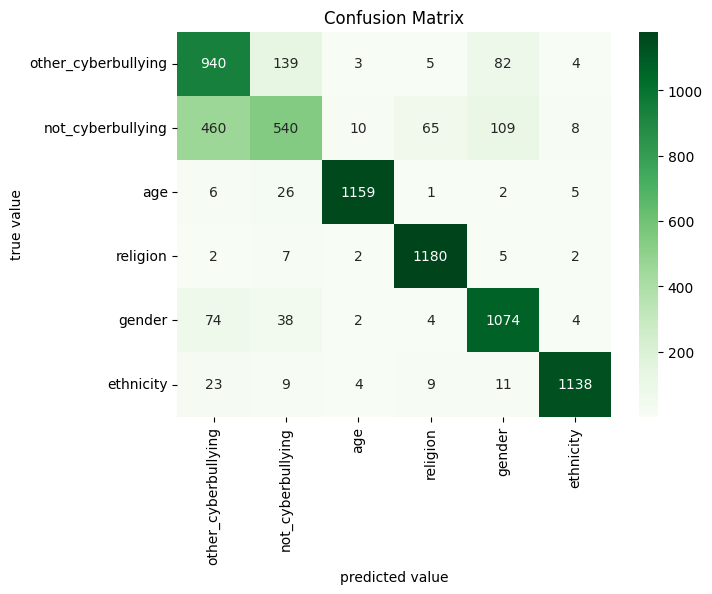

In [ ]:
# Generate test prompts and extract true labels
y_true = cyb_test.loc[:, 'label']
X_test = pd.DataFrame(cyb_test.apply(generate_test_prompt_agg_detail_v1, axis=1), columns=["text"])
y_pred = predict(X_test, model, tokenizer)
print("Cyb prediction  with aggression data")
evaluate(y_true, y_pred)